In [5]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
from math import pi
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

## INPUT DATA OF OF GLOBAL GRID

In [6]:
# Parameter selection
scenario_year = 2050

# DISTIANCES BETWEEN NODES
for key, value in links_dic.items():
    value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

# EFFICIENCY OF INTERCONNECTORS
cable_capacity = 1200 # MW
cable_voltage = 1100 # kV
cable_resistivity = 0.01286 # ohms/km
converter_losses = 0.015 # [-]
for key, value in links_dic.items():
    value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

# SYNTHETIC -> excludes Europe
path = "/Volumes/fi246disk/synde/resources/gegis/output"
load_profile_dic = {}
for key, value in regions_dic.items():
    load_profile_dic[key] = {}
    if key != "north_america" and key != "europe" and key != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) # MW

# HISTORIC -> includes Europe and USA
demand_mult_ssp1_26_oecd = 1.36
load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

In [9]:
generation_list = []
wind_pv_share_list = []
curtailment_list = []
transmission_list = []
actual_flow_list = []
losses_list = []

# RENEWABLE PROFILES
land_use_availabilities = np.linspace(1, 20, 20) / 100
for land_use_availability in land_use_availabilities:
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=land_use_availability)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=0.05) # MW

    # Parameter selection
    cost_generation = 1.0
    cost_transmission = 1e-4
    cost_curtailment = 0

    # Initialise the network
    n = pypsa.Network() 
    snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
    n.set_snapshots(snapshots)

    # Loop over the dictionary to add the buses
    for key, value in regions_dic.items():
        n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
        
    # Loop over the dictionary to add the links 
    for key, value in links_dic.items():
        n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
        n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

    # Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
    for key, value in res_potential_dic.items():
        n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["wind"][snapshots],p_min_pu=value["wind"][snapshots], marginal_cost=cost_generation)
        n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["pv"][snapshots],p_min_pu=value["pv"][snapshots],marginal_cost=cost_generation)
        n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

    # Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
    for key, value in load_profile_dic.items():
        n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

    m = n.optimize.create_model();

    n.optimize(solver_name='gurobi')

    for key, value in regions_dic.items(): # Annual (total) values
        for carrier in ["pv", "wind"]: 
            regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
            regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
        
        regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
        regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
 
    for key, value in regions_dic.items():
        # Generation data of each node
        for carrier in ["pv", "wind"]:
            series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
            regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # GW
            regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # GWh
            regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # GW
            regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # GW
        # Curtailment data of each node
        series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
        regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # GW
        regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # GW
        regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # GWh
        # Demand data of each node
        series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
        regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
        regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
        regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # GWh
        
    # Daily hourly values of specific days
    dates = pd.to_datetime([f"{scenario_year}-03-21", f"{scenario_year}-06-21", f"{scenario_year}-09-21", f"{scenario_year}-12-21", f"{scenario_year}-04-06"])
    for date in dates:
        for key, value in regions_dic.items():
            for carrier in ["pv", "wind"]:
                regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

            regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
            regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

    # Sum generation and loads of nodes
    total_hourly_gen = pd.Series(0, index=n.snapshots)
    total_hourly_wind = pd.Series(0, index=n.snapshots)
    total_hourly_pv = pd.Series(0, index=n.snapshots)
    total_hourly_cur = pd.Series(0, index=n.snapshots)
    total_hourly_load = pd.Series(0, index=n.snapshots)
    for key, value in regions_dic.items():
        total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
        total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
        total_hourly_pv += n.generators_t.p[f"pv_{key}"]
        total_hourly_wind += n.generators_t.p[f"wind_{key}"]

        total_hourly_load += n.loads_t.p[f"load_{key}"]
        
    # Generation total
    total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
    total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
    total_annual_gen = total_hourly_gen.sum()

    # Generation wind
    total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
    total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
    total_annual_wind = total_hourly_wind.sum()

    # Generation pv
    total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
    total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
    total_annual_pv = total_hourly_pv.sum()

    # Curtailment
    total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
    total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
    total_annual_cur = total_hourly_cur.sum()

    # Load 
    total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
    total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
    total_annual_load = total_hourly_load.sum()

    # Store hourly losses for each link in dictionary
    for key, value in links_dic.items():
        p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
        p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
        abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
        p_trans = p0_0 + p0_1
        value["hourly_p_trans"] = p_trans
        value["hourly_abs_losses"] = abs_losses

    # Sum the transmission and losses of the links
    total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
    total_hourly_p_trans = pd.Series(0, index=n.snapshots)
    for key, value in links_dic.items():
        total_hourly_abs_losses += value["hourly_abs_losses"]
        total_hourly_p_trans += value["hourly_p_trans"]

    # Absolute losses
    total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
    total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
    total_annual_abs_losses = total_hourly_abs_losses.sum()

    # Power transmitted
    total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
    total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
    total_annual_p_trans = total_hourly_p_trans.sum()

    # Relative losses to transmission
    daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
    monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
    annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

    # Statistics of the losses to transmission
    mean_losses = total_hourly_abs_losses.mean()
    std_losses = total_hourly_abs_losses.std()
    daily_deviation = daily_rel_losses - daily_rel_losses.mean()
    monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

    # Losses relative to load
    hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
    daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
    monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
    annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

    # Losses relative to gen
    hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
    daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
    monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
    annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

    # Curtailment relative to gen
    hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
    daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
    monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
    annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

    # Power transmitted rel to gen
    hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
    daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
    monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
    annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

    # Calculate inflow, outflow, and 
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        inflow_series = pd.Series(0, index=n.snapshots)
        outflow_series = pd.Series(0, index=n.snapshots)
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                sum_p0_0 = abs(sum(p0_0))
                sum_p1_1 = abs(sum(p1_1))
                outflow += sum_p0_0
                inflow += sum_p1_1
                outflow_series += p0_0
                inflow_series += p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_0 = n.links_t.p1[f"{link_value["name"]}_0"]
                sum_p0_1 = abs(sum(p0_1))
                sum_p1_0 = abs(sum(p1_0))
                outflow += sum_p0_1
                inflow += sum_p1_0
                outflow_series += p0_1
                inflow_series += p1_0
        netflow = (outflow - inflow) * 1e-3 # GW
        if netflow < 0:
            region_value["total_actualflow"] = 0
        else:
            region_value["total_actualflow"] = netflow
        region_value["inflow"] = inflow * 1e-3 # GW
        region_value["outflow"] = outflow * 1e-3 # GW
        region_value["inflow_series"] = inflow_series * 1e-3 # GW
        region_value["outflow_series"] = outflow_series * 1e-3 # GW
        region_value["netflow"] = netflow 
        region_value["actualflow"] = (outflow_series - inflow_series) * 1e-3 # GW
        region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])

    # Compute total power transmitted for each hour
    total_actual_flow = pd.Series(0, index=n.snapshots)
    total_actual_flow_int = 0
    for key, value in regions_dic.items():
        total_actual_flow += value["actualflow"]
        total_actual_flow_int += value["total_actualflow"]

    # Actual flow 
    hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

    # Compute inflow, outflow direction per link
    flow_statements = []
    netflows_links = []
    for link_key, link_value in links_dic.items():
        p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
        p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
        p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
        sum_p0_0 = abs(sum(p0_0))
        sum_p0_1 = abs(sum(p1_1))
        net_flow = abs(sum_p0_0 - sum_p0_1)
        if sum_p0_0 > sum_p0_1:
            flow_statement = True # outflow
        else:
            flow_statement = False
        flow_statements.append(flow_statement)
        netflows_links.append(net_flow)

    # Calculation of monthly inflows and outflows
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
    month_to_period = {month: period for month, period in zip(months, month_periods)}
    for i, month in enumerate(months):
        period = month_to_period[month]
        for region_key, region_value in regions_dic.items():
            inflow = 0
            outflow = 0
            for link_key, link_value in links_dic.items():
                if region_value["bus"] == link_value["bus0"][0]:
                    p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                    p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                    monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                    monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                    sum_p0_0 = abs(monthly_p0_0.loc[period])
                    sum_p1_1 = abs(monthly_p1_1.loc[period])
                    outflow += sum_p0_0
                    inflow += sum_p1_1
                elif region_value["bus"] == link_value["bus1"][0]:
                    p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                    p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                    monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                    monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                    sum_p0_0 = abs(monthly_p0_0.loc[period])
                    sum_p1_1 = abs(monthly_p1_1.loc[period])
                    outflow += sum_p0_0
                    inflow += sum_p1_1
            region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
            region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
            region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW
    
    wind_share = total_annual_wind / total_annual_gen * 100
    pv_share = 100 - wind_share
    generation_list.append(total_annual_gen)
    wind_pv_share_list.append((wind_share, pv_share))
    curtailment_list.append(total_annual_cur)
    transmission_list.append(total_annual_p_trans)
    actual_flow_list.append(total_actual_flow_int)
    losses_list.append(annual_losses_rel_to_gen)

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]
INFO:linopy.io: Writing time: 4.65s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0b7st2tg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0b7st2tg.lp


Reading time = 1.75 seconds


INFO:gurobipy:Reading time = 1.75 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x9a767590


INFO:gurobipy:Model fingerprint: 0x9a767590


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.55645771e+14 -3.57973261e+12  1.19e+04 1.95e+06  2.24e+12     1s


INFO:gurobipy:   0   1.55645771e+14 -3.57973261e+12  1.19e+04 1.95e+06  2.24e+12     1s


   1   1.86223021e+14  1.21256010e+13  1.58e+04 1.59e+08  1.61e+12     1s


INFO:gurobipy:   1   1.86223021e+14  1.21256010e+13  1.58e+04 1.59e+08  1.61e+12     1s


   2   2.19222588e+14 -3.65861496e+13  1.37e+04 8.96e+07  9.05e+11     1s


INFO:gurobipy:   2   2.19222588e+14 -3.65861496e+13  1.37e+04 8.96e+07  9.05e+11     1s


   3   7.34510261e+13 -1.48285804e+14  4.49e+03 3.28e+07  3.44e+11     1s


INFO:gurobipy:   3   7.34510261e+13 -1.48285804e+14  4.49e+03 3.28e+07  3.44e+11     1s


   4   3.36173985e+13 -3.00978118e+14  1.92e+03 1.00e+07  1.36e+11     1s


INFO:gurobipy:   4   3.36173985e+13 -3.00978118e+14  1.92e+03 1.00e+07  1.36e+11     1s


   5   1.18661406e+13 -4.09125489e+14  6.17e+02 3.55e+06  4.72e+10     1s


INFO:gurobipy:   5   1.18661406e+13 -4.09125489e+14  6.17e+02 3.55e+06  4.72e+10     1s


   6   4.73076166e+12 -5.20740633e+14  2.09e+02 6.48e+05  1.52e+10     1s


INFO:gurobipy:   6   4.73076166e+12 -5.20740633e+14  2.09e+02 6.48e+05  1.52e+10     1s


   7   1.50367249e+12 -4.93848158e+14  2.46e+01 1.04e+05  2.60e+09     1s


INFO:gurobipy:   7   1.50367249e+12 -4.93848158e+14  2.46e+01 1.04e+05  2.60e+09     1s


   8   1.06773871e+12 -1.39819619e+14  2.29e-02 2.63e+03  3.20e+08     1s


INFO:gurobipy:   8   1.06773871e+12 -1.39819619e+14  2.29e-02 2.63e+03  3.20e+08     1s


   9   1.06688284e+12 -4.98271138e+11  2.84e-11 2.91e+01  3.55e+06     1s


INFO:gurobipy:   9   1.06688284e+12 -4.98271138e+11  2.84e-11 2.91e+01  3.55e+06     1s


  10   9.91506470e+11 -1.01927077e+12  2.49e-11 2.08e+01  4.55e+06     2s


INFO:gurobipy:  10   9.91506470e+11 -1.01927077e+12  2.49e-11 2.08e+01  4.55e+06     2s


  11   9.21383043e+11 -3.09924257e+11  1.58e-11 6.35e+00  2.79e+06     2s


INFO:gurobipy:  11   9.21383043e+11 -3.09924257e+11  1.58e-11 6.35e+00  2.79e+06     2s


  12   8.15145670e+11 -1.10118514e+11  1.30e-11 1.47e+00  2.09e+06     2s


INFO:gurobipy:  12   8.15145670e+11 -1.10118514e+11  1.30e-11 1.47e+00  2.09e+06     2s


  13   5.12603437e+11 -5.53211456e+10  1.06e-11 8.87e-05  1.28e+06     2s


INFO:gurobipy:  13   5.12603437e+11 -5.53211456e+10  1.06e-11 8.87e-05  1.28e+06     2s


  14   4.20454030e+11 -5.18341850e+09  8.44e-12 7.10e-05  9.61e+05     2s


INFO:gurobipy:  14   4.20454030e+11 -5.18341850e+09  8.44e-12 7.10e-05  9.61e+05     2s


  15   3.92303455e+11 -4.19901605e+09  7.80e-12 9.01e-05  8.95e+05     2s


INFO:gurobipy:  15   3.92303455e+11 -4.19901605e+09  7.80e-12 9.01e-05  8.95e+05     2s


  16   3.74751435e+11  1.25035237e+10  7.39e-12 5.34e-05  8.17e+05     2s


INFO:gurobipy:  16   3.74751435e+11  1.25035237e+10  7.39e-12 5.34e-05  8.17e+05     2s


  17   2.75270536e+11  2.52370859e+10  5.14e-12 6.68e-05  5.64e+05     2s


INFO:gurobipy:  17   2.75270536e+11  2.52370859e+10  5.14e-12 6.68e-05  5.64e+05     2s


  18   1.45797806e+11  4.19047019e+10  2.50e-12 3.81e-05  2.34e+05     2s


INFO:gurobipy:  18   1.45797806e+11  4.19047019e+10  2.50e-12 3.81e-05  2.34e+05     2s


  19   1.09085216e+11  4.85056793e+10  1.71e-12 2.91e-05  1.37e+05     2s


INFO:gurobipy:  19   1.09085216e+11  4.85056793e+10  1.71e-12 2.91e-05  1.37e+05     2s


  20   1.06437841e+11  4.96428248e+10  1.59e-12 1.86e-05  1.28e+05     2s


INFO:gurobipy:  20   1.06437841e+11  4.96428248e+10  1.59e-12 1.86e-05  1.28e+05     2s


  21   1.02658369e+11  5.08572603e+10  1.59e-12 1.91e-05  1.17e+05     2s


INFO:gurobipy:  21   1.02658369e+11  5.08572603e+10  1.59e-12 1.91e-05  1.17e+05     2s


  22   9.73416203e+10  5.16347402e+10  1.36e-12 1.31e-05  1.03e+05     2s


INFO:gurobipy:  22   9.73416203e+10  5.16347402e+10  1.36e-12 1.31e-05  1.03e+05     2s


  23   9.46660922e+10  5.30959203e+10  1.25e-12 1.05e-05  9.37e+04     3s


INFO:gurobipy:  23   9.46660922e+10  5.30959203e+10  1.25e-12 1.05e-05  9.37e+04     3s


  24   8.54194425e+10  5.44936287e+10  1.14e-12 1.17e-05  6.97e+04     3s


INFO:gurobipy:  24   8.54194425e+10  5.44936287e+10  1.14e-12 1.17e-05  6.97e+04     3s


  25   8.30283329e+10  5.69719906e+10  6.25e-13 1.67e-05  5.88e+04     3s


INFO:gurobipy:  25   8.30283329e+10  5.69719906e+10  6.25e-13 1.67e-05  5.88e+04     3s


  26   8.13706895e+10  5.93146182e+10  7.96e-13 2.34e-05  4.97e+04     3s


INFO:gurobipy:  26   8.13706895e+10  5.93146182e+10  7.96e-13 2.34e-05  4.97e+04     3s


  27   7.95609008e+10  6.46677931e+10  5.97e-13 2.86e-05  3.36e+04     3s


INFO:gurobipy:  27   7.95609008e+10  6.46677931e+10  5.97e-13 2.86e-05  3.36e+04     3s


  28   7.91125136e+10  6.75021199e+10  5.68e-13 2.19e-05  2.62e+04     3s


INFO:gurobipy:  28   7.91125136e+10  6.75021199e+10  5.68e-13 2.19e-05  2.62e+04     3s


  29   7.91499653e+10  6.94174656e+10  4.55e-13 3.64e-05  2.19e+04     3s


INFO:gurobipy:  29   7.91499653e+10  6.94174656e+10  4.55e-13 3.64e-05  2.19e+04     3s


  30   7.86892270e+10  7.57625238e+10  1.14e-12 1.54e-04  6.60e+03     3s


INFO:gurobipy:  30   7.86892270e+10  7.57625238e+10  1.14e-12 1.54e-04  6.60e+03     3s


  31   7.84195460e+10  7.70550420e+10  1.30e-12 1.91e-04  3.08e+03     3s


INFO:gurobipy:  31   7.84195460e+10  7.70550420e+10  1.30e-12 1.91e-04  3.08e+03     3s


  32   7.83541209e+10  7.70959390e+10  1.14e-12 1.66e-04  2.84e+03     3s


INFO:gurobipy:  32   7.83541209e+10  7.70959390e+10  1.14e-12 1.66e-04  2.84e+03     3s


  33   7.82826160e+10  7.75154470e+10  1.05e-03 3.54e-05  1.73e+03     3s


INFO:gurobipy:  33   7.82826160e+10  7.75154470e+10  1.05e-03 3.54e-05  1.73e+03     3s


  34   7.82664265e+10  7.75736858e+10  1.66e-03 8.37e-05  1.56e+03     3s


INFO:gurobipy:  34   7.82664265e+10  7.75736858e+10  1.66e-03 8.37e-05  1.56e+03     3s


  35   7.82242544e+10  7.77453356e+10  2.86e-03 1.56e-04  1.08e+03     3s


INFO:gurobipy:  35   7.82242544e+10  7.77453356e+10  2.86e-03 1.56e-04  1.08e+03     3s


  36   7.81961010e+10  7.77964564e+10  5.39e-03 1.52e-04  9.04e+02     3s


INFO:gurobipy:  36   7.81961010e+10  7.77964564e+10  5.39e-03 1.52e-04  9.04e+02     3s


  37   7.81819010e+10  7.79807832e+10  5.24e-03 1.14e-03  4.59e+02     4s


INFO:gurobipy:  37   7.81819010e+10  7.79807832e+10  5.24e-03 1.14e-03  4.59e+02     4s


  38   7.81785653e+10  7.80667435e+10  5.48e-03 6.19e-04  2.58e+02     4s


INFO:gurobipy:  38   7.81785653e+10  7.80667435e+10  5.48e-03 6.19e-04  2.58e+02     4s


  39   7.81728832e+10  7.80726024e+10  5.77e-03 8.22e-04  2.32e+02     4s


INFO:gurobipy:  39   7.81728832e+10  7.80726024e+10  5.77e-03 8.22e-04  2.32e+02     4s


  40   7.81694753e+10  7.81361641e+10  2.65e-03 7.49e-04  7.78e+01     4s


INFO:gurobipy:  40   7.81694753e+10  7.81361641e+10  2.65e-03 7.49e-04  7.78e+01     4s


  41   7.81690292e+10  7.81520257e+10  2.51e-03 2.70e-03  4.08e+01     4s


INFO:gurobipy:  41   7.81690292e+10  7.81520257e+10  2.51e-03 2.70e-03  4.08e+01     4s


  42   7.81657195e+10  7.81549153e+10  1.06e-03 8.70e-04  2.57e+01     4s


INFO:gurobipy:  42   7.81657195e+10  7.81549153e+10  1.06e-03 8.70e-04  2.57e+01     4s


  43   7.81622788e+10  7.81567537e+10  5.14e-04 2.82e-04  1.30e+01     4s


INFO:gurobipy:  43   7.81622788e+10  7.81567537e+10  5.14e-04 2.82e-04  1.30e+01     4s


  44   7.81610013e+10  7.81575797e+10  3.32e-04 1.25e-04  8.00e+00     4s


INFO:gurobipy:  44   7.81610013e+10  7.81575797e+10  3.32e-04 1.25e-04  8.00e+00     4s


  45   7.81598161e+10  7.81580043e+10  1.62e-04 5.91e-05  4.22e+00     4s


INFO:gurobipy:  45   7.81598161e+10  7.81580043e+10  1.62e-04 5.91e-05  4.22e+00     4s


  46   7.81592326e+10  7.81582846e+10  8.57e-05 2.86e-05  2.20e+00     4s


INFO:gurobipy:  46   7.81592326e+10  7.81582846e+10  8.57e-05 2.86e-05  2.20e+00     4s


  47   7.81588696e+10  7.81584515e+10  3.92e-05 2.24e-05  9.64e-01     4s


INFO:gurobipy:  47   7.81588696e+10  7.81584515e+10  3.92e-05 2.24e-05  9.64e-01     4s


  48   7.81587027e+10  7.81585130e+10  1.79e-05 1.91e-05  4.34e-01     4s


INFO:gurobipy:  48   7.81587027e+10  7.81585130e+10  1.79e-05 1.91e-05  4.34e-01     4s


  49   7.81586401e+10  7.81585491e+10  9.45e-06 1.57e-05  2.07e-01     4s


INFO:gurobipy:  49   7.81586401e+10  7.81585491e+10  9.45e-06 1.57e-05  2.07e-01     4s


  50   7.81586042e+10  7.81585622e+10  4.22e-06 1.91e-06  9.50e-02     5s


INFO:gurobipy:  50   7.81586042e+10  7.81585622e+10  4.22e-06 1.91e-06  9.50e-02     5s


  51   7.81585856e+10  7.81585691e+10  1.78e-06 1.29e-05  3.64e-02     5s


INFO:gurobipy:  51   7.81585856e+10  7.81585691e+10  1.78e-06 1.29e-05  3.64e-02     5s


  52   7.81585747e+10  7.81585714e+10  4.81e-07 2.05e-05  6.24e-03     5s


INFO:gurobipy:  52   7.81585747e+10  7.81585714e+10  4.81e-07 2.05e-05  6.24e-03     5s


  53   7.81585730e+10  7.81585717e+10  1.43e-07 1.43e-05  2.24e-03     5s


INFO:gurobipy:  53   7.81585730e+10  7.81585717e+10  1.43e-07 1.43e-05  2.24e-03     5s


  54   7.81585722e+10  7.81585718e+10  1.12e-07 1.00e-05  7.74e-04     5s


INFO:gurobipy:  54   7.81585722e+10  7.81585718e+10  1.12e-07 1.00e-05  7.74e-04     5s


  55   7.81585716e+10  7.81585718e+10  9.12e-07 1.53e-05  2.38e-04     5s


INFO:gurobipy:  55   7.81585716e+10  7.81585718e+10  9.12e-07 1.53e-05  2.38e-04     5s


  56   7.81585714e+10  7.81585718e+10  1.82e-06 2.05e-05  3.83e-05     5s


INFO:gurobipy:  56   7.81585714e+10  7.81585718e+10  1.82e-06 2.05e-05  3.83e-05     5s


  57   7.81585714e+10  7.81585718e+10  5.08e-07 2.48e-05  7.57e-06     5s


INFO:gurobipy:  57   7.81585714e+10  7.81585718e+10  5.08e-07 2.48e-05  7.57e-06     5s


  58   7.81585715e+10  7.81585718e+10  4.91e-07 2.16e-04  3.68e-07     5s


INFO:gurobipy:  58   7.81585715e+10  7.81585718e+10  4.91e-07 2.16e-04  3.68e-07     5s


  59   7.81585719e+10  7.81585718e+10  1.43e-08 2.16e-04  1.33e-08     5s


INFO:gurobipy:  59   7.81585719e+10  7.81585718e+10  1.43e-08 2.16e-04  1.33e-08     5s


  60   7.81585718e+10  7.81585718e+10  7.80e-11 5.01e-05  1.33e-11     6s


INFO:gurobipy:  60   7.81585718e+10  7.81585718e+10  7.80e-11 5.01e-05  1.33e-11     6s


INFO:gurobipy:


Barrier solved model in 60 iterations and 5.59 seconds (7.11 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 5.59 seconds (7.11 work units)


Optimal objective 7.81585718e+10


INFO:gurobipy:Optimal objective 7.81585718e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4655 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    4655 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:


      58 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:      58 PPushes remaining with PInf 0.0000000e+00                 6s


       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 6s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5265163e-05      6s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5265163e-05      6s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4714    7.8158572e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:    4714    7.8158572e+10   0.000000e+00   0.000000e+00      6s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4714    7.8158572e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    4714    7.8158572e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 4714 iterations and 6.83 seconds (8.03 work units)


INFO:gurobipy:Solved in 4714 iterations and 6.83 seconds (8.03 work units)


Optimal objective  7.815857183e+10


INFO:gurobipy:Optimal objective  7.815857183e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.82e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.62it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7hkjg0zy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-7hkjg0zy.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xb9ac976d


INFO:gurobipy:Model fingerprint: 0xb9ac976d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.59180599e+14 -9.89037227e+12  6.88e+03 1.91e+06  2.63e+12     1s


INFO:gurobipy:   0   1.59180599e+14 -9.89037227e+12  6.88e+03 1.91e+06  2.63e+12     1s


   1   1.85780179e+14 -8.18863654e+13  1.04e+04 3.31e+08  1.93e+12     1s


INFO:gurobipy:   1   1.85780179e+14 -8.18863654e+13  1.04e+04 3.31e+08  1.93e+12     1s


   2   2.23611682e+14 -1.51479874e+14  8.86e+03 1.42e+08  9.42e+11     1s


INFO:gurobipy:   2   2.23611682e+14 -1.51479874e+14  8.86e+03 1.42e+08  9.42e+11     1s


   3   1.13060131e+14 -2.29546119e+14  5.52e+03 5.19e+07  4.31e+11     1s


INFO:gurobipy:   3   1.13060131e+14 -2.29546119e+14  5.52e+03 5.19e+07  4.31e+11     1s


   4   6.89963408e+13 -2.60046748e+14  3.13e+03 1.88e+07  1.94e+11     1s


INFO:gurobipy:   4   6.89963408e+13 -2.60046748e+14  3.13e+03 1.88e+07  1.94e+11     1s


   5   4.20296878e+13 -2.92934255e+14  1.80e+03 7.76e+06  1.03e+11     1s


INFO:gurobipy:   5   4.20296878e+13 -2.92934255e+14  1.80e+03 7.76e+06  1.03e+11     1s


   6   2.09481338e+13 -3.23765303e+14  8.42e+02 3.14e+06  4.80e+10     1s


INFO:gurobipy:   6   2.09481338e+13 -3.23765303e+14  8.42e+02 3.14e+06  4.80e+10     1s


   7   6.92271780e+12 -3.53268475e+14  2.36e+02 5.92e+05  1.36e+10     1s


INFO:gurobipy:   7   6.92271780e+12 -3.53268475e+14  2.36e+02 5.92e+05  1.36e+10     1s


   8   1.61527581e+12 -3.43457579e+14  2.02e+01 9.90e+04  1.82e+09     2s


INFO:gurobipy:   8   1.61527581e+12 -3.43457579e+14  2.02e+01 9.90e+04  1.82e+09     2s


   9   1.10525737e+12 -1.32069271e+14  1.14e-01 8.10e+03  3.07e+08     2s


INFO:gurobipy:   9   1.10525737e+12 -1.32069271e+14  1.14e-01 8.10e+03  3.07e+08     2s


  10   1.09930963e+12 -5.64677480e+11  7.05e-12 7.86e+01  3.79e+06     2s


INFO:gurobipy:  10   1.09930963e+12 -5.64677480e+11  7.05e-12 7.86e+01  3.79e+06     2s


  11   1.02208920e+12 -5.37653630e+11  6.52e-12 7.91e+01  3.54e+06     2s


INFO:gurobipy:  11   1.02208920e+12 -5.37653630e+11  6.52e-12 7.91e+01  3.54e+06     2s


  12   9.75140311e+11 -2.12502387e+11  5.84e-12 3.96e+01  2.69e+06     2s


INFO:gurobipy:  12   9.75140311e+11 -2.12502387e+11  5.84e-12 3.96e+01  2.69e+06     2s


  13   6.95307673e+11 -6.82092410e+10  4.73e-12 2.72e+01  1.73e+06     2s


INFO:gurobipy:  13   6.95307673e+11 -6.82092410e+10  4.73e-12 2.72e+01  1.73e+06     2s


  14   5.58507891e+11 -3.37039021e+10  3.07e-12 2.47e+01  1.34e+06     2s


INFO:gurobipy:  14   5.58507891e+11 -3.37039021e+10  3.07e-12 2.47e+01  1.34e+06     2s


  15   4.74099496e+11  1.40715537e+10  2.44e-12 7.72e+00  1.04e+06     2s


INFO:gurobipy:  15   4.74099496e+11  1.40715537e+10  2.44e-12 7.72e+00  1.04e+06     2s


  16   3.55996356e+11  2.99864093e+10  1.82e-12 5.24e+00  7.33e+05     2s


INFO:gurobipy:  16   3.55996356e+11  2.99864093e+10  1.82e-12 5.24e+00  7.33e+05     2s


  17   1.80957713e+11  4.42017572e+10  1.02e-12 1.90e+00  3.07e+05     2s


INFO:gurobipy:  17   1.80957713e+11  4.42017572e+10  1.02e-12 1.90e+00  3.07e+05     2s


  18   1.12409904e+11  4.65292686e+10  6.82e-13 1.49e+00  1.48e+05     2s


INFO:gurobipy:  18   1.12409904e+11  4.65292686e+10  6.82e-13 1.49e+00  1.48e+05     2s


  19   9.10135339e+10  5.23136648e+10  4.55e-13 1.58e-01  8.68e+04     2s


INFO:gurobipy:  19   9.10135339e+10  5.23136648e+10  4.55e-13 1.58e-01  8.68e+04     2s


  20   8.83915818e+10  5.35281415e+10  3.41e-13 1.38e-04  7.82e+04     2s


INFO:gurobipy:  20   8.83915818e+10  5.35281415e+10  3.41e-13 1.38e-04  7.82e+04     2s


  21   8.04476796e+10  5.47944150e+10  3.41e-13 1.29e-04  5.75e+04     3s


INFO:gurobipy:  21   8.04476796e+10  5.47944150e+10  3.41e-13 1.29e-04  5.75e+04     3s


  22   7.97827120e+10  5.50223420e+10  3.41e-13 1.35e-04  5.55e+04     3s


INFO:gurobipy:  22   7.97827120e+10  5.50223420e+10  3.41e-13 1.35e-04  5.55e+04     3s


  23   7.92220588e+10  5.54024118e+10  3.41e-13 1.03e-04  5.34e+04     3s


INFO:gurobipy:  23   7.92220588e+10  5.54024118e+10  3.41e-13 1.03e-04  5.34e+04     3s


  24   7.81671186e+10  5.73075635e+10  3.41e-13 9.06e-05  4.68e+04     3s


INFO:gurobipy:  24   7.81671186e+10  5.73075635e+10  3.41e-13 9.06e-05  4.68e+04     3s


  25   7.54107375e+10  6.24102612e+10  3.41e-13 6.01e-05  2.91e+04     3s


INFO:gurobipy:  25   7.54107375e+10  6.24102612e+10  3.41e-13 6.01e-05  2.91e+04     3s


  26   7.40801861e+10  6.35870258e+10  3.41e-13 5.72e-05  2.35e+04     3s


INFO:gurobipy:  26   7.40801861e+10  6.35870258e+10  3.41e-13 5.72e-05  2.35e+04     3s


  27   7.40001332e+10  6.43659882e+10  3.41e-13 4.20e-05  2.16e+04     3s


INFO:gurobipy:  27   7.40001332e+10  6.43659882e+10  3.41e-13 4.20e-05  2.16e+04     3s


  28   7.37515057e+10  6.55972213e+10  3.41e-13 3.19e-05  1.83e+04     3s


INFO:gurobipy:  28   7.37515057e+10  6.55972213e+10  3.41e-13 3.19e-05  1.83e+04     3s


  29   7.35518997e+10  6.73729902e+10  1.71e-13 3.36e-04  1.39e+04     3s


INFO:gurobipy:  29   7.35518997e+10  6.73729902e+10  1.71e-13 3.36e-04  1.39e+04     3s


  30   7.35714838e+10  6.88050585e+10  1.46e-13 6.98e-04  1.07e+04     3s


INFO:gurobipy:  30   7.35714838e+10  6.88050585e+10  1.46e-13 6.98e-04  1.07e+04     3s


  31   7.34388291e+10  7.07193747e+10  6.20e-05 2.19e-03  6.10e+03     3s


INFO:gurobipy:  31   7.34388291e+10  7.07193747e+10  6.20e-05 2.19e-03  6.10e+03     3s


  32   7.33781492e+10  7.19662862e+10  1.83e-04 1.12e-03  3.17e+03     3s


INFO:gurobipy:  32   7.33781492e+10  7.19662862e+10  1.83e-04 1.12e-03  3.17e+03     3s


  33   7.33675744e+10  7.27204197e+10  1.74e-04 4.62e-03  1.45e+03     3s


INFO:gurobipy:  33   7.33675744e+10  7.27204197e+10  1.74e-04 4.62e-03  1.45e+03     3s


  34   7.33664484e+10  7.28472596e+10  1.68e-04 3.66e-03  1.16e+03     3s


INFO:gurobipy:  34   7.33664484e+10  7.28472596e+10  1.68e-04 3.66e-03  1.16e+03     3s


  35   7.33659298e+10  7.28571343e+10  1.64e-04 3.49e-03  1.14e+03     4s


INFO:gurobipy:  35   7.33659298e+10  7.28571343e+10  1.64e-04 3.49e-03  1.14e+03     4s


  36   7.33514146e+10  7.30199069e+10  7.72e-04 1.87e-03  7.44e+02     4s


INFO:gurobipy:  36   7.33514146e+10  7.30199069e+10  7.72e-04 1.87e-03  7.44e+02     4s


  37   7.33479970e+10  7.32970356e+10  9.15e-04 3.29e-04  1.16e+02     4s


INFO:gurobipy:  37   7.33479970e+10  7.32970356e+10  9.15e-04 3.29e-04  1.16e+02     4s


  38   7.33430637e+10  7.33235284e+10  7.95e-04 3.22e-04  4.51e+01     4s


INFO:gurobipy:  38   7.33430637e+10  7.33235284e+10  7.95e-04 3.22e-04  4.51e+01     4s


  39   7.33407549e+10  7.33297500e+10  7.42e-04 2.31e-04  2.59e+01     4s


INFO:gurobipy:  39   7.33407549e+10  7.33297500e+10  7.42e-04 2.31e-04  2.59e+01     4s


  40   7.33379372e+10  7.33313064e+10  7.24e-04 1.61e-04  1.60e+01     4s


INFO:gurobipy:  40   7.33379372e+10  7.33313064e+10  7.24e-04 1.61e-04  1.60e+01     4s


  41   7.33359968e+10  7.33326347e+10  7.05e-04 8.20e-05  8.64e+00     4s


INFO:gurobipy:  41   7.33359968e+10  7.33326347e+10  7.05e-04 8.20e-05  8.64e+00     4s


  42   7.33349128e+10  7.33334260e+10  6.59e-04 4.34e-05  4.36e+00     4s


INFO:gurobipy:  42   7.33349128e+10  7.33334260e+10  6.59e-04 4.34e-05  4.36e+00     4s


  43   7.33345838e+10  7.33337728e+10  3.21e-04 2.91e-05  2.32e+00     4s


INFO:gurobipy:  43   7.33345838e+10  7.33337728e+10  3.21e-04 2.91e-05  2.32e+00     4s


  44   7.33343872e+10  7.33339695e+10  1.47e-04 1.67e-05  1.17e+00     4s


INFO:gurobipy:  44   7.33343872e+10  7.33339695e+10  1.47e-04 1.67e-05  1.17e+00     4s


  45   7.33342871e+10  7.33340850e+10  6.29e-05 1.53e-05  5.52e-01     4s


INFO:gurobipy:  45   7.33342871e+10  7.33340850e+10  6.29e-05 1.53e-05  5.52e-01     4s


  46   7.33342312e+10  7.33341319e+10  3.50e-05 8.11e-06  2.77e-01     4s


INFO:gurobipy:  46   7.33342312e+10  7.33341319e+10  3.50e-05 8.11e-06  2.77e-01     4s


  47   7.33342036e+10  7.33341549e+10  6.66e-06 7.63e-06  1.22e-01     4s


INFO:gurobipy:  47   7.33342036e+10  7.33341549e+10  6.66e-06 7.63e-06  1.22e-01     4s


  48   7.33341915e+10  7.33341656e+10  4.96e-06 2.10e-05  5.58e-02     4s


INFO:gurobipy:  48   7.33341915e+10  7.33341656e+10  4.96e-06 2.10e-05  5.58e-02     4s


  49   7.33341861e+10  7.33341696e+10  8.05e-06 5.48e-06  2.32e-02     5s


INFO:gurobipy:  49   7.33341861e+10  7.33341696e+10  8.05e-06 5.48e-06  2.32e-02     5s


  50   7.33341965e+10  7.33341704e+10  2.30e-05 2.38e-06  1.12e-02     5s


INFO:gurobipy:  50   7.33341965e+10  7.33341704e+10  2.30e-05 2.38e-06  1.12e-02     5s


  51   7.33342122e+10  7.33341713e+10  4.09e-05 1.14e-05  4.85e-03     5s


INFO:gurobipy:  51   7.33342122e+10  7.33341713e+10  4.09e-05 1.14e-05  4.85e-03     5s


  52   7.33342084e+10  7.33341718e+10  4.70e-05 4.77e-06  1.83e-03     5s


INFO:gurobipy:  52   7.33342084e+10  7.33341718e+10  4.70e-05 4.77e-06  1.83e-03     5s


  53   7.33342003e+10  7.33341719e+10  3.01e-05 9.54e-06  6.04e-04     5s


INFO:gurobipy:  53   7.33342003e+10  7.33341719e+10  3.01e-05 9.54e-06  6.04e-04     5s


  54   7.33341819e+10  7.33341720e+10  1.05e-05 3.34e-05  2.09e-04     5s


INFO:gurobipy:  54   7.33341819e+10  7.33341720e+10  1.05e-05 3.34e-05  2.09e-04     5s


  55   7.33341722e+10  7.33341720e+10  1.39e-06 6.20e-06  2.29e-05     5s


INFO:gurobipy:  55   7.33341722e+10  7.33341720e+10  1.39e-06 6.20e-06  2.29e-05     5s


  56   7.33341710e+10  7.33341720e+10  6.89e-07 3.11e-05  7.01e-07     5s


INFO:gurobipy:  56   7.33341710e+10  7.33341720e+10  6.89e-07 3.11e-05  7.01e-07     5s


  57   7.33341719e+10  7.33341720e+10  4.74e-08 9.25e-05  6.55e-09     6s


INFO:gurobipy:  57   7.33341719e+10  7.33341720e+10  4.74e-08 9.25e-05  6.55e-09     6s


INFO:gurobipy:


Barrier solved model in 57 iterations and 5.51 seconds (6.98 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 5.51 seconds (6.98 work units)


Optimal objective 7.33341719e+10


INFO:gurobipy:Optimal objective 7.33341719e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5699 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    5699 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


    1211 PPushes remaining with PInf 5.4273677e-05                 7s


INFO:gurobipy:    1211 PPushes remaining with PInf 5.4273677e-05                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4221869e-05      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.4221869e-05      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    6817    7.3334172e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    6817    7.3334172e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    6817    7.3334172e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    6817    7.3334172e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 6817 iterations and 7.31 seconds (9.51 work units)


INFO:gurobipy:Solved in 6817 iterations and 7.31 seconds (9.51 work units)


Optimal objective  7.333417202e+10


INFO:gurobipy:Optimal objective  7.333417202e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.33e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.47it/s]
INFO:linopy.io: Writing time: 4.29s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y71rv2vk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-y71rv2vk.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xf1309e02


INFO:gurobipy:Model fingerprint: 0xf1309e02


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.10511480e+14 -1.54888251e+13  4.87e+03 2.48e+06  2.10e+12     1s


INFO:gurobipy:   0   1.10511480e+14 -1.54888251e+13  4.87e+03 2.48e+06  2.10e+12     1s


   1   1.42286344e+14 -5.31467148e+13  6.97e+03 3.59e+08  1.49e+12     1s


INFO:gurobipy:   1   1.42286344e+14 -5.31467148e+13  6.97e+03 3.59e+08  1.49e+12     1s


   2   1.40625940e+14 -1.86135968e+14  6.13e+03 1.75e+08  8.31e+11     1s


INFO:gurobipy:   2   1.40625940e+14 -1.86135968e+14  6.13e+03 1.75e+08  8.31e+11     1s


   3   5.82742001e+13 -3.19394117e+14  2.95e+03 5.62e+07  3.31e+11     1s


INFO:gurobipy:   3   5.82742001e+13 -3.19394117e+14  2.95e+03 5.62e+07  3.31e+11     1s


   4   3.12421675e+13 -4.04200331e+14  1.41e+03 1.97e+07  1.47e+11     1s


INFO:gurobipy:   4   3.12421675e+13 -4.04200331e+14  1.41e+03 1.97e+07  1.47e+11     1s


   5   1.19352294e+13 -4.82325466e+14  4.68e+02 7.50e+06  5.23e+10     1s


INFO:gurobipy:   5   1.19352294e+13 -4.82325466e+14  4.68e+02 7.50e+06  5.23e+10     1s


   6   5.26930695e+12 -5.73879252e+14  1.68e+02 1.49e+06  1.81e+10     1s


INFO:gurobipy:   6   5.26930695e+12 -5.73879252e+14  1.68e+02 1.49e+06  1.81e+10     1s


   7   1.79093856e+12 -5.54027492e+14  2.51e+01 2.19e+05  3.47e+09     2s


INFO:gurobipy:   7   1.79093856e+12 -5.54027492e+14  2.51e+01 2.19e+05  3.47e+09     2s


   8   1.15938027e+12 -2.36391128e+14  2.66e-02 1.06e+04  5.41e+08     2s


INFO:gurobipy:   8   1.15938027e+12 -2.36391128e+14  2.66e-02 1.06e+04  5.41e+08     2s


   9   1.15570230e+12 -4.86694460e+11  6.40e-12 7.25e+01  3.71e+06     2s


INFO:gurobipy:   9   1.15570230e+12 -4.86694460e+11  6.40e-12 7.25e+01  3.71e+06     2s


  10   1.02929975e+12 -2.28517806e+11  5.07e-12 1.83e+01  2.83e+06     2s


INFO:gurobipy:  10   1.02929975e+12 -2.28517806e+11  5.07e-12 1.83e+01  2.83e+06     2s


  11   9.40252235e+11 -1.96902553e+11  4.38e-12 1.11e+01  2.56e+06     2s


INFO:gurobipy:  11   9.40252235e+11 -1.96902553e+11  4.38e-12 1.11e+01  2.56e+06     2s


  12   7.76392359e+11 -5.08566890e+10  3.66e-12 1.19e+01  1.86e+06     2s


INFO:gurobipy:  12   7.76392359e+11 -5.08566890e+10  3.66e-12 1.19e+01  1.86e+06     2s


  13   6.04576681e+11 -3.83179153e+10  2.59e-12 8.20e+00  1.44e+06     2s


INFO:gurobipy:  13   6.04576681e+11 -3.83179153e+10  2.59e-12 8.20e+00  1.44e+06     2s


  14   3.49183867e+11  1.67401254e+10  1.11e-12 1.71e+00  7.45e+05     2s


INFO:gurobipy:  14   3.49183867e+11  1.67401254e+10  1.11e-12 1.71e+00  7.45e+05     2s


  15   2.02218175e+11  3.06747799e+10  5.19e-13 6.41e-05  3.84e+05     2s


INFO:gurobipy:  15   2.02218175e+11  3.06747799e+10  5.19e-13 6.41e-05  3.84e+05     2s


  16   1.20725142e+11  4.39713278e+10  2.13e-13 2.57e-05  1.72e+05     2s


INFO:gurobipy:  16   1.20725142e+11  4.39713278e+10  2.13e-13 2.57e-05  1.72e+05     2s


  17   1.04334793e+11  4.62468515e+10  1.63e-13 2.46e-05  1.30e+05     2s


INFO:gurobipy:  17   1.04334793e+11  4.62468515e+10  1.63e-13 2.46e-05  1.30e+05     2s


  18   1.00584205e+11  4.81222515e+10  1.42e-13 2.62e-05  1.17e+05     2s


INFO:gurobipy:  18   1.00584205e+11  4.81222515e+10  1.42e-13 2.62e-05  1.17e+05     2s


  19   9.68264108e+10  4.88518680e+10  1.42e-13 1.62e-05  1.07e+05     2s


INFO:gurobipy:  19   9.68264108e+10  4.88518680e+10  1.42e-13 1.62e-05  1.07e+05     2s


  20   8.98723604e+10  4.97452836e+10  1.21e-13 1.43e-05  8.98e+04     2s


INFO:gurobipy:  20   8.98723604e+10  4.97452836e+10  1.21e-13 1.43e-05  8.98e+04     2s


  21   8.51850781e+10  5.18771713e+10  1.07e-13 1.38e-05  7.46e+04     2s


INFO:gurobipy:  21   8.51850781e+10  5.18771713e+10  1.07e-13 1.38e-05  7.46e+04     2s


  22   7.87888205e+10  5.53893473e+10  6.39e-14 2.67e-05  5.24e+04     3s


INFO:gurobipy:  22   7.87888205e+10  5.53893473e+10  6.39e-14 2.67e-05  5.24e+04     3s


  23   7.66335478e+10  5.63361157e+10  4.97e-14 1.96e-05  4.54e+04     3s


INFO:gurobipy:  23   7.66335478e+10  5.63361157e+10  4.97e-14 1.96e-05  4.54e+04     3s


  24   7.44514854e+10  5.88531352e+10  4.26e-14 1.53e-05  3.49e+04     3s


INFO:gurobipy:  24   7.44514854e+10  5.88531352e+10  4.26e-14 1.53e-05  3.49e+04     3s


  25   7.37974040e+10  6.13048375e+10  3.55e-14 9.54e-06  2.80e+04     3s


INFO:gurobipy:  25   7.37974040e+10  6.13048375e+10  3.55e-14 9.54e-06  2.80e+04     3s


  26   7.33628676e+10  6.34732458e+10  2.13e-14 2.48e-05  2.21e+04     3s


INFO:gurobipy:  26   7.33628676e+10  6.34732458e+10  2.13e-14 2.48e-05  2.21e+04     3s


  27   7.31966221e+10  6.49566458e+10  2.84e-14 3.69e-04  1.84e+04     3s


INFO:gurobipy:  27   7.31966221e+10  6.49566458e+10  2.84e-14 3.69e-04  1.84e+04     3s


  28   7.31982754e+10  6.75498529e+10  3.55e-14 1.87e-04  1.26e+04     3s


INFO:gurobipy:  28   7.31982754e+10  6.75498529e+10  3.55e-14 1.87e-04  1.26e+04     3s


  29   7.29650002e+10  6.88450240e+10  6.39e-14 8.49e-05  9.22e+03     3s


INFO:gurobipy:  29   7.29650002e+10  6.88450240e+10  6.39e-14 8.49e-05  9.22e+03     3s


  30   7.29464406e+10  6.94015938e+10  5.68e-14 2.18e-04  7.94e+03     3s


INFO:gurobipy:  30   7.29464406e+10  6.94015938e+10  5.68e-14 2.18e-04  7.94e+03     3s


  31   7.28937873e+10  7.07904651e+10  3.55e-14 1.71e-04  4.71e+03     3s


INFO:gurobipy:  31   7.28937873e+10  7.07904651e+10  3.55e-14 1.71e-04  4.71e+03     3s


  32   7.27833400e+10  7.10799907e+10  7.82e-14 1.59e-04  3.81e+03     3s


INFO:gurobipy:  32   7.27833400e+10  7.10799907e+10  7.82e-14 1.59e-04  3.81e+03     3s


  33   7.27657437e+10  7.18108209e+10  6.39e-14 1.60e-03  2.14e+03     3s


INFO:gurobipy:  33   7.27657437e+10  7.18108209e+10  6.39e-14 1.60e-03  2.14e+03     3s


  34   7.27649681e+10  7.18667331e+10  1.25e-05 2.06e-03  2.01e+03     4s


INFO:gurobipy:  34   7.27649681e+10  7.18667331e+10  1.25e-05 2.06e-03  2.01e+03     4s


  35   7.27473687e+10  7.19239972e+10  1.81e-04 1.92e-03  1.84e+03     4s


INFO:gurobipy:  35   7.27473687e+10  7.19239972e+10  1.81e-04 1.92e-03  1.84e+03     4s


  36   7.27347575e+10  7.24121701e+10  5.92e-04 2.58e-03  7.22e+02     4s


INFO:gurobipy:  36   7.27347575e+10  7.24121701e+10  5.92e-04 2.58e-03  7.22e+02     4s


  37   7.27349419e+10  7.24643698e+10  4.05e-04 4.51e-03  6.06e+02     4s


INFO:gurobipy:  37   7.27349419e+10  7.24643698e+10  4.05e-04 4.51e-03  6.06e+02     4s


  38   7.27316707e+10  7.25327142e+10  1.34e-04 3.78e-03  4.45e+02     4s


INFO:gurobipy:  38   7.27316707e+10  7.25327142e+10  1.34e-04 3.78e-03  4.45e+02     4s


  39   7.27253784e+10  7.26763565e+10  5.66e-04 3.47e-03  1.09e+02     4s


INFO:gurobipy:  39   7.27253784e+10  7.26763565e+10  5.66e-04 3.47e-03  1.09e+02     4s


  40   7.27213867e+10  7.27024486e+10  5.72e-04 2.04e-03  4.22e+01     4s


INFO:gurobipy:  40   7.27213867e+10  7.27024486e+10  5.72e-04 2.04e-03  4.22e+01     4s


  41   7.27172182e+10  7.27075954e+10  5.46e-04 1.27e-03  2.15e+01     4s


INFO:gurobipy:  41   7.27172182e+10  7.27075954e+10  5.46e-04 1.27e-03  2.15e+01     4s


  42   7.27142406e+10  7.27094789e+10  5.86e-04 5.76e-04  1.06e+01     4s


INFO:gurobipy:  42   7.27142406e+10  7.27094789e+10  5.86e-04 5.76e-04  1.06e+01     4s


  43   7.27127211e+10  7.27102915e+10  6.63e-04 2.69e-04  5.42e+00     4s


INFO:gurobipy:  43   7.27127211e+10  7.27102915e+10  6.63e-04 2.69e-04  5.42e+00     4s


  44   7.27119240e+10  7.27107186e+10  3.00e-04 1.37e-04  2.70e+00     4s


INFO:gurobipy:  44   7.27119240e+10  7.27107186e+10  3.00e-04 1.37e-04  2.70e+00     4s


  45   7.27115312e+10  7.27109974e+10  1.49e-04 7.63e-05  1.19e+00     4s


INFO:gurobipy:  45   7.27115312e+10  7.27109974e+10  1.49e-04 7.63e-05  1.19e+00     4s


  46   7.27113692e+10  7.27111171e+10  7.83e-05 3.39e-05  5.47e-01     4s


INFO:gurobipy:  46   7.27113692e+10  7.27111171e+10  7.83e-05 3.39e-05  5.47e-01     4s


  47   7.27112978e+10  7.27111800e+10  1.87e-05 3.24e-05  2.48e-01     4s


INFO:gurobipy:  47   7.27112978e+10  7.27111800e+10  1.87e-05 3.24e-05  2.48e-01     4s


  48   7.27112653e+10  7.27112070e+10  1.07e-05 5.25e-06  1.18e-01     5s


INFO:gurobipy:  48   7.27112653e+10  7.27112070e+10  1.07e-05 5.25e-06  1.18e-01     5s


  49   7.27112501e+10  7.27112181e+10  7.06e-06 4.77e-06  6.30e-02     5s


INFO:gurobipy:  49   7.27112501e+10  7.27112181e+10  7.06e-06 4.77e-06  6.30e-02     5s


  50   7.27112380e+10  7.27112220e+10  6.41e-06 8.11e-06  2.85e-02     5s


INFO:gurobipy:  50   7.27112380e+10  7.27112220e+10  6.41e-06 8.11e-06  2.85e-02     5s


  51   7.27112332e+10  7.27112242e+10  7.04e-06 4.29e-05  1.41e-02     5s


INFO:gurobipy:  51   7.27112332e+10  7.27112242e+10  7.04e-06 4.29e-05  1.41e-02     5s


  52   7.27112289e+10  7.27112252e+10  8.46e-06 1.62e-05  4.90e-03     5s


INFO:gurobipy:  52   7.27112289e+10  7.27112252e+10  8.46e-06 1.62e-05  4.90e-03     5s


  53   7.27112277e+10  7.27112256e+10  1.02e-05 4.39e-05  1.93e-03     5s


INFO:gurobipy:  53   7.27112277e+10  7.27112256e+10  1.02e-05 4.39e-05  1.93e-03     5s


  54   7.27112267e+10  7.27112258e+10  8.27e-06 8.11e-06  6.51e-04     5s


INFO:gurobipy:  54   7.27112267e+10  7.27112258e+10  8.27e-06 8.11e-06  6.51e-04     5s


  55   7.27112256e+10  7.27112258e+10  1.12e-05 2.29e-05  1.95e-04     5s


INFO:gurobipy:  55   7.27112256e+10  7.27112258e+10  1.12e-05 2.29e-05  1.95e-04     5s


  56   7.27112247e+10  7.27112258e+10  1.14e-05 9.06e-06  5.77e-05     6s


INFO:gurobipy:  56   7.27112247e+10  7.27112258e+10  1.14e-05 9.06e-06  5.77e-05     6s


  57   7.27112244e+10  7.27112258e+10  8.09e-06 1.53e-05  1.44e-05     6s


INFO:gurobipy:  57   7.27112244e+10  7.27112258e+10  8.09e-06 1.53e-05  1.44e-05     6s


  58   7.27112255e+10  7.27112258e+10  1.91e-06 2.77e-05  3.35e-06     6s


INFO:gurobipy:  58   7.27112255e+10  7.27112258e+10  1.91e-06 2.77e-05  3.35e-06     6s


  59   7.27112259e+10  7.27112258e+10  1.06e-07 2.77e-05  3.50e-07     6s


INFO:gurobipy:  59   7.27112259e+10  7.27112258e+10  1.06e-07 2.77e-05  3.50e-07     6s


  60   7.27112258e+10  7.27112258e+10  5.71e-09 3.72e-05  7.17e-10     6s


INFO:gurobipy:  60   7.27112258e+10  7.27112258e+10  5.71e-09 3.72e-05  7.17e-10     6s


INFO:gurobipy:


Barrier solved model in 60 iterations and 5.92 seconds (7.51 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 5.92 seconds (7.51 work units)


Optimal objective 7.27112258e+10


INFO:gurobipy:Optimal objective 7.27112258e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4434 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    4434 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


     103 PPushes remaining with PInf 3.1070966e-05                 7s


INFO:gurobipy:     103 PPushes remaining with PInf 3.1070966e-05                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5262394e-05      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 4.5262394e-05      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4529    7.2711226e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    4529    7.2711226e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4529    7.2711226e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    4529    7.2711226e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 4529 iterations and 7.35 seconds (9.24 work units)


INFO:gurobipy:Solved in 4529 iterations and 7.35 seconds (9.24 work units)


Optimal objective  7.271122584e+10


INFO:gurobipy:Optimal objective  7.271122584e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.27e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]
INFO:linopy.io: Writing time: 4.25s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-38mf_diy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-38mf_diy.lp


Reading time = 1.74 seconds


INFO:gurobipy:Reading time = 1.74 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x684f8969


INFO:gurobipy:Model fingerprint: 0x684f8969


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.72s


INFO:gurobipy:Presolve time: 0.72s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.15727495e+14 -2.17883130e+13  4.76e+03 3.74e+06  2.41e+12     1s


INFO:gurobipy:   0   1.15727495e+14 -2.17883130e+13  4.76e+03 3.74e+06  2.41e+12     1s


   1   1.58786763e+14 -7.75116441e+13  7.16e+03 4.16e+08  1.78e+12     1s


INFO:gurobipy:   1   1.58786763e+14 -7.75116441e+13  7.16e+03 4.16e+08  1.78e+12     1s


   2   1.55189794e+14 -1.45714959e+14  6.64e+03 2.60e+08  1.19e+12     1s


INFO:gurobipy:   2   1.55189794e+14 -1.45714959e+14  6.64e+03 2.60e+08  1.19e+12     1s


   3   8.93586691e+13 -3.17888437e+14  5.21e+03 1.28e+08  7.21e+11     1s


INFO:gurobipy:   3   8.93586691e+13 -3.17888437e+14  5.21e+03 1.28e+08  7.21e+11     1s


   4   4.44836521e+13 -3.93285978e+14  2.33e+03 5.38e+07  3.27e+11     1s


INFO:gurobipy:   4   4.44836521e+13 -3.93285978e+14  2.33e+03 5.38e+07  3.27e+11     1s


   5   2.51091098e+13 -5.63982271e+14  1.17e+03 1.51e+07  1.47e+11     1s


INFO:gurobipy:   5   2.51091098e+13 -5.63982271e+14  1.17e+03 1.51e+07  1.47e+11     1s


   6   7.46828068e+12 -6.64455331e+14  2.89e+02 5.67e+06  4.10e+10     1s


INFO:gurobipy:   6   7.46828068e+12 -6.64455331e+14  2.89e+02 5.67e+06  4.10e+10     1s


   7   2.86222773e+12 -7.39861999e+14  7.34e+01 7.13e+05  1.05e+10     1s


INFO:gurobipy:   7   2.86222773e+12 -7.39861999e+14  7.34e+01 7.13e+05  1.05e+10     1s


   8   1.60878071e+12 -5.73400376e+14  1.78e+01 9.43e+04  2.87e+09     2s


INFO:gurobipy:   8   1.60878071e+12 -5.73400376e+14  1.78e+01 9.43e+04  2.87e+09     2s


   9   1.20132453e+12 -1.92244102e+14  6.94e-02 3.61e+03  4.38e+08     2s


INFO:gurobipy:   9   1.20132453e+12 -1.92244102e+14  6.94e-02 3.61e+03  4.38e+08     2s


  10   1.19757400e+12 -4.17958461e+11  0.00e+00 2.97e+01  3.63e+06     2s


INFO:gurobipy:  10   1.19757400e+12 -4.17958461e+11  0.00e+00 2.97e+01  3.63e+06     2s


  11   9.58765699e+11 -1.56657690e+11  0.00e+00 8.65e+00  2.50e+06     2s


INFO:gurobipy:  11   9.58765699e+11 -1.56657690e+11  0.00e+00 8.65e+00  2.50e+06     2s


  12   7.02745673e+11 -1.26418716e+11  0.00e+00 7.42e+00  1.86e+06     2s


INFO:gurobipy:  12   7.02745673e+11 -1.26418716e+11  0.00e+00 7.42e+00  1.86e+06     2s


  13   6.25191553e+11 -3.25816350e+10  0.00e+00 2.30e+00  1.47e+06     2s


INFO:gurobipy:  13   6.25191553e+11 -3.25816350e+10  0.00e+00 2.30e+00  1.47e+06     2s


  14   5.66586602e+11 -2.93919679e+10  0.00e+00 2.11e+00  1.34e+06     2s


INFO:gurobipy:  14   5.66586602e+11 -2.93919679e+10  0.00e+00 2.11e+00  1.34e+06     2s


  15   5.58416015e+11 -1.59385468e+10  0.00e+00 1.96e+00  1.29e+06     2s


INFO:gurobipy:  15   5.58416015e+11 -1.59385468e+10  0.00e+00 1.96e+00  1.29e+06     2s


  16   4.35005362e+11  2.83562527e+10  0.00e+00 6.91e-01  9.11e+05     2s


INFO:gurobipy:  16   4.35005362e+11  2.83562527e+10  0.00e+00 6.91e-01  9.11e+05     2s


  17   2.74272280e+11  4.01600122e+10  0.00e+00 1.09e-01  5.24e+05     2s


INFO:gurobipy:  17   2.74272280e+11  4.01600122e+10  0.00e+00 1.09e-01  5.24e+05     2s


  18   1.32558988e+11  4.81924710e+10  0.00e+00 2.31e-05  1.89e+05     2s


INFO:gurobipy:  18   1.32558988e+11  4.81924710e+10  0.00e+00 2.31e-05  1.89e+05     2s


  19   1.03879350e+11  4.99361164e+10  0.00e+00 2.48e-05  1.21e+05     2s


INFO:gurobipy:  19   1.03879350e+11  4.99361164e+10  0.00e+00 2.48e-05  1.21e+05     2s


  20   1.00704131e+11  4.99591223e+10  0.00e+00 1.86e-05  1.14e+05     2s


INFO:gurobipy:  20   1.00704131e+11  4.99591223e+10  0.00e+00 1.86e-05  1.14e+05     2s


  21   9.08692402e+10  5.09390445e+10  0.00e+00 1.43e-05  8.94e+04     2s


INFO:gurobipy:  21   9.08692402e+10  5.09390445e+10  0.00e+00 1.43e-05  8.94e+04     2s


  22   8.78332079e+10  5.17989664e+10  0.00e+00 2.10e-05  8.07e+04     2s


INFO:gurobipy:  22   8.78332079e+10  5.17989664e+10  0.00e+00 2.10e-05  8.07e+04     2s


  23   8.54721950e+10  5.24359186e+10  0.00e+00 1.57e-05  7.39e+04     3s


INFO:gurobipy:  23   8.54721950e+10  5.24359186e+10  0.00e+00 1.57e-05  7.39e+04     3s


  24   8.05435515e+10  5.36348220e+10  0.00e+00 2.24e-05  6.02e+04     3s


INFO:gurobipy:  24   8.05435515e+10  5.36348220e+10  0.00e+00 2.24e-05  6.02e+04     3s


  25   7.89100128e+10  5.46793921e+10  0.00e+00 1.05e-05  5.42e+04     3s


INFO:gurobipy:  25   7.89100128e+10  5.46793921e+10  0.00e+00 1.05e-05  5.42e+04     3s


  26   7.77029905e+10  5.71764058e+10  0.00e+00 2.00e-05  4.59e+04     3s


INFO:gurobipy:  26   7.77029905e+10  5.71764058e+10  0.00e+00 2.00e-05  4.59e+04     3s


  27   7.50519650e+10  6.07538676e+10  0.00e+00 4.29e-05  3.20e+04     3s


INFO:gurobipy:  27   7.50519650e+10  6.07538676e+10  0.00e+00 4.29e-05  3.20e+04     3s


  28   7.41836867e+10  6.31412052e+10  0.00e+00 7.15e-06  2.47e+04     3s


INFO:gurobipy:  28   7.41836867e+10  6.31412052e+10  0.00e+00 7.15e-06  2.47e+04     3s


  29   7.35781346e+10  6.43106279e+10  0.00e+00 3.81e-06  2.07e+04     3s


INFO:gurobipy:  29   7.35781346e+10  6.43106279e+10  0.00e+00 3.81e-06  2.07e+04     3s


  30   7.31798199e+10  6.82846476e+10  0.00e+00 4.49e-04  1.10e+04     3s


INFO:gurobipy:  30   7.31798199e+10  6.82846476e+10  0.00e+00 4.49e-04  1.10e+04     3s


  31   7.30744156e+10  7.01163828e+10  0.00e+00 3.21e-04  6.62e+03     3s


INFO:gurobipy:  31   7.30744156e+10  7.01163828e+10  0.00e+00 3.21e-04  6.62e+03     3s


  32   7.29718627e+10  7.05941381e+10  0.00e+00 3.04e-04  5.32e+03     3s


INFO:gurobipy:  32   7.29718627e+10  7.05941381e+10  0.00e+00 3.04e-04  5.32e+03     3s


  33   7.27982785e+10  7.10074696e+10  0.00e+00 4.27e-04  4.01e+03     3s


INFO:gurobipy:  33   7.27982785e+10  7.10074696e+10  0.00e+00 4.27e-04  4.01e+03     3s


  34   7.26665171e+10  7.15686925e+10  0.00e+00 5.06e-04  2.46e+03     3s


INFO:gurobipy:  34   7.26665171e+10  7.15686925e+10  0.00e+00 5.06e-04  2.46e+03     3s


  35   7.26015772e+10  7.16055734e+10  0.00e+00 5.45e-04  2.23e+03     4s


INFO:gurobipy:  35   7.26015772e+10  7.16055734e+10  0.00e+00 5.45e-04  2.23e+03     4s


  36   7.25450910e+10  7.20395477e+10  0.00e+00 2.60e-04  1.13e+03     4s


INFO:gurobipy:  36   7.25450910e+10  7.20395477e+10  0.00e+00 2.60e-04  1.13e+03     4s


  37   7.24559013e+10  7.23418303e+10  0.00e+00 1.50e-04  2.55e+02     4s


INFO:gurobipy:  37   7.24559013e+10  7.23418303e+10  0.00e+00 1.50e-04  2.55e+02     4s


  38   7.24034959e+10  7.23537365e+10  8.13e-04 1.39e-04  1.10e+02     4s


INFO:gurobipy:  38   7.24034959e+10  7.23537365e+10  8.13e-04 1.39e-04  1.10e+02     4s


  39   7.23761104e+10  7.23615029e+10  1.09e-03 3.95e-04  3.32e+01     4s


INFO:gurobipy:  39   7.23761104e+10  7.23615029e+10  1.09e-03 3.95e-04  3.32e+01     4s


  40   7.23717255e+10  7.23637164e+10  6.43e-04 1.59e-04  1.82e+01     4s


INFO:gurobipy:  40   7.23717255e+10  7.23637164e+10  6.43e-04 1.59e-04  1.82e+01     4s


  41   7.23690148e+10  7.23647806e+10  5.87e-04 9.78e-05  9.62e+00     4s


INFO:gurobipy:  41   7.23690148e+10  7.23647806e+10  5.87e-04 9.78e-05  9.62e+00     4s


  42   7.23676348e+10  7.23652453e+10  9.47e-04 5.34e-05  5.45e+00     4s


INFO:gurobipy:  42   7.23676348e+10  7.23652453e+10  9.47e-04 5.34e-05  5.45e+00     4s


  43   7.23668263e+10  7.23654580e+10  1.20e-03 3.86e-05  3.15e+00     4s


INFO:gurobipy:  43   7.23668263e+10  7.23654580e+10  1.20e-03 3.86e-05  3.15e+00     4s


  44   7.23662936e+10  7.23656150e+10  1.37e-03 2.53e-05  1.60e+00     4s


INFO:gurobipy:  44   7.23662936e+10  7.23656150e+10  1.37e-03 2.53e-05  1.60e+00     4s


  45   7.23660436e+10  7.23656938e+10  1.44e-03 2.15e-05  8.66e-01     4s


INFO:gurobipy:  45   7.23660436e+10  7.23656938e+10  1.44e-03 2.15e-05  8.66e-01     4s


  46   7.23659027e+10  7.23657473e+10  1.48e-03 3.34e-05  4.28e-01     5s


INFO:gurobipy:  46   7.23659027e+10  7.23657473e+10  1.48e-03 3.34e-05  4.28e-01     5s


  47   7.23658363e+10  7.23657716e+10  1.50e-03 9.06e-06  2.21e-01     5s


INFO:gurobipy:  47   7.23658363e+10  7.23657716e+10  1.50e-03 9.06e-06  2.21e-01     5s


  48   7.23658081e+10  7.23657817e+10  1.51e-03 3.72e-05  1.36e-01     5s


INFO:gurobipy:  48   7.23658081e+10  7.23657817e+10  1.51e-03 3.72e-05  1.36e-01     5s


  49   7.23657856e+10  7.23657874e+10  1.52e-03 9.54e-06  7.30e-02     5s


INFO:gurobipy:  49   7.23657856e+10  7.23657874e+10  1.52e-03 9.54e-06  7.30e-02     5s


  50   7.23657651e+10  7.23657881e+10  1.53e-03 3.15e-05  4.47e-02     5s


INFO:gurobipy:  50   7.23657651e+10  7.23657881e+10  1.53e-03 3.15e-05  4.47e-02     5s


  51   7.23657634e+10  7.23657900e+10  1.52e-03 4.77e-06  2.82e-02     5s


INFO:gurobipy:  51   7.23657634e+10  7.23657900e+10  1.52e-03 4.77e-06  2.82e-02     5s


  52   7.23658014e+10  7.23657904e+10  1.41e-03 1.00e-05  1.17e-02     5s


INFO:gurobipy:  52   7.23658014e+10  7.23657904e+10  1.41e-03 1.00e-05  1.17e-02     5s


  53   7.23658218e+10  7.23657911e+10  1.33e-03 7.63e-06  6.99e-03     5s


INFO:gurobipy:  53   7.23658218e+10  7.23657911e+10  1.33e-03 7.63e-06  6.99e-03     5s


  54   7.23658533e+10  7.23657913e+10  1.18e-03 8.11e-06  4.50e-03     5s


INFO:gurobipy:  54   7.23658533e+10  7.23657913e+10  1.18e-03 8.11e-06  4.50e-03     5s


  55   7.23658577e+10  7.23657914e+10  1.16e-03 1.91e-06  3.96e-03     5s


INFO:gurobipy:  55   7.23658577e+10  7.23657914e+10  1.16e-03 1.91e-06  3.96e-03     5s


  56   7.23658823e+10  7.23657917e+10  1.01e-03 5.01e-06  1.74e-03     5s


INFO:gurobipy:  56   7.23658823e+10  7.23657917e+10  1.01e-03 5.01e-06  1.74e-03     5s


  57   7.23658629e+10  7.23657918e+10  8.92e-04 4.01e-05  5.92e-04     5s


INFO:gurobipy:  57   7.23658629e+10  7.23657918e+10  8.92e-04 4.01e-05  5.92e-04     5s


  58   7.23658361e+10  7.23657918e+10  8.21e-04 1.91e-05  1.98e-04     5s


INFO:gurobipy:  58   7.23658361e+10  7.23657918e+10  8.21e-04 1.91e-05  1.98e-04     5s


  59   7.23657374e+10  7.23657918e+10  7.63e-04 1.38e-05  5.51e-05     5s


INFO:gurobipy:  59   7.23657374e+10  7.23657918e+10  7.63e-04 1.38e-05  5.51e-05     5s


  60   7.23656699e+10  7.23657918e+10  7.65e-04 6.68e-06  2.37e-05     6s


INFO:gurobipy:  60   7.23656699e+10  7.23657918e+10  7.65e-04 6.68e-06  2.37e-05     6s


  61   7.23656164e+10  7.23657918e+10  7.69e-04 5.96e-06  1.26e-05     6s


INFO:gurobipy:  61   7.23656164e+10  7.23657918e+10  7.69e-04 5.96e-06  1.26e-05     6s


  62   7.23655897e+10  7.23657918e+10  7.72e-04 2.48e-05  4.48e-06     6s


INFO:gurobipy:  62   7.23655897e+10  7.23657918e+10  7.72e-04 2.48e-05  4.48e-06     6s


  63   7.23655676e+10  7.23657918e+10  7.68e-04 7.80e-05  4.35e-07     6s


INFO:gurobipy:  63   7.23655676e+10  7.23657918e+10  7.68e-04 7.80e-05  4.35e-07     6s


  64   7.23655649e+10  7.23657918e+10  7.84e-04 7.92e-05  5.22e-09     6s


INFO:gurobipy:  64   7.23655649e+10  7.23657918e+10  7.84e-04 7.92e-05  5.22e-09     6s


  65   7.23655585e+10  7.23657918e+10  7.76e-04 2.96e-05  4.78e-09     6s


INFO:gurobipy:  65   7.23655585e+10  7.23657918e+10  7.76e-04 2.96e-05  4.78e-09     6s


  66   7.23655432e+10  7.23657918e+10  7.96e-04 3.05e-05  4.80e-09     6s


INFO:gurobipy:  66   7.23655432e+10  7.23657918e+10  7.96e-04 3.05e-05  4.80e-09     6s


  67   7.23655432e+10  7.23657918e+10  7.96e-04 3.05e-05  4.79e-09     6s


INFO:gurobipy:  67   7.23655432e+10  7.23657918e+10  7.96e-04 3.05e-05  4.79e-09     6s


  68   7.23655361e+10  7.23657918e+10  7.71e-04 2.77e-05  4.49e-09     6s


INFO:gurobipy:  68   7.23655361e+10  7.23657918e+10  7.71e-04 2.77e-05  4.49e-09     6s


  69   7.23655809e+10  7.23657918e+10  8.45e-04 2.48e-05  5.13e-09     7s


INFO:gurobipy:  69   7.23655809e+10  7.23657918e+10  8.45e-04 2.48e-05  5.13e-09     7s


  70   7.23655807e+10  7.23657918e+10  8.44e-04 2.48e-05  5.13e-09     7s


INFO:gurobipy:  70   7.23655807e+10  7.23657918e+10  8.44e-04 2.48e-05  5.13e-09     7s


  71   7.23655228e+10  7.23657918e+10  8.65e-04 2.00e-05  6.59e-09     7s


INFO:gurobipy:  71   7.23655228e+10  7.23657918e+10  8.65e-04 2.00e-05  6.59e-09     7s


  72   7.23654935e+10  7.23657918e+10  8.82e-04 2.00e-05  7.26e-09     7s


INFO:gurobipy:  72   7.23654935e+10  7.23657918e+10  8.82e-04 2.00e-05  7.26e-09     7s


  73   7.23654936e+10  7.23657918e+10  8.82e-04 2.10e-05  7.26e-09     7s


INFO:gurobipy:  73   7.23654936e+10  7.23657918e+10  8.82e-04 2.10e-05  7.26e-09     7s


  74   7.23656536e+10  7.23657918e+10  1.27e-03 1.91e-05  5.68e-08     8s


INFO:gurobipy:  74   7.23656536e+10  7.23657918e+10  1.27e-03 1.91e-05  5.68e-08     8s


INFO:gurobipy:


Barrier performed 74 iterations in 7.65 seconds (10.12 work units)


INFO:gurobipy:Barrier performed 74 iterations in 7.65 seconds (10.12 work units)


Sub-optimal termination - objective 7.23690148e+10


INFO:gurobipy:Sub-optimal termination - objective 7.23690148e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   25675 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   25675 DPushes remaining with DInf 0.0000000e+00                10s


    6979 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    6979 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                17s


INFO:gurobipy:


  332886 PPushes remaining with PInf 1.1481343e-02                17s


INFO:gurobipy:  332886 PPushes remaining with PInf 1.1481343e-02                17s


       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                19s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1538230e+11     19s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1538230e+11     19s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  436141    7.2368206e+10   0.000000e+00   2.153823e+11     19s


INFO:gurobipy:  436141    7.2368206e+10   0.000000e+00   2.153823e+11     19s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 56


INFO:gurobipy:Extra simplex iterations after uncrush: 56


  452031    7.2365823e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:  452031    7.2365823e+10   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Solved in 452031 iterations and 20.42 seconds (29.52 work units)


INFO:gurobipy:Solved in 452031 iterations and 20.42 seconds (29.52 work units)


Optimal objective  7.236582341e+10


INFO:gurobipy:Optimal objective  7.236582341e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.24e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s]
INFO:linopy.io: Writing time: 4.28s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-odpo95gz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-odpo95gz.lp


Reading time = 1.68 seconds


INFO:gurobipy:Reading time = 1.68 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xbd6d6030


INFO:gurobipy:Model fingerprint: 0xbd6d6030


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.63s


INFO:gurobipy:Presolve time: 0.63s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.10699713e+14 -2.66341202e+13  4.35e+03 4.12e+06  2.48e+12     1s


INFO:gurobipy:   0   1.10699713e+14 -2.66341202e+13  4.35e+03 4.12e+06  2.48e+12     1s


   1   1.50744442e+14 -1.17950875e+14  6.95e+03 4.18e+08  1.77e+12     1s


INFO:gurobipy:   1   1.50744442e+14 -1.17950875e+14  6.95e+03 4.18e+08  1.77e+12     1s


   2   1.27016582e+14 -3.59052268e+14  6.28e+03 2.23e+08  1.10e+12     1s


INFO:gurobipy:   2   1.27016582e+14 -3.59052268e+14  6.28e+03 2.23e+08  1.10e+12     1s


   3   5.50563825e+13 -4.89999482e+14  2.42e+03 8.48e+07  4.31e+11     1s


INFO:gurobipy:   3   5.50563825e+13 -4.89999482e+14  2.42e+03 8.48e+07  4.31e+11     1s


   4   2.62783980e+13 -5.97301105e+14  1.05e+03 2.88e+07  1.77e+11     1s


INFO:gurobipy:   4   2.62783980e+13 -5.97301105e+14  1.05e+03 2.88e+07  1.77e+11     1s


   5   1.03805008e+13 -7.51312107e+14  3.57e+02 9.85e+06  6.34e+10     1s


INFO:gurobipy:   5   1.03805008e+13 -7.51312107e+14  3.57e+02 9.85e+06  6.34e+10     1s


   6   4.23529222e+12 -9.08334498e+14  1.12e+02 1.90e+06  1.98e+10     1s


INFO:gurobipy:   6   4.23529222e+12 -9.08334498e+14  1.12e+02 1.90e+06  1.98e+10     1s


   7   1.75198603e+12 -8.23979225e+14  1.70e+01 3.39e+05  4.13e+09     1s


INFO:gurobipy:   7   1.75198603e+12 -8.23979225e+14  1.70e+01 3.39e+05  4.13e+09     1s


   8   1.30460151e+12 -2.29279723e+14  2.57e-02 7.17e+03  5.20e+08     1s


INFO:gurobipy:   8   1.30460151e+12 -2.29279723e+14  2.57e-02 7.17e+03  5.20e+08     1s


   9   1.30330421e+12 -4.70143012e+11  0.00e+00 5.50e+01  3.99e+06     1s


INFO:gurobipy:   9   1.30330421e+12 -4.70143012e+11  0.00e+00 5.50e+01  3.99e+06     1s


  10   1.17767780e+12 -1.48091669e+11  0.00e+00 3.57e+01  2.98e+06     1s


INFO:gurobipy:  10   1.17767780e+12 -1.48091669e+11  0.00e+00 3.57e+01  2.98e+06     1s


  11   1.00783749e+12 -9.47772786e+10  0.00e+00 2.33e+01  2.48e+06     2s


INFO:gurobipy:  11   1.00783749e+12 -9.47772786e+10  0.00e+00 2.33e+01  2.48e+06     2s


  12   8.22241933e+11 -4.54801547e+10  0.00e+00 2.33e+01  1.95e+06     2s


INFO:gurobipy:  12   8.22241933e+11 -4.54801547e+10  0.00e+00 2.33e+01  1.95e+06     2s


  13   7.96682517e+11 -2.89029175e+10  0.00e+00 1.88e+01  1.85e+06     2s


INFO:gurobipy:  13   7.96682517e+11 -2.89029175e+10  0.00e+00 1.88e+01  1.85e+06     2s


  14   6.67142384e+11  1.15468547e+10  0.00e+00 1.08e+01  1.47e+06     2s


INFO:gurobipy:  14   6.67142384e+11  1.15468547e+10  0.00e+00 1.08e+01  1.47e+06     2s


  15   4.19740403e+11  2.75398561e+10  0.00e+00 4.67e+00  8.79e+05     2s


INFO:gurobipy:  15   4.19740403e+11  2.75398561e+10  0.00e+00 4.67e+00  8.79e+05     2s


  16   1.76427508e+11  4.79695566e+10  0.00e+00 1.56e-03  2.88e+05     2s


INFO:gurobipy:  16   1.76427508e+11  4.79695566e+10  0.00e+00 1.56e-03  2.88e+05     2s


  17   1.04999617e+11  5.02132619e+10  0.00e+00 7.79e-04  1.23e+05     2s


INFO:gurobipy:  17   1.04999617e+11  5.02132619e+10  0.00e+00 7.79e-04  1.23e+05     2s


  18   9.02228757e+10  5.05875201e+10  0.00e+00 6.82e-04  8.87e+04     2s


INFO:gurobipy:  18   9.02228757e+10  5.05875201e+10  0.00e+00 6.82e-04  8.87e+04     2s


  19   7.94157437e+10  5.27898081e+10  0.00e+00 4.25e-04  5.96e+04     2s


INFO:gurobipy:  19   7.94157437e+10  5.27898081e+10  0.00e+00 4.25e-04  5.96e+04     2s


  20   7.79195952e+10  5.46285773e+10  0.00e+00 2.99e-04  5.21e+04     2s


INFO:gurobipy:  20   7.79195952e+10  5.46285773e+10  0.00e+00 2.99e-04  5.21e+04     2s


  21   7.58600841e+10  5.66456786e+10  0.00e+00 1.92e-04  4.30e+04     2s


INFO:gurobipy:  21   7.58600841e+10  5.66456786e+10  0.00e+00 1.92e-04  4.30e+04     2s


  22   7.50069444e+10  5.89027113e+10  0.00e+00 1.32e-04  3.60e+04     2s


INFO:gurobipy:  22   7.50069444e+10  5.89027113e+10  0.00e+00 1.32e-04  3.60e+04     2s


  23   7.44394682e+10  6.07984812e+10  0.00e+00 1.16e-04  3.05e+04     2s


INFO:gurobipy:  23   7.44394682e+10  6.07984812e+10  0.00e+00 1.16e-04  3.05e+04     2s


  24   7.27420676e+10  6.28855271e+10  0.00e+00 9.82e-05  2.21e+04     3s


INFO:gurobipy:  24   7.27420676e+10  6.28855271e+10  0.00e+00 9.82e-05  2.21e+04     3s


  25   7.27798759e+10  6.62408769e+10  0.00e+00 1.24e-04  1.46e+04     3s


INFO:gurobipy:  25   7.27798759e+10  6.62408769e+10  0.00e+00 1.24e-04  1.46e+04     3s


  26   7.24747300e+10  6.91779521e+10  3.24e-05 8.49e-05  7.38e+03     3s


INFO:gurobipy:  26   7.24747300e+10  6.91779521e+10  3.24e-05 8.49e-05  7.38e+03     3s


  27   7.22724096e+10  7.04436088e+10  5.51e-04 9.39e-05  4.09e+03     3s


INFO:gurobipy:  27   7.22724096e+10  7.04436088e+10  5.51e-04 9.39e-05  4.09e+03     3s


  28   7.22598456e+10  7.06349508e+10  5.73e-04 7.06e-05  3.64e+03     3s


INFO:gurobipy:  28   7.22598456e+10  7.06349508e+10  5.73e-04 7.06e-05  3.64e+03     3s


  29   7.21849964e+10  7.10228034e+10  1.31e-03 1.34e-04  2.60e+03     3s


INFO:gurobipy:  29   7.21849964e+10  7.10228034e+10  1.31e-03 1.34e-04  2.60e+03     3s


  30   7.21697414e+10  7.12782632e+10  1.49e-03 1.03e-04  2.00e+03     3s


INFO:gurobipy:  30   7.21697414e+10  7.12782632e+10  1.49e-03 1.03e-04  2.00e+03     3s


  31   7.21628922e+10  7.13998745e+10  1.61e-03 8.49e-05  1.71e+03     3s


INFO:gurobipy:  31   7.21628922e+10  7.13998745e+10  1.61e-03 8.49e-05  1.71e+03     3s


  32   7.21148375e+10  7.17099475e+10  2.66e-03 3.53e-05  9.10e+02     3s


INFO:gurobipy:  32   7.21148375e+10  7.17099475e+10  2.66e-03 3.53e-05  9.10e+02     3s


  33   7.20980489e+10  7.17814883e+10  1.95e-03 2.10e-05  7.11e+02     3s


INFO:gurobipy:  33   7.20980489e+10  7.17814883e+10  1.95e-03 2.10e-05  7.11e+02     3s


  34   7.20886830e+10  7.18402219e+10  2.36e-03 3.48e-05  5.60e+02     3s


INFO:gurobipy:  34   7.20886830e+10  7.18402219e+10  2.36e-03 3.48e-05  5.60e+02     3s


  35   7.20849425e+10  7.20150409e+10  1.99e-03 1.78e-03  1.60e+02     3s


INFO:gurobipy:  35   7.20849425e+10  7.20150409e+10  1.99e-03 1.78e-03  1.60e+02     3s


  36   7.20756032e+10  7.20448952e+10  3.08e-03 8.23e-04  7.13e+01     3s


INFO:gurobipy:  36   7.20756032e+10  7.20448952e+10  3.08e-03 8.23e-04  7.13e+01     3s


  37   7.20715016e+10  7.20538626e+10  2.65e-03 1.24e-03  4.15e+01     3s


INFO:gurobipy:  37   7.20715016e+10  7.20538626e+10  2.65e-03 1.24e-03  4.15e+01     3s


  38   7.20713580e+10  7.20545593e+10  2.56e-03 1.19e-03  3.96e+01     4s


INFO:gurobipy:  38   7.20713580e+10  7.20545593e+10  2.56e-03 1.19e-03  3.96e+01     4s


  39   7.20703960e+10  7.20551210e+10  1.92e-03 1.11e-03  3.57e+01     4s


INFO:gurobipy:  39   7.20703960e+10  7.20551210e+10  1.92e-03 1.11e-03  3.57e+01     4s


  40   7.20683094e+10  7.20603474e+10  8.50e-04 4.92e-04  1.85e+01     4s


INFO:gurobipy:  40   7.20683094e+10  7.20603474e+10  8.50e-04 4.92e-04  1.85e+01     4s


  41   7.20667607e+10  7.20630755e+10  3.41e-04 2.52e-04  8.57e+00     4s


INFO:gurobipy:  41   7.20667607e+10  7.20630755e+10  3.41e-04 2.52e-04  8.57e+00     4s


  42   7.20659976e+10  7.20639408e+10  1.73e-04 8.30e-05  4.77e+00     4s


INFO:gurobipy:  42   7.20659976e+10  7.20639408e+10  1.73e-04 8.30e-05  4.77e+00     4s


  43   7.20654300e+10  7.20643078e+10  6.57e-05 5.25e-05  2.61e+00     4s


INFO:gurobipy:  43   7.20654300e+10  7.20643078e+10  6.57e-05 5.25e-05  2.61e+00     4s


  44   7.20650878e+10  7.20644870e+10  3.94e-05 2.29e-05  1.41e+00     4s


INFO:gurobipy:  44   7.20650878e+10  7.20644870e+10  3.94e-05 2.29e-05  1.41e+00     4s


  45   7.20648890e+10  7.20645813e+10  3.30e-05 8.58e-06  7.33e-01     4s


INFO:gurobipy:  45   7.20648890e+10  7.20645813e+10  3.30e-05 8.58e-06  7.33e-01     4s


  46   7.20647776e+10  7.20646315e+10  2.03e-05 9.06e-06  3.62e-01     4s


INFO:gurobipy:  46   7.20647776e+10  7.20646315e+10  2.03e-05 9.06e-06  3.62e-01     4s


  47   7.20647356e+10  7.20646609e+10  1.10e-05 2.96e-05  1.86e-01     4s


INFO:gurobipy:  47   7.20647356e+10  7.20646609e+10  1.10e-05 2.96e-05  1.86e-01     4s


  48   7.20647131e+10  7.20646734e+10  6.55e-06 1.05e-05  9.97e-02     4s


INFO:gurobipy:  48   7.20647131e+10  7.20646734e+10  6.55e-06 1.05e-05  9.97e-02     4s


  49   7.20647012e+10  7.20646771e+10  3.91e-06 7.15e-06  6.04e-02     4s


INFO:gurobipy:  49   7.20647012e+10  7.20646771e+10  3.91e-06 7.15e-06  6.04e-02     4s


  50   7.20646966e+10  7.20646792e+10  2.30e-06 3.72e-05  4.28e-02     5s


INFO:gurobipy:  50   7.20646966e+10  7.20646792e+10  2.30e-06 3.72e-05  4.28e-02     5s


  51   7.20646938e+10  7.20646822e+10  1.42e-06 1.00e-05  2.85e-02     5s


INFO:gurobipy:  51   7.20646938e+10  7.20646822e+10  1.42e-06 1.00e-05  2.85e-02     5s


  52   7.20646897e+10  7.20646834e+10  1.73e-06 2.86e-05  1.10e-02     5s


INFO:gurobipy:  52   7.20646897e+10  7.20646834e+10  1.73e-06 2.86e-05  1.10e-02     5s


  53   7.20646887e+10  7.20646838e+10  1.77e-06 1.00e-05  7.29e-03     5s


INFO:gurobipy:  53   7.20646887e+10  7.20646838e+10  1.77e-06 1.00e-05  7.29e-03     5s


  54   7.20646865e+10  7.20646840e+10  2.03e-06 3.81e-05  2.36e-03     5s


INFO:gurobipy:  54   7.20646865e+10  7.20646840e+10  2.03e-06 3.81e-05  2.36e-03     5s


  55   7.20646852e+10  7.20646841e+10  2.10e-06 6.20e-06  6.61e-04     5s


INFO:gurobipy:  55   7.20646852e+10  7.20646841e+10  2.10e-06 6.20e-06  6.61e-04     5s


  56   7.20646836e+10  7.20646842e+10  1.31e-06 1.72e-05  6.38e-05     5s


INFO:gurobipy:  56   7.20646836e+10  7.20646842e+10  1.31e-06 1.72e-05  6.38e-05     5s


  57   7.20646811e+10  7.20646842e+10  3.64e-06 2.00e-05  1.18e-05     6s


INFO:gurobipy:  57   7.20646811e+10  7.20646842e+10  3.64e-06 2.00e-05  1.18e-05     6s


  58   7.20646826e+10  7.20646842e+10  1.58e-06 2.72e-05  3.57e-06     6s


INFO:gurobipy:  58   7.20646826e+10  7.20646842e+10  1.58e-06 2.72e-05  3.57e-06     6s


  59   7.20646835e+10  7.20646842e+10  4.34e-07 2.36e-04  2.22e-07     6s


INFO:gurobipy:  59   7.20646835e+10  7.20646842e+10  4.34e-07 2.36e-04  2.22e-07     6s


  60   7.20646838e+10  7.20646842e+10  4.12e-07 2.23e-04  8.64e-10     6s


INFO:gurobipy:  60   7.20646838e+10  7.20646842e+10  4.12e-07 2.23e-04  8.64e-10     6s


INFO:gurobipy:


Barrier solved model in 60 iterations and 5.91 seconds (7.19 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 5.91 seconds (7.19 work units)


Optimal objective 7.20646838e+10


INFO:gurobipy:Optimal objective 7.20646838e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    3804 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    3804 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:


      50 PPushes remaining with PInf 9.2031198e-05                 7s


INFO:gurobipy:      50 PPushes remaining with PInf 9.2031198e-05                 7s


       0 PPushes remaining with PInf 1.3931274e-06                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 1.3931274e-06                 7s


INFO:gurobipy:


  Push phase complete: Pinf 1.3931274e-06, Dinf 4.4958204e-05      7s


INFO:gurobipy:  Push phase complete: Pinf 1.3931274e-06, Dinf 4.4958204e-05      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    3845    7.2064684e+10   1.393127e-06   0.000000e+00      7s


INFO:gurobipy:    3845    7.2064684e+10   1.393127e-06   0.000000e+00      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    3846    7.2064684e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:    3846    7.2064684e+10   0.000000e+00   0.000000e+00      7s


INFO:gurobipy:


Solved in 3846 iterations and 7.18 seconds (8.65 work units)


INFO:gurobipy:Solved in 3846 iterations and 7.18 seconds (8.65 work units)


Optimal objective  7.206468416e+10


INFO:gurobipy:Optimal objective  7.206468416e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.21e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]
INFO:linopy.io: Writing time: 4.56s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w72w280n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-w72w280n.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xc22a9709


INFO:gurobipy:Model fingerprint: 0xc22a9709


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.73s


INFO:gurobipy:Presolve time: 0.73s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.07503167e+14 -3.45795704e+13  4.10e+03 4.33e+06  2.52e+12     1s


INFO:gurobipy:   0   1.07503167e+14 -3.45795704e+13  4.10e+03 4.33e+06  2.52e+12     1s


   1   1.50800564e+14 -1.38903833e+14  6.71e+03 4.34e+08  1.79e+12     1s


INFO:gurobipy:   1   1.50800564e+14 -1.38903833e+14  6.71e+03 4.34e+08  1.79e+12     1s


   2   1.15526493e+14 -3.78037749e+14  6.07e+03 2.75e+08  1.24e+12     1s


INFO:gurobipy:   2   1.15526493e+14 -3.78037749e+14  6.07e+03 2.75e+08  1.24e+12     1s


   3   4.61438115e+13 -6.30061929e+14  2.01e+03 9.21e+07  4.48e+11     1s


INFO:gurobipy:   3   4.61438115e+13 -6.30061929e+14  2.01e+03 9.21e+07  4.48e+11     1s


   4   2.34282443e+13 -8.06816816e+14  9.11e+02 2.67e+07  1.81e+11     1s


INFO:gurobipy:   4   2.34282443e+13 -8.06816816e+14  9.11e+02 2.67e+07  1.81e+11     1s


   5   8.07361485e+12 -9.66752516e+14  2.70e+02 9.96e+06  5.84e+10     1s


INFO:gurobipy:   5   8.07361485e+12 -9.66752516e+14  2.70e+02 9.96e+06  5.84e+10     1s


   6   3.68743452e+12 -1.10628600e+15  9.24e+01 1.44e+06  1.90e+10     1s


INFO:gurobipy:   6   3.68743452e+12 -1.10628600e+15  9.24e+01 1.44e+06  1.90e+10     1s


   7   1.59762694e+12 -9.25436636e+14  9.51e+00 3.20e+05  3.52e+09     2s


INFO:gurobipy:   7   1.59762694e+12 -9.25436636e+14  9.51e+00 3.20e+05  3.52e+09     2s


   8   1.35567197e+12 -1.57055945e+14  0.00e+00 4.57e+03  3.57e+08     2s


INFO:gurobipy:   8   1.35567197e+12 -1.57055945e+14  0.00e+00 4.57e+03  3.57e+08     2s


   9   1.35474946e+12 -4.05390363e+11  0.00e+00 5.08e+01  3.96e+06     2s


INFO:gurobipy:   9   1.35474946e+12 -4.05390363e+11  0.00e+00 5.08e+01  3.96e+06     2s


  10   1.22526949e+12 -2.16553430e+11  0.00e+00 1.68e+01  3.24e+06     2s


INFO:gurobipy:  10   1.22526949e+12 -2.16553430e+11  0.00e+00 1.68e+01  3.24e+06     2s


  11   1.19455346e+12 -2.04749136e+11  0.00e+00 1.08e+01  3.14e+06     2s


INFO:gurobipy:  11   1.19455346e+12 -2.04749136e+11  0.00e+00 1.08e+01  3.14e+06     2s


  12   9.50268229e+11 -6.97944643e+10  0.00e+00 7.95e+00  2.29e+06     2s


INFO:gurobipy:  12   9.50268229e+11 -6.97944643e+10  0.00e+00 7.95e+00  2.29e+06     2s


  13   6.83385557e+11 -1.70887024e+11  0.00e+00 4.94e+00  1.91e+06     2s


INFO:gurobipy:  13   6.83385557e+11 -1.70887024e+11  0.00e+00 4.94e+00  1.91e+06     2s


  14   5.55478240e+11 -1.25751609e+11  0.00e+00 1.85e+00  1.53e+06     2s


INFO:gurobipy:  14   5.55478240e+11 -1.25751609e+11  0.00e+00 1.85e+00  1.53e+06     2s


  15   3.22051593e+11 -4.17487378e+10  0.00e+00 5.10e-04  8.14e+05     2s


INFO:gurobipy:  15   3.22051593e+11 -4.17487378e+10  0.00e+00 5.10e-04  8.14e+05     2s


  16   2.31503100e+11  1.56577569e+10  0.00e+00 2.17e-04  4.83e+05     2s


INFO:gurobipy:  16   2.31503100e+11  1.56577569e+10  0.00e+00 2.17e-04  4.83e+05     2s


  17   1.31349266e+11  3.06222290e+10  0.00e+00 1.41e-04  2.25e+05     2s


INFO:gurobipy:  17   1.31349266e+11  3.06222290e+10  0.00e+00 1.41e-04  2.25e+05     2s


  18   9.74072274e+10  4.40602453e+10  0.00e+00 1.14e-04  1.19e+05     2s


INFO:gurobipy:  18   9.74072274e+10  4.40602453e+10  0.00e+00 1.14e-04  1.19e+05     2s


  19   8.25855992e+10  4.69095433e+10  0.00e+00 6.48e-05  7.98e+04     2s


INFO:gurobipy:  19   8.25855992e+10  4.69095433e+10  0.00e+00 6.48e-05  7.98e+04     2s


  20   8.11012060e+10  4.82559434e+10  0.00e+00 7.06e-05  7.35e+04     2s


INFO:gurobipy:  20   8.11012060e+10  4.82559434e+10  0.00e+00 7.06e-05  7.35e+04     2s


  21   8.07175589e+10  4.90290091e+10  0.00e+00 1.11e-04  7.09e+04     3s


INFO:gurobipy:  21   8.07175589e+10  4.90290091e+10  0.00e+00 1.11e-04  7.09e+04     3s


  22   7.97525151e+10  4.98991706e+10  0.00e+00 6.20e-05  6.68e+04     3s


INFO:gurobipy:  22   7.97525151e+10  4.98991706e+10  0.00e+00 6.20e-05  6.68e+04     3s


  23   7.87445242e+10  5.07318201e+10  0.00e+00 4.67e-05  6.27e+04     3s


INFO:gurobipy:  23   7.87445242e+10  5.07318201e+10  0.00e+00 4.67e-05  6.27e+04     3s


  24   7.72496722e+10  5.12503796e+10  0.00e+00 4.58e-05  5.82e+04     3s


INFO:gurobipy:  24   7.72496722e+10  5.12503796e+10  0.00e+00 4.58e-05  5.82e+04     3s


  25   7.51570911e+10  5.21097581e+10  0.00e+00 4.10e-05  5.16e+04     3s


INFO:gurobipy:  25   7.51570911e+10  5.21097581e+10  0.00e+00 4.10e-05  5.16e+04     3s


  26   7.32166097e+10  5.48950223e+10  0.00e+00 6.48e-05  4.10e+04     3s


INFO:gurobipy:  26   7.32166097e+10  5.48950223e+10  0.00e+00 6.48e-05  4.10e+04     3s


  27   7.28716335e+10  5.79418328e+10  0.00e+00 1.65e-04  3.34e+04     3s


INFO:gurobipy:  27   7.28716335e+10  5.79418328e+10  0.00e+00 1.65e-04  3.34e+04     3s


  28   7.25460852e+10  5.96083295e+10  0.00e+00 1.88e-04  2.90e+04     3s


INFO:gurobipy:  28   7.25460852e+10  5.96083295e+10  0.00e+00 1.88e-04  2.90e+04     3s


  29   7.22118739e+10  6.18802347e+10  0.00e+00 1.98e-04  2.31e+04     3s


INFO:gurobipy:  29   7.22118739e+10  6.18802347e+10  0.00e+00 1.98e-04  2.31e+04     3s


  30   7.21371927e+10  6.55289502e+10  0.00e+00 3.91e-05  1.48e+04     3s


INFO:gurobipy:  30   7.21371927e+10  6.55289502e+10  0.00e+00 3.91e-05  1.48e+04     3s


  31   7.20366558e+10  6.63258357e+10  0.00e+00 2.89e-04  1.28e+04     3s


INFO:gurobipy:  31   7.20366558e+10  6.63258357e+10  0.00e+00 2.89e-04  1.28e+04     3s


  32   7.19640351e+10  6.74679293e+10  0.00e+00 1.84e-04  1.01e+04     3s


INFO:gurobipy:  32   7.19640351e+10  6.74679293e+10  0.00e+00 1.84e-04  1.01e+04     3s


  33   7.19320951e+10  6.94166623e+10  0.00e+00 6.15e-05  5.63e+03     4s


INFO:gurobipy:  33   7.19320951e+10  6.94166623e+10  0.00e+00 6.15e-05  5.63e+03     4s


  34   7.19064266e+10  6.99688594e+10  0.00e+00 9.01e-05  4.34e+03     4s


INFO:gurobipy:  34   7.19064266e+10  6.99688594e+10  0.00e+00 9.01e-05  4.34e+03     4s


  35   7.18762613e+10  7.11926176e+10  0.00e+00 6.17e-04  1.53e+03     4s


INFO:gurobipy:  35   7.18762613e+10  7.11926176e+10  0.00e+00 6.17e-04  1.53e+03     4s


  36   7.18446311e+10  7.17566997e+10  4.49e-04 3.13e-03  1.98e+02     4s


INFO:gurobipy:  36   7.18446311e+10  7.17566997e+10  4.49e-04 3.13e-03  1.98e+02     4s


  37   7.18406428e+10  7.18136931e+10  5.38e-04 9.57e-03  6.12e+01     4s


INFO:gurobipy:  37   7.18406428e+10  7.18136931e+10  5.38e-04 9.57e-03  6.12e+01     4s


  38   7.18350458e+10  7.18169850e+10  6.49e-04 6.70e-03  4.13e+01     4s


INFO:gurobipy:  38   7.18350458e+10  7.18169850e+10  6.49e-04 6.70e-03  4.13e+01     4s


  39   7.18309531e+10  7.18235923e+10  2.28e-04 1.47e-03  1.68e+01     4s


INFO:gurobipy:  39   7.18309531e+10  7.18235923e+10  2.28e-04 1.47e-03  1.68e+01     4s


  40   7.18295496e+10  7.18253860e+10  1.31e-04 8.13e-04  9.50e+00     4s


INFO:gurobipy:  40   7.18295496e+10  7.18253860e+10  1.31e-04 8.13e-04  9.50e+00     4s


  41   7.18287609e+10  7.18257398e+10  6.60e-05 4.11e-04  6.67e+00     4s


INFO:gurobipy:  41   7.18287609e+10  7.18257398e+10  6.60e-05 4.11e-04  6.67e+00     4s


  42   7.18284300e+10  7.18263464e+10  3.21e-04 8.03e-04  4.08e+00     4s


INFO:gurobipy:  42   7.18284300e+10  7.18263464e+10  3.21e-04 8.03e-04  4.08e+00     4s


  43   7.18260886e+10  7.18264914e+10  3.61e-03 1.52e-03  2.45e+00     4s


INFO:gurobipy:  43   7.18260886e+10  7.18264914e+10  3.61e-03 1.52e-03  2.45e+00     4s


  44   7.18265656e+10  7.18267397e+10  1.63e-03 6.18e-04  1.13e+00     5s


INFO:gurobipy:  44   7.18265656e+10  7.18267397e+10  1.63e-03 6.18e-04  1.13e+00     5s


  45   7.18266735e+10  7.18268661e+10  9.59e-04 1.55e-05  5.18e-01     5s


INFO:gurobipy:  45   7.18266735e+10  7.18268661e+10  9.59e-04 1.55e-05  5.18e-01     5s


  46   7.18266245e+10  7.18269098e+10  8.23e-04 1.34e-05  2.55e-01     5s


INFO:gurobipy:  46   7.18266245e+10  7.18269098e+10  8.23e-04 1.34e-05  2.55e-01     5s


  47   7.18265896e+10  7.18269300e+10  8.29e-04 1.72e-05  1.66e-01     5s


INFO:gurobipy:  47   7.18265896e+10  7.18269300e+10  8.29e-04 1.72e-05  1.66e-01     5s


  48   7.18266333e+10  7.18269308e+10  6.93e-04 1.72e-05  1.24e-01     5s


INFO:gurobipy:  48   7.18266333e+10  7.18269308e+10  6.93e-04 1.72e-05  1.24e-01     5s


  49   7.18265907e+10  7.18269493e+10  7.29e-04 1.62e-05  5.30e-02     5s


INFO:gurobipy:  49   7.18265907e+10  7.18269493e+10  7.29e-04 1.62e-05  5.30e-02     5s


  50   7.18267797e+10  7.18269519e+10  3.69e-04 4.39e-05  3.49e-02     5s


INFO:gurobipy:  50   7.18267797e+10  7.18269519e+10  3.69e-04 4.39e-05  3.49e-02     5s


  51   7.18268442e+10  7.18269534e+10  2.50e-04 4.39e-05  2.80e-02     6s


INFO:gurobipy:  51   7.18268442e+10  7.18269534e+10  2.50e-04 4.39e-05  2.80e-02     6s


  52   7.18269253e+10  7.18269565e+10  1.00e-04 3.10e-06  1.67e-02     6s


INFO:gurobipy:  52   7.18269253e+10  7.18269565e+10  1.00e-04 3.10e-06  1.67e-02     6s


  53   7.18270123e+10  7.18269574e+10  9.22e-05 5.34e-05  1.09e-02     6s


INFO:gurobipy:  53   7.18270123e+10  7.18269574e+10  9.22e-05 5.34e-05  1.09e-02     6s


  54   7.18270543e+10  7.18269580e+10  1.25e-04 6.20e-06  7.85e-03     6s


INFO:gurobipy:  54   7.18270543e+10  7.18269580e+10  1.25e-04 6.20e-06  7.85e-03     6s


  55   7.18270894e+10  7.18269586e+10  1.68e-04 1.43e-06  5.69e-03     6s


INFO:gurobipy:  55   7.18270894e+10  7.18269586e+10  1.68e-04 1.43e-06  5.69e-03     6s


  56   7.18271049e+10  7.18269590e+10  1.82e-04 4.05e-06  4.05e-03     6s


INFO:gurobipy:  56   7.18271049e+10  7.18269590e+10  1.82e-04 4.05e-06  4.05e-03     6s


  57   7.18271045e+10  7.18269593e+10  1.75e-04 6.68e-06  3.32e-03     7s


INFO:gurobipy:  57   7.18271045e+10  7.18269593e+10  1.75e-04 6.68e-06  3.32e-03     7s


  58   7.18271083e+10  7.18269599e+10  1.43e-04 1.29e-05  6.76e-04     7s


INFO:gurobipy:  58   7.18271083e+10  7.18269599e+10  1.43e-04 1.29e-05  6.76e-04     7s


  59   7.18271003e+10  7.18269601e+10  1.25e-04 5.34e-05  3.00e-04     7s


INFO:gurobipy:  59   7.18271003e+10  7.18269601e+10  1.25e-04 5.34e-05  3.00e-04     7s


  60   7.18271800e+10  7.18269601e+10  7.11e-05 2.19e-05  9.09e-05     7s


INFO:gurobipy:  60   7.18271800e+10  7.18269601e+10  7.11e-05 2.19e-05  9.09e-05     7s


  61   7.18272020e+10  7.18269601e+10  6.67e-05 9.06e-06  6.42e-05     7s


INFO:gurobipy:  61   7.18272020e+10  7.18269601e+10  6.67e-05 9.06e-06  6.42e-05     7s


  62   7.18272008e+10  7.18269601e+10  5.78e-05 2.91e-05  3.62e-05     7s


INFO:gurobipy:  62   7.18272008e+10  7.18269601e+10  5.78e-05 2.91e-05  3.62e-05     7s


  63   7.18271866e+10  7.18269601e+10  4.64e-05 4.29e-05  1.21e-05     7s


INFO:gurobipy:  63   7.18271866e+10  7.18269601e+10  4.64e-05 4.29e-05  1.21e-05     7s


  64   7.18271687e+10  7.18269601e+10  5.89e-05 1.00e-05  2.59e-06     7s


INFO:gurobipy:  64   7.18271687e+10  7.18269601e+10  5.89e-05 1.00e-05  2.59e-06     7s


  65   7.18271555e+10  7.18269601e+10  6.69e-05 2.81e-04  1.69e-07     8s


INFO:gurobipy:  65   7.18271555e+10  7.18269601e+10  6.69e-05 2.81e-04  1.69e-07     8s


  66   7.18271510e+10  7.18269601e+10  6.54e-05 2.72e-04  1.62e-07     8s


INFO:gurobipy:  66   7.18271510e+10  7.18269601e+10  6.54e-05 2.72e-04  1.62e-07     8s


INFO:gurobipy:


Barrier solved model in 66 iterations and 7.67 seconds (9.48 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 7.67 seconds (9.48 work units)


Optimal objective 7.18271510e+10


INFO:gurobipy:Optimal objective 7.18271510e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4124 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:    4124 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


    8047 PPushes remaining with PInf 3.7999122e-01                 8s


INFO:gurobipy:    8047 PPushes remaining with PInf 3.7999122e-01                 8s


       0 PPushes remaining with PInf 3.9759037e-02                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 3.9759037e-02                 8s


INFO:gurobipy:


  Push phase complete: Pinf 3.9759037e-02, Dinf 7.6750282e+08      8s


INFO:gurobipy:  Push phase complete: Pinf 3.9759037e-02, Dinf 7.6750282e+08      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   12160    7.1826950e+10   0.000000e+00   7.675028e+08      8s


INFO:gurobipy:   12160    7.1826950e+10   0.000000e+00   7.675028e+08      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


   12202    7.1826960e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   12202    7.1826960e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 12202 iterations and 9.14 seconds (11.29 work units)


INFO:gurobipy:Solved in 12202 iterations and 9.14 seconds (11.29 work units)


Optimal objective  7.182696008e+10


INFO:gurobipy:Optimal objective  7.182696008e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.18e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.40it/s]
INFO:linopy.io: Writing time: 4.31s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z4x__oyl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-z4x__oyl.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x4b4cb120


INFO:gurobipy:Model fingerprint: 0x4b4cb120


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.65s


INFO:gurobipy:Presolve time: 0.65s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.11737723e+14 -2.77076485e+13  3.73e+03 4.85e+06  1.87e+12     1s


INFO:gurobipy:   0   1.11737723e+14 -2.77076485e+13  3.73e+03 4.85e+06  1.87e+12     1s


   1   1.52135810e+14 -7.43857474e+13  6.24e+03 4.02e+08  1.53e+12     1s


INFO:gurobipy:   1   1.52135810e+14 -7.43857474e+13  6.24e+03 4.02e+08  1.53e+12     1s


   2   1.52466377e+14 -1.53172705e+14  5.84e+03 2.66e+08  1.07e+12     1s


INFO:gurobipy:   2   1.52466377e+14 -1.53172705e+14  5.84e+03 2.66e+08  1.07e+12     1s


   3   7.50157340e+13 -3.70229022e+14  3.74e+03 8.72e+07  4.80e+11     1s


INFO:gurobipy:   3   7.50157340e+13 -3.70229022e+14  3.74e+03 8.72e+07  4.80e+11     1s


   4   3.98786840e+13 -3.77129569e+14  1.67e+03 3.87e+07  2.11e+11     1s


INFO:gurobipy:   4   3.98786840e+13 -3.77129569e+14  1.67e+03 3.87e+07  2.11e+11     1s


   5   1.60782743e+13 -5.21104084e+14  5.62e+02 1.12e+07  7.37e+10     1s


INFO:gurobipy:   5   1.60782743e+13 -5.21104084e+14  5.62e+02 1.12e+07  7.37e+10     1s


   6   5.14927594e+12 -6.92413725e+14  1.35e+02 2.49e+06  1.95e+10     1s


INFO:gurobipy:   6   5.14927594e+12 -6.92413725e+14  1.35e+02 2.49e+06  1.95e+10     1s


   7   2.17406868e+12 -6.74585706e+14  2.71e+01 2.93e+05  4.54e+09     1s


INFO:gurobipy:   7   2.17406868e+12 -6.74585706e+14  2.71e+01 2.93e+05  4.54e+09     1s


   8   1.43053811e+12 -3.41893091e+14  6.94e-01 3.70e+04  8.44e+08     1s


INFO:gurobipy:   8   1.43053811e+12 -3.41893091e+14  6.94e-01 3.70e+04  8.44e+08     1s


   9   1.39753368e+12 -4.94187411e+12  0.00e+00 3.07e+02  1.43e+07     2s


INFO:gurobipy:   9   1.39753368e+12 -4.94187411e+12  0.00e+00 3.07e+02  1.43e+07     2s


  10   1.35823741e+12 -3.20049400e+11  0.00e+00 7.27e+01  3.79e+06     2s


INFO:gurobipy:  10   1.35823741e+12 -3.20049400e+11  0.00e+00 7.27e+01  3.79e+06     2s


  11   1.10926538e+12 -2.39389552e+11  0.00e+00 5.28e+01  3.04e+06     2s


INFO:gurobipy:  11   1.10926538e+12 -2.39389552e+11  0.00e+00 5.28e+01  3.04e+06     2s


  12   1.03928273e+12 -1.74786293e+11  0.00e+00 4.54e+01  2.74e+06     2s


INFO:gurobipy:  12   1.03928273e+12 -1.74786293e+11  0.00e+00 4.54e+01  2.74e+06     2s


  13   8.86801799e+11 -1.16601839e+11  0.00e+00 2.36e+01  2.26e+06     2s


INFO:gurobipy:  13   8.86801799e+11 -1.16601839e+11  0.00e+00 2.36e+01  2.26e+06     2s


  14   6.56833034e+11 -9.62668846e+10  0.00e+00 2.32e+01  1.69e+06     2s


INFO:gurobipy:  14   6.56833034e+11 -9.62668846e+10  0.00e+00 2.32e+01  1.69e+06     2s


  15   5.36539017e+11 -2.53304403e+10  0.00e+00 1.07e+01  1.26e+06     2s


INFO:gurobipy:  15   5.36539017e+11 -2.53304403e+10  0.00e+00 1.07e+01  1.26e+06     2s


  16   4.68383900e+11 -1.61313106e+10  0.00e+00 9.78e+00  1.09e+06     2s


INFO:gurobipy:  16   4.68383900e+11 -1.61313106e+10  0.00e+00 9.78e+00  1.09e+06     2s


  17   4.42596425e+11 -1.56882078e+10  0.00e+00 9.50e+00  1.03e+06     2s


INFO:gurobipy:  17   4.42596425e+11 -1.56882078e+10  0.00e+00 9.50e+00  1.03e+06     2s


  18   3.31594882e+11  1.75586859e+10  0.00e+00 3.17e+00  7.03e+05     2s


INFO:gurobipy:  18   3.31594882e+11  1.75586859e+10  0.00e+00 3.17e+00  7.03e+05     2s


  19   2.85188022e+11  3.10087441e+10  0.00e+00 1.66e-04  5.69e+05     2s


INFO:gurobipy:  19   2.85188022e+11  3.10087441e+10  0.00e+00 1.66e-04  5.69e+05     2s


  20   1.74861836e+11  3.31423356e+10  0.00e+00 1.30e-04  3.17e+05     2s


INFO:gurobipy:  20   1.74861836e+11  3.31423356e+10  0.00e+00 1.30e-04  3.17e+05     2s


  21   1.00040371e+11  4.36565986e+10  0.00e+00 1.34e-04  1.26e+05     3s


INFO:gurobipy:  21   1.00040371e+11  4.36565986e+10  0.00e+00 1.34e-04  1.26e+05     3s


  22   8.92857661e+10  5.14903193e+10  0.00e+00 1.86e-05  8.46e+04     3s


INFO:gurobipy:  22   8.92857661e+10  5.14903193e+10  0.00e+00 1.86e-05  8.46e+04     3s


  23   8.35029787e+10  5.56207576e+10  0.00e+00 2.86e-05  6.24e+04     3s


INFO:gurobipy:  23   8.35029787e+10  5.56207576e+10  0.00e+00 2.86e-05  6.24e+04     3s


  24   7.96147926e+10  5.66094435e+10  0.00e+00 6.68e-05  5.15e+04     3s


INFO:gurobipy:  24   7.96147926e+10  5.66094435e+10  0.00e+00 6.68e-05  5.15e+04     3s


  25   7.73554342e+10  5.76417107e+10  0.00e+00 3.53e-05  4.41e+04     3s


INFO:gurobipy:  25   7.73554342e+10  5.76417107e+10  0.00e+00 3.53e-05  4.41e+04     3s


  26   7.48515301e+10  5.87801209e+10  0.00e+00 2.24e-05  3.60e+04     3s


INFO:gurobipy:  26   7.48515301e+10  5.87801209e+10  0.00e+00 2.24e-05  3.60e+04     3s


  27   7.37628952e+10  5.97171782e+10  0.00e+00 2.86e-05  3.14e+04     3s


INFO:gurobipy:  27   7.37628952e+10  5.97171782e+10  0.00e+00 2.86e-05  3.14e+04     3s


  28   7.27820158e+10  6.22489565e+10  0.00e+00 1.28e-04  2.36e+04     3s


INFO:gurobipy:  28   7.27820158e+10  6.22489565e+10  0.00e+00 1.28e-04  2.36e+04     3s


  29   7.27108745e+10  6.34749255e+10  0.00e+00 3.91e-05  2.07e+04     3s


INFO:gurobipy:  29   7.27108745e+10  6.34749255e+10  0.00e+00 3.91e-05  2.07e+04     3s


  30   7.25921882e+10  6.42332536e+10  0.00e+00 3.91e-05  1.87e+04     3s


INFO:gurobipy:  30   7.25921882e+10  6.42332536e+10  0.00e+00 3.91e-05  1.87e+04     3s


  31   7.25068027e+10  6.44866960e+10  0.00e+00 3.91e-05  1.80e+04     3s


INFO:gurobipy:  31   7.25068027e+10  6.44866960e+10  0.00e+00 3.91e-05  1.80e+04     3s


  32   7.22440705e+10  6.58652945e+10  0.00e+00 6.96e-05  1.43e+04     3s


INFO:gurobipy:  32   7.22440705e+10  6.58652945e+10  0.00e+00 6.96e-05  1.43e+04     3s


  33   7.20792513e+10  6.81631340e+10  0.00e+00 5.05e-05  8.76e+03     3s


INFO:gurobipy:  33   7.20792513e+10  6.81631340e+10  0.00e+00 5.05e-05  8.76e+03     3s


  34   7.19155389e+10  6.99968764e+10  0.00e+00 4.17e-04  4.29e+03     4s


INFO:gurobipy:  34   7.19155389e+10  6.99968764e+10  0.00e+00 4.17e-04  4.29e+03     4s


  35   7.17747193e+10  7.09705295e+10  0.00e+00 2.34e-04  1.80e+03     4s


INFO:gurobipy:  35   7.17747193e+10  7.09705295e+10  0.00e+00 2.34e-04  1.80e+03     4s


  36   7.17121899e+10  7.12520230e+10  0.00e+00 1.92e-04  1.03e+03     4s


INFO:gurobipy:  36   7.17121899e+10  7.12520230e+10  0.00e+00 1.92e-04  1.03e+03     4s


  37   7.17064935e+10  7.12849799e+10  0.00e+00 2.16e-04  9.43e+02     4s


INFO:gurobipy:  37   7.17064935e+10  7.12849799e+10  0.00e+00 2.16e-04  9.43e+02     4s


  38   7.16580287e+10  7.13803277e+10  4.78e-04 4.72e-04  6.22e+02     4s


INFO:gurobipy:  38   7.16580287e+10  7.13803277e+10  4.78e-04 4.72e-04  6.22e+02     4s


  39   7.16481544e+10  7.14331351e+10  4.54e-04 2.53e-03  4.82e+02     4s


INFO:gurobipy:  39   7.16481544e+10  7.14331351e+10  4.54e-04 2.53e-03  4.82e+02     4s


  40   7.16381888e+10  7.14353729e+10  4.58e-04 2.51e-03  4.54e+02     4s


INFO:gurobipy:  40   7.16381888e+10  7.14353729e+10  4.58e-04 2.51e-03  4.54e+02     4s


  41   7.16373765e+10  7.15798014e+10  4.61e-04 5.48e-04  1.29e+02     4s


INFO:gurobipy:  41   7.16373765e+10  7.15798014e+10  4.61e-04 5.48e-04  1.29e+02     4s


  42   7.16228592e+10  7.15946160e+10  2.49e-03 3.11e-03  6.53e+01     4s


INFO:gurobipy:  42   7.16228592e+10  7.15946160e+10  2.49e-03 3.11e-03  6.53e+01     4s


  43   7.16227180e+10  7.16027474e+10  2.47e-03 1.54e-03  4.67e+01     4s


INFO:gurobipy:  43   7.16227180e+10  7.16027474e+10  2.47e-03 1.54e-03  4.67e+01     4s


  44   7.16163327e+10  7.16033829e+10  1.71e-03 1.46e-03  2.83e+01     4s


INFO:gurobipy:  44   7.16163327e+10  7.16033829e+10  1.71e-03 1.46e-03  2.83e+01     4s


  45   7.16151995e+10  7.16077299e+10  1.19e-03 1.10e-03  1.63e+01     4s


INFO:gurobipy:  45   7.16151995e+10  7.16077299e+10  1.19e-03 1.10e-03  1.63e+01     4s


  46   7.16151631e+10  7.16083056e+10  1.33e-03 8.49e-04  1.49e+01     5s


INFO:gurobipy:  46   7.16151631e+10  7.16083056e+10  1.33e-03 8.49e-04  1.49e+01     5s


  47   7.16133376e+10  7.16096274e+10  1.60e-03 9.72e-04  7.90e+00     5s


INFO:gurobipy:  47   7.16133376e+10  7.16096274e+10  1.60e-03 9.72e-04  7.90e+00     5s


  48   7.16120185e+10  7.16102050e+10  5.87e-04 5.12e-04  4.04e+00     5s


INFO:gurobipy:  48   7.16120185e+10  7.16102050e+10  5.87e-04 5.12e-04  4.04e+00     5s


  49   7.16115109e+10  7.16106335e+10  1.80e-04 2.01e-04  2.07e+00     5s


INFO:gurobipy:  49   7.16115109e+10  7.16106335e+10  1.80e-04 2.01e-04  2.07e+00     5s


  50   7.16115788e+10  7.16107887e+10  2.98e-03 1.30e-04  1.13e+00     5s


INFO:gurobipy:  50   7.16115788e+10  7.16107887e+10  2.98e-03 1.30e-04  1.13e+00     5s


  51   7.16115847e+10  7.16108893e+10  3.41e-03 6.01e-05  5.85e-01     5s


INFO:gurobipy:  51   7.16115847e+10  7.16108893e+10  3.41e-03 6.01e-05  5.85e-01     5s


  52   7.16115457e+10  7.16109433e+10  4.20e-03 3.53e-05  3.00e-01     5s


INFO:gurobipy:  52   7.16115457e+10  7.16109433e+10  4.20e-03 3.53e-05  3.00e-01     5s


  53   7.16115197e+10  7.16109630e+10  4.89e-03 1.05e-05  1.56e-01     6s


INFO:gurobipy:  53   7.16115197e+10  7.16109630e+10  4.89e-03 1.05e-05  1.56e-01     6s


  54   7.16114982e+10  7.16109699e+10  5.19e-03 2.29e-05  1.01e-01     6s


INFO:gurobipy:  54   7.16114982e+10  7.16109699e+10  5.19e-03 2.29e-05  1.01e-01     6s


  55   7.16115049e+10  7.16109729e+10  5.42e-03 1.57e-05  6.24e-02     6s


INFO:gurobipy:  55   7.16115049e+10  7.16109729e+10  5.42e-03 1.57e-05  6.24e-02     6s


  56   7.16115242e+10  7.16109756e+10  5.43e-03 2.96e-05  4.39e-02     6s


INFO:gurobipy:  56   7.16115242e+10  7.16109756e+10  5.43e-03 2.96e-05  4.39e-02     6s


  57   7.16118353e+10  7.16109760e+10  3.76e-03 5.25e-06  1.75e-02     6s


INFO:gurobipy:  57   7.16118353e+10  7.16109760e+10  3.76e-03 5.25e-06  1.75e-02     6s


  58   7.16118762e+10  7.16109765e+10  3.57e-03 2.38e-06  1.48e-02     6s


INFO:gurobipy:  58   7.16118762e+10  7.16109765e+10  3.57e-03 2.38e-06  1.48e-02     6s


  59   7.16120330e+10  7.16109771e+10  2.91e-03 2.86e-05  8.47e-03     6s


INFO:gurobipy:  59   7.16120330e+10  7.16109771e+10  2.91e-03 2.86e-05  8.47e-03     6s


  60   7.16120168e+10  7.16109774e+10  3.06e-03 1.86e-05  6.64e-03     6s


INFO:gurobipy:  60   7.16120168e+10  7.16109774e+10  3.06e-03 1.86e-05  6.64e-03     6s


  61   7.16119777e+10  7.16109774e+10  3.14e-03 5.01e-06  5.99e-03     6s


INFO:gurobipy:  61   7.16119777e+10  7.16109774e+10  3.14e-03 5.01e-06  5.99e-03     6s


  62   7.16118575e+10  7.16109775e+10  3.37e-03 1.53e-05  4.29e-03     7s


INFO:gurobipy:  62   7.16118575e+10  7.16109775e+10  3.37e-03 1.53e-05  4.29e-03     7s


  63   7.16117927e+10  7.16109776e+10  3.45e-03 9.54e-06  3.47e-03     7s


INFO:gurobipy:  63   7.16117927e+10  7.16109776e+10  3.45e-03 9.54e-06  3.47e-03     7s


  64   7.16115122e+10  7.16109776e+10  3.55e-03 1.05e-05  2.02e-03     7s


INFO:gurobipy:  64   7.16115122e+10  7.16109776e+10  3.55e-03 1.05e-05  2.02e-03     7s


  65   7.16112902e+10  7.16109777e+10  3.56e-03 9.06e-06  1.36e-03     7s


INFO:gurobipy:  65   7.16112902e+10  7.16109777e+10  3.56e-03 9.06e-06  1.36e-03     7s


  66   7.16111882e+10  7.16109778e+10  3.55e-03 9.54e-06  1.21e-03     7s


INFO:gurobipy:  66   7.16111882e+10  7.16109778e+10  3.55e-03 9.54e-06  1.21e-03     7s


  67   7.16110981e+10  7.16109778e+10  3.57e-03 1.53e-05  1.00e-03     7s


INFO:gurobipy:  67   7.16110981e+10  7.16109778e+10  3.57e-03 1.53e-05  1.00e-03     7s


  68   7.16108623e+10  7.16109778e+10  3.49e-03 6.44e-06  8.42e-04     7s


INFO:gurobipy:  68   7.16108623e+10  7.16109778e+10  3.49e-03 6.44e-06  8.42e-04     7s


  69   7.16108251e+10  7.16109778e+10  3.48e-03 1.53e-05  8.16e-04     8s


INFO:gurobipy:  69   7.16108251e+10  7.16109778e+10  3.48e-03 1.53e-05  8.16e-04     8s


  70   7.16106714e+10  7.16109778e+10  3.42e-03 4.96e-05  7.52e-04     8s


INFO:gurobipy:  70   7.16106714e+10  7.16109778e+10  3.42e-03 4.96e-05  7.52e-04     8s


  71   7.16105928e+10  7.16109778e+10  3.45e-03 8.58e-06  6.32e-04     8s


INFO:gurobipy:  71   7.16105928e+10  7.16109778e+10  3.45e-03 8.58e-06  6.32e-04     8s


  72   7.16102227e+10  7.16109778e+10  3.32e-03 5.96e-06  5.06e-04     8s


INFO:gurobipy:  72   7.16102227e+10  7.16109778e+10  3.32e-03 5.96e-06  5.06e-04     8s


  73   7.16101697e+10  7.16109779e+10  3.30e-03 5.72e-06  4.83e-04     9s


INFO:gurobipy:  73   7.16101697e+10  7.16109779e+10  3.30e-03 5.72e-06  4.83e-04     9s


  74   7.16100992e+10  7.16109779e+10  3.30e-03 1.53e-05  4.47e-04     9s


INFO:gurobipy:  74   7.16100992e+10  7.16109779e+10  3.30e-03 1.53e-05  4.47e-04     9s


  75   7.16100288e+10  7.16109779e+10  3.28e-03 2.86e-06  4.27e-04     9s


INFO:gurobipy:  75   7.16100288e+10  7.16109779e+10  3.28e-03 2.86e-06  4.27e-04     9s


  76   7.16099313e+10  7.16109779e+10  3.23e-03 1.43e-05  4.05e-04     9s


INFO:gurobipy:  76   7.16099313e+10  7.16109779e+10  3.23e-03 1.43e-05  4.05e-04     9s


  77   7.16099046e+10  7.16109779e+10  3.23e-03 2.10e-05  3.80e-04     9s


INFO:gurobipy:  77   7.16099046e+10  7.16109779e+10  3.23e-03 2.10e-05  3.80e-04     9s


  78   7.16098301e+10  7.16109779e+10  3.20e-03 1.34e-05  3.44e-04     9s


INFO:gurobipy:  78   7.16098301e+10  7.16109779e+10  3.20e-03 1.34e-05  3.44e-04     9s


  79   7.16097373e+10  7.16109779e+10  3.15e-03 8.58e-06  3.23e-04    10s


INFO:gurobipy:  79   7.16097373e+10  7.16109779e+10  3.15e-03 8.58e-06  3.23e-04    10s


  80   7.16096252e+10  7.16109779e+10  3.04e-03 1.05e-05  2.53e-04    10s


INFO:gurobipy:  80   7.16096252e+10  7.16109779e+10  3.04e-03 1.05e-05  2.53e-04    10s


  81   7.16096370e+10  7.16109779e+10  3.01e-03 3.15e-05  2.26e-04    10s


INFO:gurobipy:  81   7.16096370e+10  7.16109779e+10  3.01e-03 3.15e-05  2.26e-04    10s


  82   7.16095579e+10  7.16109779e+10  2.95e-03 3.34e-05  2.10e-04    10s


INFO:gurobipy:  82   7.16095579e+10  7.16109779e+10  2.95e-03 3.34e-05  2.10e-04    10s


  83   7.16094785e+10  7.16109780e+10  2.89e-03 1.05e-05  1.96e-04    10s


INFO:gurobipy:  83   7.16094785e+10  7.16109780e+10  2.89e-03 1.05e-05  1.96e-04    10s


  84   7.16094368e+10  7.16109780e+10  2.85e-03 6.68e-06  1.85e-04    11s


INFO:gurobipy:  84   7.16094368e+10  7.16109780e+10  2.85e-03 6.68e-06  1.85e-04    11s


  85   7.16093725e+10  7.16109780e+10  2.81e-03 9.54e-06  1.75e-04    11s


INFO:gurobipy:  85   7.16093725e+10  7.16109780e+10  2.81e-03 9.54e-06  1.75e-04    11s


  86   7.16093993e+10  7.16109780e+10  2.82e-03 3.81e-06  1.72e-04    11s


INFO:gurobipy:  86   7.16093993e+10  7.16109780e+10  2.82e-03 3.81e-06  1.72e-04    11s


  87   7.16094192e+10  7.16109780e+10  2.77e-03 1.43e-05  1.58e-04    11s


INFO:gurobipy:  87   7.16094192e+10  7.16109780e+10  2.77e-03 1.43e-05  1.58e-04    11s


  88   7.16093712e+10  7.16109780e+10  2.70e-03 3.34e-06  1.44e-04    11s


INFO:gurobipy:  88   7.16093712e+10  7.16109780e+10  2.70e-03 3.34e-06  1.44e-04    11s


  89   7.16094103e+10  7.16109780e+10  2.62e-03 2.48e-05  1.22e-04    11s


INFO:gurobipy:  89   7.16094103e+10  7.16109780e+10  2.62e-03 2.48e-05  1.22e-04    11s


  90   7.16093792e+10  7.16109780e+10  2.58e-03 7.15e-06  1.16e-04    12s


INFO:gurobipy:  90   7.16093792e+10  7.16109780e+10  2.58e-03 7.15e-06  1.16e-04    12s


  91   7.16093497e+10  7.16109780e+10  2.54e-03 6.20e-06  1.11e-04    12s


INFO:gurobipy:  91   7.16093497e+10  7.16109780e+10  2.54e-03 6.20e-06  1.11e-04    12s


  92   7.16093690e+10  7.16109780e+10  2.48e-03 1.29e-05  9.47e-05    12s


INFO:gurobipy:  92   7.16093690e+10  7.16109780e+10  2.48e-03 1.29e-05  9.47e-05    12s


  93   7.16093540e+10  7.16109780e+10  2.45e-03 2.86e-06  9.06e-05    12s


INFO:gurobipy:  93   7.16093540e+10  7.16109780e+10  2.45e-03 2.86e-06  9.06e-05    12s


  94   7.16093538e+10  7.16109780e+10  2.41e-03 1.91e-05  8.46e-05    12s


INFO:gurobipy:  94   7.16093538e+10  7.16109780e+10  2.41e-03 1.91e-05  8.46e-05    12s


  95   7.16093436e+10  7.16109780e+10  2.39e-03 2.57e-05  8.14e-05    13s


INFO:gurobipy:  95   7.16093436e+10  7.16109780e+10  2.39e-03 2.57e-05  8.14e-05    13s


  96   7.16093392e+10  7.16109780e+10  2.38e-03 2.38e-05  8.02e-05    13s


INFO:gurobipy:  96   7.16093392e+10  7.16109780e+10  2.38e-03 2.38e-05  8.02e-05    13s


  97   7.16093257e+10  7.16109780e+10  2.33e-03 2.29e-05  7.58e-05    13s


INFO:gurobipy:  97   7.16093257e+10  7.16109780e+10  2.33e-03 2.29e-05  7.58e-05    13s


  98   7.16093288e+10  7.16109780e+10  2.33e-03 1.05e-05  7.47e-05    13s


INFO:gurobipy:  98   7.16093288e+10  7.16109780e+10  2.33e-03 1.05e-05  7.47e-05    13s


  99   7.16094400e+10  7.16109780e+10  2.33e-03 3.81e-06  6.81e-05    14s


INFO:gurobipy:  99   7.16094400e+10  7.16109780e+10  2.33e-03 3.81e-06  6.81e-05    14s


 100   7.16094079e+10  7.16109780e+10  2.23e-03 3.05e-05  6.22e-05    14s


INFO:gurobipy: 100   7.16094079e+10  7.16109780e+10  2.23e-03 3.05e-05  6.22e-05    14s


 101   7.16093844e+10  7.16109780e+10  2.10e-03 1.62e-05  5.35e-05    14s


INFO:gurobipy: 101   7.16093844e+10  7.16109780e+10  2.10e-03 1.62e-05  5.35e-05    14s


 102   7.16093862e+10  7.16109780e+10  2.08e-03 1.24e-05  5.21e-05    14s


INFO:gurobipy: 102   7.16093862e+10  7.16109780e+10  2.08e-03 1.24e-05  5.21e-05    14s


 103   7.16093951e+10  7.16109780e+10  2.04e-03 5.72e-06  4.95e-05    15s


INFO:gurobipy: 103   7.16093951e+10  7.16109780e+10  2.04e-03 5.72e-06  4.95e-05    15s


 104   7.16093956e+10  7.16109780e+10  2.03e-03 1.87e-05  4.87e-05    15s


INFO:gurobipy: 104   7.16093956e+10  7.16109780e+10  2.03e-03 1.87e-05  4.87e-05    15s


 105   7.16093871e+10  7.16109780e+10  1.95e-03 1.05e-05  4.46e-05    15s


INFO:gurobipy: 105   7.16093871e+10  7.16109780e+10  1.95e-03 1.05e-05  4.46e-05    15s


 106   7.16093892e+10  7.16109780e+10  1.94e-03 1.14e-05  4.39e-05    15s


INFO:gurobipy: 106   7.16093892e+10  7.16109780e+10  1.94e-03 1.14e-05  4.39e-05    15s


 107   7.16094480e+10  7.16109780e+10  1.86e-03 2.19e-05  3.92e-05    15s


INFO:gurobipy: 107   7.16094480e+10  7.16109780e+10  1.86e-03 2.19e-05  3.92e-05    15s


 108   7.16094737e+10  7.16109780e+10  1.81e-03 8.58e-06  3.68e-05    15s


INFO:gurobipy: 108   7.16094737e+10  7.16109780e+10  1.81e-03 8.58e-06  3.68e-05    15s


 109   7.16094775e+10  7.16109780e+10  1.80e-03 6.68e-06  3.65e-05    16s


INFO:gurobipy: 109   7.16094775e+10  7.16109780e+10  1.80e-03 6.68e-06  3.65e-05    16s


 110   7.16095084e+10  7.16109780e+10  1.76e-03 2.12e-05  3.38e-05    16s


INFO:gurobipy: 110   7.16095084e+10  7.16109780e+10  1.76e-03 2.12e-05  3.38e-05    16s


 111   7.16095102e+10  7.16109780e+10  1.76e-03 1.94e-05  3.35e-05    16s


INFO:gurobipy: 111   7.16095102e+10  7.16109780e+10  1.76e-03 1.94e-05  3.35e-05    16s


 112   7.16095122e+10  7.16109780e+10  1.75e-03 2.53e-05  3.33e-05    16s


INFO:gurobipy: 112   7.16095122e+10  7.16109780e+10  1.75e-03 2.53e-05  3.33e-05    16s


 113   7.16095696e+10  7.16109781e+10  1.69e-03 1.63e-05  2.86e-05    16s


INFO:gurobipy: 113   7.16095696e+10  7.16109781e+10  1.69e-03 1.63e-05  2.86e-05    16s


 114   7.16095719e+10  7.16109781e+10  1.67e-03 2.53e-05  2.79e-05    17s


INFO:gurobipy: 114   7.16095719e+10  7.16109781e+10  1.67e-03 2.53e-05  2.79e-05    17s


 115   7.16095720e+10  7.16109781e+10  1.67e-03 2.54e-05  2.78e-05    17s


INFO:gurobipy: 115   7.16095720e+10  7.16109781e+10  1.67e-03 2.54e-05  2.78e-05    17s


 116   7.16095798e+10  7.16109781e+10  1.64e-03 3.24e-05  2.65e-05    17s


INFO:gurobipy: 116   7.16095798e+10  7.16109781e+10  1.64e-03 3.24e-05  2.65e-05    17s


 117   7.16096246e+10  7.16109781e+10  1.56e-03 1.43e-05  2.40e-05    17s


INFO:gurobipy: 117   7.16096246e+10  7.16109781e+10  1.56e-03 1.43e-05  2.40e-05    17s


 118   7.16096294e+10  7.16109781e+10  1.55e-03 1.52e-05  2.32e-05    18s


INFO:gurobipy: 118   7.16096294e+10  7.16109781e+10  1.55e-03 1.52e-05  2.32e-05    18s


 119   7.16096837e+10  7.16109781e+10  1.52e-03 2.29e-05  1.98e-05    18s


INFO:gurobipy: 119   7.16096837e+10  7.16109781e+10  1.52e-03 2.29e-05  1.98e-05    18s


 120   7.16096922e+10  7.16109781e+10  1.50e-03 1.91e-05  1.92e-05    18s


INFO:gurobipy: 120   7.16096922e+10  7.16109781e+10  1.50e-03 1.91e-05  1.92e-05    18s


 121   7.16097003e+10  7.16109781e+10  1.46e-03 1.29e-05  1.81e-05    18s


INFO:gurobipy: 121   7.16097003e+10  7.16109781e+10  1.46e-03 1.29e-05  1.81e-05    18s


 122   7.16097006e+10  7.16109781e+10  1.46e-03 1.59e-05  1.81e-05    18s


INFO:gurobipy: 122   7.16097006e+10  7.16109781e+10  1.46e-03 1.59e-05  1.81e-05    18s


 123   7.16097054e+10  7.16109781e+10  1.45e-03 1.23e-05  1.78e-05    18s


INFO:gurobipy: 123   7.16097054e+10  7.16109781e+10  1.45e-03 1.23e-05  1.78e-05    18s


 124   7.16097059e+10  7.16109781e+10  1.45e-03 1.10e-05  1.78e-05    19s


INFO:gurobipy: 124   7.16097059e+10  7.16109781e+10  1.45e-03 1.10e-05  1.78e-05    19s


 125   7.16097222e+10  7.16109781e+10  1.36e-03 1.16e-05  1.58e-05    19s


INFO:gurobipy: 125   7.16097222e+10  7.16109781e+10  1.36e-03 1.16e-05  1.58e-05    19s


 126   7.16097310e+10  7.16109781e+10  1.31e-03 1.00e-05  1.46e-05    19s


INFO:gurobipy: 126   7.16097310e+10  7.16109781e+10  1.31e-03 1.00e-05  1.46e-05    19s


 127   7.16097308e+10  7.16109781e+10  1.31e-03 3.72e-05  1.45e-05    19s


INFO:gurobipy: 127   7.16097308e+10  7.16109781e+10  1.31e-03 3.72e-05  1.45e-05    19s


 128   7.16097318e+10  7.16109781e+10  1.29e-03 1.62e-05  1.41e-05    19s


INFO:gurobipy: 128   7.16097318e+10  7.16109781e+10  1.29e-03 1.62e-05  1.41e-05    19s


 129   7.16097448e+10  7.16109781e+10  1.26e-03 1.90e-05  1.31e-05    19s


INFO:gurobipy: 129   7.16097448e+10  7.16109781e+10  1.26e-03 1.90e-05  1.31e-05    19s


 130   7.16097438e+10  7.16109781e+10  1.25e-03 1.99e-05  1.29e-05    20s


INFO:gurobipy: 130   7.16097438e+10  7.16109781e+10  1.25e-03 1.99e-05  1.29e-05    20s


 131   7.16097437e+10  7.16109781e+10  1.25e-03 3.25e-05  1.29e-05    20s


INFO:gurobipy: 131   7.16097437e+10  7.16109781e+10  1.25e-03 3.25e-05  1.29e-05    20s


 132   7.16097395e+10  7.16109781e+10  1.22e-03 7.36e-06  1.22e-05    20s


INFO:gurobipy: 132   7.16097395e+10  7.16109781e+10  1.22e-03 7.36e-06  1.22e-05    20s


 133   7.16097325e+10  7.16109781e+10  1.17e-03 2.77e-05  1.11e-05    20s


INFO:gurobipy: 133   7.16097325e+10  7.16109781e+10  1.17e-03 2.77e-05  1.11e-05    20s


 134   7.16097490e+10  7.16109781e+10  1.14e-03 1.72e-05  1.04e-05    21s


INFO:gurobipy: 134   7.16097490e+10  7.16109781e+10  1.14e-03 1.72e-05  1.04e-05    21s


 135   7.16097587e+10  7.16109781e+10  1.12e-03 3.05e-05  9.91e-06    21s


INFO:gurobipy: 135   7.16097587e+10  7.16109781e+10  1.12e-03 3.05e-05  9.91e-06    21s


 136   7.16097651e+10  7.16109781e+10  1.08e-03 7.06e-05  8.98e-06    21s


INFO:gurobipy: 136   7.16097651e+10  7.16109781e+10  1.08e-03 7.06e-05  8.98e-06    21s


 137   7.16097729e+10  7.16109781e+10  1.04e-03 4.10e-05  8.09e-06    22s


INFO:gurobipy: 137   7.16097729e+10  7.16109781e+10  1.04e-03 4.10e-05  8.09e-06    22s


 138   7.16097718e+10  7.16109781e+10  1.01e-03 4.48e-05  7.28e-06    22s


INFO:gurobipy: 138   7.16097718e+10  7.16109781e+10  1.01e-03 4.48e-05  7.28e-06    22s


 139   7.16097622e+10  7.16109781e+10  9.86e-04 3.91e-05  6.85e-06    22s


INFO:gurobipy: 139   7.16097622e+10  7.16109781e+10  9.86e-04 3.91e-05  6.85e-06    22s


 140   7.16097547e+10  7.16109781e+10  9.61e-04 3.72e-05  6.50e-06    22s


INFO:gurobipy: 140   7.16097547e+10  7.16109781e+10  9.61e-04 3.72e-05  6.50e-06    22s


 141   7.16097544e+10  7.16109781e+10  9.60e-04 1.72e-05  6.46e-06    22s


INFO:gurobipy: 141   7.16097544e+10  7.16109781e+10  9.60e-04 1.72e-05  6.46e-06    22s


 142   7.16097230e+10  7.16109781e+10  9.27e-04 2.21e-05  5.74e-06    23s


INFO:gurobipy: 142   7.16097230e+10  7.16109781e+10  9.27e-04 2.21e-05  5.74e-06    23s


 143   7.16097166e+10  7.16109781e+10  9.09e-04 1.34e-05  5.50e-06    23s


INFO:gurobipy: 143   7.16097166e+10  7.16109781e+10  9.09e-04 1.34e-05  5.50e-06    23s


 144   7.16097126e+10  7.16109781e+10  8.99e-04 2.25e-05  5.32e-06    23s


INFO:gurobipy: 144   7.16097126e+10  7.16109781e+10  8.99e-04 2.25e-05  5.32e-06    23s


 145   7.16097112e+10  7.16109781e+10  8.99e-04 8.42e-06  5.31e-06    23s


INFO:gurobipy: 145   7.16097112e+10  7.16109781e+10  8.99e-04 8.42e-06  5.31e-06    23s


 146   7.16097079e+10  7.16109781e+10  8.89e-04 5.31e-05  5.06e-06    23s


INFO:gurobipy: 146   7.16097079e+10  7.16109781e+10  8.89e-04 5.31e-05  5.06e-06    23s


 147   7.16097047e+10  7.16109781e+10  8.86e-04 6.65e-05  5.03e-06    24s


INFO:gurobipy: 147   7.16097047e+10  7.16109781e+10  8.86e-04 6.65e-05  5.03e-06    24s


 148   7.16097020e+10  7.16109781e+10  8.79e-04 1.98e-04  4.89e-06    24s


INFO:gurobipy: 148   7.16097020e+10  7.16109781e+10  8.79e-04 1.98e-04  4.89e-06    24s


 149   7.16096957e+10  7.16109781e+10  8.67e-04 2.01e-04  4.55e-06    24s


INFO:gurobipy: 149   7.16096957e+10  7.16109781e+10  8.67e-04 2.01e-04  4.55e-06    24s


 150   7.16096920e+10  7.16109781e+10  8.60e-04 1.31e-04  4.27e-06    24s


INFO:gurobipy: 150   7.16096920e+10  7.16109781e+10  8.60e-04 1.31e-04  4.27e-06    24s


 151   7.16096685e+10  7.16109781e+10  8.02e-04 6.26e-05  2.91e-06    24s


INFO:gurobipy: 151   7.16096685e+10  7.16109781e+10  8.02e-04 6.26e-05  2.91e-06    24s


 152   7.16096603e+10  7.16109781e+10  8.26e-04 4.96e-05  2.22e-06    24s


INFO:gurobipy: 152   7.16096603e+10  7.16109781e+10  8.26e-04 4.96e-05  2.22e-06    24s


 153   7.16096600e+10  7.16109781e+10  8.27e-04 5.91e-05  2.20e-06    24s


INFO:gurobipy: 153   7.16096600e+10  7.16109781e+10  8.27e-04 5.91e-05  2.20e-06    24s


 154   7.16096563e+10  7.16109781e+10  8.42e-04 1.38e-04  1.98e-06    25s


INFO:gurobipy: 154   7.16096563e+10  7.16109781e+10  8.42e-04 1.38e-04  1.98e-06    25s


 155   7.16096569e+10  7.16109781e+10  8.44e-04 1.38e-04  1.93e-06    25s


INFO:gurobipy: 155   7.16096569e+10  7.16109781e+10  8.44e-04 1.38e-04  1.93e-06    25s


 156   7.16096533e+10  7.16109781e+10  8.49e-04 2.06e-04  1.80e-06    25s


INFO:gurobipy: 156   7.16096533e+10  7.16109781e+10  8.49e-04 2.06e-04  1.80e-06    25s


 157   7.16096532e+10  7.16109781e+10  8.50e-04 2.76e-04  1.75e-06    25s


INFO:gurobipy: 157   7.16096532e+10  7.16109781e+10  8.50e-04 2.76e-04  1.75e-06    25s


 158   7.16096529e+10  7.16109781e+10  8.58e-04 2.94e-04  1.43e-06    25s


INFO:gurobipy: 158   7.16096529e+10  7.16109781e+10  8.58e-04 2.94e-04  1.43e-06    25s


 159   7.16096528e+10  7.16109781e+10  8.59e-04 2.89e-04  1.39e-06    25s


INFO:gurobipy: 159   7.16096528e+10  7.16109781e+10  8.59e-04 2.89e-04  1.39e-06    25s


 160   7.16096508e+10  7.16109781e+10  8.72e-04 2.89e-04  1.31e-06    26s


INFO:gurobipy: 160   7.16096508e+10  7.16109781e+10  8.72e-04 2.89e-04  1.31e-06    26s


 161   7.16096508e+10  7.16109781e+10  8.72e-04 3.06e-04  1.30e-06    26s


INFO:gurobipy: 161   7.16096508e+10  7.16109781e+10  8.72e-04 3.06e-04  1.30e-06    26s


 162   7.16096519e+10  7.16109781e+10  8.76e-04 2.79e-04  1.26e-06    26s


INFO:gurobipy: 162   7.16096519e+10  7.16109781e+10  8.76e-04 2.79e-04  1.26e-06    26s


 163   7.16096606e+10  7.16109781e+10  8.82e-04 2.70e-04  1.02e-06    26s


INFO:gurobipy: 163   7.16096606e+10  7.16109781e+10  8.82e-04 2.70e-04  1.02e-06    26s


 164   7.16096623e+10  7.16109781e+10  8.87e-04 2.57e-04  9.37e-07    26s


INFO:gurobipy: 164   7.16096623e+10  7.16109781e+10  8.87e-04 2.57e-04  9.37e-07    26s


 165   7.16096539e+10  7.16109781e+10  9.07e-04 2.41e-04  8.26e-07    26s


INFO:gurobipy: 165   7.16096539e+10  7.16109781e+10  9.07e-04 2.41e-04  8.26e-07    26s


 166   7.16096514e+10  7.16109781e+10  9.23e-04 2.20e-04  6.31e-07    27s


INFO:gurobipy: 166   7.16096514e+10  7.16109781e+10  9.23e-04 2.20e-04  6.31e-07    27s


 167   7.16096422e+10  7.16109781e+10  9.40e-04 1.20e-04  5.58e-07    27s


INFO:gurobipy: 167   7.16096422e+10  7.16109781e+10  9.40e-04 1.20e-04  5.58e-07    27s


 168   7.16096483e+10  7.16109781e+10  9.77e-04 7.06e-05  4.33e-07    27s


INFO:gurobipy: 168   7.16096483e+10  7.16109781e+10  9.77e-04 7.06e-05  4.33e-07    27s


 169   7.16096554e+10  7.16109781e+10  9.98e-04 6.20e-05  3.59e-07    27s


INFO:gurobipy: 169   7.16096554e+10  7.16109781e+10  9.98e-04 6.20e-05  3.59e-07    27s


 170   7.16096501e+10  7.16109781e+10  1.06e-03 5.53e-05  2.81e-07    27s


INFO:gurobipy: 170   7.16096501e+10  7.16109781e+10  1.06e-03 5.53e-05  2.81e-07    27s


 171   7.16096499e+10  7.16109781e+10  1.07e-03 5.15e-05  2.71e-07    27s


INFO:gurobipy: 171   7.16096499e+10  7.16109781e+10  1.07e-03 5.15e-05  2.71e-07    27s


 172   7.16096498e+10  7.16109781e+10  1.07e-03 5.72e-05  2.70e-07    28s


INFO:gurobipy: 172   7.16096498e+10  7.16109781e+10  1.07e-03 5.72e-05  2.70e-07    28s


 173   7.16096326e+10  7.16109781e+10  1.09e-03 5.72e-05  2.15e-07    28s


INFO:gurobipy: 173   7.16096326e+10  7.16109781e+10  1.09e-03 5.72e-05  2.15e-07    28s


 174   7.16096187e+10  7.16109781e+10  1.10e-03 1.15e-04  1.73e-07    28s


INFO:gurobipy: 174   7.16096187e+10  7.16109781e+10  1.10e-03 1.15e-04  1.73e-07    28s


 175   7.16096120e+10  7.16109781e+10  1.11e-03 1.35e-04  1.57e-07    28s


INFO:gurobipy: 175   7.16096120e+10  7.16109781e+10  1.11e-03 1.35e-04  1.57e-07    28s


 176   7.16096208e+10  7.16109781e+10  1.11e-03 1.34e-04  1.34e-07    28s


INFO:gurobipy: 176   7.16096208e+10  7.16109781e+10  1.11e-03 1.34e-04  1.34e-07    28s


 177   7.16096050e+10  7.16109781e+10  1.14e-03 9.35e-05  1.36e-07    28s


INFO:gurobipy: 177   7.16096050e+10  7.16109781e+10  1.14e-03 9.35e-05  1.36e-07    28s


 178   7.16096049e+10  7.16109781e+10  1.14e-03 7.53e-05  1.34e-07    28s


INFO:gurobipy: 178   7.16096049e+10  7.16109781e+10  1.14e-03 7.53e-05  1.34e-07    28s


 179   7.16096115e+10  7.16109781e+10  1.17e-03 7.53e-05  1.17e-07    29s


INFO:gurobipy: 179   7.16096115e+10  7.16109781e+10  1.17e-03 7.53e-05  1.17e-07    29s


 180   7.16096204e+10  7.16109781e+10  1.17e-03 7.62e-05  1.09e-07    29s


INFO:gurobipy: 180   7.16096204e+10  7.16109781e+10  1.17e-03 7.62e-05  1.09e-07    29s


 181   7.16096199e+10  7.16109781e+10  1.17e-03 8.48e-05  1.07e-07    29s


INFO:gurobipy: 181   7.16096199e+10  7.16109781e+10  1.17e-03 8.48e-05  1.07e-07    29s


 182   7.16096203e+10  7.16109781e+10  1.17e-03 8.39e-05  1.06e-07    29s


INFO:gurobipy: 182   7.16096203e+10  7.16109781e+10  1.17e-03 8.39e-05  1.06e-07    29s


 183   7.16096072e+10  7.16109781e+10  1.23e-03 1.52e-04  8.86e-08    29s


INFO:gurobipy: 183   7.16096072e+10  7.16109781e+10  1.23e-03 1.52e-04  8.86e-08    29s


 184   7.16096144e+10  7.16109781e+10  1.22e-03 1.36e-04  7.76e-08    29s


INFO:gurobipy: 184   7.16096144e+10  7.16109781e+10  1.22e-03 1.36e-04  7.76e-08    29s


 185   7.16096315e+10  7.16109781e+10  1.24e-03 1.93e-04  3.85e-08    29s


INFO:gurobipy: 185   7.16096315e+10  7.16109781e+10  1.24e-03 1.93e-04  3.85e-08    29s


 186   7.16096354e+10  7.16109781e+10  1.23e-03 1.93e-04  3.77e-08    29s


INFO:gurobipy: 186   7.16096354e+10  7.16109781e+10  1.23e-03 1.93e-04  3.77e-08    29s


 187   7.16096361e+10  7.16109781e+10  1.23e-03 1.85e-04  3.51e-08    29s


INFO:gurobipy: 187   7.16096361e+10  7.16109781e+10  1.23e-03 1.85e-04  3.51e-08    29s


 188   7.16096362e+10  7.16109781e+10  1.23e-03 1.84e-04  3.49e-08    30s


INFO:gurobipy: 188   7.16096362e+10  7.16109781e+10  1.23e-03 1.84e-04  3.49e-08    30s


 189   7.16096329e+10  7.16109781e+10  1.22e-03 1.75e-04  3.21e-08    30s


INFO:gurobipy: 189   7.16096329e+10  7.16109781e+10  1.22e-03 1.75e-04  3.21e-08    30s


 190   7.16096389e+10  7.16109781e+10  1.21e-03 1.09e-04  3.10e-08    30s


INFO:gurobipy: 190   7.16096389e+10  7.16109781e+10  1.21e-03 1.09e-04  3.10e-08    30s


 191   7.16096404e+10  7.16109781e+10  1.21e-03 1.07e-04  3.06e-08    30s


INFO:gurobipy: 191   7.16096404e+10  7.16109781e+10  1.21e-03 1.07e-04  3.06e-08    30s


 192   7.16096400e+10  7.16109781e+10  1.21e-03 9.35e-05  3.04e-08    30s


INFO:gurobipy: 192   7.16096400e+10  7.16109781e+10  1.21e-03 9.35e-05  3.04e-08    30s


 193   7.16096420e+10  7.16109781e+10  1.21e-03 8.01e-05  3.31e-08    30s


INFO:gurobipy: 193   7.16096420e+10  7.16109781e+10  1.21e-03 8.01e-05  3.31e-08    30s


 194   7.16096190e+10  7.16109781e+10  1.28e-03 6.87e-05  1.94e-08    30s


INFO:gurobipy: 194   7.16096190e+10  7.16109781e+10  1.28e-03 6.87e-05  1.94e-08    30s


 195   7.16096430e+10  7.16109781e+10  1.24e-03 6.48e-05  1.55e-08    30s


INFO:gurobipy: 195   7.16096430e+10  7.16109781e+10  1.24e-03 6.48e-05  1.55e-08    30s


 196   7.16096430e+10  7.16109781e+10  1.24e-03 6.48e-05  1.55e-08    30s


INFO:gurobipy: 196   7.16096430e+10  7.16109781e+10  1.24e-03 6.48e-05  1.55e-08    30s


 197   7.16096707e+10  7.16109781e+10  1.23e-03 6.39e-05  1.44e-08    30s


INFO:gurobipy: 197   7.16096707e+10  7.16109781e+10  1.23e-03 6.39e-05  1.44e-08    30s


 198   7.16096723e+10  7.16109781e+10  1.23e-03 6.39e-05  1.34e-08    31s


INFO:gurobipy: 198   7.16096723e+10  7.16109781e+10  1.23e-03 6.39e-05  1.34e-08    31s


 199   7.16096722e+10  7.16109781e+10  1.23e-03 6.39e-05  1.34e-08    31s


INFO:gurobipy: 199   7.16096722e+10  7.16109781e+10  1.23e-03 6.39e-05  1.34e-08    31s


 200   7.16097053e+10  7.16109781e+10  1.24e-03 6.58e-05  1.30e-08    31s


INFO:gurobipy: 200   7.16097053e+10  7.16109781e+10  1.24e-03 6.58e-05  1.30e-08    31s


 201   7.16096860e+10  7.16109781e+10  1.26e-03 6.77e-05  1.20e-08    31s


INFO:gurobipy: 201   7.16096860e+10  7.16109781e+10  1.26e-03 6.77e-05  1.20e-08    31s


 202   7.16096815e+10  7.16109781e+10  1.26e-03 6.68e-05  1.14e-08    31s


INFO:gurobipy: 202   7.16096815e+10  7.16109781e+10  1.26e-03 6.68e-05  1.14e-08    31s


 203   7.16096843e+10  7.16109781e+10  1.26e-03 6.68e-05  1.14e-08    31s


INFO:gurobipy: 203   7.16096843e+10  7.16109781e+10  1.26e-03 6.68e-05  1.14e-08    31s


 204   7.16096716e+10  7.16109782e+10  1.26e-03 6.20e-05  1.09e-08    31s


INFO:gurobipy: 204   7.16096716e+10  7.16109782e+10  1.26e-03 6.20e-05  1.09e-08    31s


 205   7.16096739e+10  7.16109782e+10  1.41e-03 7.53e-05  2.82e-09    31s


INFO:gurobipy: 205   7.16096739e+10  7.16109782e+10  1.41e-03 7.53e-05  2.82e-09    31s


 206   7.16096739e+10  7.16109782e+10  1.41e-03 7.53e-05  3.04e-09    31s


INFO:gurobipy: 206   7.16096739e+10  7.16109782e+10  1.41e-03 7.53e-05  3.04e-09    31s


 207   7.16096698e+10  7.16109782e+10  1.41e-03 7.53e-05  2.86e-09    32s


INFO:gurobipy: 207   7.16096698e+10  7.16109782e+10  1.41e-03 7.53e-05  2.86e-09    32s


 208   7.16096898e+10  7.16109782e+10  1.39e-03 7.44e-05  7.56e-09    32s


INFO:gurobipy: 208   7.16096898e+10  7.16109782e+10  1.39e-03 7.44e-05  7.56e-09    32s


 209   7.16096868e+10  7.16109782e+10  1.39e-03 7.49e-05  7.53e-09    32s


INFO:gurobipy: 209   7.16096868e+10  7.16109782e+10  1.39e-03 7.49e-05  7.53e-09    32s


 210   7.16096456e+10  7.16109782e+10  1.39e-03 7.10e-05  1.86e-08    32s


INFO:gurobipy: 210   7.16096456e+10  7.16109782e+10  1.39e-03 7.10e-05  1.86e-08    32s


INFO:gurobipy:


Barrier performed 210 iterations in 32.21 seconds (40.20 work units)


INFO:gurobipy:Barrier performed 210 iterations in 32.21 seconds (40.20 work units)


Sub-optimal termination - objective 7.16115109e+10


INFO:gurobipy:Sub-optimal termination - objective 7.16115109e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  113871 DPushes remaining with DInf 0.0000000e+00                32s


INFO:gurobipy:  113871 DPushes remaining with DInf 0.0000000e+00                32s


   31532 DPushes remaining with DInf 0.0000000e+00                35s


INFO:gurobipy:   31532 DPushes remaining with DInf 0.0000000e+00                35s


    1233 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:    1233 DPushes remaining with DInf 0.0000000e+00                40s


       0 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                40s


INFO:gurobipy:


  332599 PPushes remaining with PInf 7.9707739e-04                40s


INFO:gurobipy:  332599 PPushes remaining with PInf 7.9707739e-04                40s


       0 PPushes remaining with PInf 0.0000000e+00                41s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                41s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.0085738e+09     41s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.0085738e+09     41s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  429808    7.1611049e+10   0.000000e+00   8.008574e+09     41s


INFO:gurobipy:  429808    7.1611049e+10   0.000000e+00   8.008574e+09     41s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  435471    7.1610995e+10   0.000000e+00   0.000000e+00     42s


INFO:gurobipy:  435471    7.1610995e+10   0.000000e+00   0.000000e+00     42s


INFO:gurobipy:


Solved in 435471 iterations and 42.21 seconds (54.26 work units)


INFO:gurobipy:Solved in 435471 iterations and 42.21 seconds (54.26 work units)


Optimal objective  7.161099471e+10


INFO:gurobipy:Optimal objective  7.161099471e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.16e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]
INFO:linopy.io: Writing time: 4.27s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn117v_y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-fn117v_y.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x86bf498a


INFO:gurobipy:Model fingerprint: 0x86bf498a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.69s


INFO:gurobipy:Presolve time: 0.69s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.24425069e+14 -2.85742374e+13  3.54e+03 3.85e+06  1.87e+12     1s


INFO:gurobipy:   0   1.24425069e+14 -2.85742374e+13  3.54e+03 3.85e+06  1.87e+12     1s


   1   1.63107041e+14 -7.12289864e+13  6.07e+03 4.19e+08  1.56e+12     1s


INFO:gurobipy:   1   1.63107041e+14 -7.12289864e+13  6.07e+03 4.19e+08  1.56e+12     1s


   2   1.73923623e+14 -2.83082424e+14  5.41e+03 2.84e+08  1.08e+12     1s


INFO:gurobipy:   2   1.73923623e+14 -2.83082424e+14  5.41e+03 2.84e+08  1.08e+12     1s


   3   6.47781788e+13 -5.10169207e+14  2.47e+03 9.41e+07  4.24e+11     1s


INFO:gurobipy:   3   6.47781788e+13 -5.10169207e+14  2.47e+03 9.41e+07  4.24e+11     1s


   4   3.13630452e+13 -5.45183348e+14  1.07e+03 2.84e+07  1.56e+11     1s


INFO:gurobipy:   4   3.13630452e+13 -5.45183348e+14  1.07e+03 2.84e+07  1.56e+11     1s


   5   1.34558911e+13 -6.39015495e+14  3.89e+02 1.17e+07  6.18e+10     1s


INFO:gurobipy:   5   1.34558911e+13 -6.39015495e+14  3.89e+02 1.17e+07  6.18e+10     1s


   6   5.92537566e+12 -7.92317472e+14  1.38e+02 2.46e+06  2.12e+10     1s


INFO:gurobipy:   6   5.92537566e+12 -7.92317472e+14  1.38e+02 2.46e+06  2.12e+10     1s


   7   2.25004408e+12 -7.53765363e+14  2.38e+01 3.93e+05  4.56e+09     2s


INFO:gurobipy:   7   2.25004408e+12 -7.53765363e+14  2.38e+01 3.93e+05  4.56e+09     2s


   8   1.47093708e+12 -2.82524317e+14  4.34e-02 1.21e+04  6.43e+08     2s


INFO:gurobipy:   8   1.47093708e+12 -2.82524317e+14  4.34e-02 1.21e+04  6.43e+08     2s


   9   1.46849432e+12 -4.71019875e+11  0.00e+00 7.95e+01  4.37e+06     2s


INFO:gurobipy:   9   1.46849432e+12 -4.71019875e+11  0.00e+00 7.95e+01  4.37e+06     2s


  10   1.34496769e+12 -1.05832914e+11  0.00e+00 2.17e+01  3.26e+06     2s


INFO:gurobipy:  10   1.34496769e+12 -1.05832914e+11  0.00e+00 2.17e+01  3.26e+06     2s


  11   1.33077060e+12 -1.42549690e+11  0.00e+00 2.33e+01  3.31e+06     2s


INFO:gurobipy:  11   1.33077060e+12 -1.42549690e+11  0.00e+00 2.33e+01  3.31e+06     2s


  12   1.17250614e+12 -1.88976358e+11  0.00e+00 2.68e+01  3.06e+06     2s


INFO:gurobipy:  12   1.17250614e+12 -1.88976358e+11  0.00e+00 2.68e+01  3.06e+06     2s


  13   8.30685176e+11 -6.97203442e+10  0.00e+00 2.13e+01  2.02e+06     2s


INFO:gurobipy:  13   8.30685176e+11 -6.97203442e+10  0.00e+00 2.13e+01  2.02e+06     2s


  14   6.15172108e+11 -4.09378331e+10  0.00e+00 1.37e+01  1.47e+06     2s


INFO:gurobipy:  14   6.15172108e+11 -4.09378331e+10  0.00e+00 1.37e+01  1.47e+06     2s


  15   4.54511687e+11 -1.08428424e+10  0.00e+00 7.47e+00  1.04e+06     2s


INFO:gurobipy:  15   4.54511687e+11 -1.08428424e+10  0.00e+00 7.47e+00  1.04e+06     2s


  16   4.29312801e+11 -4.79291349e+09  0.00e+00 6.79e+00  9.73e+05     2s


INFO:gurobipy:  16   4.29312801e+11 -4.79291349e+09  0.00e+00 6.79e+00  9.73e+05     2s


  17   3.12014133e+11  1.96014676e+10  0.00e+00 2.77e+00  6.55e+05     2s


INFO:gurobipy:  17   3.12014133e+11  1.96014676e+10  0.00e+00 2.77e+00  6.55e+05     2s


  18   1.04749456e+11  4.32192626e+10  0.00e+00 8.40e-04  1.38e+05     2s


INFO:gurobipy:  18   1.04749456e+11  4.32192626e+10  0.00e+00 8.40e-04  1.38e+05     2s


  19   9.21074810e+10  5.23008115e+10  0.00e+00 1.57e-04  8.91e+04     3s


INFO:gurobipy:  19   9.21074810e+10  5.23008115e+10  0.00e+00 1.57e-04  8.91e+04     3s


  20   8.99875894e+10  5.31184757e+10  0.00e+00 1.29e-04  8.25e+04     3s


INFO:gurobipy:  20   8.99875894e+10  5.31184757e+10  0.00e+00 1.29e-04  8.25e+04     3s


  21   8.24595318e+10  5.35287236e+10  0.00e+00 1.23e-04  6.48e+04     3s


INFO:gurobipy:  21   8.24595318e+10  5.35287236e+10  0.00e+00 1.23e-04  6.48e+04     3s


  22   8.03526645e+10  5.48543432e+10  0.00e+00 1.21e-04  5.71e+04     3s


INFO:gurobipy:  22   8.03526645e+10  5.48543432e+10  0.00e+00 1.21e-04  5.71e+04     3s


  23   7.65605546e+10  5.56110378e+10  0.00e+00 6.96e-05  4.69e+04     3s


INFO:gurobipy:  23   7.65605546e+10  5.56110378e+10  0.00e+00 6.96e-05  4.69e+04     3s


  24   7.35537401e+10  5.96682617e+10  0.00e+00 7.44e-05  3.11e+04     3s


INFO:gurobipy:  24   7.35537401e+10  5.96682617e+10  0.00e+00 7.44e-05  3.11e+04     3s


  25   7.25764644e+10  6.17337039e+10  0.00e+00 1.38e-04  2.43e+04     3s


INFO:gurobipy:  25   7.25764644e+10  6.17337039e+10  0.00e+00 1.38e-04  2.43e+04     3s


  26   7.20229326e+10  6.35248177e+10  0.00e+00 1.08e-04  1.90e+04     3s


INFO:gurobipy:  26   7.20229326e+10  6.35248177e+10  0.00e+00 1.08e-04  1.90e+04     3s


  27   7.18345091e+10  6.77425040e+10  0.00e+00 4.67e-05  9.16e+03     3s


INFO:gurobipy:  27   7.18345091e+10  6.77425040e+10  0.00e+00 4.67e-05  9.16e+03     3s


  28   7.15970486e+10  6.85318218e+10  0.00e+00 5.34e-05  6.86e+03     3s


INFO:gurobipy:  28   7.15970486e+10  6.85318218e+10  0.00e+00 5.34e-05  6.86e+03     3s


  29   7.15114103e+10  6.97753847e+10  0.00e+00 7.06e-05  3.89e+03     3s


INFO:gurobipy:  29   7.15114103e+10  6.97753847e+10  0.00e+00 7.06e-05  3.89e+03     3s


  30   7.14918961e+10  7.03781439e+10  0.00e+00 1.45e-03  2.49e+03     3s


INFO:gurobipy:  30   7.14918961e+10  7.03781439e+10  0.00e+00 1.45e-03  2.49e+03     3s


  31   7.14763478e+10  7.11155703e+10  0.00e+00 2.49e-03  8.07e+02     4s


INFO:gurobipy:  31   7.14763478e+10  7.11155703e+10  0.00e+00 2.49e-03  8.07e+02     4s


  32   7.14651894e+10  7.12345990e+10  0.00e+00 1.10e-03  5.16e+02     4s


INFO:gurobipy:  32   7.14651894e+10  7.12345990e+10  0.00e+00 1.10e-03  5.16e+02     4s


  33   7.14601157e+10  7.13121937e+10  2.88e-04 1.03e-03  3.31e+02     4s


INFO:gurobipy:  33   7.14601157e+10  7.13121937e+10  2.88e-04 1.03e-03  3.31e+02     4s


  34   7.14464759e+10  7.13274463e+10  1.07e-03 9.07e-04  2.68e+02     4s


INFO:gurobipy:  34   7.14464759e+10  7.13274463e+10  1.07e-03 9.07e-04  2.68e+02     4s


  35   7.14436540e+10  7.13294592e+10  1.13e-03 9.02e-04  2.57e+02     4s


INFO:gurobipy:  35   7.14436540e+10  7.13294592e+10  1.13e-03 9.02e-04  2.57e+02     4s


  36   7.14355102e+10  7.13833729e+10  1.28e-03 4.49e-04  1.19e+02     4s


INFO:gurobipy:  36   7.14355102e+10  7.13833729e+10  1.28e-03 4.49e-04  1.19e+02     4s


  37   7.14318354e+10  7.14049162e+10  2.93e-03 3.02e-04  6.34e+01     4s


INFO:gurobipy:  37   7.14318354e+10  7.14049162e+10  2.93e-03 3.02e-04  6.34e+01     4s


  38   7.14294490e+10  7.14130494e+10  2.83e-03 1.17e-04  3.91e+01     4s


INFO:gurobipy:  38   7.14294490e+10  7.14130494e+10  2.83e-03 1.17e-04  3.91e+01     4s


  39   7.14279391e+10  7.14211307e+10  2.70e-03 4.59e-04  1.72e+01     4s


INFO:gurobipy:  39   7.14279391e+10  7.14211307e+10  2.70e-03 4.59e-04  1.72e+01     4s


  40   7.14269566e+10  7.14232732e+10  1.65e-03 6.03e-04  9.35e+00     4s


INFO:gurobipy:  40   7.14269566e+10  7.14232732e+10  1.65e-03 6.03e-04  9.35e+00     4s


  41   7.14261102e+10  7.14240651e+10  8.69e-04 3.18e-04  5.03e+00     4s


INFO:gurobipy:  41   7.14261102e+10  7.14240651e+10  8.69e-04 3.18e-04  5.03e+00     4s


  42   7.14255846e+10  7.14244280e+10  5.11e-04 1.73e-04  2.88e+00     4s


INFO:gurobipy:  42   7.14255846e+10  7.14244280e+10  5.11e-04 1.73e-04  2.88e+00     4s


  43   7.14252609e+10  7.14246369e+10  2.34e-04 1.10e-04  1.45e+00     4s


INFO:gurobipy:  43   7.14252609e+10  7.14246369e+10  2.34e-04 1.10e-04  1.45e+00     4s


  44   7.14250626e+10  7.14247503e+10  1.97e-04 7.44e-05  6.78e-01     4s


INFO:gurobipy:  44   7.14250626e+10  7.14247503e+10  1.97e-04 7.44e-05  6.78e-01     4s


  45   7.14249596e+10  7.14248074e+10  1.18e-04 2.96e-05  3.15e-01     5s


INFO:gurobipy:  45   7.14249596e+10  7.14248074e+10  1.18e-04 2.96e-05  3.15e-01     5s


  46   7.14249086e+10  7.14248348e+10  8.10e-05 2.00e-05  1.40e-01     5s


INFO:gurobipy:  46   7.14249086e+10  7.14248348e+10  8.10e-05 2.00e-05  1.40e-01     5s


  47   7.14248904e+10  7.14248458e+10  7.01e-05 1.00e-05  7.46e-02     5s


INFO:gurobipy:  47   7.14248904e+10  7.14248458e+10  7.01e-05 1.00e-05  7.46e-02     5s


  48   7.14248844e+10  7.14248511e+10  6.98e-05 3.05e-05  4.77e-02     5s


INFO:gurobipy:  48   7.14248844e+10  7.14248511e+10  6.98e-05 3.05e-05  4.77e-02     5s


  49   7.14248796e+10  7.14248524e+10  7.07e-05 1.24e-05  3.26e-02     5s


INFO:gurobipy:  49   7.14248796e+10  7.14248524e+10  7.07e-05 1.24e-05  3.26e-02     5s


  50   7.14248739e+10  7.14248533e+10  7.83e-05 6.68e-06  1.20e-02     5s


INFO:gurobipy:  50   7.14248739e+10  7.14248533e+10  7.83e-05 6.68e-06  1.20e-02     5s


  51   7.14248720e+10  7.14248542e+10  8.31e-05 5.91e-05  4.30e-03     5s


INFO:gurobipy:  51   7.14248720e+10  7.14248542e+10  8.31e-05 5.91e-05  4.30e-03     5s


  52   7.14248668e+10  7.14248543e+10  6.08e-05 2.81e-05  2.37e-03     5s


INFO:gurobipy:  52   7.14248668e+10  7.14248543e+10  6.08e-05 2.81e-05  2.37e-03     5s


  53   7.14248644e+10  7.14248546e+10  4.88e-05 1.24e-05  1.29e-03     6s


INFO:gurobipy:  53   7.14248644e+10  7.14248546e+10  4.88e-05 1.24e-05  1.29e-03     6s


INFO:gurobipy:


Barrier solved model in 53 iterations and 5.64 seconds (6.73 work units)


INFO:gurobipy:Barrier solved model in 53 iterations and 5.64 seconds (6.73 work units)


Optimal objective 7.14248644e+10


INFO:gurobipy:Optimal objective 7.14248644e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   84002 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   84002 DPushes remaining with DInf 0.0000000e+00                 6s


    5989 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    5989 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:


  331628 PPushes remaining with PInf 1.2710875e-01                12s


INFO:gurobipy:  331628 PPushes remaining with PInf 1.2710875e-01                12s


       0 PPushes remaining with PInf 3.2270232e-05                12s


INFO:gurobipy:       0 PPushes remaining with PInf 3.2270232e-05                12s


INFO:gurobipy:


  Push phase complete: Pinf 3.2270232e-05, Dinf 2.2539476e+08     12s


INFO:gurobipy:  Push phase complete: Pinf 3.2270232e-05, Dinf 2.2539476e+08     12s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  386337    7.1424857e+10   0.000000e+00   2.253948e+08     12s


INFO:gurobipy:  386337    7.1424857e+10   0.000000e+00   2.253948e+08     12s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  386383    7.1424855e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:  386383    7.1424855e+10   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Solved in 386383 iterations and 12.91 seconds (18.71 work units)


INFO:gurobipy:Solved in 386383 iterations and 12.91 seconds (18.71 work units)


Optimal objective  7.142485473e+10


INFO:gurobipy:Optimal objective  7.142485473e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.14e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.30it/s]
INFO:linopy.io: Writing time: 4.27s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qefnn9om.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-qefnn9om.lp


Reading time = 1.71 seconds


INFO:gurobipy:Reading time = 1.71 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xd658d2d2


INFO:gurobipy:Model fingerprint: 0xd658d2d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.70s


INFO:gurobipy:Presolve time: 0.70s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.32471011e+14 -3.46735012e+13  3.36e+03 3.64e+06  1.88e+12     1s


INFO:gurobipy:   0   1.32471011e+14 -3.46735012e+13  3.36e+03 3.64e+06  1.88e+12     1s


   1   1.69186562e+14 -1.17027645e+14  5.93e+03 3.93e+08  1.40e+12     1s


INFO:gurobipy:   1   1.69186562e+14 -1.17027645e+14  5.93e+03 3.93e+08  1.40e+12     1s


   2   1.85794546e+14 -3.54506056e+14  5.22e+03 1.86e+08  7.42e+11     1s


INFO:gurobipy:   2   1.85794546e+14 -3.54506056e+14  5.22e+03 1.86e+08  7.42e+11     1s


   3   8.32290967e+13 -4.70516720e+14  2.31e+03 5.73e+07  2.90e+11     1s


INFO:gurobipy:   3   8.32290967e+13 -4.70516720e+14  2.31e+03 5.73e+07  2.90e+11     1s


   4   3.29335937e+13 -5.05474265e+14  8.60e+02 2.00e+07  1.11e+11     1s


INFO:gurobipy:   4   3.29335937e+13 -5.05474265e+14  8.60e+02 2.00e+07  1.11e+11     1s


   5   1.22347301e+13 -6.06397559e+14  2.83e+02 6.39e+06  3.78e+10     1s


INFO:gurobipy:   5   1.22347301e+13 -6.06397559e+14  2.83e+02 6.39e+06  3.78e+10     1s


   6   5.03210204e+12 -6.99220509e+14  9.07e+01 9.41e+05  1.18e+10     1s


INFO:gurobipy:   6   5.03210204e+12 -6.99220509e+14  9.07e+01 9.41e+05  1.18e+10     1s


   7   1.75921529e+12 -5.84974578e+14  5.07e+00 2.17e+05  1.85e+09     1s


INFO:gurobipy:   7   1.75921529e+12 -5.84974578e+14  5.07e+00 2.17e+05  1.85e+09     1s


   8   1.56209855e+12 -6.78416981e+13  0.00e+00 2.94e+03  1.57e+08     2s


INFO:gurobipy:   8   1.56209855e+12 -6.78416981e+13  0.00e+00 2.94e+03  1.57e+08     2s


   9   1.56091498e+12 -4.09345802e+11  0.00e+00 8.20e+01  4.44e+06     2s


INFO:gurobipy:   9   1.56091498e+12 -4.09345802e+11  0.00e+00 8.20e+01  4.44e+06     2s


  10   1.47378917e+12 -1.05673744e+12  0.00e+00 6.53e+01  5.69e+06     2s


INFO:gurobipy:  10   1.47378917e+12 -1.05673744e+12  0.00e+00 6.53e+01  5.69e+06     2s


  11   1.40921875e+12 -2.44990125e+11  0.00e+00 2.21e+01  3.72e+06     2s


INFO:gurobipy:  11   1.40921875e+12 -2.44990125e+11  0.00e+00 2.21e+01  3.72e+06     2s


  12   1.38604154e+12 -1.84639633e+11  0.00e+00 2.11e+01  3.53e+06     2s


INFO:gurobipy:  12   1.38604154e+12 -1.84639633e+11  0.00e+00 2.11e+01  3.53e+06     2s


  13   1.14272172e+12 -4.85662562e+10  0.00e+00 1.67e+01  2.67e+06     2s


INFO:gurobipy:  13   1.14272172e+12 -4.85662562e+10  0.00e+00 1.67e+01  2.67e+06     2s


  14   1.00632695e+12 -3.24964875e+10  0.00e+00 1.77e+01  2.33e+06     2s


INFO:gurobipy:  14   1.00632695e+12 -3.24964875e+10  0.00e+00 1.77e+01  2.33e+06     2s


  15   8.74201147e+11 -2.33543238e+10  0.00e+00 1.41e+01  2.01e+06     2s


INFO:gurobipy:  15   8.74201147e+11 -2.33543238e+10  0.00e+00 1.41e+01  2.01e+06     2s


  16   6.79211395e+11 -8.20953992e+09  0.00e+00 8.57e+00  1.54e+06     2s


INFO:gurobipy:  16   6.79211395e+11 -8.20953992e+09  0.00e+00 8.57e+00  1.54e+06     2s


  17   4.86010798e+11  1.96037526e+10  0.00e+00 2.98e+00  1.04e+06     2s


INFO:gurobipy:  17   4.86010798e+11  1.96037526e+10  0.00e+00 2.98e+00  1.04e+06     2s


  18   2.67471409e+11  3.51413793e+10  0.00e+00 2.76e-01  5.20e+05     2s


INFO:gurobipy:  18   2.67471409e+11  3.51413793e+10  0.00e+00 2.76e-01  5.20e+05     2s


  19   1.39097428e+11  3.94371228e+10  0.00e+00 1.06e-05  2.23e+05     2s


INFO:gurobipy:  19   1.39097428e+11  3.94371228e+10  0.00e+00 1.06e-05  2.23e+05     2s


  20   9.40495215e+10  4.21490033e+10  0.00e+00 1.07e-05  1.16e+05     3s


INFO:gurobipy:  20   9.40495215e+10  4.21490033e+10  0.00e+00 1.07e-05  1.16e+05     3s


  21   8.49941962e+10  5.02856362e+10  0.00e+00 3.15e-05  7.77e+04     3s


INFO:gurobipy:  21   8.49941962e+10  5.02856362e+10  0.00e+00 3.15e-05  7.77e+04     3s


  22   8.22708654e+10  5.31074128e+10  0.00e+00 4.48e-05  6.53e+04     3s


INFO:gurobipy:  22   8.22708654e+10  5.31074128e+10  0.00e+00 4.48e-05  6.53e+04     3s


  23   8.01230304e+10  5.45858487e+10  0.00e+00 6.77e-05  5.72e+04     3s


INFO:gurobipy:  23   8.01230304e+10  5.45858487e+10  0.00e+00 6.77e-05  5.72e+04     3s


  24   7.64861467e+10  5.61861574e+10  0.00e+00 4.77e-05  4.54e+04     3s


INFO:gurobipy:  24   7.64861467e+10  5.61861574e+10  0.00e+00 4.77e-05  4.54e+04     3s


  25   7.47858021e+10  5.78349481e+10  0.00e+00 1.53e-05  3.79e+04     3s


INFO:gurobipy:  25   7.47858021e+10  5.78349481e+10  0.00e+00 1.53e-05  3.79e+04     3s


  26   7.30652557e+10  5.93019391e+10  0.00e+00 6.68e-06  3.08e+04     3s


INFO:gurobipy:  26   7.30652557e+10  5.93019391e+10  0.00e+00 6.68e-06  3.08e+04     3s


  27   7.22003639e+10  6.25216003e+10  0.00e+00 4.29e-05  2.17e+04     3s


INFO:gurobipy:  27   7.22003639e+10  6.25216003e+10  0.00e+00 4.29e-05  2.17e+04     3s


  28   7.18266864e+10  6.54622321e+10  0.00e+00 9.54e-05  1.42e+04     3s


INFO:gurobipy:  28   7.18266864e+10  6.54622321e+10  0.00e+00 9.54e-05  1.42e+04     3s


  29   7.15515988e+10  6.64662814e+10  0.00e+00 7.63e-06  1.14e+04     3s


INFO:gurobipy:  29   7.15515988e+10  6.64662814e+10  0.00e+00 7.63e-06  1.14e+04     3s


  30   7.14592388e+10  6.86611995e+10  0.00e+00 7.53e-05  6.26e+03     3s


INFO:gurobipy:  30   7.14592388e+10  6.86611995e+10  0.00e+00 7.53e-05  6.26e+03     3s


  31   7.13947063e+10  7.06221583e+10  0.00e+00 1.40e-04  1.73e+03     3s


INFO:gurobipy:  31   7.13947063e+10  7.06221583e+10  0.00e+00 1.40e-04  1.73e+03     3s


  32   7.13809740e+10  7.10428736e+10  0.00e+00 6.77e-04  7.57e+02     3s


INFO:gurobipy:  32   7.13809740e+10  7.10428736e+10  0.00e+00 6.77e-04  7.57e+02     3s


  33   7.13720775e+10  7.12196862e+10  1.19e-04 4.10e-04  3.41e+02     3s


INFO:gurobipy:  33   7.13720775e+10  7.12196862e+10  1.19e-04 4.10e-04  3.41e+02     3s


  34   7.13617950e+10  7.13211420e+10  1.75e-03 5.02e-04  9.40e+01     4s


INFO:gurobipy:  34   7.13617950e+10  7.13211420e+10  1.75e-03 5.02e-04  9.40e+01     4s


  35   7.13571829e+10  7.13311757e+10  2.00e-03 1.72e-04  6.13e+01     4s


INFO:gurobipy:  35   7.13571829e+10  7.13311757e+10  2.00e-03 1.72e-04  6.13e+01     4s


  36   7.13537734e+10  7.13435296e+10  8.11e-04 4.94e-04  2.44e+01     4s


INFO:gurobipy:  36   7.13537734e+10  7.13435296e+10  8.11e-04 4.94e-04  2.44e+01     4s


  37   7.13512279e+10  7.13453827e+10  9.85e-04 2.25e-04  1.46e+01     4s


INFO:gurobipy:  37   7.13512279e+10  7.13453827e+10  9.85e-04 2.25e-04  1.46e+01     4s


  38   7.13493126e+10  7.13463611e+10  1.04e-03 8.01e-05  8.17e+00     4s


INFO:gurobipy:  38   7.13493126e+10  7.13463611e+10  1.04e-03 8.01e-05  8.17e+00     4s


  39   7.13484236e+10  7.13469186e+10  7.32e-04 1.62e-05  4.38e+00     4s


INFO:gurobipy:  39   7.13484236e+10  7.13469186e+10  7.32e-04 1.62e-05  4.38e+00     4s


  40   7.13478085e+10  7.13472519e+10  7.16e-04 1.81e-05  1.96e+00     4s


INFO:gurobipy:  40   7.13478085e+10  7.13472519e+10  7.16e-04 1.81e-05  1.96e+00     4s


  41   7.13475243e+10  7.13474241e+10  7.15e-04 1.00e-05  8.45e-01     4s


INFO:gurobipy:  41   7.13475243e+10  7.13474241e+10  7.15e-04 1.00e-05  8.45e-01     4s


  42   7.13473896e+10  7.13475078e+10  7.25e-04 1.43e-05  3.36e-01     4s


INFO:gurobipy:  42   7.13473896e+10  7.13475078e+10  7.25e-04 1.43e-05  3.36e-01     4s


  43   7.13473330e+10  7.13475355e+10  7.42e-04 4.77e-06  1.61e-01     4s


INFO:gurobipy:  43   7.13473330e+10  7.13475355e+10  7.42e-04 4.77e-06  1.61e-01     4s


  44   7.13473120e+10  7.13475489e+10  7.45e-04 4.01e-05  8.50e-02     4s


INFO:gurobipy:  44   7.13473120e+10  7.13475489e+10  7.45e-04 4.01e-05  8.50e-02     4s


  45   7.13472973e+10  7.13475531e+10  7.52e-04 3.81e-05  4.47e-02     5s


INFO:gurobipy:  45   7.13472973e+10  7.13475531e+10  7.52e-04 3.81e-05  4.47e-02     5s


  46   7.13472891e+10  7.13475540e+10  7.52e-04 1.24e-05  3.20e-02     5s


INFO:gurobipy:  46   7.13472891e+10  7.13475540e+10  7.52e-04 1.24e-05  3.20e-02     5s


  47   7.13472738e+10  7.13475557e+10  7.55e-04 8.58e-06  1.35e-02     5s


INFO:gurobipy:  47   7.13472738e+10  7.13475557e+10  7.55e-04 8.58e-06  1.35e-02     5s


  48   7.13472675e+10  7.13475561e+10  7.61e-04 1.05e-05  7.59e-03     5s


INFO:gurobipy:  48   7.13472675e+10  7.13475561e+10  7.61e-04 1.05e-05  7.59e-03     5s


  49   7.13472508e+10  7.13475567e+10  7.73e-04 4.10e-05  3.05e-03     5s


INFO:gurobipy:  49   7.13472508e+10  7.13475567e+10  7.73e-04 4.10e-05  3.05e-03     5s


  50   7.13471973e+10  7.13475570e+10  8.23e-04 2.86e-05  1.13e-03     5s


INFO:gurobipy:  50   7.13471973e+10  7.13475570e+10  8.23e-04 2.86e-05  1.13e-03     5s


  51   7.13471346e+10  7.13475571e+10  8.97e-04 4.77e-06  4.44e-04     5s


INFO:gurobipy:  51   7.13471346e+10  7.13475571e+10  8.97e-04 4.77e-06  4.44e-04     5s


  52   7.13471184e+10  7.13475572e+10  9.36e-04 1.72e-05  2.25e-04     5s


INFO:gurobipy:  52   7.13471184e+10  7.13475572e+10  9.36e-04 1.72e-05  2.25e-04     5s


  53   7.13471040e+10  7.13475572e+10  9.57e-04 2.10e-05  8.83e-05     5s


INFO:gurobipy:  53   7.13471040e+10  7.13475572e+10  9.57e-04 2.10e-05  8.83e-05     5s


  54   7.13471151e+10  7.13475572e+10  9.48e-04 1.81e-05  2.57e-05     5s


INFO:gurobipy:  54   7.13471151e+10  7.13475572e+10  9.48e-04 1.81e-05  2.57e-05     5s


  55   7.13471206e+10  7.13475572e+10  9.42e-04 1.62e-05  2.12e-05     5s


INFO:gurobipy:  55   7.13471206e+10  7.13475572e+10  9.42e-04 1.62e-05  2.12e-05     5s


  56   7.13471229e+10  7.13475572e+10  9.38e-04 7.63e-06  1.84e-05     6s


INFO:gurobipy:  56   7.13471229e+10  7.13475572e+10  9.38e-04 7.63e-06  1.84e-05     6s


  57   7.13471227e+10  7.13475572e+10  9.31e-04 2.19e-05  1.47e-05     6s


INFO:gurobipy:  57   7.13471227e+10  7.13475572e+10  9.31e-04 2.19e-05  1.47e-05     6s


  58   7.13471223e+10  7.13475572e+10  9.26e-04 8.11e-06  1.21e-05     6s


INFO:gurobipy:  58   7.13471223e+10  7.13475572e+10  9.26e-04 8.11e-06  1.21e-05     6s


  59   7.13471219e+10  7.13475572e+10  9.18e-04 1.48e-05  9.51e-06     6s


INFO:gurobipy:  59   7.13471219e+10  7.13475572e+10  9.18e-04 1.48e-05  9.51e-06     6s


  60   7.13471209e+10  7.13475572e+10  9.05e-04 2.67e-05  7.42e-06     6s


INFO:gurobipy:  60   7.13471209e+10  7.13475572e+10  9.05e-04 2.67e-05  7.42e-06     6s


  61   7.13471208e+10  7.13475572e+10  9.02e-04 4.29e-05  6.61e-06     6s


INFO:gurobipy:  61   7.13471208e+10  7.13475572e+10  9.02e-04 4.29e-05  6.61e-06     6s


  62   7.13471198e+10  7.13475572e+10  8.95e-04 2.19e-05  6.42e-06     7s


INFO:gurobipy:  62   7.13471198e+10  7.13475572e+10  8.95e-04 2.19e-05  6.42e-06     7s


  63   7.13471170e+10  7.13475572e+10  8.86e-04 2.19e-05  6.16e-06     7s


INFO:gurobipy:  63   7.13471170e+10  7.13475572e+10  8.86e-04 2.19e-05  6.16e-06     7s


  64   7.13471150e+10  7.13475572e+10  8.81e-04 2.19e-05  5.21e-06     7s


INFO:gurobipy:  64   7.13471150e+10  7.13475572e+10  8.81e-04 2.19e-05  5.21e-06     7s


  65   7.13471151e+10  7.13475572e+10  8.81e-04 2.77e-05  4.63e-06     7s


INFO:gurobipy:  65   7.13471151e+10  7.13475572e+10  8.81e-04 2.77e-05  4.63e-06     7s


  66   7.13471161e+10  7.13475572e+10  8.81e-04 7.63e-06  4.59e-06     8s


INFO:gurobipy:  66   7.13471161e+10  7.13475572e+10  8.81e-04 7.63e-06  4.59e-06     8s


  67   7.13471104e+10  7.13475572e+10  8.69e-04 3.62e-05  4.39e-06     8s


INFO:gurobipy:  67   7.13471104e+10  7.13475572e+10  8.69e-04 3.62e-05  4.39e-06     8s


  68   7.13470941e+10  7.13475572e+10  8.44e-04 2.10e-05  4.15e-06     8s


INFO:gurobipy:  68   7.13470941e+10  7.13475572e+10  8.44e-04 2.10e-05  4.15e-06     8s


  69   7.13470919e+10  7.13475572e+10  8.38e-04 2.29e-05  4.12e-06     8s


INFO:gurobipy:  69   7.13470919e+10  7.13475572e+10  8.38e-04 2.29e-05  4.12e-06     8s


  70   7.13470916e+10  7.13475572e+10  8.37e-04 1.34e-05  3.98e-06     8s


INFO:gurobipy:  70   7.13470916e+10  7.13475572e+10  8.37e-04 1.34e-05  3.98e-06     8s


  71   7.13470940e+10  7.13475572e+10  8.35e-04 7.27e-05  3.75e-06     8s


INFO:gurobipy:  71   7.13470940e+10  7.13475572e+10  8.35e-04 7.27e-05  3.75e-06     8s


  72   7.13470978e+10  7.13475572e+10  8.31e-04 4.72e-05  3.65e-06     9s


INFO:gurobipy:  72   7.13470978e+10  7.13475572e+10  8.31e-04 4.72e-05  3.65e-06     9s


  73   7.13470969e+10  7.13475572e+10  8.30e-04 9.54e-06  3.38e-06     9s


INFO:gurobipy:  73   7.13470969e+10  7.13475572e+10  8.30e-04 9.54e-06  3.38e-06     9s


  74   7.13470947e+10  7.13475572e+10  8.28e-04 4.28e-05  3.30e-06     9s


INFO:gurobipy:  74   7.13470947e+10  7.13475572e+10  8.28e-04 4.28e-05  3.30e-06     9s


  75   7.13470946e+10  7.13475572e+10  8.25e-04 1.44e-05  3.19e-06     9s


INFO:gurobipy:  75   7.13470946e+10  7.13475572e+10  8.25e-04 1.44e-05  3.19e-06     9s


  76   7.13470985e+10  7.13475572e+10  8.20e-04 3.83e-05  2.47e-06     9s


INFO:gurobipy:  76   7.13470985e+10  7.13475572e+10  8.20e-04 3.83e-05  2.47e-06     9s


  77   7.13470924e+10  7.13475572e+10  7.90e-04 2.20e-05  2.26e-06     9s


INFO:gurobipy:  77   7.13470924e+10  7.13475572e+10  7.90e-04 2.20e-05  2.26e-06     9s


  78   7.13470922e+10  7.13475572e+10  7.88e-04 1.96e-05  1.81e-06    10s


INFO:gurobipy:  78   7.13470922e+10  7.13475572e+10  7.88e-04 1.96e-05  1.81e-06    10s


  79   7.13470908e+10  7.13475572e+10  7.76e-04 2.48e-05  1.32e-06    10s


INFO:gurobipy:  79   7.13470908e+10  7.13475572e+10  7.76e-04 2.48e-05  1.32e-06    10s


  80   7.13470916e+10  7.13475572e+10  7.61e-04 3.24e-05  1.25e-06    10s


INFO:gurobipy:  80   7.13470916e+10  7.13475572e+10  7.61e-04 3.24e-05  1.25e-06    10s


  81   7.13470858e+10  7.13475572e+10  7.66e-04 2.29e-05  6.38e-07    10s


INFO:gurobipy:  81   7.13470858e+10  7.13475572e+10  7.66e-04 2.29e-05  6.38e-07    10s


  82   7.13470794e+10  7.13475572e+10  7.62e-04 2.92e-05  6.13e-07    10s


INFO:gurobipy:  82   7.13470794e+10  7.13475572e+10  7.62e-04 2.92e-05  6.13e-07    10s


  83   7.13470788e+10  7.13475572e+10  7.60e-04 1.24e-05  5.72e-07    10s


INFO:gurobipy:  83   7.13470788e+10  7.13475572e+10  7.60e-04 1.24e-05  5.72e-07    10s


  84   7.13470788e+10  7.13475572e+10  7.59e-04 2.67e-05  5.63e-07    10s


INFO:gurobipy:  84   7.13470788e+10  7.13475572e+10  7.59e-04 2.67e-05  5.63e-07    10s


  85   7.13470786e+10  7.13475572e+10  7.49e-04 2.10e-05  5.44e-07    10s


INFO:gurobipy:  85   7.13470786e+10  7.13475572e+10  7.49e-04 2.10e-05  5.44e-07    10s


  86   7.13470775e+10  7.13475572e+10  7.48e-04 2.38e-05  4.88e-07    11s


INFO:gurobipy:  86   7.13470775e+10  7.13475572e+10  7.48e-04 2.38e-05  4.88e-07    11s


  87   7.13470774e+10  7.13475572e+10  7.48e-04 1.81e-05  4.88e-07    11s


INFO:gurobipy:  87   7.13470774e+10  7.13475572e+10  7.48e-04 1.81e-05  4.88e-07    11s


  88   7.13470767e+10  7.13475572e+10  7.45e-04 1.81e-05  4.87e-07    11s


INFO:gurobipy:  88   7.13470767e+10  7.13475572e+10  7.45e-04 1.81e-05  4.87e-07    11s


  89   7.13470763e+10  7.13475572e+10  7.43e-04 1.57e-05  4.59e-07    11s


INFO:gurobipy:  89   7.13470763e+10  7.13475572e+10  7.43e-04 1.57e-05  4.59e-07    11s


  90   7.13470771e+10  7.13475572e+10  7.42e-04 2.67e-05  4.57e-07    12s


INFO:gurobipy:  90   7.13470771e+10  7.13475572e+10  7.42e-04 2.67e-05  4.57e-07    12s


  91   7.13470781e+10  7.13475572e+10  7.46e-04 1.95e-05  4.51e-07    12s


INFO:gurobipy:  91   7.13470781e+10  7.13475572e+10  7.46e-04 1.95e-05  4.51e-07    12s


  92   7.13470776e+10  7.13475572e+10  7.43e-04 2.29e-05  4.40e-07    12s


INFO:gurobipy:  92   7.13470776e+10  7.13475572e+10  7.43e-04 2.29e-05  4.40e-07    12s


  93   7.13470744e+10  7.13475572e+10  7.34e-04 1.36e-05  4.18e-07    12s


INFO:gurobipy:  93   7.13470744e+10  7.13475572e+10  7.34e-04 1.36e-05  4.18e-07    12s


  94   7.13470737e+10  7.13475572e+10  7.30e-04 6.68e-06  4.01e-07    13s


INFO:gurobipy:  94   7.13470737e+10  7.13475572e+10  7.30e-04 6.68e-06  4.01e-07    13s


  95   7.13470737e+10  7.13475572e+10  7.29e-04 1.74e-05  4.01e-07    13s


INFO:gurobipy:  95   7.13470737e+10  7.13475572e+10  7.29e-04 1.74e-05  4.01e-07    13s


  96   7.13470735e+10  7.13475572e+10  7.27e-04 5.30e-06  3.76e-07    13s


INFO:gurobipy:  96   7.13470735e+10  7.13475572e+10  7.27e-04 5.30e-06  3.76e-07    13s


  97   7.13470739e+10  7.13475572e+10  7.22e-04 3.87e-05  3.44e-07    13s


INFO:gurobipy:  97   7.13470739e+10  7.13475572e+10  7.22e-04 3.87e-05  3.44e-07    13s


  98   7.13470733e+10  7.13475572e+10  7.20e-04 2.92e-05  3.41e-07    13s


INFO:gurobipy:  98   7.13470733e+10  7.13475572e+10  7.20e-04 2.92e-05  3.41e-07    13s


  99   7.13470721e+10  7.13475572e+10  7.15e-04 1.56e-05  3.30e-07    13s


INFO:gurobipy:  99   7.13470721e+10  7.13475572e+10  7.15e-04 1.56e-05  3.30e-07    13s


 100   7.13470725e+10  7.13475572e+10  7.15e-04 1.58e-05  3.29e-07    14s


INFO:gurobipy: 100   7.13470725e+10  7.13475572e+10  7.15e-04 1.58e-05  3.29e-07    14s


 101   7.13470714e+10  7.13475573e+10  7.08e-04 2.67e-05  2.84e-07    14s


INFO:gurobipy: 101   7.13470714e+10  7.13475573e+10  7.08e-04 2.67e-05  2.84e-07    14s


 102   7.13470699e+10  7.13475573e+10  6.99e-04 2.77e-05  2.83e-07    14s


INFO:gurobipy: 102   7.13470699e+10  7.13475573e+10  6.99e-04 2.77e-05  2.83e-07    14s


 103   7.13470700e+10  7.13475573e+10  6.99e-04 2.81e-05  2.83e-07    14s


INFO:gurobipy: 103   7.13470700e+10  7.13475573e+10  6.99e-04 2.81e-05  2.83e-07    14s


 104   7.13470681e+10  7.13475573e+10  6.93e-04 1.80e-05  2.70e-07    14s


INFO:gurobipy: 104   7.13470681e+10  7.13475573e+10  6.93e-04 1.80e-05  2.70e-07    14s


 105   7.13470680e+10  7.13475573e+10  6.93e-04 3.61e-05  2.69e-07    15s


INFO:gurobipy: 105   7.13470680e+10  7.13475573e+10  6.93e-04 3.61e-05  2.69e-07    15s


 106   7.13470605e+10  7.13475573e+10  6.85e-04 1.86e-05  2.67e-07    15s


INFO:gurobipy: 106   7.13470605e+10  7.13475573e+10  6.85e-04 1.86e-05  2.67e-07    15s


 107   7.13470604e+10  7.13475573e+10  6.84e-04 1.91e-05  2.65e-07    15s


INFO:gurobipy: 107   7.13470604e+10  7.13475573e+10  6.84e-04 1.91e-05  2.65e-07    15s


 108   7.13470576e+10  7.13475573e+10  6.81e-04 2.67e-05  2.56e-07    15s


INFO:gurobipy: 108   7.13470576e+10  7.13475573e+10  6.81e-04 2.67e-05  2.56e-07    15s


 109   7.13470570e+10  7.13475573e+10  6.79e-04 4.00e-05  2.49e-07    15s


INFO:gurobipy: 109   7.13470570e+10  7.13475573e+10  6.79e-04 4.00e-05  2.49e-07    15s


 110   7.13470565e+10  7.13475573e+10  6.77e-04 3.19e-05  2.45e-07    15s


INFO:gurobipy: 110   7.13470565e+10  7.13475573e+10  6.77e-04 3.19e-05  2.45e-07    15s


 111   7.13470468e+10  7.13475573e+10  6.67e-04 3.13e-05  2.04e-07    16s


INFO:gurobipy: 111   7.13470468e+10  7.13475573e+10  6.67e-04 3.13e-05  2.04e-07    16s


 112   7.13470400e+10  7.13475573e+10  6.62e-04 3.34e-05  1.99e-07    16s


INFO:gurobipy: 112   7.13470400e+10  7.13475573e+10  6.62e-04 3.34e-05  1.99e-07    16s


 113   7.13470395e+10  7.13475573e+10  6.61e-04 5.61e-05  1.77e-07    16s


INFO:gurobipy: 113   7.13470395e+10  7.13475573e+10  6.61e-04 5.61e-05  1.77e-07    16s


 114   7.13470223e+10  7.13475573e+10  6.51e-04 6.85e-05  1.67e-07    16s


INFO:gurobipy: 114   7.13470223e+10  7.13475573e+10  6.51e-04 6.85e-05  1.67e-07    16s


 115   7.13470223e+10  7.13475573e+10  6.51e-04 7.90e-05  1.65e-07    17s


INFO:gurobipy: 115   7.13470223e+10  7.13475573e+10  6.51e-04 7.90e-05  1.65e-07    17s


 116   7.13470229e+10  7.13475573e+10  6.51e-04 8.09e-05  1.63e-07    17s


INFO:gurobipy: 116   7.13470229e+10  7.13475573e+10  6.51e-04 8.09e-05  1.63e-07    17s


 117   7.13470101e+10  7.13475573e+10  6.45e-04 5.23e-05  1.21e-07    17s


INFO:gurobipy: 117   7.13470101e+10  7.13475573e+10  6.45e-04 5.23e-05  1.21e-07    17s


 118   7.13470110e+10  7.13475573e+10  6.43e-04 3.81e-05  1.05e-07    17s


INFO:gurobipy: 118   7.13470110e+10  7.13475573e+10  6.43e-04 3.81e-05  1.05e-07    17s


 119   7.13470128e+10  7.13475573e+10  6.39e-04 3.62e-05  1.03e-07    17s


INFO:gurobipy: 119   7.13470128e+10  7.13475573e+10  6.39e-04 3.62e-05  1.03e-07    17s


 120   7.13470138e+10  7.13475573e+10  6.36e-04 6.29e-05  9.31e-08    17s


INFO:gurobipy: 120   7.13470138e+10  7.13475573e+10  6.36e-04 6.29e-05  9.31e-08    17s


 121   7.13470150e+10  7.13475573e+10  6.36e-04 4.58e-05  8.86e-08    18s


INFO:gurobipy: 121   7.13470150e+10  7.13475573e+10  6.36e-04 4.58e-05  8.86e-08    18s


 122   7.13470271e+10  7.13475573e+10  6.16e-04 5.91e-05  7.42e-08    18s


INFO:gurobipy: 122   7.13470271e+10  7.13475573e+10  6.16e-04 5.91e-05  7.42e-08    18s


 123   7.13470316e+10  7.13475573e+10  6.14e-04 5.72e-05  6.33e-08    18s


INFO:gurobipy: 123   7.13470316e+10  7.13475573e+10  6.14e-04 5.72e-05  6.33e-08    18s


 124   7.13470318e+10  7.13475573e+10  6.15e-04 6.10e-05  6.27e-08    18s


INFO:gurobipy: 124   7.13470318e+10  7.13475573e+10  6.15e-04 6.10e-05  6.27e-08    18s


 125   7.13470332e+10  7.13475573e+10  6.14e-04 6.29e-05  6.12e-08    18s


INFO:gurobipy: 125   7.13470332e+10  7.13475573e+10  6.14e-04 6.29e-05  6.12e-08    18s


 126   7.13470338e+10  7.13475573e+10  6.08e-04 5.25e-05  4.53e-08    18s


INFO:gurobipy: 126   7.13470338e+10  7.13475573e+10  6.08e-04 5.25e-05  4.53e-08    18s


 127   7.13470340e+10  7.13475573e+10  6.08e-04 5.25e-05  4.53e-08    18s


INFO:gurobipy: 127   7.13470340e+10  7.13475573e+10  6.08e-04 5.25e-05  4.53e-08    18s


 128   7.13470341e+10  7.13475573e+10  6.07e-04 6.39e-05  4.23e-08    19s


INFO:gurobipy: 128   7.13470341e+10  7.13475573e+10  6.07e-04 6.39e-05  4.23e-08    19s


 129   7.13470311e+10  7.13475573e+10  5.96e-04 1.48e-04  3.53e-08    19s


INFO:gurobipy: 129   7.13470311e+10  7.13475573e+10  5.96e-04 1.48e-04  3.53e-08    19s


 130   7.13470311e+10  7.13475573e+10  5.96e-04 1.47e-04  3.51e-08    19s


INFO:gurobipy: 130   7.13470311e+10  7.13475573e+10  5.96e-04 1.47e-04  3.51e-08    19s


 131   7.13470307e+10  7.13475573e+10  5.91e-04 2.66e-04  2.70e-08    19s


INFO:gurobipy: 131   7.13470307e+10  7.13475573e+10  5.91e-04 2.66e-04  2.70e-08    19s


 132   7.13470299e+10  7.13475573e+10  5.91e-04 2.83e-04  2.69e-08    19s


INFO:gurobipy: 132   7.13470299e+10  7.13475573e+10  5.91e-04 2.83e-04  2.69e-08    19s


 133   7.13470319e+10  7.13475573e+10  5.91e-04 2.86e-04  2.51e-08    19s


INFO:gurobipy: 133   7.13470319e+10  7.13475573e+10  5.91e-04 2.86e-04  2.51e-08    19s


 134   7.13470283e+10  7.13475573e+10  5.83e-04 1.91e-04  2.26e-08    20s


INFO:gurobipy: 134   7.13470283e+10  7.13475573e+10  5.83e-04 1.91e-04  2.26e-08    20s


 135   7.13469995e+10  7.13475573e+10  5.60e-04 1.90e-04  2.28e-08    20s


INFO:gurobipy: 135   7.13469995e+10  7.13475573e+10  5.60e-04 1.90e-04  2.28e-08    20s


 136   7.13470025e+10  7.13475573e+10  5.38e-04 2.21e-04  1.24e-08    20s


INFO:gurobipy: 136   7.13470025e+10  7.13475573e+10  5.38e-04 2.21e-04  1.24e-08    20s


 137   7.13470027e+10  7.13475573e+10  5.40e-04 2.22e-04  1.99e-08    20s


INFO:gurobipy: 137   7.13470027e+10  7.13475573e+10  5.40e-04 2.22e-04  1.99e-08    20s


 138   7.13470171e+10  7.13475573e+10  5.36e-04 2.31e-04  1.34e-08    20s


INFO:gurobipy: 138   7.13470171e+10  7.13475573e+10  5.36e-04 2.31e-04  1.34e-08    20s


 139   7.13470211e+10  7.13475573e+10  5.40e-04 7.82e-05  1.26e-08    21s


INFO:gurobipy: 139   7.13470211e+10  7.13475573e+10  5.40e-04 7.82e-05  1.26e-08    21s


 140   7.13470270e+10  7.13475573e+10  5.41e-04 8.11e-05  1.29e-08    21s


INFO:gurobipy: 140   7.13470270e+10  7.13475573e+10  5.41e-04 8.11e-05  1.29e-08    21s


 141   7.13470283e+10  7.13475573e+10  5.42e-04 8.11e-05  1.26e-08    21s


INFO:gurobipy: 141   7.13470283e+10  7.13475573e+10  5.42e-04 8.11e-05  1.26e-08    21s


 142   7.13470298e+10  7.13475573e+10  5.42e-04 8.20e-05  1.19e-08    21s


INFO:gurobipy: 142   7.13470298e+10  7.13475573e+10  5.42e-04 8.20e-05  1.19e-08    21s


 143   7.13470276e+10  7.13475573e+10  5.26e-04 1.10e-04  8.20e-09    21s


INFO:gurobipy: 143   7.13470276e+10  7.13475573e+10  5.26e-04 1.10e-04  8.20e-09    21s


 144   7.13470311e+10  7.13475573e+10  5.21e-04 1.10e-04  8.03e-09    21s


INFO:gurobipy: 144   7.13470311e+10  7.13475573e+10  5.21e-04 1.10e-04  8.03e-09    21s


 145   7.13470308e+10  7.13475573e+10  5.24e-04 1.10e-04  8.08e-09    21s


INFO:gurobipy: 145   7.13470308e+10  7.13475573e+10  5.24e-04 1.10e-04  8.08e-09    21s


 146   7.13470773e+10  7.13475573e+10  4.84e-04 1.10e-04  6.59e-09    21s


INFO:gurobipy: 146   7.13470773e+10  7.13475573e+10  4.84e-04 1.10e-04  6.59e-09    21s


 147   7.13470630e+10  7.13475573e+10  4.44e-04 9.25e-05  2.02e-09    21s


INFO:gurobipy: 147   7.13470630e+10  7.13475573e+10  4.44e-04 9.25e-05  2.02e-09    21s


 148   7.13470673e+10  7.13475573e+10  4.42e-04 9.15e-05  1.99e-09    22s


INFO:gurobipy: 148   7.13470673e+10  7.13475573e+10  4.42e-04 9.15e-05  1.99e-09    22s


 149   7.13470670e+10  7.13475573e+10  4.43e-04 9.35e-05  2.02e-09    22s


INFO:gurobipy: 149   7.13470670e+10  7.13475573e+10  4.43e-04 9.35e-05  2.02e-09    22s


 150   7.13470696e+10  7.13475573e+10  4.40e-04 8.87e-05  2.20e-09    22s


INFO:gurobipy: 150   7.13470696e+10  7.13475573e+10  4.40e-04 8.87e-05  2.20e-09    22s


 151   7.13470753e+10  7.13475573e+10  4.39e-04 8.87e-05  2.21e-09    22s


INFO:gurobipy: 151   7.13470753e+10  7.13475573e+10  4.39e-04 8.87e-05  2.21e-09    22s


 152   7.13470757e+10  7.13475573e+10  4.38e-04 8.77e-05  3.22e-09    23s


INFO:gurobipy: 152   7.13470757e+10  7.13475573e+10  4.38e-04 8.77e-05  3.22e-09    23s


 153   7.13470835e+10  7.13475573e+10  4.40e-04 8.77e-05  3.22e-09    23s


INFO:gurobipy: 153   7.13470835e+10  7.13475573e+10  4.40e-04 8.77e-05  3.22e-09    23s


 154   7.13470692e+10  7.13475573e+10  4.47e-04 8.68e-05  4.56e-09    23s


INFO:gurobipy: 154   7.13470692e+10  7.13475573e+10  4.47e-04 8.68e-05  4.56e-09    23s


 155   7.13470699e+10  7.13475573e+10  4.47e-04 8.58e-05  4.57e-09    23s


INFO:gurobipy: 155   7.13470699e+10  7.13475573e+10  4.47e-04 8.58e-05  4.57e-09    23s


 156   7.13470513e+10  7.13475573e+10  4.46e-04 8.68e-05  4.56e-09    23s


INFO:gurobipy: 156   7.13470513e+10  7.13475573e+10  4.46e-04 8.68e-05  4.56e-09    23s


 157   7.13470777e+10  7.13475573e+10  4.49e-04 6.48e-05  5.25e-09    24s


INFO:gurobipy: 157   7.13470777e+10  7.13475573e+10  4.49e-04 6.48e-05  5.25e-09    24s


 158   7.13470758e+10  7.13475573e+10  4.50e-04 6.48e-05  5.16e-09    24s


INFO:gurobipy: 158   7.13470758e+10  7.13475573e+10  4.50e-04 6.48e-05  5.16e-09    24s


 159   7.13470762e+10  7.13475573e+10  4.50e-04 6.48e-05  5.02e-09    24s


INFO:gurobipy: 159   7.13470762e+10  7.13475573e+10  4.50e-04 6.48e-05  5.02e-09    24s


 160   7.13470833e+10  7.13475573e+10  4.47e-04 6.48e-05  5.37e-09    24s


INFO:gurobipy: 160   7.13470833e+10  7.13475573e+10  4.47e-04 6.48e-05  5.37e-09    24s


 161   7.13470762e+10  7.13475573e+10  4.53e-04 6.48e-05  5.47e-09    24s


INFO:gurobipy: 161   7.13470762e+10  7.13475573e+10  4.53e-04 6.48e-05  5.47e-09    24s


 162   7.13470688e+10  7.13475573e+10  4.53e-04 6.39e-05  5.38e-09    24s


INFO:gurobipy: 162   7.13470688e+10  7.13475573e+10  4.53e-04 6.39e-05  5.38e-09    24s


INFO:gurobipy:


Barrier solved model in 162 iterations and 24.33 seconds (30.41 work units)


INFO:gurobipy:Barrier solved model in 162 iterations and 24.33 seconds (30.41 work units)


Optimal objective 7.13470757e+10


INFO:gurobipy:Optimal objective 7.13470757e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4399 DPushes remaining with DInf 0.0000000e+00                24s


INFO:gurobipy:    4399 DPushes remaining with DInf 0.0000000e+00                24s


     350 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:     350 DPushes remaining with DInf 0.0000000e+00                25s


       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                25s


INFO:gurobipy:


      78 PPushes remaining with PInf 8.0410089e-01                25s


INFO:gurobipy:      78 PPushes remaining with PInf 8.0410089e-01                25s


       0 PPushes remaining with PInf 2.6194164e-01                25s


INFO:gurobipy:       0 PPushes remaining with PInf 2.6194164e-01                25s


INFO:gurobipy:


  Push phase complete: Pinf 2.6194164e-01, Dinf 1.8802662e+07     25s


INFO:gurobipy:  Push phase complete: Pinf 2.6194164e-01, Dinf 1.8802662e+07     25s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4465    7.1347706e+10   0.000000e+00   1.880266e+07     25s


INFO:gurobipy:    4465    7.1347706e+10   0.000000e+00   1.880266e+07     25s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 9


INFO:gurobipy:Extra simplex iterations after uncrush: 9


    4777    7.1347662e+10   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:    4777    7.1347662e+10   0.000000e+00   0.000000e+00     26s


INFO:gurobipy:


Solved in 4777 iterations and 26.40 seconds (33.69 work units)


INFO:gurobipy:Solved in 4777 iterations and 26.40 seconds (33.69 work units)


Optimal objective  7.134766244e+10


INFO:gurobipy:Optimal objective  7.134766244e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]
INFO:linopy.io: Writing time: 4.45s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0355xl8_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-0355xl8_.lp


Reading time = 1.70 seconds


INFO:gurobipy:Reading time = 1.70 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xe59d3bc9


INFO:gurobipy:Model fingerprint: 0xe59d3bc9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.38545442e+14 -4.04903656e+13  3.24e+03 3.59e+06  1.89e+12     1s


INFO:gurobipy:   0   1.38545442e+14 -4.04903656e+13  3.24e+03 3.59e+06  1.89e+12     1s


   1   1.73619405e+14 -1.25745508e+14  5.82e+03 4.06e+08  1.41e+12     1s


INFO:gurobipy:   1   1.73619405e+14 -1.25745508e+14  5.82e+03 4.06e+08  1.41e+12     1s


   2   1.90673820e+14 -3.80959066e+14  5.12e+03 2.01e+08  7.75e+11     1s


INFO:gurobipy:   2   1.90673820e+14 -3.80959066e+14  5.12e+03 2.01e+08  7.75e+11     1s


   3   7.36577965e+13 -4.58348181e+14  2.74e+03 7.43e+07  3.54e+11     1s


INFO:gurobipy:   3   7.36577965e+13 -4.58348181e+14  2.74e+03 7.43e+07  3.54e+11     1s


   4   3.14927272e+13 -4.68181611e+14  9.26e+02 2.98e+07  1.35e+11     1s


INFO:gurobipy:   4   3.14927272e+13 -4.68181611e+14  9.26e+02 2.98e+07  1.35e+11     1s


   5   1.53644974e+13 -5.55798849e+14  3.77e+02 9.94e+06  5.17e+10     1s


INFO:gurobipy:   5   1.53644974e+13 -5.55798849e+14  3.77e+02 9.94e+06  5.17e+10     1s


   6   6.56042025e+12 -6.95412892e+14  1.29e+02 1.97e+06  1.71e+10     1s


INFO:gurobipy:   6   6.56042025e+12 -6.95412892e+14  1.29e+02 1.97e+06  1.71e+10     1s


   7   3.56786245e+12 -6.53924886e+14  5.04e+01 3.76e+05  6.61e+09     2s


INFO:gurobipy:   7   3.56786245e+12 -6.53924886e+14  5.04e+01 3.76e+05  6.61e+09     2s


   8   2.04587151e+12 -4.31590892e+14  1.14e+01 6.25e+04  1.75e+09     2s


INFO:gurobipy:   8   2.04587151e+12 -4.31590892e+14  1.14e+01 6.25e+04  1.75e+09     2s


   9   1.61446537e+12 -2.08956264e+14  3.58e-01 1.98e+04  4.94e+08     2s


INFO:gurobipy:   9   1.61446537e+12 -2.08956264e+14  3.58e-01 1.98e+04  4.94e+08     2s


  10   1.59554922e+12 -2.40287877e+11  0.00e+00 1.86e+01  4.13e+06     2s


INFO:gurobipy:  10   1.59554922e+12 -2.40287877e+11  0.00e+00 1.86e+01  4.13e+06     2s


  11   1.43991919e+12 -1.93938627e+11  0.00e+00 1.99e+01  3.67e+06     2s


INFO:gurobipy:  11   1.43991919e+12 -1.93938627e+11  0.00e+00 1.99e+01  3.67e+06     2s


  12   9.99707964e+11 -8.58712100e+10  0.00e+00 2.01e+01  2.44e+06     2s


INFO:gurobipy:  12   9.99707964e+11 -8.58712100e+10  0.00e+00 2.01e+01  2.44e+06     2s


  13   9.33195925e+11 -3.56396274e+09  0.00e+00 1.50e+01  2.10e+06     2s


INFO:gurobipy:  13   9.33195925e+11 -3.56396274e+09  0.00e+00 1.50e+01  2.10e+06     2s


  14   8.14677275e+11 -1.01699301e+10  0.00e+00 1.58e+01  1.85e+06     2s


INFO:gurobipy:  14   8.14677275e+11 -1.01699301e+10  0.00e+00 1.58e+01  1.85e+06     2s


  15   5.97103376e+11  3.16435857e+09  0.00e+00 3.03e+00  1.33e+06     2s


INFO:gurobipy:  15   5.97103376e+11  3.16435857e+09  0.00e+00 3.03e+00  1.33e+06     2s


  16   3.10339774e+11  2.16190663e+10  0.00e+00 2.86e-04  6.46e+05     2s


INFO:gurobipy:  16   3.10339774e+11  2.16190663e+10  0.00e+00 2.86e-04  6.46e+05     2s


  17   1.64043624e+11  3.48273929e+10  0.00e+00 1.81e-04  2.89e+05     2s


INFO:gurobipy:  17   1.64043624e+11  3.48273929e+10  0.00e+00 1.81e-04  2.89e+05     2s


  18   1.14964505e+11  4.63111627e+10  0.00e+00 8.87e-05  1.54e+05     2s


INFO:gurobipy:  18   1.14964505e+11  4.63111627e+10  0.00e+00 8.87e-05  1.54e+05     2s


  19   8.16555400e+10  5.28765830e+10  0.00e+00 1.24e-04  6.44e+04     3s


INFO:gurobipy:  19   8.16555400e+10  5.28765830e+10  0.00e+00 1.24e-04  6.44e+04     3s


  20   7.90092702e+10  5.45799854e+10  0.00e+00 8.01e-05  5.47e+04     3s


INFO:gurobipy:  20   7.90092702e+10  5.45799854e+10  0.00e+00 8.01e-05  5.47e+04     3s


  21   7.82573585e+10  5.59321782e+10  0.00e+00 3.43e-05  5.00e+04     3s


INFO:gurobipy:  21   7.82573585e+10  5.59321782e+10  0.00e+00 3.43e-05  5.00e+04     3s


  22   7.71330602e+10  5.61697170e+10  0.00e+00 1.43e-05  4.69e+04     3s


INFO:gurobipy:  22   7.71330602e+10  5.61697170e+10  0.00e+00 1.43e-05  4.69e+04     3s


  23   7.56870778e+10  5.73371151e+10  0.00e+00 3.72e-05  4.11e+04     3s


INFO:gurobipy:  23   7.56870778e+10  5.73371151e+10  0.00e+00 3.72e-05  4.11e+04     3s


  24   7.49656998e+10  5.91602035e+10  0.00e+00 3.43e-05  3.54e+04     3s


INFO:gurobipy:  24   7.49656998e+10  5.91602035e+10  0.00e+00 3.43e-05  3.54e+04     3s


  25   7.26966001e+10  6.45018098e+10  0.00e+00 3.05e-05  1.83e+04     3s


INFO:gurobipy:  25   7.26966001e+10  6.45018098e+10  0.00e+00 3.05e-05  1.83e+04     3s


  26   7.19914954e+10  6.71025622e+10  0.00e+00 7.15e-05  1.09e+04     3s


INFO:gurobipy:  26   7.19914954e+10  6.71025622e+10  0.00e+00 7.15e-05  1.09e+04     3s


  27   7.18456397e+10  6.74218318e+10  0.00e+00 5.44e-05  9.90e+03     3s


INFO:gurobipy:  27   7.18456397e+10  6.74218318e+10  0.00e+00 5.44e-05  9.90e+03     3s


  28   7.17706989e+10  6.78264065e+10  0.00e+00 6.58e-05  8.83e+03     3s


INFO:gurobipy:  28   7.17706989e+10  6.78264065e+10  0.00e+00 6.58e-05  8.83e+03     3s


  29   7.17389124e+10  6.84656859e+10  0.00e+00 9.35e-05  7.33e+03     3s


INFO:gurobipy:  29   7.17389124e+10  6.84656859e+10  0.00e+00 9.35e-05  7.33e+03     3s


  30   7.15986314e+10  6.90644009e+10  0.00e+00 2.00e-05  5.67e+03     3s


INFO:gurobipy:  30   7.15986314e+10  6.90644009e+10  0.00e+00 2.00e-05  5.67e+03     3s


  31   7.13843699e+10  6.96235785e+10  0.00e+00 3.72e-05  3.94e+03     3s


INFO:gurobipy:  31   7.13843699e+10  6.96235785e+10  0.00e+00 3.72e-05  3.94e+03     3s


  32   7.13557283e+10  7.03041325e+10  0.00e+00 1.18e-04  2.35e+03     4s


INFO:gurobipy:  32   7.13557283e+10  7.03041325e+10  0.00e+00 1.18e-04  2.35e+03     4s


  33   7.13361199e+10  7.07192834e+10  0.00e+00 8.68e-05  1.38e+03     4s


INFO:gurobipy:  33   7.13361199e+10  7.07192834e+10  0.00e+00 8.68e-05  1.38e+03     4s


  34   7.13318934e+10  7.10538021e+10  9.47e-05 1.39e-04  6.23e+02     4s


INFO:gurobipy:  34   7.13318934e+10  7.10538021e+10  9.47e-05 1.39e-04  6.23e+02     4s


  35   7.13314651e+10  7.11895109e+10  1.07e-04 2.38e-03  3.18e+02     4s


INFO:gurobipy:  35   7.13314651e+10  7.11895109e+10  1.07e-04 2.38e-03  3.18e+02     4s


  36   7.13192022e+10  7.12771296e+10  9.21e-04 7.89e-04  9.57e+01     4s


INFO:gurobipy:  36   7.13192022e+10  7.12771296e+10  9.21e-04 7.89e-04  9.57e+01     4s


  37   7.13150362e+10  7.12978237e+10  8.81e-04 3.20e-04  4.01e+01     4s


INFO:gurobipy:  37   7.13150362e+10  7.12978237e+10  8.81e-04 3.20e-04  4.01e+01     4s


  38   7.13133328e+10  7.13006311e+10  6.41e-04 2.34e-04  2.96e+01     4s


INFO:gurobipy:  38   7.13133328e+10  7.13006311e+10  6.41e-04 2.34e-04  2.96e+01     4s


  39   7.13093216e+10  7.13034371e+10  2.04e-04 2.16e-04  1.35e+01     4s


INFO:gurobipy:  39   7.13093216e+10  7.13034371e+10  2.04e-04 2.16e-04  1.35e+01     4s


  40   7.13076519e+10  7.13042558e+10  1.08e-04 1.11e-04  7.76e+00     4s


INFO:gurobipy:  40   7.13076519e+10  7.13042558e+10  1.08e-04 1.11e-04  7.76e+00     4s


  41   7.13066095e+10  7.13047811e+10  5.55e-05 4.20e-05  4.17e+00     4s


INFO:gurobipy:  41   7.13066095e+10  7.13047811e+10  5.55e-05 4.20e-05  4.17e+00     4s


  42   7.13059788e+10  7.13050771e+10  2.59e-05 2.57e-05  2.06e+00     5s


INFO:gurobipy:  42   7.13059788e+10  7.13050771e+10  2.59e-05 2.57e-05  2.06e+00     5s


  43   7.13056780e+10  7.13052425e+10  1.25e-05 2.00e-05  9.93e-01     5s


INFO:gurobipy:  43   7.13056780e+10  7.13052425e+10  1.25e-05 2.00e-05  9.93e-01     5s


  44   7.13055209e+10  7.13053273e+10  5.62e-06 2.29e-05  4.42e-01     5s


INFO:gurobipy:  44   7.13055209e+10  7.13053273e+10  5.62e-06 2.29e-05  4.42e-01     5s


  45   7.13054456e+10  7.13053452e+10  2.50e-06 1.91e-05  2.29e-01     5s


INFO:gurobipy:  45   7.13054456e+10  7.13053452e+10  2.50e-06 1.91e-05  2.29e-01     5s


  46   7.13054142e+10  7.13053587e+10  1.26e-06 4.10e-05  1.26e-01     5s


INFO:gurobipy:  46   7.13054142e+10  7.13053587e+10  1.26e-06 4.10e-05  1.26e-01     5s


  47   7.13054005e+10  7.13053644e+10  7.30e-07 1.14e-05  8.20e-02     5s


INFO:gurobipy:  47   7.13054005e+10  7.13053644e+10  7.30e-07 1.14e-05  8.20e-02     5s


  48   7.13053882e+10  7.13053692e+10  3.90e-07 1.14e-05  4.33e-02     5s


INFO:gurobipy:  48   7.13053882e+10  7.13053692e+10  3.90e-07 1.14e-05  4.33e-02     5s


  49   7.13053855e+10  7.13053704e+10  4.01e-07 2.00e-05  3.44e-02     5s


INFO:gurobipy:  49   7.13053855e+10  7.13053704e+10  4.01e-07 2.00e-05  3.44e-02     5s


  50   7.13053819e+10  7.13053710e+10  2.20e-07 7.63e-06  2.49e-02     5s


INFO:gurobipy:  50   7.13053819e+10  7.13053710e+10  2.20e-07 7.63e-06  2.49e-02     5s


  51   7.13053743e+10  7.13053721e+10  3.25e-06 3.15e-05  8.42e-03     6s


INFO:gurobipy:  51   7.13053743e+10  7.13053721e+10  3.25e-06 3.15e-05  8.42e-03     6s


  52   7.13053738e+10  7.13053723e+10  3.27e-06 4.01e-05  6.84e-03     6s


INFO:gurobipy:  52   7.13053738e+10  7.13053723e+10  3.27e-06 4.01e-05  6.84e-03     6s


  53   7.13053743e+10  7.13053724e+10  2.05e-06 4.10e-05  2.75e-03     6s


INFO:gurobipy:  53   7.13053743e+10  7.13053724e+10  2.05e-06 4.10e-05  2.75e-03     6s


  54   7.13053755e+10  7.13053725e+10  2.53e-06 1.72e-05  8.10e-04     6s


INFO:gurobipy:  54   7.13053755e+10  7.13053725e+10  2.53e-06 1.72e-05  8.10e-04     6s


  55   7.13053713e+10  7.13053725e+10  1.67e-06 3.34e-05  7.99e-05     6s


INFO:gurobipy:  55   7.13053713e+10  7.13053725e+10  1.67e-06 3.34e-05  7.99e-05     6s


  56   7.13053730e+10  7.13053725e+10  2.29e-06 1.24e-05  1.83e-05     6s


INFO:gurobipy:  56   7.13053730e+10  7.13053725e+10  2.29e-06 1.24e-05  1.83e-05     6s


  57   7.13053727e+10  7.13053725e+10  1.06e-07 6.77e-05  7.58e-07     6s


INFO:gurobipy:  57   7.13053727e+10  7.13053725e+10  1.06e-07 6.77e-05  7.58e-07     6s


  58   7.13053722e+10  7.13053725e+10  7.83e-07 1.27e-04  4.35e-09     6s


INFO:gurobipy:  58   7.13053722e+10  7.13053725e+10  7.83e-07 1.27e-04  4.35e-09     6s


INFO:gurobipy:


Barrier solved model in 58 iterations and 6.41 seconds (6.75 work units)


INFO:gurobipy:Barrier solved model in 58 iterations and 6.41 seconds (6.75 work units)


Optimal objective 7.13053722e+10


INFO:gurobipy:Optimal objective 7.13053722e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5169 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    5169 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


     173 PPushes remaining with PInf 6.8462298e-04                 7s


INFO:gurobipy:     173 PPushes remaining with PInf 6.8462298e-04                 7s


       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 7s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.7443933e+09      7s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.7443933e+09      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5026    7.1305373e+10   0.000000e+00   5.744393e+09      7s


INFO:gurobipy:    5026    7.1305373e+10   0.000000e+00   5.744393e+09      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    5029    7.1305373e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    5029    7.1305373e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 5029 iterations and 7.86 seconds (7.99 work units)


INFO:gurobipy:Solved in 5029 iterations and 7.86 seconds (7.99 work units)


Optimal objective  7.130537251e+10


INFO:gurobipy:Optimal objective  7.130537251e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]
INFO:linopy.io: Writing time: 4.4s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_dtxydzi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-_dtxydzi.lp


Reading time = 1.76 seconds


INFO:gurobipy:Reading time = 1.76 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x424ada9e


INFO:gurobipy:Model fingerprint: 0x424ada9e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.70825602e+14 -6.04307213e+13  3.41e+03 3.78e+06  2.80e+12     1s


INFO:gurobipy:   0   1.70825602e+14 -6.04307213e+13  3.41e+03 3.78e+06  2.80e+12     1s


   1   2.05856355e+14 -1.79904761e+14  6.13e+03 5.75e+08  2.10e+12     1s


INFO:gurobipy:   1   2.05856355e+14 -1.79904761e+14  6.13e+03 5.75e+08  2.10e+12     1s


   2   2.30989134e+14 -5.05949012e+14  5.39e+03 3.32e+08  1.28e+12     1s


INFO:gurobipy:   2   2.30989134e+14 -5.05949012e+14  5.39e+03 3.32e+08  1.28e+12     1s


   3   1.09662106e+14 -6.35734807e+14  3.13e+03 1.20e+08  5.72e+11     1s


INFO:gurobipy:   3   1.09662106e+14 -6.35734807e+14  3.13e+03 1.20e+08  5.72e+11     1s


   4   5.70605586e+13 -6.18201786e+14  1.42e+03 4.45e+07  2.39e+11     1s


INFO:gurobipy:   4   5.70605586e+13 -6.18201786e+14  1.42e+03 4.45e+07  2.39e+11     1s


   5   2.69764823e+13 -6.60494405e+14  5.92e+02 1.73e+07  9.80e+10     1s


INFO:gurobipy:   5   2.69764823e+13 -6.60494405e+14  5.92e+02 1.73e+07  9.80e+10     1s


   6   1.27973947e+13 -8.15087260e+14  2.49e+02 3.92e+06  3.82e+10     2s


INFO:gurobipy:   6   1.27973947e+13 -8.15087260e+14  2.49e+02 3.92e+06  3.82e+10     2s


   7   4.29089314e+12 -8.38680781e+14  5.82e+01 1.12e+06  1.00e+10     2s


INFO:gurobipy:   7   4.29089314e+12 -8.38680781e+14  5.82e+01 1.12e+06  1.00e+10     2s


   8   1.72140013e+12 -5.90358795e+14  1.52e+00 1.22e+05  1.53e+09     2s


INFO:gurobipy:   8   1.72140013e+12 -5.90358795e+14  1.52e+00 1.22e+05  1.53e+09     2s


   9   1.64340972e+12 -1.17004328e+13  0.00e+00 5.67e+02  3.01e+07     2s


INFO:gurobipy:   9   1.64340972e+12 -1.17004328e+13  0.00e+00 5.67e+02  3.01e+07     2s


  10   1.61521747e+12 -2.03759664e+11  0.00e+00 6.97e+01  4.10e+06     2s


INFO:gurobipy:  10   1.61521747e+12 -2.03759664e+11  0.00e+00 6.97e+01  4.10e+06     2s


  11   1.43069513e+12 -1.55691421e+11  0.00e+00 5.83e+01  3.58e+06     2s


INFO:gurobipy:  11   1.43069513e+12 -1.55691421e+11  0.00e+00 5.83e+01  3.58e+06     2s


  12   9.98999255e+11 -1.38806752e+11  0.00e+00 5.29e+01  2.56e+06     2s


INFO:gurobipy:  12   9.98999255e+11 -1.38806752e+11  0.00e+00 5.29e+01  2.56e+06     2s


  13   6.91489745e+11 -9.33518049e+10  0.00e+00 3.38e+01  1.76e+06     2s


INFO:gurobipy:  13   6.91489745e+11 -9.33518049e+10  0.00e+00 3.38e+01  1.76e+06     2s


  14   6.03220042e+11 -5.28926092e+10  0.00e+00 2.50e+01  1.47e+06     2s


INFO:gurobipy:  14   6.03220042e+11 -5.28926092e+10  0.00e+00 2.50e+01  1.47e+06     2s


  15   3.49432990e+11 -4.18651030e+10  0.00e+00 2.30e+01  8.78e+05     2s


INFO:gurobipy:  15   3.49432990e+11 -4.18651030e+10  0.00e+00 2.30e+01  8.78e+05     2s


  16   2.34546430e+11  1.86916411e+09  0.00e+00 1.23e+01  5.22e+05     2s


INFO:gurobipy:  16   2.34546430e+11  1.86916411e+09  0.00e+00 1.23e+01  5.22e+05     2s


  17   1.38415833e+11  3.39208310e+10  0.00e+00 9.05e-01  2.34e+05     2s


INFO:gurobipy:  17   1.38415833e+11  3.39208310e+10  0.00e+00 9.05e-01  2.34e+05     2s


  18   8.52474561e+10  5.15284586e+10  0.00e+00 6.10e-05  7.55e+04     2s


INFO:gurobipy:  18   8.52474561e+10  5.15284586e+10  0.00e+00 6.10e-05  7.55e+04     2s


  19   8.13694759e+10  5.43674981e+10  0.00e+00 2.37e-04  6.04e+04     3s


INFO:gurobipy:  19   8.13694759e+10  5.43674981e+10  0.00e+00 2.37e-04  6.04e+04     3s


  20   7.95667657e+10  5.61239201e+10  0.00e+00 2.96e-05  5.25e+04     3s


INFO:gurobipy:  20   7.95667657e+10  5.61239201e+10  0.00e+00 2.96e-05  5.25e+04     3s


  21   7.57034153e+10  5.84811938e+10  0.00e+00 1.13e-04  3.85e+04     3s


INFO:gurobipy:  21   7.57034153e+10  5.84811938e+10  0.00e+00 1.13e-04  3.85e+04     3s


  22   7.36950870e+10  6.15793568e+10  0.00e+00 9.54e-05  2.71e+04     3s


INFO:gurobipy:  22   7.36950870e+10  6.15793568e+10  0.00e+00 9.54e-05  2.71e+04     3s


  23   7.27338937e+10  6.31383454e+10  0.00e+00 1.45e-04  2.15e+04     3s


INFO:gurobipy:  23   7.27338937e+10  6.31383454e+10  0.00e+00 1.45e-04  2.15e+04     3s


  24   7.20906058e+10  6.51645417e+10  0.00e+00 1.39e-04  1.55e+04     3s


INFO:gurobipy:  24   7.20906058e+10  6.51645417e+10  0.00e+00 1.39e-04  1.55e+04     3s


  25   7.19082691e+10  6.59684206e+10  0.00e+00 4.29e-05  1.33e+04     3s


INFO:gurobipy:  25   7.19082691e+10  6.59684206e+10  0.00e+00 4.29e-05  1.33e+04     3s


  26   7.18437550e+10  6.62477162e+10  0.00e+00 4.20e-05  1.25e+04     3s


INFO:gurobipy:  26   7.18437550e+10  6.62477162e+10  0.00e+00 4.20e-05  1.25e+04     3s


  27   7.15740072e+10  6.72316381e+10  0.00e+00 7.53e-05  9.72e+03     3s


INFO:gurobipy:  27   7.15740072e+10  6.72316381e+10  0.00e+00 7.53e-05  9.72e+03     3s


  28   7.14930514e+10  6.76113545e+10  0.00e+00 3.15e-05  8.69e+03     3s


INFO:gurobipy:  28   7.14930514e+10  6.76113545e+10  0.00e+00 3.15e-05  8.69e+03     3s


  29   7.14640929e+10  6.80551817e+10  0.00e+00 1.22e-04  7.63e+03     3s


INFO:gurobipy:  29   7.14640929e+10  6.80551817e+10  0.00e+00 1.22e-04  7.63e+03     3s


  30   7.13813403e+10  6.84761127e+10  0.00e+00 1.85e-04  6.50e+03     3s


INFO:gurobipy:  30   7.13813403e+10  6.84761127e+10  0.00e+00 1.85e-04  6.50e+03     3s


  31   7.13744452e+10  6.86169842e+10  2.99e-05 2.11e-04  6.17e+03     4s


INFO:gurobipy:  31   7.13744452e+10  6.86169842e+10  2.99e-05 2.11e-04  6.17e+03     4s


  32   7.13315948e+10  6.87909098e+10  4.22e-04 7.92e-05  5.69e+03     4s


INFO:gurobipy:  32   7.13315948e+10  6.87909098e+10  4.22e-04 7.92e-05  5.69e+03     4s


  33   7.13312793e+10  6.89901605e+10  4.10e-04 1.41e-04  5.24e+03     4s


INFO:gurobipy:  33   7.13312793e+10  6.89901605e+10  4.10e-04 1.41e-04  5.24e+03     4s


  34   7.13269055e+10  6.91437762e+10  3.63e-04 4.27e-05  4.89e+03     4s


INFO:gurobipy:  34   7.13269055e+10  6.91437762e+10  3.63e-04 4.27e-05  4.89e+03     4s


  35   7.13237871e+10  7.01347168e+10  2.97e-04 5.57e-04  2.66e+03     4s


INFO:gurobipy:  35   7.13237871e+10  7.01347168e+10  2.97e-04 5.57e-04  2.66e+03     4s


  36   7.13098278e+10  7.10512061e+10  2.65e-04 2.75e-03  5.80e+02     4s


INFO:gurobipy:  36   7.13098278e+10  7.10512061e+10  2.65e-04 2.75e-03  5.80e+02     4s


  37   7.13044746e+10  7.12722734e+10  5.93e-04 2.37e-03  7.30e+01     4s


INFO:gurobipy:  37   7.13044746e+10  7.12722734e+10  5.93e-04 2.37e-03  7.30e+01     4s


  38   7.12996107e+10  7.12834273e+10  8.66e-04 9.06e-04  3.62e+01     4s


INFO:gurobipy:  38   7.12996107e+10  7.12834273e+10  8.66e-04 9.06e-04  3.62e+01     4s


  39   7.12965068e+10  7.12876731e+10  5.50e-04 4.81e-04  1.95e+01     4s


INFO:gurobipy:  39   7.12965068e+10  7.12876731e+10  5.50e-04 4.81e-04  1.95e+01     4s


  40   7.12951070e+10  7.12883752e+10  4.26e-04 1.87e-04  1.48e+01     4s


INFO:gurobipy:  40   7.12951070e+10  7.12883752e+10  4.26e-04 1.87e-04  1.48e+01     4s


  41   7.12920984e+10  7.12891835e+10  1.60e-04 8.39e-05  6.41e+00     5s


INFO:gurobipy:  41   7.12920984e+10  7.12891835e+10  1.60e-04 8.39e-05  6.41e+00     5s


  42   7.12911520e+10  7.12895162e+10  9.32e-05 7.82e-05  3.58e+00     5s


INFO:gurobipy:  42   7.12911520e+10  7.12895162e+10  9.32e-05 7.82e-05  3.58e+00     5s


  43   7.12905751e+10  7.12896973e+10  5.28e-05 5.36e-07  1.91e+00     5s


INFO:gurobipy:  43   7.12905751e+10  7.12896973e+10  5.28e-05 5.36e-07  1.91e+00     5s


  44   7.12901933e+10  7.12897976e+10  2.35e-05 2.29e-05  8.59e-01     5s


INFO:gurobipy:  44   7.12901933e+10  7.12897976e+10  2.35e-05 2.29e-05  8.59e-01     5s


  45   7.12900583e+10  7.12898540e+10  1.31e-05 3.81e-05  4.41e-01     5s


INFO:gurobipy:  45   7.12900583e+10  7.12898540e+10  1.31e-05 3.81e-05  4.41e-01     5s


  46   7.12899870e+10  7.12898776e+10  7.39e-06 9.54e-06  2.34e-01     5s


INFO:gurobipy:  46   7.12899870e+10  7.12898776e+10  7.39e-06 9.54e-06  2.34e-01     5s


  47   7.12899515e+10  7.12898865e+10  4.41e-06 8.01e-05  1.39e-01     5s


INFO:gurobipy:  47   7.12899515e+10  7.12898865e+10  4.41e-06 8.01e-05  1.39e-01     5s


  48   7.12899237e+10  7.12898920e+10  2.03e-06 4.20e-05  6.74e-02     5s


INFO:gurobipy:  48   7.12899237e+10  7.12898920e+10  2.03e-06 4.20e-05  6.74e-02     5s


  49   7.12899176e+10  7.12898953e+10  1.77e-06 4.29e-05  4.65e-02     5s


INFO:gurobipy:  49   7.12899176e+10  7.12898953e+10  1.77e-06 4.29e-05  4.65e-02     5s


  50   7.12899132e+10  7.12898966e+10  1.37e-06 2.57e-05  3.44e-02     5s


INFO:gurobipy:  50   7.12899132e+10  7.12898966e+10  1.37e-06 2.57e-05  3.44e-02     5s


  51   7.12899078e+10  7.12898974e+10  1.03e-06 2.38e-05  2.14e-02     6s


INFO:gurobipy:  51   7.12899078e+10  7.12898974e+10  1.03e-06 2.38e-05  2.14e-02     6s


  52   7.12899073e+10  7.12898974e+10  1.17e-06 1.81e-05  2.00e-02     6s


INFO:gurobipy:  52   7.12899073e+10  7.12898974e+10  1.17e-06 1.81e-05  2.00e-02     6s


  53   7.12899067e+10  7.12898977e+10  1.15e-06 7.63e-06  1.82e-02     6s


INFO:gurobipy:  53   7.12899067e+10  7.12898977e+10  1.15e-06 7.63e-06  1.82e-02     6s


  54   7.12899023e+10  7.12898989e+10  6.27e-07 4.77e-05  6.60e-03     6s


INFO:gurobipy:  54   7.12899023e+10  7.12898989e+10  6.27e-07 4.77e-05  6.60e-03     6s


  55   7.12899018e+10  7.12898993e+10  4.96e-06 6.01e-05  8.97e-04     6s


INFO:gurobipy:  55   7.12899018e+10  7.12898993e+10  4.96e-06 6.01e-05  8.97e-04     6s


  56   7.12898995e+10  7.12898994e+10  9.65e-07 1.72e-05  2.14e-04     6s


INFO:gurobipy:  56   7.12898995e+10  7.12898994e+10  9.65e-07 1.72e-05  2.14e-04     6s


  57   7.12898995e+10  7.12898995e+10  4.88e-06 2.38e-05  5.10e-05     6s


INFO:gurobipy:  57   7.12898995e+10  7.12898995e+10  4.88e-06 2.38e-05  5.10e-05     6s


  58   7.12898997e+10  7.12898995e+10  2.12e-06 4.86e-05  1.07e-05     6s


INFO:gurobipy:  58   7.12898997e+10  7.12898995e+10  2.12e-06 4.86e-05  1.07e-05     6s


  59   7.12898995e+10  7.12898995e+10  1.17e-06 5.15e-05  1.15e-06     7s


INFO:gurobipy:  59   7.12898995e+10  7.12898995e+10  1.17e-06 5.15e-05  1.15e-06     7s


  60   7.12898995e+10  7.12898995e+10  1.25e-07 1.11e-04  1.52e-08     7s


INFO:gurobipy:  60   7.12898995e+10  7.12898995e+10  1.25e-07 1.11e-04  1.52e-08     7s


  61   7.12898994e+10  7.12898995e+10  1.72e-07 1.09e-04  3.52e-12     7s


INFO:gurobipy:  61   7.12898994e+10  7.12898995e+10  1.72e-07 1.09e-04  3.52e-12     7s


INFO:gurobipy:


Barrier solved model in 61 iterations and 6.72 seconds (7.50 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 6.72 seconds (7.50 work units)


Optimal objective 7.12898994e+10


INFO:gurobipy:Optimal objective 7.12898994e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4296 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    4296 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


      60 PPushes remaining with PInf 2.5055995e-04                 7s


INFO:gurobipy:      60 PPushes remaining with PInf 2.5055995e-04                 7s


       0 PPushes remaining with PInf 3.3558150e-06                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 3.3558150e-06                 7s


INFO:gurobipy:


  Push phase complete: Pinf 3.3558150e-06, Dinf 7.0559856e-05      7s


INFO:gurobipy:  Push phase complete: Pinf 3.3558150e-06, Dinf 7.0559856e-05      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4354    7.1289899e+10   3.355815e-06   0.000000e+00      7s


INFO:gurobipy:    4354    7.1289899e+10   3.355815e-06   0.000000e+00      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4355    7.1289899e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4355    7.1289899e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 4355 iterations and 8.05 seconds (8.81 work units)


INFO:gurobipy:Solved in 4355 iterations and 8.05 seconds (8.81 work units)


Optimal objective  7.128989946e+10


INFO:gurobipy:Optimal objective  7.128989946e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
INFO:linopy.io: Writing time: 4.64s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1fb03wsi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-1fb03wsi.lp


Reading time = 1.88 seconds


INFO:gurobipy:Reading time = 1.88 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x2c07acf5


INFO:gurobipy:Model fingerprint: 0x2c07acf5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.76s


INFO:gurobipy:Presolve time: 0.76s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.70447780e+14 -6.42524446e+13  3.32e+03 3.70e+06  2.74e+12     1s


INFO:gurobipy:   0   1.70447780e+14 -6.42524446e+13  3.32e+03 3.70e+06  2.74e+12     1s


   1   2.08350237e+14 -1.33430384e+14  5.92e+03 6.48e+08  2.31e+12     1s


INFO:gurobipy:   1   2.08350237e+14 -1.33430384e+14  5.92e+03 6.48e+08  2.31e+12     1s


   2   2.30829360e+14 -5.41767535e+14  5.26e+03 4.14e+08  1.51e+12     1s


INFO:gurobipy:   2   2.30829360e+14 -5.41767535e+14  5.26e+03 4.14e+08  1.51e+12     1s


   3   1.17459958e+14 -6.98719281e+14  3.57e+03 1.16e+08  5.87e+11     1s


INFO:gurobipy:   3   1.17459958e+14 -6.98719281e+14  3.57e+03 1.16e+08  5.87e+11     1s


   4   4.98976859e+13 -6.61003865e+14  1.32e+03 5.39e+07  2.55e+11     1s


INFO:gurobipy:   4   4.98976859e+13 -6.61003865e+14  1.32e+03 5.39e+07  2.55e+11     1s


   5   2.03830441e+13 -7.97693945e+14  4.44e+02 1.45e+07  8.30e+10     1s


INFO:gurobipy:   5   2.03830441e+13 -7.97693945e+14  4.44e+02 1.45e+07  8.30e+10     1s


   6   8.21684605e+12 -1.01756634e+15  1.47e+02 3.01e+06  2.77e+10     2s


INFO:gurobipy:   6   8.21684605e+12 -1.01756634e+15  1.47e+02 3.01e+06  2.77e+10     2s


   7   3.32454702e+12 -9.70722313e+14  3.61e+01 6.10e+05  7.64e+09     2s


INFO:gurobipy:   7   3.32454702e+12 -9.70722313e+14  3.61e+01 6.10e+05  7.64e+09     2s


   8   1.70095942e+12 -5.47160648e+14  9.97e-02 7.60e+04  1.26e+09     2s


INFO:gurobipy:   8   1.70095942e+12 -5.47160648e+14  9.97e-02 7.60e+04  1.26e+09     2s


   9   1.69583694e+12 -6.96432260e+11  0.00e+00 3.26e+02  5.46e+06     2s


INFO:gurobipy:   9   1.69583694e+12 -6.96432260e+11  0.00e+00 3.26e+02  5.46e+06     2s


  10   1.49894538e+12 -1.69402672e+11  0.00e+00 1.58e+02  3.79e+06     2s


INFO:gurobipy:  10   1.49894538e+12 -1.69402672e+11  0.00e+00 1.58e+02  3.79e+06     2s


  11   1.40268360e+12 -1.76816530e+11  0.00e+00 1.36e+02  3.58e+06     2s


INFO:gurobipy:  11   1.40268360e+12 -1.76816530e+11  0.00e+00 1.36e+02  3.58e+06     2s


  12   1.16350938e+12 -1.77892909e+11  0.00e+00 1.36e+02  3.04e+06     2s


INFO:gurobipy:  12   1.16350938e+12 -1.77892909e+11  0.00e+00 1.36e+02  3.04e+06     2s


  13   1.16251981e+12 -9.43453451e+10  0.00e+00 1.18e+02  2.84e+06     2s


INFO:gurobipy:  13   1.16251981e+12 -9.43453451e+10  0.00e+00 1.18e+02  2.84e+06     2s


  14   1.13996986e+12 -7.00252886e+10  0.00e+00 1.12e+02  2.74e+06     2s


INFO:gurobipy:  14   1.13996986e+12 -7.00252886e+10  0.00e+00 1.12e+02  2.74e+06     2s


  15   1.12993146e+12 -5.19458419e+10  0.00e+00 1.05e+02  2.67e+06     2s


INFO:gurobipy:  15   1.12993146e+12 -5.19458419e+10  0.00e+00 1.05e+02  2.67e+06     2s


  16   9.10372400e+11 -1.51154565e+11  0.00e+00 7.02e+01  2.39e+06     2s


INFO:gurobipy:  16   9.10372400e+11 -1.51154565e+11  0.00e+00 7.02e+01  2.39e+06     2s


  17   8.28921316e+11 -4.55346997e+10  0.00e+00 4.57e+01  1.97e+06     2s


INFO:gurobipy:  17   8.28921316e+11 -4.55346997e+10  0.00e+00 4.57e+01  1.97e+06     2s


  18   5.28810986e+11 -4.03110703e+10  0.00e+00 4.31e+01  1.28e+06     2s


INFO:gurobipy:  18   5.28810986e+11 -4.03110703e+10  0.00e+00 4.31e+01  1.28e+06     2s


  19   4.41523552e+11 -1.34381161e+10  0.00e+00 3.03e+01  1.02e+06     3s


INFO:gurobipy:  19   4.41523552e+11 -1.34381161e+10  0.00e+00 3.03e+01  1.02e+06     3s


  20   4.17181802e+11  9.96629743e+09  0.00e+00 1.80e+01  9.14e+05     3s


INFO:gurobipy:  20   4.17181802e+11  9.96629743e+09  0.00e+00 1.80e+01  9.14e+05     3s


  21   2.25769164e+11  2.09677952e+10  0.00e+00 1.04e+01  4.59e+05     3s


INFO:gurobipy:  21   2.25769164e+11  2.09677952e+10  0.00e+00 1.04e+01  4.59e+05     3s


  22   1.26986531e+11  3.16585794e+10  0.00e+00 3.69e+00  2.14e+05     3s


INFO:gurobipy:  22   1.26986531e+11  3.16585794e+10  0.00e+00 3.69e+00  2.14e+05     3s


  23   1.15480374e+11  4.37457191e+10  0.00e+00 9.78e-05  1.61e+05     3s


INFO:gurobipy:  23   1.15480374e+11  4.37457191e+10  0.00e+00 9.78e-05  1.61e+05     3s


  24   9.82810806e+10  4.77425338e+10  0.00e+00 6.10e-05  1.13e+05     3s


INFO:gurobipy:  24   9.82810806e+10  4.77425338e+10  0.00e+00 6.10e-05  1.13e+05     3s


  25   8.94620092e+10  5.25312459e+10  0.00e+00 4.39e-05  8.27e+04     3s


INFO:gurobipy:  25   8.94620092e+10  5.25312459e+10  0.00e+00 4.39e-05  8.27e+04     3s


  26   8.55063434e+10  5.45542021e+10  0.00e+00 2.19e-05  6.93e+04     3s


INFO:gurobipy:  26   8.55063434e+10  5.45542021e+10  0.00e+00 2.19e-05  6.93e+04     3s


  27   8.43169333e+10  5.46625221e+10  0.00e+00 2.81e-05  6.64e+04     3s


INFO:gurobipy:  27   8.43169333e+10  5.46625221e+10  0.00e+00 2.81e-05  6.64e+04     3s


  28   7.89019419e+10  5.63402560e+10  0.00e+00 1.19e-05  5.05e+04     3s


INFO:gurobipy:  28   7.89019419e+10  5.63402560e+10  0.00e+00 1.19e-05  5.05e+04     3s


  29   7.77776753e+10  5.66940064e+10  0.00e+00 1.19e-05  4.72e+04     3s


INFO:gurobipy:  29   7.77776753e+10  5.66940064e+10  0.00e+00 1.19e-05  4.72e+04     3s


  30   7.46459559e+10  5.85068387e+10  0.00e+00 8.11e-06  3.61e+04     3s


INFO:gurobipy:  30   7.46459559e+10  5.85068387e+10  0.00e+00 8.11e-06  3.61e+04     3s


  31   7.32060622e+10  6.17755451e+10  0.00e+00 2.05e-05  2.56e+04     4s


INFO:gurobipy:  31   7.32060622e+10  6.17755451e+10  0.00e+00 2.05e-05  2.56e+04     4s


  32   7.23480940e+10  6.49552990e+10  0.00e+00 1.62e-05  1.65e+04     4s


INFO:gurobipy:  32   7.23480940e+10  6.49552990e+10  0.00e+00 1.62e-05  1.65e+04     4s


  33   7.19908265e+10  6.64207473e+10  0.00e+00 3.15e-05  1.25e+04     4s


INFO:gurobipy:  33   7.19908265e+10  6.64207473e+10  0.00e+00 3.15e-05  1.25e+04     4s


  34   7.17976253e+10  6.69929980e+10  0.00e+00 6.29e-05  1.08e+04     4s


INFO:gurobipy:  34   7.17976253e+10  6.69929980e+10  0.00e+00 6.29e-05  1.08e+04     4s


  35   7.16807176e+10  6.83711350e+10  0.00e+00 1.13e-04  7.41e+03     4s


INFO:gurobipy:  35   7.16807176e+10  6.83711350e+10  0.00e+00 1.13e-04  7.41e+03     4s


  36   7.15366095e+10  6.97249187e+10  0.00e+00 1.11e-04  4.06e+03     4s


INFO:gurobipy:  36   7.15366095e+10  6.97249187e+10  0.00e+00 1.11e-04  4.06e+03     4s


  37   7.14693273e+10  7.04289606e+10  0.00e+00 1.13e-04  2.33e+03     4s


INFO:gurobipy:  37   7.14693273e+10  7.04289606e+10  0.00e+00 1.13e-04  2.33e+03     4s


  38   7.14144061e+10  7.09331937e+10  0.00e+00 8.13e-04  1.08e+03     4s


INFO:gurobipy:  38   7.14144061e+10  7.09331937e+10  0.00e+00 8.13e-04  1.08e+03     4s


  39   7.13685221e+10  7.10708848e+10  0.00e+00 2.78e-04  6.66e+02     4s


INFO:gurobipy:  39   7.13685221e+10  7.10708848e+10  0.00e+00 2.78e-04  6.66e+02     4s


  40   7.13139109e+10  7.11859153e+10  0.00e+00 7.63e-04  2.86e+02     4s


INFO:gurobipy:  40   7.13139109e+10  7.11859153e+10  0.00e+00 7.63e-04  2.86e+02     4s


  41   7.13035808e+10  7.12553813e+10  3.23e-03 2.77e-04  1.10e+02     4s


INFO:gurobipy:  41   7.13035808e+10  7.12553813e+10  3.23e-03 2.77e-04  1.10e+02     4s


  42   7.12914556e+10  7.12716858e+10  6.30e-03 6.63e-05  4.89e+01     5s


INFO:gurobipy:  42   7.12914556e+10  7.12716858e+10  6.30e-03 6.63e-05  4.89e+01     5s


  43   7.12883208e+10  7.12734196e+10  6.56e-03 2.57e-04  3.80e+01     5s


INFO:gurobipy:  43   7.12883208e+10  7.12734196e+10  6.56e-03 2.57e-04  3.80e+01     5s


  44   7.12813388e+10  7.12757126e+10  6.42e-03 2.03e-03  1.67e+01     5s


INFO:gurobipy:  44   7.12813388e+10  7.12757126e+10  6.42e-03 2.03e-03  1.67e+01     5s


  45   7.12798941e+10  7.12764508e+10  4.14e-03 1.15e-03  1.02e+01     5s


INFO:gurobipy:  45   7.12798941e+10  7.12764508e+10  4.14e-03 1.15e-03  1.02e+01     5s


  46   7.12786508e+10  7.12769810e+10  2.34e-03 5.53e-04  5.01e+00     5s


INFO:gurobipy:  46   7.12786508e+10  7.12769810e+10  2.34e-03 5.53e-04  5.01e+00     5s


  47   7.12780638e+10  7.12772221e+10  1.24e-03 2.61e-04  2.49e+00     5s


INFO:gurobipy:  47   7.12780638e+10  7.12772221e+10  1.24e-03 2.61e-04  2.49e+00     5s


  48   7.12777760e+10  7.12773641e+10  6.78e-04 1.03e-04  1.22e+00     5s


INFO:gurobipy:  48   7.12777760e+10  7.12773641e+10  6.78e-04 1.03e-04  1.22e+00     5s


  49   7.12776213e+10  7.12774310e+10  3.24e-04 5.44e-05  5.65e-01     5s


INFO:gurobipy:  49   7.12776213e+10  7.12774310e+10  3.24e-04 5.44e-05  5.65e-01     5s


  50   7.12775549e+10  7.12774631e+10  1.73e-04 4.39e-05  2.77e-01     5s


INFO:gurobipy:  50   7.12775549e+10  7.12774631e+10  1.73e-04 4.39e-05  2.77e-01     5s


  51   7.12775306e+10  7.12774742e+10  1.17e-04 3.91e-05  1.73e-01     5s


INFO:gurobipy:  51   7.12775306e+10  7.12774742e+10  1.17e-04 3.91e-05  1.73e-01     5s


  52   7.12775168e+10  7.12774791e+10  8.42e-05 6.68e-06  1.18e-01     5s


INFO:gurobipy:  52   7.12775168e+10  7.12774791e+10  8.42e-05 6.68e-06  1.18e-01     5s


  53   7.12775123e+10  7.12774819e+10  7.23e-05 1.91e-05  9.65e-02     6s


INFO:gurobipy:  53   7.12775123e+10  7.12774819e+10  7.23e-05 1.91e-05  9.65e-02     6s


  54   7.12775074e+10  7.12774836e+10  6.00e-05 5.34e-05  7.65e-02     6s


INFO:gurobipy:  54   7.12775074e+10  7.12774836e+10  6.00e-05 5.34e-05  7.65e-02     6s


  55   7.12774960e+10  7.12774853e+10  2.88e-05 2.00e-05  3.47e-02     6s


INFO:gurobipy:  55   7.12774960e+10  7.12774853e+10  2.88e-05 2.00e-05  3.47e-02     6s


  56   7.12774898e+10  7.12774866e+10  3.05e-06 3.62e-05  9.87e-03     6s


INFO:gurobipy:  56   7.12774898e+10  7.12774866e+10  3.05e-06 3.62e-05  9.87e-03     6s


  57   7.12774933e+10  7.12774871e+10  1.28e-05 1.14e-05  3.38e-03     6s


INFO:gurobipy:  57   7.12774933e+10  7.12774871e+10  1.28e-05 1.14e-05  3.38e-03     6s


  58   7.12774973e+10  7.12774872e+10  2.78e-05 1.05e-05  1.20e-03     6s


INFO:gurobipy:  58   7.12774973e+10  7.12774872e+10  2.78e-05 1.05e-05  1.20e-03     6s


  59   7.12774987e+10  7.12774873e+10  2.86e-05 3.05e-05  5.93e-04     6s


INFO:gurobipy:  59   7.12774987e+10  7.12774873e+10  2.86e-05 3.05e-05  5.93e-04     6s


  60   7.12774980e+10  7.12774874e+10  2.60e-05 7.25e-05  4.76e-04     6s


INFO:gurobipy:  60   7.12774980e+10  7.12774874e+10  2.60e-05 7.25e-05  4.76e-04     6s


INFO:gurobipy:


Barrier solved model in 60 iterations and 6.46 seconds (7.26 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 6.46 seconds (7.26 work units)


Optimal objective 7.12774980e+10


INFO:gurobipy:Optimal objective 7.12774980e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   80466 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:   80466 DPushes remaining with DInf 0.0000000e+00                 7s


     836 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:     836 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:


  306890 PPushes remaining with PInf 6.3871216e-02                10s


INFO:gurobipy:  306890 PPushes remaining with PInf 6.3871216e-02                10s


       0 PPushes remaining with PInf 4.7440627e-02                11s


INFO:gurobipy:       0 PPushes remaining with PInf 4.7440627e-02                11s


INFO:gurobipy:


  Push phase complete: Pinf 4.7440627e-02, Dinf 1.2640242e+10     11s


INFO:gurobipy:  Push phase complete: Pinf 4.7440627e-02, Dinf 1.2640242e+10     11s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  358108    7.1277479e+10   0.000000e+00   1.264024e+10     11s


INFO:gurobipy:  358108    7.1277479e+10   0.000000e+00   1.264024e+10     11s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  358136    7.1277487e+10   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:  358136    7.1277487e+10   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:


Solved in 358136 iterations and 11.34 seconds (13.28 work units)


INFO:gurobipy:Solved in 358136 iterations and 11.34 seconds (13.28 work units)


Optimal objective  7.127748744e+10


INFO:gurobipy:Optimal objective  7.127748744e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
INFO:linopy.io: Writing time: 4.43s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gv80hswb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-gv80hswb.lp


Reading time = 1.77 seconds


INFO:gurobipy:Reading time = 1.77 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xccb8c497


INFO:gurobipy:Model fingerprint: 0xccb8c497


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.74s


INFO:gurobipy:Presolve time: 0.74s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.67346325e+14 -6.93917242e+13  3.24e+03 3.48e+06  2.75e+12     1s


INFO:gurobipy:   0   1.67346325e+14 -6.93917242e+13  3.24e+03 3.48e+06  2.75e+12     1s


   1   2.11103803e+14 -1.70908172e+14  5.69e+03 5.95e+08  2.25e+12     1s


INFO:gurobipy:   1   2.11103803e+14 -1.70908172e+14  5.69e+03 5.95e+08  2.25e+12     1s


   2   2.28966693e+14 -5.91947500e+14  5.18e+03 3.81e+08  1.38e+12     1s


INFO:gurobipy:   2   2.28966693e+14 -5.91947500e+14  5.18e+03 3.81e+08  1.38e+12     1s


   3   1.34719202e+14 -7.45769863e+14  3.77e+03 1.67e+08  7.60e+11     1s


INFO:gurobipy:   3   1.34719202e+14 -7.45769863e+14  3.77e+03 1.67e+08  7.60e+11     1s


   4   5.80556337e+13 -7.51004580e+14  1.48e+03 6.01e+07  2.96e+11     1s


INFO:gurobipy:   4   5.80556337e+13 -7.51004580e+14  1.48e+03 6.01e+07  2.96e+11     1s


   5   1.92956969e+13 -9.83881037e+14  4.14e+02 1.70e+07  9.38e+10     1s


INFO:gurobipy:   5   1.92956969e+13 -9.83881037e+14  4.14e+02 1.70e+07  9.38e+10     1s


   6   7.24590783e+12 -1.27096994e+15  1.23e+02 2.34e+06  2.79e+10     2s


INFO:gurobipy:   6   7.24590783e+12 -1.27096994e+15  1.23e+02 2.34e+06  2.79e+10     2s


   7   2.76338954e+12 -1.13077317e+15  2.23e+01 5.14e+05  6.46e+09     2s


INFO:gurobipy:   7   2.76338954e+12 -1.13077317e+15  2.23e+01 5.14e+05  6.46e+09     2s


   8   1.76029117e+12 -4.79463033e+14  1.18e-01 5.46e+04  1.11e+09     2s


INFO:gurobipy:   8   1.76029117e+12 -4.79463033e+14  1.18e-01 5.46e+04  1.11e+09     2s


   9   1.75354280e+12 -5.54740816e+11  0.00e+00 2.45e+02  5.25e+06     2s


INFO:gurobipy:   9   1.75354280e+12 -5.54740816e+11  0.00e+00 2.45e+02  5.25e+06     2s


  10   1.62129371e+12 -5.05136544e+11  0.00e+00 9.60e+01  4.80e+06     2s


INFO:gurobipy:  10   1.62129371e+12 -5.05136544e+11  0.00e+00 9.60e+01  4.80e+06     2s


  11   1.31621631e+12 -3.07913114e+11  0.00e+00 7.77e+01  3.66e+06     2s


INFO:gurobipy:  11   1.31621631e+12 -3.07913114e+11  0.00e+00 7.77e+01  3.66e+06     2s


  12   1.06185666e+12 -2.85089397e+11  0.00e+00 7.43e+01  3.04e+06     2s


INFO:gurobipy:  12   1.06185666e+12 -2.85089397e+11  0.00e+00 7.43e+01  3.04e+06     2s


  13   1.05394572e+12 -1.60596920e+11  0.00e+00 6.19e+01  2.74e+06     2s


INFO:gurobipy:  13   1.05394572e+12 -1.60596920e+11  0.00e+00 6.19e+01  2.74e+06     2s


  14   7.68788280e+11 -1.17038464e+11  0.00e+00 4.53e+01  1.99e+06     2s


INFO:gurobipy:  14   7.68788280e+11 -1.17038464e+11  0.00e+00 4.53e+01  1.99e+06     2s


  15   5.98390727e+11 -4.78460332e+10  0.00e+00 2.23e+01  1.45e+06     2s


INFO:gurobipy:  15   5.98390727e+11 -4.78460332e+10  0.00e+00 2.23e+01  1.45e+06     2s


  16   4.30755230e+11 -2.42299794e+10  0.00e+00 1.22e+01  1.02e+06     2s


INFO:gurobipy:  16   4.30755230e+11 -2.42299794e+10  0.00e+00 1.22e+01  1.02e+06     2s


  17   3.50511229e+11 -4.34287769e+09  0.00e+00 1.15e+01  7.95e+05     2s


INFO:gurobipy:  17   3.50511229e+11 -4.34287769e+09  0.00e+00 1.15e+01  7.95e+05     2s


  18   1.91384563e+11  3.25272647e+10  0.00e+00 7.36e-01  3.56e+05     2s


INFO:gurobipy:  18   1.91384563e+11  3.25272647e+10  0.00e+00 7.36e-01  3.56e+05     2s


  19   1.24975084e+11  4.93257796e+10  0.00e+00 2.67e-05  1.69e+05     2s


INFO:gurobipy:  19   1.24975084e+11  4.93257796e+10  0.00e+00 2.67e-05  1.69e+05     2s


  20   1.06492084e+11  5.00119399e+10  0.00e+00 2.81e-05  1.26e+05     3s


INFO:gurobipy:  20   1.06492084e+11  5.00119399e+10  0.00e+00 2.81e-05  1.26e+05     3s


  21   8.28396385e+10  5.29609927e+10  0.00e+00 2.48e-05  6.69e+04     3s


INFO:gurobipy:  21   8.28396385e+10  5.29609927e+10  0.00e+00 2.48e-05  6.69e+04     3s


  22   8.10122236e+10  5.37006248e+10  0.00e+00 3.05e-05  6.11e+04     3s


INFO:gurobipy:  22   8.10122236e+10  5.37006248e+10  0.00e+00 3.05e-05  6.11e+04     3s


  23   7.97552368e+10  5.44331584e+10  0.00e+00 1.91e-05  5.67e+04     3s


INFO:gurobipy:  23   7.97552368e+10  5.44331584e+10  0.00e+00 1.91e-05  5.67e+04     3s


  24   7.66786619e+10  5.59476545e+10  0.00e+00 1.62e-05  4.64e+04     3s


INFO:gurobipy:  24   7.66786619e+10  5.59476545e+10  0.00e+00 1.62e-05  4.64e+04     3s


  25   7.53308802e+10  5.74251890e+10  0.00e+00 7.15e-06  4.01e+04     3s


INFO:gurobipy:  25   7.53308802e+10  5.74251890e+10  0.00e+00 7.15e-06  4.01e+04     3s


  26   7.34921477e+10  5.99727533e+10  0.00e+00 1.43e-05  3.03e+04     3s


INFO:gurobipy:  26   7.34921477e+10  5.99727533e+10  0.00e+00 1.43e-05  3.03e+04     3s


  27   7.24597309e+10  6.20235939e+10  0.00e+00 1.62e-05  2.34e+04     3s


INFO:gurobipy:  27   7.24597309e+10  6.20235939e+10  0.00e+00 1.62e-05  2.34e+04     3s


  28   7.20639012e+10  6.48186777e+10  0.00e+00 6.48e-05  1.62e+04     3s


INFO:gurobipy:  28   7.20639012e+10  6.48186777e+10  0.00e+00 6.48e-05  1.62e+04     3s


  29   7.16455365e+10  6.57794350e+10  0.00e+00 8.30e-05  1.31e+04     3s


INFO:gurobipy:  29   7.16455365e+10  6.57794350e+10  0.00e+00 8.30e-05  1.31e+04     3s


  30   7.15959241e+10  6.62824155e+10  0.00e+00 3.62e-05  1.19e+04     3s


INFO:gurobipy:  30   7.15959241e+10  6.62824155e+10  0.00e+00 3.62e-05  1.19e+04     3s


  31   7.15045139e+10  6.69471118e+10  0.00e+00 5.25e-05  1.02e+04     3s


INFO:gurobipy:  31   7.15045139e+10  6.69471118e+10  0.00e+00 5.25e-05  1.02e+04     3s


  32   7.14325592e+10  6.88439132e+10  0.00e+00 1.14e-04  5.79e+03     3s


INFO:gurobipy:  32   7.14325592e+10  6.88439132e+10  0.00e+00 1.14e-04  5.79e+03     3s


  33   7.13645704e+10  6.98289666e+10  0.00e+00 9.78e-05  3.44e+03     4s


INFO:gurobipy:  33   7.13645704e+10  6.98289666e+10  0.00e+00 9.78e-05  3.44e+03     4s


  34   7.13363480e+10  7.05408400e+10  0.00e+00 3.99e-04  1.78e+03     4s


INFO:gurobipy:  34   7.13363480e+10  7.05408400e+10  0.00e+00 3.99e-04  1.78e+03     4s


  35   7.13270369e+10  7.07530384e+10  0.00e+00 8.24e-03  1.28e+03     4s


INFO:gurobipy:  35   7.13270369e+10  7.07530384e+10  0.00e+00 8.24e-03  1.28e+03     4s


  36   7.13034050e+10  7.10682734e+10  3.59e-05 5.71e-04  5.27e+02     4s


INFO:gurobipy:  36   7.13034050e+10  7.10682734e+10  3.59e-05 5.71e-04  5.27e+02     4s


  37   7.12923847e+10  7.11164717e+10  1.86e-04 1.93e-03  3.94e+02     4s


INFO:gurobipy:  37   7.12923847e+10  7.11164717e+10  1.86e-04 1.93e-03  3.94e+02     4s


  38   7.12906178e+10  7.12304984e+10  2.16e-04 7.09e-03  1.35e+02     4s


INFO:gurobipy:  38   7.12906178e+10  7.12304984e+10  2.16e-04 7.09e-03  1.35e+02     4s


  39   7.12849739e+10  7.12626727e+10  8.42e-04 2.33e-03  4.97e+01     4s


INFO:gurobipy:  39   7.12849739e+10  7.12626727e+10  8.42e-04 2.33e-03  4.97e+01     4s


  40   7.12823522e+10  7.12639599e+10  7.83e-04 1.93e-03  4.10e+01     4s


INFO:gurobipy:  40   7.12823522e+10  7.12639599e+10  7.83e-04 1.93e-03  4.10e+01     4s


  41   7.12781653e+10  7.12679558e+10  1.23e-03 6.14e-04  2.25e+01     4s


INFO:gurobipy:  41   7.12781653e+10  7.12679558e+10  1.23e-03 6.14e-04  2.25e+01     4s


  42   7.12770670e+10  7.12693531e+10  1.02e-03 3.28e-04  1.70e+01     4s


INFO:gurobipy:  42   7.12770670e+10  7.12693531e+10  1.02e-03 3.28e-04  1.70e+01     4s


  43   7.12737824e+10  7.12696539e+10  5.14e-04 3.07e-04  9.03e+00     4s


INFO:gurobipy:  43   7.12737824e+10  7.12696539e+10  5.14e-04 3.07e-04  9.03e+00     4s


  44   7.12730752e+10  7.12705024e+10  4.00e-04 2.42e-04  5.60e+00     4s


INFO:gurobipy:  44   7.12730752e+10  7.12705024e+10  4.00e-04 2.42e-04  5.60e+00     4s


  45   7.12721898e+10  7.12705975e+10  2.42e-04 2.00e-04  3.46e+00     5s


INFO:gurobipy:  45   7.12721898e+10  7.12705975e+10  2.42e-04 2.00e-04  3.46e+00     5s


  46   7.12715764e+10  7.12708490e+10  1.19e-04 2.29e-05  1.56e+00     5s


INFO:gurobipy:  46   7.12715764e+10  7.12708490e+10  1.19e-04 2.29e-05  1.56e+00     5s


  47   7.12712901e+10  7.12709648e+10  6.67e-05 1.91e-05  6.81e-01     5s


INFO:gurobipy:  47   7.12712901e+10  7.12709648e+10  6.67e-05 1.91e-05  6.81e-01     5s


  48   7.12711682e+10  7.12710285e+10  2.61e-05 8.58e-05  2.80e-01     5s


INFO:gurobipy:  48   7.12711682e+10  7.12710285e+10  2.61e-05 8.58e-05  2.80e-01     5s


  49   7.12711148e+10  7.12710527e+10  1.51e-05 2.67e-05  1.22e-01     5s


INFO:gurobipy:  49   7.12711148e+10  7.12710527e+10  1.51e-05 2.67e-05  1.22e-01     5s


  50   7.12710997e+10  7.12710596e+10  1.05e-05 9.54e-06  7.74e-02     5s


INFO:gurobipy:  50   7.12710997e+10  7.12710596e+10  1.05e-05 9.54e-06  7.74e-02     5s


  51   7.12710812e+10  7.12710632e+10  3.55e-06 1.43e-05  3.43e-02     5s


INFO:gurobipy:  51   7.12710812e+10  7.12710632e+10  3.55e-06 1.43e-05  3.43e-02     5s


  52   7.12710750e+10  7.12710652e+10  2.66e-06 3.81e-05  1.85e-02     5s


INFO:gurobipy:  52   7.12710750e+10  7.12710652e+10  2.66e-06 3.81e-05  1.85e-02     5s


  53   7.12710723e+10  7.12710661e+10  4.58e-06 5.72e-05  1.05e-02     5s


INFO:gurobipy:  53   7.12710723e+10  7.12710661e+10  4.58e-06 5.72e-05  1.05e-02     5s


  54   7.12710701e+10  7.12710670e+10  1.07e-05 2.38e-05  3.18e-03     5s


INFO:gurobipy:  54   7.12710701e+10  7.12710670e+10  1.07e-05 2.38e-05  3.18e-03     5s


  55   7.12710692e+10  7.12710672e+10  1.18e-05 3.62e-05  4.50e-04     6s


INFO:gurobipy:  55   7.12710692e+10  7.12710672e+10  1.18e-05 3.62e-05  4.50e-04     6s


  56   7.12710660e+10  7.12710673e+10  8.59e-06 2.77e-05  3.94e-05     6s


INFO:gurobipy:  56   7.12710660e+10  7.12710673e+10  8.59e-06 2.77e-05  3.94e-05     6s


  57   7.12710652e+10  7.12710673e+10  9.14e-06 4.58e-05  8.48e-06     6s


INFO:gurobipy:  57   7.12710652e+10  7.12710673e+10  9.14e-06 4.58e-05  8.48e-06     6s


  58   7.12710667e+10  7.12710673e+10  5.10e-06 8.20e-05  1.08e-06     6s


INFO:gurobipy:  58   7.12710667e+10  7.12710673e+10  5.10e-06 8.20e-05  1.08e-06     6s


  59   7.12710673e+10  7.12710673e+10  6.72e-07 6.48e-04  3.52e-08     6s


INFO:gurobipy:  59   7.12710673e+10  7.12710673e+10  6.72e-07 6.48e-04  3.52e-08     6s


  60   7.12710671e+10  7.12710673e+10  2.02e-07 5.95e-04  2.59e-09     6s


INFO:gurobipy:  60   7.12710671e+10  7.12710673e+10  2.02e-07 5.95e-04  2.59e-09     6s


INFO:gurobipy:


Barrier solved model in 60 iterations and 6.13 seconds (7.23 work units)


INFO:gurobipy:Barrier solved model in 60 iterations and 6.13 seconds (7.23 work units)


Optimal objective 7.12710671e+10


INFO:gurobipy:Optimal objective 7.12710671e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4230 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:    4230 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


     151 PPushes remaining with PInf 1.0828183e-04                 7s


INFO:gurobipy:     151 PPushes remaining with PInf 1.0828183e-04                 7s


       0 PPushes remaining with PInf 4.6651740e-06                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 4.6651740e-06                 7s


INFO:gurobipy:


  Push phase complete: Pinf 4.6651740e-06, Dinf 8.5462954e-05      7s


INFO:gurobipy:  Push phase complete: Pinf 4.6651740e-06, Dinf 8.5462954e-05      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4337    7.1271067e+10   4.665174e-06   0.000000e+00      7s


INFO:gurobipy:    4337    7.1271067e+10   4.665174e-06   0.000000e+00      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4339    7.1271067e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4339    7.1271067e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 4339 iterations and 7.56 seconds (8.56 work units)


INFO:gurobipy:Solved in 4339 iterations and 7.56 seconds (8.56 work units)


Optimal objective  7.127106726e+10


INFO:gurobipy:Optimal objective  7.127106726e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]
INFO:linopy.io: Writing time: 4.37s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-k0vofyn9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-k0vofyn9.lp


Reading time = 1.82 seconds


INFO:gurobipy:Reading time = 1.82 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x6b0a4822


INFO:gurobipy:Model fingerprint: 0x6b0a4822


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.67s


INFO:gurobipy:Presolve time: 0.67s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.71557183e+14 -7.29823269e+13  3.16e+03 3.67e+06  2.76e+12     1s


INFO:gurobipy:   0   1.71557183e+14 -7.29823269e+13  3.16e+03 3.67e+06  2.76e+12     1s


   1   2.15508770e+14 -1.69062204e+14  5.55e+03 6.14e+08  2.27e+12     1s


INFO:gurobipy:   1   2.15508770e+14 -1.69062204e+14  5.55e+03 6.14e+08  2.27e+12     1s


   2   2.39548048e+14 -6.22369674e+14  4.98e+03 3.79e+08  1.34e+12     1s


INFO:gurobipy:   2   2.39548048e+14 -6.22369674e+14  4.98e+03 3.79e+08  1.34e+12     1s


   3   1.07315349e+14 -8.08042251e+14  2.35e+03 1.65e+08  6.64e+11     1s


INFO:gurobipy:   3   1.07315349e+14 -8.08042251e+14  2.35e+03 1.65e+08  6.64e+11     1s


   4   4.57838744e+13 -9.08145070e+14  9.35e+02 4.71e+07  2.31e+11     1s


INFO:gurobipy:   4   4.57838744e+13 -9.08145070e+14  9.35e+02 4.71e+07  2.31e+11     1s


   5   1.69121703e+13 -1.11449233e+15  3.02e+02 1.15e+07  7.17e+10     1s


INFO:gurobipy:   5   1.69121703e+13 -1.11449233e+15  3.02e+02 1.15e+07  7.17e+10     1s


   6   6.21891584e+12 -1.28209836e+15  8.58e+01 1.77e+06  2.04e+10     1s


INFO:gurobipy:   6   6.21891584e+12 -1.28209836e+15  8.58e+01 1.77e+06  2.04e+10     1s


   7   2.14040955e+12 -1.04790549e+15  5.58e+00 3.67e+05  3.39e+09     1s


INFO:gurobipy:   7   2.14040955e+12 -1.04790549e+15  5.58e+00 3.67e+05  3.39e+09     1s


   8   1.85157722e+12 -1.07855995e+14  0.00e+00 8.27e+03  2.49e+08     2s


INFO:gurobipy:   8   1.85157722e+12 -1.07855995e+14  0.00e+00 8.27e+03  2.49e+08     2s


   9   1.85002481e+12 -2.79701942e+11  0.00e+00 1.60e+02  4.83e+06     2s


INFO:gurobipy:   9   1.85002481e+12 -2.79701942e+11  0.00e+00 1.60e+02  4.83e+06     2s


  10   1.70219070e+12 -8.43781354e+11  0.00e+00 1.37e+02  5.75e+06     2s


INFO:gurobipy:  10   1.70219070e+12 -8.43781354e+11  0.00e+00 1.37e+02  5.75e+06     2s


  11   1.68557229e+12 -3.06957369e+11  0.00e+00 8.23e+01  4.49e+06     2s


INFO:gurobipy:  11   1.68557229e+12 -3.06957369e+11  0.00e+00 8.23e+01  4.49e+06     2s


  12   1.41713607e+12 -2.16422722e+11  0.00e+00 6.29e+01  3.67e+06     2s


INFO:gurobipy:  12   1.41713607e+12 -2.16422722e+11  0.00e+00 6.29e+01  3.67e+06     2s


  13   1.27166819e+12 -1.32676411e+11  0.00e+00 5.94e+01  3.16e+06     2s


INFO:gurobipy:  13   1.27166819e+12 -1.32676411e+11  0.00e+00 5.94e+01  3.16e+06     2s


  14   9.83549624e+11 -1.36004729e+11  0.00e+00 4.67e+01  2.52e+06     2s


INFO:gurobipy:  14   9.83549624e+11 -1.36004729e+11  0.00e+00 4.67e+01  2.52e+06     2s


  15   9.10922982e+11 -9.61889196e+10  0.00e+00 4.25e+01  2.26e+06     2s


INFO:gurobipy:  15   9.10922982e+11 -9.61889196e+10  0.00e+00 4.25e+01  2.26e+06     2s


  16   6.88159079e+11 -6.05151293e+10  0.00e+00 3.81e+01  1.68e+06     2s


INFO:gurobipy:  16   6.88159079e+11 -6.05151293e+10  0.00e+00 3.81e+01  1.68e+06     2s


  17   5.62773675e+11  2.03599158e+09  0.00e+00 1.13e+01  1.26e+06     2s


INFO:gurobipy:  17   5.62773675e+11  2.03599158e+09  0.00e+00 1.13e+01  1.26e+06     2s


  18   2.49808283e+11  1.43715133e+10  0.00e+00 6.32e+00  5.27e+05     2s


INFO:gurobipy:  18   2.49808283e+11  1.43715133e+10  0.00e+00 6.32e+00  5.27e+05     2s


  19   1.79009735e+11  3.93320563e+10  0.00e+00 8.34e-07  3.13e+05     2s


INFO:gurobipy:  19   1.79009735e+11  3.93320563e+10  0.00e+00 8.34e-07  3.13e+05     2s


  20   1.09368736e+11  4.73214577e+10  0.00e+00 1.72e-05  1.39e+05     3s


INFO:gurobipy:  20   1.09368736e+11  4.73214577e+10  0.00e+00 1.72e-05  1.39e+05     3s


  21   9.90854110e+10  5.03945218e+10  0.00e+00 8.58e-06  1.09e+05     3s


INFO:gurobipy:  21   9.90854110e+10  5.03945218e+10  0.00e+00 8.58e-06  1.09e+05     3s


  22   8.79383315e+10  5.27334245e+10  0.00e+00 1.81e-05  7.88e+04     3s


INFO:gurobipy:  22   8.79383315e+10  5.27334245e+10  0.00e+00 1.81e-05  7.88e+04     3s


  23   7.92133440e+10  5.55195447e+10  0.00e+00 2.96e-05  5.30e+04     3s


INFO:gurobipy:  23   7.92133440e+10  5.55195447e+10  0.00e+00 2.96e-05  5.30e+04     3s


  24   7.62640328e+10  5.75142199e+10  0.00e+00 1.81e-05  4.20e+04     3s


INFO:gurobipy:  24   7.62640328e+10  5.75142199e+10  0.00e+00 1.81e-05  4.20e+04     3s


  25   7.52465064e+10  5.95237624e+10  0.00e+00 2.38e-05  3.52e+04     3s


INFO:gurobipy:  25   7.52465064e+10  5.95237624e+10  0.00e+00 2.38e-05  3.52e+04     3s


  26   7.47068561e+10  6.02688686e+10  0.00e+00 3.34e-05  3.23e+04     3s


INFO:gurobipy:  26   7.47068561e+10  6.02688686e+10  0.00e+00 3.34e-05  3.23e+04     3s


  27   7.26777630e+10  6.36425112e+10  0.00e+00 3.53e-05  2.02e+04     3s


INFO:gurobipy:  27   7.26777630e+10  6.36425112e+10  0.00e+00 3.53e-05  2.02e+04     3s


  28   7.19058788e+10  6.54470658e+10  0.00e+00 3.72e-05  1.45e+04     3s


INFO:gurobipy:  28   7.19058788e+10  6.54470658e+10  0.00e+00 3.72e-05  1.45e+04     3s


  29   7.18264556e+10  6.79562220e+10  0.00e+00 3.72e-05  8.66e+03     3s


INFO:gurobipy:  29   7.18264556e+10  6.79562220e+10  0.00e+00 3.72e-05  8.66e+03     3s


  30   7.17645912e+10  6.91481825e+10  0.00e+00 2.48e-05  5.86e+03     3s


INFO:gurobipy:  30   7.17645912e+10  6.91481825e+10  0.00e+00 2.48e-05  5.86e+03     3s


  31   7.15296230e+10  6.93377016e+10  0.00e+00 4.67e-05  4.91e+03     3s


INFO:gurobipy:  31   7.15296230e+10  6.93377016e+10  0.00e+00 4.67e-05  4.91e+03     3s


  32   7.14258952e+10  6.98638974e+10  0.00e+00 6.68e-06  3.50e+03     3s


INFO:gurobipy:  32   7.14258952e+10  6.98638974e+10  0.00e+00 6.68e-06  3.50e+03     3s


  33   7.13497371e+10  7.06557471e+10  0.00e+00 6.01e-05  1.55e+03     4s


INFO:gurobipy:  33   7.13497371e+10  7.06557471e+10  0.00e+00 6.01e-05  1.55e+03     4s


  34   7.13055035e+10  7.10309909e+10  0.00e+00 1.25e-04  6.14e+02     4s


INFO:gurobipy:  34   7.13055035e+10  7.10309909e+10  0.00e+00 1.25e-04  6.14e+02     4s


  35   7.12859201e+10  7.11930799e+10  2.90e-03 2.54e-04  2.11e+02     4s


INFO:gurobipy:  35   7.12859201e+10  7.11930799e+10  2.90e-03 2.54e-04  2.11e+02     4s


  36   7.12833692e+10  7.12278183e+10  1.39e-03 1.71e-04  1.26e+02     4s


INFO:gurobipy:  36   7.12833692e+10  7.12278183e+10  1.39e-03 1.71e-04  1.26e+02     4s


  37   7.12814667e+10  7.12434568e+10  9.00e-04 1.61e-04  8.60e+01     4s


INFO:gurobipy:  37   7.12814667e+10  7.12434568e+10  9.00e-04 1.61e-04  8.60e+01     4s


  38   7.12809072e+10  7.12497970e+10  9.50e-04 4.63e-04  7.07e+01     4s


INFO:gurobipy:  38   7.12809072e+10  7.12497970e+10  9.50e-04 4.63e-04  7.07e+01     4s


  39   7.12781133e+10  7.12654847e+10  5.09e-04 6.50e-04  2.88e+01     4s


INFO:gurobipy:  39   7.12781133e+10  7.12654847e+10  5.09e-04 6.50e-04  2.88e+01     4s


  40   7.12762216e+10  7.12677671e+10  3.34e-04 3.09e-04  1.93e+01     4s


INFO:gurobipy:  40   7.12762216e+10  7.12677671e+10  3.34e-04 3.09e-04  1.93e+01     4s


  41   7.12739634e+10  7.12691682e+10  1.79e-04 1.08e-04  1.09e+01     4s


INFO:gurobipy:  41   7.12739634e+10  7.12691682e+10  1.79e-04 1.08e-04  1.09e+01     4s


  42   7.12725771e+10  7.12699163e+10  9.35e-05 1.47e-04  6.03e+00     4s


INFO:gurobipy:  42   7.12725771e+10  7.12699163e+10  9.35e-05 1.47e-04  6.03e+00     4s


  43   7.12718030e+10  7.12703870e+10  5.70e-05 9.54e-05  3.19e+00     4s


INFO:gurobipy:  43   7.12718030e+10  7.12703870e+10  5.70e-05 9.54e-05  3.19e+00     4s


  44   7.12712906e+10  7.12705931e+10  3.39e-05 5.34e-05  1.57e+00     5s


INFO:gurobipy:  44   7.12712906e+10  7.12705931e+10  3.39e-05 5.34e-05  1.57e+00     5s


  45   7.12710251e+10  7.12706939e+10  2.01e-05 1.29e-05  7.51e-01     5s


INFO:gurobipy:  45   7.12710251e+10  7.12706939e+10  2.01e-05 1.29e-05  7.51e-01     5s


  46   7.12709036e+10  7.12707554e+10  1.31e-05 2.19e-05  3.37e-01     5s


INFO:gurobipy:  46   7.12709036e+10  7.12707554e+10  1.31e-05 2.19e-05  3.37e-01     5s


  47   7.12708571e+10  7.12707791e+10  6.84e-06 7.63e-06  1.77e-01     5s


INFO:gurobipy:  47   7.12708571e+10  7.12707791e+10  6.84e-06 7.63e-06  1.77e-01     5s


  48   7.12708331e+10  7.12707877e+10  3.64e-06 9.35e-05  1.03e-01     5s


INFO:gurobipy:  48   7.12708331e+10  7.12707877e+10  3.64e-06 9.35e-05  1.03e-01     5s


  49   7.12708247e+10  7.12707919e+10  2.32e-06 1.91e-05  7.38e-02     5s


INFO:gurobipy:  49   7.12708247e+10  7.12707919e+10  2.32e-06 1.91e-05  7.38e-02     5s


  50   7.12708218e+10  7.12707924e+10  2.21e-06 3.62e-05  6.60e-02     5s


INFO:gurobipy:  50   7.12708218e+10  7.12707924e+10  2.21e-06 3.62e-05  6.60e-02     5s


  51   7.12708180e+10  7.12707935e+10  2.08e-06 1.14e-05  5.48e-02     5s


INFO:gurobipy:  51   7.12708180e+10  7.12707935e+10  2.08e-06 1.14e-05  5.48e-02     5s


  52   7.12708111e+10  7.12707958e+10  1.91e-06 5.91e-05  3.31e-02     5s


INFO:gurobipy:  52   7.12708111e+10  7.12707958e+10  1.91e-06 5.91e-05  3.31e-02     5s


  53   7.12708033e+10  7.12707968e+10  4.28e-06 2.67e-05  1.02e-02     6s


INFO:gurobipy:  53   7.12708033e+10  7.12707968e+10  4.28e-06 2.67e-05  1.02e-02     6s


  54   7.12708019e+10  7.12707972e+10  3.40e-06 3.34e-05  6.94e-03     6s


INFO:gurobipy:  54   7.12708019e+10  7.12707972e+10  3.40e-06 3.34e-05  6.94e-03     6s


  55   7.12707997e+10  7.12707973e+10  2.92e-06 4.01e-05  3.07e-03     6s


INFO:gurobipy:  55   7.12707997e+10  7.12707973e+10  2.92e-06 4.01e-05  3.07e-03     6s


  56   7.12707984e+10  7.12707975e+10  2.90e-06 2.29e-05  1.49e-03     6s


INFO:gurobipy:  56   7.12707984e+10  7.12707975e+10  2.90e-06 2.29e-05  1.49e-03     6s


  57   7.12707963e+10  7.12707975e+10  3.69e-06 7.63e-06  4.05e-04     6s


INFO:gurobipy:  57   7.12707963e+10  7.12707975e+10  3.69e-06 7.63e-06  4.05e-04     6s


  58   7.12707978e+10  7.12707975e+10  4.94e-06 4.58e-05  4.47e-05     6s


INFO:gurobipy:  58   7.12707978e+10  7.12707975e+10  4.94e-06 4.58e-05  4.47e-05     6s


  59   7.12707970e+10  7.12707975e+10  4.11e-06 4.39e-05  3.17e-06     7s


INFO:gurobipy:  59   7.12707970e+10  7.12707975e+10  4.11e-06 4.39e-05  3.17e-06     7s


  60   7.12707976e+10  7.12707975e+10  1.82e-06 5.12e-04  1.33e-07     7s


INFO:gurobipy:  60   7.12707976e+10  7.12707975e+10  1.82e-06 5.12e-04  1.33e-07     7s


  61   7.12707973e+10  7.12707975e+10  9.91e-08 5.40e-04  7.93e-10     7s


INFO:gurobipy:  61   7.12707973e+10  7.12707975e+10  9.91e-08 5.40e-04  7.93e-10     7s


INFO:gurobipy:


Barrier solved model in 61 iterations and 6.79 seconds (7.35 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 6.79 seconds (7.35 work units)


Optimal objective 7.12707973e+10


INFO:gurobipy:Optimal objective 7.12707973e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4301 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    4301 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


      63 PPushes remaining with PInf 3.9276832e-05                 8s


INFO:gurobipy:      63 PPushes remaining with PInf 3.9276832e-05                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 8.2394276e-05      8s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 8.2394276e-05      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4268    7.1270798e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4268    7.1270798e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4268    7.1270798e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4268    7.1270798e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 4268 iterations and 8.38 seconds (8.80 work units)


INFO:gurobipy:Solved in 4268 iterations and 8.38 seconds (8.80 work units)


Optimal objective  7.127079753e+10


INFO:gurobipy:Optimal objective  7.127079753e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.57it/s]
INFO:linopy.io: Writing time: 4.74s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mcrnzjpb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-mcrnzjpb.lp


Reading time = 1.83 seconds


INFO:gurobipy:Reading time = 1.83 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x8cea152b


INFO:gurobipy:Model fingerprint: 0x8cea152b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.78s


INFO:gurobipy:Presolve time: 0.78s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.70924076e+14 -8.19333413e+13  3.08e+03 3.84e+06  2.75e+12     1s


INFO:gurobipy:   0   1.70924076e+14 -8.19333413e+13  3.08e+03 3.84e+06  2.75e+12     1s


   1   2.13781874e+14 -1.82273881e+14  5.42e+03 6.42e+08  2.27e+12     1s


INFO:gurobipy:   1   2.13781874e+14 -1.82273881e+14  5.42e+03 6.42e+08  2.27e+12     1s


   2   2.36806728e+14 -6.91534906e+14  4.88e+03 3.64e+08  1.27e+12     1s


INFO:gurobipy:   2   2.36806728e+14 -6.91534906e+14  4.88e+03 3.64e+08  1.27e+12     1s


   3   1.15973850e+14 -7.18040787e+14  2.80e+03 1.50e+08  6.23e+11     1s


INFO:gurobipy:   3   1.15973850e+14 -7.18040787e+14  2.80e+03 1.50e+08  6.23e+11     1s


   4   6.20366186e+13 -7.29061944e+14  1.37e+03 5.70e+07  2.65e+11     1s


INFO:gurobipy:   4   6.20366186e+13 -7.29061944e+14  1.37e+03 5.70e+07  2.65e+11     1s


   5   3.52272599e+13 -8.00828393e+14  7.20e+02 2.10e+07  1.27e+11     1s


INFO:gurobipy:   5   3.52272599e+13 -8.00828393e+14  7.20e+02 2.10e+07  1.27e+11     1s


   6   1.12673435e+13 -9.35244654e+14  1.95e+02 5.53e+06  3.56e+10     1s


INFO:gurobipy:   6   1.12673435e+13 -9.35244654e+14  1.95e+02 5.53e+06  3.56e+10     1s


   7   4.02475866e+12 -9.55650036e+14  4.37e+01 7.82e+05  8.74e+09     2s


INFO:gurobipy:   7   4.02475866e+12 -9.55650036e+14  4.37e+01 7.82e+05  8.74e+09     2s


   8   1.90497815e+12 -5.84634267e+14  5.07e-01 1.07e+05  1.41e+09     2s


INFO:gurobipy:   8   1.90497815e+12 -5.84634267e+14  5.07e-01 1.07e+05  1.41e+09     2s


   9   1.87558208e+12 -1.38574084e+12  0.00e+00 2.52e+02  7.44e+06     2s


INFO:gurobipy:   9   1.87558208e+12 -1.38574084e+12  0.00e+00 2.52e+02  7.44e+06     2s


  10   1.75627164e+12 -2.55066928e+11  0.00e+00 1.29e+02  4.58e+06     2s


INFO:gurobipy:  10   1.75627164e+12 -2.55066928e+11  0.00e+00 1.29e+02  4.58e+06     2s


  11   1.42671754e+12 -2.22580546e+11  0.00e+00 7.99e+01  3.74e+06     2s


INFO:gurobipy:  11   1.42671754e+12 -2.22580546e+11  0.00e+00 7.99e+01  3.74e+06     2s


  12   1.22577766e+12 -9.71728483e+10  0.00e+00 6.74e+01  2.99e+06     2s


INFO:gurobipy:  12   1.22577766e+12 -9.71728483e+10  0.00e+00 6.74e+01  2.99e+06     2s


  13   8.47247300e+11 -1.97296127e+10  0.00e+00 5.06e+01  1.96e+06     2s


INFO:gurobipy:  13   8.47247300e+11 -1.97296127e+10  0.00e+00 5.06e+01  1.96e+06     2s


  14   6.99347021e+11 -2.84684174e+10  0.00e+00 5.40e+01  1.64e+06     2s


INFO:gurobipy:  14   6.99347021e+11 -2.84684174e+10  0.00e+00 5.40e+01  1.64e+06     2s


  15   6.75490736e+11  9.21123903e+09  0.00e+00 3.56e+01  1.50e+06     2s


INFO:gurobipy:  15   6.75490736e+11  9.21123903e+09  0.00e+00 3.56e+01  1.50e+06     2s


  16   5.13031343e+11  2.48966326e+10  0.00e+00 1.46e+01  1.10e+06     2s


INFO:gurobipy:  16   5.13031343e+11  2.48966326e+10  0.00e+00 1.46e+01  1.10e+06     2s


  17   2.76324163e+11  3.37634662e+10  0.00e+00 7.28e+00  5.44e+05     2s


INFO:gurobipy:  17   2.76324163e+11  3.37634662e+10  0.00e+00 7.28e+00  5.44e+05     2s


  18   1.45814502e+11  3.60121408e+10  0.00e+00 4.37e+00  2.46e+05     2s


INFO:gurobipy:  18   1.45814502e+11  3.60121408e+10  0.00e+00 4.37e+00  2.46e+05     2s


  19   1.15561887e+11  4.46728284e+10  0.00e+00 1.35e-03  1.59e+05     3s


INFO:gurobipy:  19   1.15561887e+11  4.46728284e+10  0.00e+00 1.35e-03  1.59e+05     3s


  20   8.24955045e+10  5.29029995e+10  0.00e+00 1.31e-04  6.62e+04     3s


INFO:gurobipy:  20   8.24955045e+10  5.29029995e+10  0.00e+00 1.31e-04  6.62e+04     3s


  21   8.02915989e+10  5.38442899e+10  0.00e+00 1.20e-04  5.92e+04     3s


INFO:gurobipy:  21   8.02915989e+10  5.38442899e+10  0.00e+00 1.20e-04  5.92e+04     3s


  22   7.96416329e+10  5.42480498e+10  0.00e+00 1.03e-04  5.68e+04     3s


INFO:gurobipy:  22   7.96416329e+10  5.42480498e+10  0.00e+00 1.03e-04  5.68e+04     3s


  23   7.70791704e+10  5.63294227e+10  0.00e+00 7.44e-05  4.64e+04     3s


INFO:gurobipy:  23   7.70791704e+10  5.63294227e+10  0.00e+00 7.44e-05  4.64e+04     3s


  24   7.42655035e+10  5.84186966e+10  0.00e+00 6.39e-05  3.55e+04     3s


INFO:gurobipy:  24   7.42655035e+10  5.84186966e+10  0.00e+00 6.39e-05  3.55e+04     3s


  25   7.29530789e+10  6.07913817e+10  0.00e+00 3.91e-05  2.72e+04     3s


INFO:gurobipy:  25   7.29530789e+10  6.07913817e+10  0.00e+00 3.91e-05  2.72e+04     3s


  26   7.22235665e+10  6.42661893e+10  0.00e+00 5.25e-05  1.78e+04     3s


INFO:gurobipy:  26   7.22235665e+10  6.42661893e+10  0.00e+00 5.25e-05  1.78e+04     3s


  27   7.17745269e+10  6.54816194e+10  0.00e+00 4.29e-05  1.41e+04     3s


INFO:gurobipy:  27   7.17745269e+10  6.54816194e+10  0.00e+00 4.29e-05  1.41e+04     3s


  28   7.16766984e+10  6.77327170e+10  0.00e+00 3.62e-05  8.83e+03     3s


INFO:gurobipy:  28   7.16766984e+10  6.77327170e+10  0.00e+00 3.62e-05  8.83e+03     3s


  29   7.15001674e+10  6.84207508e+10  0.00e+00 6.10e-05  6.89e+03     3s


INFO:gurobipy:  29   7.15001674e+10  6.84207508e+10  0.00e+00 6.10e-05  6.89e+03     3s


  30   7.13971648e+10  6.91610494e+10  0.00e+00 6.39e-05  5.00e+03     4s


INFO:gurobipy:  30   7.13971648e+10  6.91610494e+10  0.00e+00 6.39e-05  5.00e+03     4s


  31   7.13407263e+10  7.02181322e+10  0.00e+00 4.82e-05  2.51e+03     4s


INFO:gurobipy:  31   7.13407263e+10  7.02181322e+10  0.00e+00 4.82e-05  2.51e+03     4s


  32   7.12942271e+10  7.11388130e+10  0.00e+00 7.44e-04  3.48e+02     4s


INFO:gurobipy:  32   7.12942271e+10  7.11388130e+10  0.00e+00 7.44e-04  3.48e+02     4s


  33   7.12924712e+10  7.12289906e+10  4.30e-05 1.29e-03  1.42e+02     4s


INFO:gurobipy:  33   7.12924712e+10  7.12289906e+10  4.30e-05 1.29e-03  1.42e+02     4s


  34   7.12875300e+10  7.12544211e+10  1.94e-04 1.37e-03  7.45e+01     4s


INFO:gurobipy:  34   7.12875300e+10  7.12544211e+10  1.94e-04 1.37e-03  7.45e+01     4s


  35   7.12811458e+10  7.12567598e+10  3.61e-04 9.16e-04  5.50e+01     4s


INFO:gurobipy:  35   7.12811458e+10  7.12567598e+10  3.61e-04 9.16e-04  5.50e+01     4s


  36   7.12773854e+10  7.12638532e+10  6.00e-04 4.90e-04  3.10e+01     4s


INFO:gurobipy:  36   7.12773854e+10  7.12638532e+10  6.00e-04 4.90e-04  3.10e+01     4s


  37   7.12745386e+10  7.12680197e+10  8.72e-04 4.41e-04  1.56e+01     4s


INFO:gurobipy:  37   7.12745386e+10  7.12680197e+10  8.72e-04 4.41e-04  1.56e+01     4s


  38   7.12727628e+10  7.12694436e+10  1.06e-03 3.21e-04  8.63e+00     4s


INFO:gurobipy:  38   7.12727628e+10  7.12694436e+10  1.06e-03 3.21e-04  8.63e+00     4s


  39   7.12715031e+10  7.12699980e+10  1.19e-03 1.60e-04  4.67e+00     4s


INFO:gurobipy:  39   7.12715031e+10  7.12699980e+10  1.19e-03 1.60e-04  4.67e+00     4s


  40   7.12709895e+10  7.12702537e+10  6.84e-04 9.01e-05  2.36e+00     4s


INFO:gurobipy:  40   7.12709895e+10  7.12702537e+10  6.84e-04 9.01e-05  2.36e+00     4s


  41   7.12707165e+10  7.12704241e+10  4.04e-04 3.86e-05  1.05e+00     4s


INFO:gurobipy:  41   7.12707165e+10  7.12704241e+10  4.04e-04 3.86e-05  1.05e+00     4s


  42   7.12706515e+10  7.12705023e+10  1.47e-04 2.38e-05  5.01e-01     4s


INFO:gurobipy:  42   7.12706515e+10  7.12705023e+10  1.47e-04 2.38e-05  5.01e-01     4s


  43   7.12705931e+10  7.12705440e+10  8.88e-05 2.48e-05  2.30e-01     4s


INFO:gurobipy:  43   7.12705931e+10  7.12705440e+10  8.88e-05 2.48e-05  2.30e-01     4s


  44   7.12705614e+10  7.12705603e+10  8.62e-05 9.54e-05  1.10e-01     5s


INFO:gurobipy:  44   7.12705614e+10  7.12705603e+10  8.62e-05 9.54e-05  1.10e-01     5s


  45   7.12705507e+10  7.12705663e+10  8.51e-05 1.10e-05  6.79e-02     5s


INFO:gurobipy:  45   7.12705507e+10  7.12705663e+10  8.51e-05 1.10e-05  6.79e-02     5s


  46   7.12705406e+10  7.12705680e+10  8.38e-05 1.91e-05  3.62e-02     5s


INFO:gurobipy:  46   7.12705406e+10  7.12705680e+10  8.38e-05 1.91e-05  3.62e-02     5s


  47   7.12705379e+10  7.12705698e+10  8.37e-05 1.10e-05  2.51e-02     5s


INFO:gurobipy:  47   7.12705379e+10  7.12705698e+10  8.37e-05 1.10e-05  2.51e-02     5s


  48   7.12705367e+10  7.12705701e+10  8.20e-05 1.34e-05  1.71e-02     5s


INFO:gurobipy:  48   7.12705367e+10  7.12705701e+10  8.20e-05 1.34e-05  1.71e-02     5s


  49   7.12705361e+10  7.12705705e+10  8.09e-05 5.15e-05  1.20e-02     5s


INFO:gurobipy:  49   7.12705361e+10  7.12705705e+10  8.09e-05 5.15e-05  1.20e-02     5s


  50   7.12705338e+10  7.12705708e+10  8.11e-05 2.29e-05  7.85e-03     5s


INFO:gurobipy:  50   7.12705338e+10  7.12705708e+10  8.11e-05 2.29e-05  7.85e-03     5s


  51   7.12705307e+10  7.12705713e+10  8.24e-05 6.29e-05  4.49e-03     5s


INFO:gurobipy:  51   7.12705307e+10  7.12705713e+10  8.24e-05 6.29e-05  4.49e-03     5s


  52   7.12705251e+10  7.12705714e+10  8.71e-05 3.91e-05  2.17e-03     6s


INFO:gurobipy:  52   7.12705251e+10  7.12705714e+10  8.71e-05 3.91e-05  2.17e-03     6s


  53   7.12705245e+10  7.12705715e+10  8.26e-05 8.58e-05  6.70e-04     6s


INFO:gurobipy:  53   7.12705245e+10  7.12705715e+10  8.26e-05 8.58e-05  6.70e-04     6s


  54   7.12705251e+10  7.12705715e+10  7.41e-05 2.48e-05  2.43e-04     6s


INFO:gurobipy:  54   7.12705251e+10  7.12705715e+10  7.41e-05 2.48e-05  2.43e-04     6s


  55   7.12705267e+10  7.12705715e+10  6.70e-05 1.72e-05  4.75e-05     6s


INFO:gurobipy:  55   7.12705267e+10  7.12705715e+10  6.70e-05 1.72e-05  4.75e-05     6s


  56   7.12705286e+10  7.12705715e+10  6.57e-05 7.72e-05  1.02e-05     6s


INFO:gurobipy:  56   7.12705286e+10  7.12705715e+10  6.57e-05 7.72e-05  1.02e-05     6s


  57   7.12705323e+10  7.12705715e+10  6.44e-05 5.26e-04  2.66e-06     6s


INFO:gurobipy:  57   7.12705323e+10  7.12705715e+10  6.44e-05 5.26e-04  2.66e-06     6s


  58   7.12705569e+10  7.12705715e+10  5.84e-05 9.02e-04  7.90e-07     6s


INFO:gurobipy:  58   7.12705569e+10  7.12705715e+10  5.84e-05 9.02e-04  7.90e-07     6s


  59   7.12706023e+10  7.12705715e+10  4.89e-05 8.54e-04  5.96e-08     6s


INFO:gurobipy:  59   7.12706023e+10  7.12705715e+10  4.89e-05 8.54e-04  5.96e-08     6s


  60   7.12706061e+10  7.12705715e+10  4.96e-05 3.03e-04  2.28e-08     6s


INFO:gurobipy:  60   7.12706061e+10  7.12705715e+10  4.96e-05 3.03e-04  2.28e-08     6s


  61   7.12706155e+10  7.12705715e+10  3.62e-05 3.07e-04  6.65e-09     6s


INFO:gurobipy:  61   7.12706155e+10  7.12705715e+10  3.62e-05 3.07e-04  6.65e-09     6s


INFO:gurobipy:


Barrier solved model in 61 iterations and 6.46 seconds (7.20 work units)


INFO:gurobipy:Barrier solved model in 61 iterations and 6.46 seconds (7.20 work units)


Optimal objective 7.12706155e+10


INFO:gurobipy:Optimal objective 7.12706155e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5471 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    5471 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


     201 PPushes remaining with PInf 4.1672992e-03                 7s


INFO:gurobipy:     201 PPushes remaining with PInf 4.1672992e-03                 7s


       0 PPushes remaining with PInf 1.5443319e-03                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 1.5443319e-03                 7s


INFO:gurobipy:


  Push phase complete: Pinf 1.5443319e-03, Dinf 1.0247131e-04      8s


INFO:gurobipy:  Push phase complete: Pinf 1.5443319e-03, Dinf 1.0247131e-04      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5041    7.1270572e+10   1.544332e-03   0.000000e+00      8s


INFO:gurobipy:    5041    7.1270572e+10   1.544332e-03   0.000000e+00      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    5046    7.1270572e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    5046    7.1270572e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 5046 iterations and 8.35 seconds (9.22 work units)


INFO:gurobipy:Solved in 5046 iterations and 8.35 seconds (9.22 work units)


Optimal objective  7.127057211e+10


INFO:gurobipy:Optimal objective  7.127057211e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s]
INFO:linopy.io: Writing time: 4.77s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kl16spgn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-kl16spgn.lp


Reading time = 1.99 seconds


INFO:gurobipy:Reading time = 1.99 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x6026064d


INFO:gurobipy:Model fingerprint: 0x6026064d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.79s


INFO:gurobipy:Presolve time: 0.79s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.68919186e+14 -9.11013868e+13  3.00e+03 3.91e+06  2.73e+12     1s


INFO:gurobipy:   0   1.68919186e+14 -9.11013868e+13  3.00e+03 3.91e+06  2.73e+12     1s


   1   2.24872325e+14 -1.87109506e+14  5.05e+03 6.56e+08  2.25e+12     1s


INFO:gurobipy:   1   2.24872325e+14 -1.87109506e+14  5.05e+03 6.56e+08  2.25e+12     1s


   2   2.25739249e+14 -4.53549220e+14  4.81e+03 3.51e+08  1.31e+12     1s


INFO:gurobipy:   2   2.25739249e+14 -4.53549220e+14  4.81e+03 3.51e+08  1.31e+12     1s


   3   1.54728497e+14 -6.85788250e+14  3.87e+03 1.49e+08  6.57e+11     1s


INFO:gurobipy:   3   1.54728497e+14 -6.85788250e+14  3.87e+03 1.49e+08  6.57e+11     1s


   4   8.40079869e+13 -6.35408706e+14  1.94e+03 6.65e+07  3.16e+11     1s


INFO:gurobipy:   4   8.40079869e+13 -6.35408706e+14  1.94e+03 6.65e+07  3.16e+11     1s


   5   4.17706689e+13 -7.84129749e+14  8.70e+02 2.12e+07  1.42e+11     1s


INFO:gurobipy:   5   4.17706689e+13 -7.84129749e+14  8.70e+02 2.12e+07  1.42e+11     1s


   6   1.30536284e+13 -9.80918241e+14  2.26e+02 5.39e+06  4.11e+10     2s


INFO:gurobipy:   6   1.30536284e+13 -9.80918241e+14  2.26e+02 5.39e+06  4.11e+10     2s


   7   4.37460762e+12 -1.01058458e+15  4.84e+01 8.73e+05  9.81e+09     2s


INFO:gurobipy:   7   4.37460762e+12 -1.01058458e+15  4.84e+01 8.73e+05  9.81e+09     2s


   8   2.19309324e+12 -6.46757822e+14  4.80e+00 1.24e+05  1.97e+09     2s


INFO:gurobipy:   8   2.19309324e+12 -6.46757822e+14  4.80e+00 1.24e+05  1.97e+09     2s


   9   1.95477339e+12 -1.00066839e+14  6.99e-02 6.73e+03  2.34e+08     2s


INFO:gurobipy:   9   1.95477339e+12 -1.00066839e+14  6.99e-02 6.73e+03  2.34e+08     2s


  10   1.94816523e+12 -3.52942601e+11  0.00e+00 1.50e+02  5.24e+06     2s


INFO:gurobipy:  10   1.94816523e+12 -3.52942601e+11  0.00e+00 1.50e+02  5.24e+06     2s


  11   1.62334676e+12 -1.81692468e+11  0.00e+00 1.54e+02  4.09e+06     2s


INFO:gurobipy:  11   1.62334676e+12 -1.81692468e+11  0.00e+00 1.54e+02  4.09e+06     2s


  12   1.32286073e+12 -9.50288038e+10  0.00e+00 7.80e+01  3.20e+06     2s


INFO:gurobipy:  12   1.32286073e+12 -9.50288038e+10  0.00e+00 7.80e+01  3.20e+06     2s


  13   8.77021021e+11 -5.89634588e+10  0.00e+00 7.16e+01  2.11e+06     2s


INFO:gurobipy:  13   8.77021021e+11 -5.89634588e+10  0.00e+00 7.16e+01  2.11e+06     2s


  14   6.91514699e+11 -3.50707255e+10  0.00e+00 5.01e+01  1.63e+06     2s


INFO:gurobipy:  14   6.91514699e+11 -3.50707255e+10  0.00e+00 5.01e+01  1.63e+06     2s


  15   4.48564887e+11 -8.32868039e+09  0.00e+00 2.72e+01  1.03e+06     2s


INFO:gurobipy:  15   4.48564887e+11 -8.32868039e+09  0.00e+00 2.72e+01  1.03e+06     2s


  16   3.02463272e+11  1.90160716e+10  0.00e+00 1.31e+01  6.35e+05     2s


INFO:gurobipy:  16   3.02463272e+11  1.90160716e+10  0.00e+00 1.31e+01  6.35e+05     2s


  17   1.56198980e+11  4.87261501e+10  0.00e+00 8.96e-01  2.41e+05     2s


INFO:gurobipy:  17   1.56198980e+11  4.87261501e+10  0.00e+00 8.96e-01  2.41e+05     2s


  18   8.37084837e+10  5.14087593e+10  0.00e+00 1.14e-05  7.23e+04     3s


INFO:gurobipy:  18   8.37084837e+10  5.14087593e+10  0.00e+00 1.14e-05  7.23e+04     3s


  19   7.96333780e+10  5.40229192e+10  0.00e+00 6.29e-05  5.73e+04     3s


INFO:gurobipy:  19   7.96333780e+10  5.40229192e+10  0.00e+00 6.29e-05  5.73e+04     3s


  20   7.87555586e+10  5.47756513e+10  0.00e+00 6.20e-05  5.37e+04     3s


INFO:gurobipy:  20   7.87555586e+10  5.47756513e+10  0.00e+00 6.20e-05  5.37e+04     3s


  21   7.59331200e+10  5.75619197e+10  0.00e+00 3.34e-05  4.11e+04     3s


INFO:gurobipy:  21   7.59331200e+10  5.75619197e+10  0.00e+00 3.34e-05  4.11e+04     3s


  22   7.32064925e+10  5.89057338e+10  0.00e+00 4.67e-05  3.20e+04     3s


INFO:gurobipy:  22   7.32064925e+10  5.89057338e+10  0.00e+00 4.67e-05  3.20e+04     3s


  23   7.26387983e+10  6.26300034e+10  0.00e+00 1.57e-05  2.24e+04     3s


INFO:gurobipy:  23   7.26387983e+10  6.26300034e+10  0.00e+00 1.57e-05  2.24e+04     3s


  24   7.19679850e+10  6.54456504e+10  0.00e+00 1.05e-05  1.46e+04     3s


INFO:gurobipy:  24   7.19679850e+10  6.54456504e+10  0.00e+00 1.05e-05  1.46e+04     3s


  25   7.16660420e+10  6.61091458e+10  0.00e+00 1.34e-05  1.24e+04     3s


INFO:gurobipy:  25   7.16660420e+10  6.61091458e+10  0.00e+00 1.34e-05  1.24e+04     3s


  26   7.15753327e+10  6.84739010e+10  0.00e+00 9.54e-05  6.94e+03     3s


INFO:gurobipy:  26   7.15753327e+10  6.84739010e+10  0.00e+00 9.54e-05  6.94e+03     3s


  27   7.14846180e+10  6.93569262e+10  0.00e+00 1.99e-04  4.76e+03     4s


INFO:gurobipy:  27   7.14846180e+10  6.93569262e+10  0.00e+00 1.99e-04  4.76e+03     4s


  28   7.13752066e+10  7.00546939e+10  0.00e+00 3.55e-04  2.96e+03     4s


INFO:gurobipy:  28   7.13752066e+10  7.00546939e+10  0.00e+00 3.55e-04  2.96e+03     4s


  29   7.13143998e+10  7.07039260e+10  0.00e+00 3.12e-04  1.37e+03     4s


INFO:gurobipy:  29   7.13143998e+10  7.07039260e+10  0.00e+00 3.12e-04  1.37e+03     4s


  30   7.12920953e+10  7.11392625e+10  6.74e-05 1.13e-04  3.42e+02     4s


INFO:gurobipy:  30   7.12920953e+10  7.11392625e+10  6.74e-05 1.13e-04  3.42e+02     4s


  31   7.12870237e+10  7.12350801e+10  4.85e-04 4.38e-03  1.17e+02     4s


INFO:gurobipy:  31   7.12870237e+10  7.12350801e+10  4.85e-04 4.38e-03  1.17e+02     4s


  32   7.12866001e+10  7.12548209e+10  4.95e-04 3.44e-03  7.23e+01     4s


INFO:gurobipy:  32   7.12866001e+10  7.12548209e+10  4.95e-04 3.44e-03  7.23e+01     4s


  33   7.12845214e+10  7.12561448e+10  4.14e-04 3.23e-03  6.45e+01     4s


INFO:gurobipy:  33   7.12845214e+10  7.12561448e+10  4.14e-04 3.23e-03  6.45e+01     4s


  34   7.12805282e+10  7.12620699e+10  4.04e-04 1.90e-03  4.20e+01     4s


INFO:gurobipy:  34   7.12805282e+10  7.12620699e+10  4.04e-04 1.90e-03  4.20e+01     4s


  35   7.12769663e+10  7.12661924e+10  9.43e-04 1.56e-03  2.54e+01     4s


INFO:gurobipy:  35   7.12769663e+10  7.12661924e+10  9.43e-04 1.56e-03  2.54e+01     4s


  36   7.12732646e+10  7.12681572e+10  1.04e-03 1.01e-03  1.24e+01     4s


INFO:gurobipy:  36   7.12732646e+10  7.12681572e+10  1.04e-03 1.01e-03  1.24e+01     4s


  37   7.12722036e+10  7.12694890e+10  6.41e-04 4.25e-04  6.66e+00     5s


INFO:gurobipy:  37   7.12722036e+10  7.12694890e+10  6.41e-04 4.25e-04  6.66e+00     5s


  38   7.12714517e+10  7.12700801e+10  4.04e-04 2.69e-04  3.41e+00     5s


INFO:gurobipy:  38   7.12714517e+10  7.12700801e+10  4.04e-04 2.69e-04  3.41e+00     5s


  39   7.12709968e+10  7.12703218e+10  2.58e-04 1.07e-04  1.71e+00     5s


INFO:gurobipy:  39   7.12709968e+10  7.12703218e+10  2.58e-04 1.07e-04  1.71e+00     5s


  40   7.12708026e+10  7.12704486e+10  1.33e-04 1.43e-06  8.73e-01     5s


INFO:gurobipy:  40   7.12708026e+10  7.12704486e+10  1.33e-04 1.43e-06  8.73e-01     5s


  41   7.12706788e+10  7.12705145e+10  7.26e-05 9.16e-05  4.14e-01     5s


INFO:gurobipy:  41   7.12706788e+10  7.12705145e+10  7.26e-05 9.16e-05  4.14e-01     5s


  42   7.12706238e+10  7.12705470e+10  4.42e-05 3.53e-05  2.02e-01     5s


INFO:gurobipy:  42   7.12706238e+10  7.12705470e+10  4.42e-05 3.53e-05  2.02e-01     5s


  43   7.12706036e+10  7.12705598e+10  2.64e-05 2.00e-05  1.16e-01     5s


INFO:gurobipy:  43   7.12706036e+10  7.12705598e+10  2.64e-05 2.00e-05  1.16e-01     5s


  44   7.12705927e+10  7.12705642e+10  1.85e-05 4.01e-05  7.64e-02     5s


INFO:gurobipy:  44   7.12705927e+10  7.12705642e+10  1.85e-05 4.01e-05  7.64e-02     5s


  45   7.12705867e+10  7.12705665e+10  1.31e-05 1.53e-05  5.43e-02     5s


INFO:gurobipy:  45   7.12705867e+10  7.12705665e+10  1.31e-05 1.53e-05  5.43e-02     5s


  46   7.12705783e+10  7.12705689e+10  5.95e-06 2.77e-05  2.51e-02     6s


INFO:gurobipy:  46   7.12705783e+10  7.12705689e+10  5.95e-06 2.77e-05  2.51e-02     6s


  47   7.12705753e+10  7.12705699e+10  4.46e-06 2.10e-05  1.50e-02     6s


INFO:gurobipy:  47   7.12705753e+10  7.12705699e+10  4.46e-06 2.10e-05  1.50e-02     6s


  48   7.12705742e+10  7.12705705e+10  4.85e-06 2.96e-05  1.14e-02     6s


INFO:gurobipy:  48   7.12705742e+10  7.12705705e+10  4.85e-06 2.96e-05  1.14e-02     6s


  49   7.12705726e+10  7.12705710e+10  5.46e-06 2.10e-05  7.70e-03     6s


INFO:gurobipy:  49   7.12705726e+10  7.12705710e+10  5.46e-06 2.10e-05  7.70e-03     6s


  50   7.12705706e+10  7.12705711e+10  7.10e-06 2.77e-05  5.22e-03     6s


INFO:gurobipy:  50   7.12705706e+10  7.12705711e+10  7.10e-06 2.77e-05  5.22e-03     6s


INFO:gurobipy:


Barrier solved model in 50 iterations and 6.36 seconds (6.53 work units)


INFO:gurobipy:Barrier solved model in 50 iterations and 6.36 seconds (6.53 work units)


Optimal objective 7.12705706e+10


INFO:gurobipy:Optimal objective 7.12705706e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


  103869 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:  103869 DPushes remaining with DInf 0.0000000e+00                 6s


   19092 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   19092 DPushes remaining with DInf 0.0000000e+00                10s


    1413 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    1413 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:


  332244 PPushes remaining with PInf 2.4971382e-04                16s


INFO:gurobipy:  332244 PPushes remaining with PInf 2.4971382e-04                16s


       0 PPushes remaining with PInf 1.6050652e-04                16s


INFO:gurobipy:       0 PPushes remaining with PInf 1.6050652e-04                16s


INFO:gurobipy:


  Push phase complete: Pinf 1.6050652e-04, Dinf 5.1712252e+02     16s


INFO:gurobipy:  Push phase complete: Pinf 1.6050652e-04, Dinf 5.1712252e+02     16s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  401899    7.1270571e+10   0.000000e+00   5.171224e+02     16s


INFO:gurobipy:  401899    7.1270571e+10   0.000000e+00   5.171224e+02     16s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  401994    7.1270571e+10   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:  401994    7.1270571e+10   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Solved in 401994 iterations and 17.20 seconds (23.32 work units)


INFO:gurobipy:Solved in 401994 iterations and 17.20 seconds (23.32 work units)


Optimal objective  7.127057149e+10


INFO:gurobipy:Optimal objective  7.127057149e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]
INFO:linopy.io: Writing time: 4.39s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vvcpacky.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-vvcpacky.lp


Reading time = 1.73 seconds


INFO:gurobipy:Reading time = 1.73 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xaf792ed7


INFO:gurobipy:Model fingerprint: 0xaf792ed7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.64258647e+14 -9.66420146e+13  2.91e+03 4.00e+06  2.71e+12     1s


INFO:gurobipy:   0   1.64258647e+14 -9.66420146e+13  2.91e+03 4.00e+06  2.71e+12     1s


   1   2.19321037e+14 -1.88753139e+14  4.93e+03 6.69e+08  2.24e+12     1s


INFO:gurobipy:   1   2.19321037e+14 -1.88753139e+14  4.93e+03 6.69e+08  2.24e+12     1s


   2   2.20936290e+14 -4.15097688e+14  4.69e+03 4.02e+08  1.43e+12     1s


INFO:gurobipy:   2   2.20936290e+14 -4.15097688e+14  4.69e+03 4.02e+08  1.43e+12     1s


   3   1.40346412e+14 -7.33886180e+14  3.83e+03 1.88e+08  7.31e+11     1s


INFO:gurobipy:   3   1.40346412e+14 -7.33886180e+14  3.83e+03 1.88e+08  7.31e+11     1s


   4   8.60667149e+13 -6.78767872e+14  2.10e+03 8.54e+07  3.66e+11     1s


INFO:gurobipy:   4   8.60667149e+13 -6.78767872e+14  2.10e+03 8.54e+07  3.66e+11     1s


   5   4.36787098e+13 -7.20686025e+14  9.34e+02 3.24e+07  1.62e+11     2s


INFO:gurobipy:   5   4.36787098e+13 -7.20686025e+14  9.34e+02 3.24e+07  1.62e+11     2s


   6   1.88147786e+13 -8.99404396e+14  3.48e+02 8.95e+06  6.01e+10     2s


INFO:gurobipy:   6   1.88147786e+13 -8.99404396e+14  3.48e+02 8.95e+06  6.01e+10     2s


   7   7.34552757e+12 -1.00661996e+15  1.07e+02 1.20e+06  1.81e+10     2s


INFO:gurobipy:   7   7.34552757e+12 -1.00661996e+15  1.07e+02 1.20e+06  1.81e+10     2s


   8   2.95919529e+12 -8.62709241e+14  1.87e+01 4.06e+05  4.39e+09     2s


INFO:gurobipy:   8   2.95919529e+12 -8.62709241e+14  1.87e+01 4.06e+05  4.39e+09     2s


   9   2.01619226e+12 -3.11320656e+14  4.55e-02 3.74e+04  7.17e+08     2s


INFO:gurobipy:   9   2.01619226e+12 -3.11320656e+14  4.55e-02 3.74e+04  7.17e+08     2s


  10   2.01236845e+12 -5.27445075e+11  0.00e+00 3.02e+02  5.79e+06     2s


INFO:gurobipy:  10   2.01236845e+12 -5.27445075e+11  0.00e+00 3.02e+02  5.79e+06     2s


  11   1.93137185e+12 -3.47619458e+11  0.00e+00 2.15e+02  5.18e+06     2s


INFO:gurobipy:  11   1.93137185e+12 -3.47619458e+11  0.00e+00 2.15e+02  5.18e+06     2s


  12   1.72921870e+12 -1.92073235e+11  0.00e+00 1.14e+02  4.34e+06     2s


INFO:gurobipy:  12   1.72921870e+12 -1.92073235e+11  0.00e+00 1.14e+02  4.34e+06     2s


  13   1.39192258e+12 -2.06244955e+11  0.00e+00 1.02e+02  3.60e+06     2s


INFO:gurobipy:  13   1.39192258e+12 -2.06244955e+11  0.00e+00 1.02e+02  3.60e+06     2s


  14   1.25467172e+12 -1.89131621e+11  0.00e+00 4.33e+01  3.24e+06     2s


INFO:gurobipy:  14   1.25467172e+12 -1.89131621e+11  0.00e+00 4.33e+01  3.24e+06     2s


  15   9.07016244e+11 -2.13000891e+11  0.00e+00 2.86e+01  2.51e+06     2s


INFO:gurobipy:  15   9.07016244e+11 -2.13000891e+11  0.00e+00 2.86e+01  2.51e+06     2s


  16   5.67585343e+11 -8.47105545e+10  0.00e+00 1.42e+01  1.46e+06     2s


INFO:gurobipy:  16   5.67585343e+11 -8.47105545e+10  0.00e+00 1.42e+01  1.46e+06     2s


  17   4.29208184e+11 -1.45613127e+10  0.00e+00 4.69e+00  9.94e+05     2s


INFO:gurobipy:  17   4.29208184e+11 -1.45613127e+10  0.00e+00 4.69e+00  9.94e+05     2s


  18   2.12406487e+11  1.85640476e+09  0.00e+00 2.29e-04  4.71e+05     3s


INFO:gurobipy:  18   2.12406487e+11  1.85640476e+09  0.00e+00 2.29e-04  4.71e+05     3s


  19   1.80221231e+11  4.04576682e+10  0.00e+00 1.07e-04  3.13e+05     3s


INFO:gurobipy:  19   1.80221231e+11  4.04576682e+10  0.00e+00 1.07e-04  3.13e+05     3s


  20   9.87068341e+10  4.94865099e+10  0.00e+00 2.57e-05  1.10e+05     3s


INFO:gurobipy:  20   9.87068341e+10  4.94865099e+10  0.00e+00 2.57e-05  1.10e+05     3s


  21   9.16453941e+10  5.16481261e+10  0.00e+00 3.15e-05  8.95e+04     3s


INFO:gurobipy:  21   9.16453941e+10  5.16481261e+10  0.00e+00 3.15e-05  8.95e+04     3s


  22   8.78327140e+10  5.30309124e+10  0.00e+00 2.86e-05  7.79e+04     3s


INFO:gurobipy:  22   8.78327140e+10  5.30309124e+10  0.00e+00 2.86e-05  7.79e+04     3s


  23   8.50897078e+10  5.41204427e+10  0.00e+00 1.62e-05  6.93e+04     3s


INFO:gurobipy:  23   8.50897078e+10  5.41204427e+10  0.00e+00 1.62e-05  6.93e+04     3s


  24   7.93933955e+10  5.68945626e+10  0.00e+00 4.29e-05  5.04e+04     3s


INFO:gurobipy:  24   7.93933955e+10  5.68945626e+10  0.00e+00 4.29e-05  5.04e+04     3s


  25   7.47101243e+10  5.85126985e+10  0.00e+00 5.44e-05  3.63e+04     3s


INFO:gurobipy:  25   7.47101243e+10  5.85126985e+10  0.00e+00 5.44e-05  3.63e+04     3s


  26   7.28179338e+10  6.21504269e+10  0.00e+00 1.87e-04  2.39e+04     3s


INFO:gurobipy:  26   7.28179338e+10  6.21504269e+10  0.00e+00 1.87e-04  2.39e+04     3s


  27   7.20450274e+10  6.52889325e+10  0.00e+00 4.27e-04  1.51e+04     3s


INFO:gurobipy:  27   7.20450274e+10  6.52889325e+10  0.00e+00 4.27e-04  1.51e+04     3s


  28   7.20161642e+10  6.56592319e+10  0.00e+00 4.16e-04  1.42e+04     3s


INFO:gurobipy:  28   7.20161642e+10  6.56592319e+10  0.00e+00 4.16e-04  1.42e+04     3s


  29   7.18557853e+10  6.71035477e+10  0.00e+00 2.96e-04  1.06e+04     3s


INFO:gurobipy:  29   7.18557853e+10  6.71035477e+10  0.00e+00 2.96e-04  1.06e+04     3s


  30   7.15381524e+10  6.91535411e+10  0.00e+00 5.91e-05  5.34e+03     4s


INFO:gurobipy:  30   7.15381524e+10  6.91535411e+10  0.00e+00 5.91e-05  5.34e+03     4s


  31   7.14080178e+10  7.00301719e+10  0.00e+00 8.77e-05  3.08e+03     4s


INFO:gurobipy:  31   7.14080178e+10  7.00301719e+10  0.00e+00 8.77e-05  3.08e+03     4s


  32   7.13652259e+10  7.05371491e+10  0.00e+00 3.81e-05  1.85e+03     4s


INFO:gurobipy:  32   7.13652259e+10  7.05371491e+10  0.00e+00 3.81e-05  1.85e+03     4s


  33   7.13514511e+10  7.07697207e+10  0.00e+00 3.95e-04  1.30e+03     4s


INFO:gurobipy:  33   7.13514511e+10  7.07697207e+10  0.00e+00 3.95e-04  1.30e+03     4s


  34   7.13313646e+10  7.11178021e+10  4.16e-04 7.92e-04  4.78e+02     4s


INFO:gurobipy:  34   7.13313646e+10  7.11178021e+10  4.16e-04 7.92e-04  4.78e+02     4s


  35   7.12980930e+10  7.11831298e+10  7.15e-04 8.03e-04  2.58e+02     4s


INFO:gurobipy:  35   7.12980930e+10  7.11831298e+10  7.15e-04 8.03e-04  2.58e+02     4s


  36   7.12812848e+10  7.12104953e+10  1.48e-03 5.21e-04  1.60e+02     4s


INFO:gurobipy:  36   7.12812848e+10  7.12104953e+10  1.48e-03 5.21e-04  1.60e+02     4s


  37   7.12787890e+10  7.12554292e+10  1.32e-03 7.67e-04  5.40e+01     4s


INFO:gurobipy:  37   7.12787890e+10  7.12554292e+10  1.32e-03 7.67e-04  5.40e+01     4s


  38   7.12767326e+10  7.12635250e+10  1.31e-03 2.48e-04  3.10e+01     4s


INFO:gurobipy:  38   7.12767326e+10  7.12635250e+10  1.31e-03 2.48e-04  3.10e+01     4s


  39   7.12751365e+10  7.12654825e+10  1.25e-03 1.98e-04  2.29e+01     4s


INFO:gurobipy:  39   7.12751365e+10  7.12654825e+10  1.25e-03 1.98e-04  2.29e+01     4s


  40   7.12740702e+10  7.12673674e+10  1.00e-03 1.60e-04  1.60e+01     4s


INFO:gurobipy:  40   7.12740702e+10  7.12673674e+10  1.00e-03 1.60e-04  1.60e+01     4s


  41   7.12731155e+10  7.12691310e+10  7.80e-04 8.73e-05  9.68e+00     4s


INFO:gurobipy:  41   7.12731155e+10  7.12691310e+10  7.80e-04 8.73e-05  9.68e+00     4s


  42   7.12722325e+10  7.12698353e+10  4.49e-04 5.34e-05  5.83e+00     4s


INFO:gurobipy:  42   7.12722325e+10  7.12698353e+10  4.49e-04 5.34e-05  5.83e+00     4s


  43   7.12716327e+10  7.12701691e+10  2.55e-04 1.48e-05  3.53e+00     5s


INFO:gurobipy:  43   7.12716327e+10  7.12701691e+10  2.55e-04 1.48e-05  3.53e+00     5s


  44   7.12710318e+10  7.12703978e+10  9.17e-05 1.05e-05  1.47e+00     5s


INFO:gurobipy:  44   7.12710318e+10  7.12703978e+10  9.17e-05 1.05e-05  1.47e+00     5s


  45   7.12707055e+10  7.12705213e+10  2.12e-05 3.81e-05  4.20e-01     5s


INFO:gurobipy:  45   7.12707055e+10  7.12705213e+10  2.12e-05 3.81e-05  4.20e-01     5s


  46   7.12706225e+10  7.12705508e+10  5.95e-06 2.48e-05  1.62e-01     5s


INFO:gurobipy:  46   7.12706225e+10  7.12705508e+10  5.95e-06 2.48e-05  1.62e-01     5s


  47   7.12706021e+10  7.12705634e+10  2.97e-06 2.10e-05  8.67e-02     5s


INFO:gurobipy:  47   7.12706021e+10  7.12705634e+10  2.97e-06 2.10e-05  8.67e-02     5s


  48   7.12705913e+10  7.12705665e+10  2.38e-06 9.54e-06  5.50e-02     5s


INFO:gurobipy:  48   7.12705913e+10  7.12705665e+10  2.38e-06 9.54e-06  5.50e-02     5s


  49   7.12705838e+10  7.12705691e+10  1.72e-06 7.63e-06  3.26e-02     5s


INFO:gurobipy:  49   7.12705838e+10  7.12705691e+10  1.72e-06 7.63e-06  3.26e-02     5s


  50   7.12705801e+10  7.12705698e+10  1.38e-06 2.10e-05  2.26e-02     5s


INFO:gurobipy:  50   7.12705801e+10  7.12705698e+10  1.38e-06 2.10e-05  2.26e-02     5s


  51   7.12705779e+10  7.12705705e+10  1.13e-06 4.29e-06  1.60e-02     6s


INFO:gurobipy:  51   7.12705779e+10  7.12705705e+10  1.13e-06 4.29e-06  1.60e-02     6s


  52   7.12705771e+10  7.12705710e+10  1.23e-06 1.91e-05  1.27e-02     6s


INFO:gurobipy:  52   7.12705771e+10  7.12705710e+10  1.23e-06 1.91e-05  1.27e-02     6s


  53   7.12705744e+10  7.12705714e+10  2.58e-06 1.62e-05  4.04e-03     6s


INFO:gurobipy:  53   7.12705744e+10  7.12705714e+10  2.58e-06 1.62e-05  4.04e-03     6s


  54   7.12705729e+10  7.12705714e+10  2.02e-06 1.07e-04  1.21e-03     6s


INFO:gurobipy:  54   7.12705729e+10  7.12705714e+10  2.02e-06 1.07e-04  1.21e-03     6s


  55   7.12705691e+10  7.12705715e+10  1.01e-05 1.53e-05  3.90e-04     6s


INFO:gurobipy:  55   7.12705691e+10  7.12705715e+10  1.01e-05 1.53e-05  3.90e-04     6s


  56   7.12705701e+10  7.12705715e+10  6.01e-06 5.15e-05  3.09e-05     6s


INFO:gurobipy:  56   7.12705701e+10  7.12705715e+10  6.01e-06 5.15e-05  3.09e-05     6s


  57   7.12705703e+10  7.12705715e+10  3.91e-06 5.42e-05  2.58e-06     6s


INFO:gurobipy:  57   7.12705703e+10  7.12705715e+10  3.91e-06 5.42e-05  2.58e-06     6s


  58   7.12705715e+10  7.12705715e+10  7.67e-07 5.66e-04  8.76e-08     6s


INFO:gurobipy:  58   7.12705715e+10  7.12705715e+10  7.67e-07 5.66e-04  8.76e-08     6s


  59   7.12705717e+10  7.12705715e+10  4.15e-07 5.46e-04  8.66e-12     7s


INFO:gurobipy:  59   7.12705717e+10  7.12705715e+10  4.15e-07 5.46e-04  8.66e-12     7s


INFO:gurobipy:


Barrier solved model in 59 iterations and 6.52 seconds (7.02 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 6.52 seconds (7.02 work units)


Optimal objective 7.12705717e+10


INFO:gurobipy:Optimal objective 7.12705717e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4043 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    4043 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:


      49 PPushes remaining with PInf 6.0408889e-04                 7s


INFO:gurobipy:      49 PPushes remaining with PInf 6.0408889e-04                 7s


       0 PPushes remaining with PInf 2.3591523e-04                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 2.3591523e-04                 7s


INFO:gurobipy:


  Push phase complete: Pinf 2.3591523e-04, Dinf 1.4022277e+08      7s


INFO:gurobipy:  Push phase complete: Pinf 2.3591523e-04, Dinf 1.4022277e+08      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4090    7.1270572e+10   0.000000e+00   1.402228e+08      7s


INFO:gurobipy:    4090    7.1270572e+10   0.000000e+00   1.402228e+08      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4093    7.1270571e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4093    7.1270571e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved in 4093 iterations and 7.90 seconds (8.41 work units)


INFO:gurobipy:Solved in 4093 iterations and 7.90 seconds (8.41 work units)


Optimal objective  7.127057149e+10


INFO:gurobipy:Optimal objective  7.127057149e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s]
INFO:linopy.io: Writing time: 4.3s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-yeqlkcl7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-yeqlkcl7.lp


Reading time = 1.79 seconds


INFO:gurobipy:Reading time = 1.79 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x4f3fd439


INFO:gurobipy:Model fingerprint: 0x4f3fd439


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 1e+08]


INFO:gurobipy:  Matrix range     [3e-05, 1e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.71s


INFO:gurobipy:Presolve time: 0.71s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.60046360e+14 -9.85893750e+13  2.84e+03 4.61e+06  2.69e+12     1s


INFO:gurobipy:   0   1.60046360e+14 -9.85893750e+13  2.84e+03 4.61e+06  2.69e+12     1s


   1   2.14270724e+14 -1.86991152e+14  4.82e+03 6.82e+08  2.23e+12     1s


INFO:gurobipy:   1   2.14270724e+14 -1.86991152e+14  4.82e+03 6.82e+08  2.23e+12     1s


   2   2.15883952e+14 -4.31954022e+14  4.58e+03 3.90e+08  1.37e+12     1s


INFO:gurobipy:   2   2.15883952e+14 -4.31954022e+14  4.58e+03 3.90e+08  1.37e+12     1s


   3   1.42640669e+14 -7.79495282e+14  3.71e+03 1.73e+08  7.11e+11     1s


INFO:gurobipy:   3   1.42640669e+14 -7.79495282e+14  3.71e+03 1.73e+08  7.11e+11     1s


   4   7.59428400e+13 -7.43756597e+14  1.80e+03 7.47e+07  3.31e+11     1s


INFO:gurobipy:   4   7.59428400e+13 -7.43756597e+14  1.80e+03 7.47e+07  3.31e+11     1s


   5   3.80591082e+13 -9.02428052e+14  8.12e+02 2.37e+07  1.48e+11     2s


INFO:gurobipy:   5   3.80591082e+13 -9.02428052e+14  8.12e+02 2.37e+07  1.48e+11     2s


   6   1.16995371e+13 -1.12099250e+15  2.04e+02 6.04e+06  4.16e+10     2s


INFO:gurobipy:   6   1.16995371e+13 -1.12099250e+15  2.04e+02 6.04e+06  4.16e+10     2s


   7   4.03913353e+12 -1.13117594e+15  4.09e+01 1.09e+06  9.64e+09     2s


INFO:gurobipy:   7   4.03913353e+12 -1.13117594e+15  4.09e+01 1.09e+06  9.64e+09     2s


   8   2.08388585e+12 -7.17513114e+14  6.16e-01 2.50e+05  1.77e+09     2s


INFO:gurobipy:   8   2.08388585e+12 -7.17513114e+14  6.16e-01 2.50e+05  1.77e+09     2s


   9   2.05286476e+12 -4.88161320e+11  0.00e+00 1.70e+02  5.80e+06     2s


INFO:gurobipy:   9   2.05286476e+12 -4.88161320e+11  0.00e+00 1.70e+02  5.80e+06     2s


  10   1.65946662e+12 -1.84375867e+11  0.00e+00 1.12e+02  4.19e+06     2s


INFO:gurobipy:  10   1.65946662e+12 -1.84375867e+11  0.00e+00 1.12e+02  4.19e+06     2s


  11   1.53662663e+12 -1.04534055e+11  0.00e+00 9.00e+01  3.72e+06     2s


INFO:gurobipy:  11   1.53662663e+12 -1.04534055e+11  0.00e+00 9.00e+01  3.72e+06     2s


  12   1.09998741e+12 -9.92142056e+10  0.00e+00 8.89e+01  2.72e+06     2s


INFO:gurobipy:  12   1.09998741e+12 -9.92142056e+10  0.00e+00 8.89e+01  2.72e+06     2s


  13   1.01738171e+12 -2.67430034e+10  0.00e+00 8.24e+01  2.36e+06     2s


INFO:gurobipy:  13   1.01738171e+12 -2.67430034e+10  0.00e+00 8.24e+01  2.36e+06     2s


  14   6.15131166e+11 -2.77689066e+10  0.00e+00 7.51e+01  1.45e+06     2s


INFO:gurobipy:  14   6.15131166e+11 -2.77689066e+10  0.00e+00 7.51e+01  1.45e+06     2s


  15   5.11404775e+11  1.09488230e+10  0.00e+00 4.20e+01  1.13e+06     2s


INFO:gurobipy:  15   5.11404775e+11  1.09488230e+10  0.00e+00 4.20e+01  1.13e+06     2s


  16   3.41665752e+11  2.71869524e+10  0.00e+00 4.65e+01  7.07e+05     2s


INFO:gurobipy:  16   3.41665752e+11  2.71869524e+10  0.00e+00 4.65e+01  7.07e+05     2s


  17   1.92431423e+11  4.53231403e+10  0.00e+00 9.87e+00  3.30e+05     2s


INFO:gurobipy:  17   1.92431423e+11  4.53231403e+10  0.00e+00 9.87e+00  3.30e+05     2s


  18   8.59848764e+10  5.05449949e+10  0.00e+00 3.04e+00  7.94e+04     3s


INFO:gurobipy:  18   8.59848764e+10  5.05449949e+10  0.00e+00 3.04e+00  7.94e+04     3s


  19   7.85294749e+10  5.36848695e+10  0.00e+00 9.94e-01  5.56e+04     3s


INFO:gurobipy:  19   7.85294749e+10  5.36848695e+10  0.00e+00 9.94e-01  5.56e+04     3s


  20   7.65983230e+10  5.50418363e+10  0.00e+00 6.71e-01  4.83e+04     3s


INFO:gurobipy:  20   7.65983230e+10  5.50418363e+10  0.00e+00 6.71e-01  4.83e+04     3s


  21   7.59750713e+10  5.56673215e+10  0.00e+00 5.82e-01  4.55e+04     3s


INFO:gurobipy:  21   7.59750713e+10  5.56673215e+10  0.00e+00 5.82e-01  4.55e+04     3s


  22   7.40417015e+10  5.79386071e+10  0.00e+00 3.13e-01  3.60e+04     3s


INFO:gurobipy:  22   7.40417015e+10  5.79386071e+10  0.00e+00 3.13e-01  3.60e+04     3s


  23   7.34863202e+10  5.92058208e+10  0.00e+00 2.52e-01  3.20e+04     3s


INFO:gurobipy:  23   7.34863202e+10  5.92058208e+10  0.00e+00 2.52e-01  3.20e+04     3s


  24   7.22774728e+10  6.36486971e+10  0.00e+00 8.33e-02  1.93e+04     3s


INFO:gurobipy:  24   7.22774728e+10  6.36486971e+10  0.00e+00 8.33e-02  1.93e+04     3s


  25   7.20821823e+10  6.73928154e+10  0.00e+00 2.80e-03  1.05e+04     3s


INFO:gurobipy:  25   7.20821823e+10  6.73928154e+10  0.00e+00 2.80e-03  1.05e+04     3s


  26   7.16799115e+10  6.83395506e+10  0.00e+00 5.05e-04  7.48e+03     3s


INFO:gurobipy:  26   7.16799115e+10  6.83395506e+10  0.00e+00 5.05e-04  7.48e+03     3s


  27   7.14883011e+10  6.98750340e+10  0.00e+00 9.73e-05  3.61e+03     4s


INFO:gurobipy:  27   7.14883011e+10  6.98750340e+10  0.00e+00 9.73e-05  3.61e+03     4s


  28   7.14051551e+10  7.02694801e+10  0.00e+00 4.77e-05  2.54e+03     4s


INFO:gurobipy:  28   7.14051551e+10  7.02694801e+10  0.00e+00 4.77e-05  2.54e+03     4s


  29   7.13069769e+10  7.09263100e+10  0.00e+00 8.30e-05  8.52e+02     4s


INFO:gurobipy:  29   7.13069769e+10  7.09263100e+10  0.00e+00 8.30e-05  8.52e+02     4s


  30   7.12898639e+10  7.11954937e+10  1.30e-03 5.61e-04  2.13e+02     4s


INFO:gurobipy:  30   7.12898639e+10  7.11954937e+10  1.30e-03 5.61e-04  2.13e+02     4s


  31   7.12842256e+10  7.12540056e+10  1.06e-03 6.88e-04  6.92e+01     4s


INFO:gurobipy:  31   7.12842256e+10  7.12540056e+10  1.06e-03 6.88e-04  6.92e+01     4s


  32   7.12837094e+10  7.12552536e+10  1.07e-03 6.09e-04  6.53e+01     4s


INFO:gurobipy:  32   7.12837094e+10  7.12552536e+10  1.07e-03 6.09e-04  6.53e+01     4s


  33   7.12803282e+10  7.12598128e+10  1.03e-03 4.20e-04  4.75e+01     4s


INFO:gurobipy:  33   7.12803282e+10  7.12598128e+10  1.03e-03 4.20e-04  4.75e+01     4s


  34   7.12767141e+10  7.12661611e+10  1.11e-03 1.58e-03  2.52e+01     4s


INFO:gurobipy:  34   7.12767141e+10  7.12661611e+10  1.11e-03 1.58e-03  2.52e+01     4s


  35   7.12740919e+10  7.12683752e+10  1.25e-03 1.01e-03  1.45e+01     4s


INFO:gurobipy:  35   7.12740919e+10  7.12683752e+10  1.25e-03 1.01e-03  1.45e+01     4s


  36   7.12725476e+10  7.12693636e+10  1.33e-03 5.17e-04  8.81e+00     5s


INFO:gurobipy:  36   7.12725476e+10  7.12693636e+10  1.33e-03 5.17e-04  8.81e+00     5s


  37   7.12713753e+10  7.12699949e+10  1.36e-03 1.99e-04  4.72e+00     5s


INFO:gurobipy:  37   7.12713753e+10  7.12699949e+10  1.36e-03 1.99e-04  4.72e+00     5s


  38   7.12709701e+10  7.12702649e+10  8.11e-04 1.03e-04  2.50e+00     5s


INFO:gurobipy:  38   7.12709701e+10  7.12702649e+10  8.11e-04 1.03e-04  2.50e+00     5s


  39   7.12707370e+10  7.12704201e+10  4.61e-04 2.72e-05  1.19e+00     5s


INFO:gurobipy:  39   7.12707370e+10  7.12704201e+10  4.61e-04 2.72e-05  1.19e+00     5s


  40   7.12706271e+10  7.12705009e+10  2.74e-04 2.19e-05  5.48e-01     5s


INFO:gurobipy:  40   7.12706271e+10  7.12705009e+10  2.74e-04 2.19e-05  5.48e-01     5s


  41   7.12706043e+10  7.12705383e+10  1.03e-04 5.05e-05  2.43e-01     5s


INFO:gurobipy:  41   7.12706043e+10  7.12705383e+10  1.03e-04 5.05e-05  2.43e-01     5s


  42   7.12705873e+10  7.12705578e+10  5.90e-05 1.72e-05  1.20e-01     5s


INFO:gurobipy:  42   7.12705873e+10  7.12705578e+10  5.90e-05 1.72e-05  1.20e-01     5s


  43   7.12705800e+10  7.12705642e+10  4.28e-05 6.29e-05  7.39e-02     5s


INFO:gurobipy:  43   7.12705800e+10  7.12705642e+10  4.28e-05 6.29e-05  7.39e-02     5s


  44   7.12705747e+10  7.12705681e+10  1.80e-05 3.24e-05  3.07e-02     5s


INFO:gurobipy:  44   7.12705747e+10  7.12705681e+10  1.80e-05 3.24e-05  3.07e-02     5s


  45   7.12705725e+10  7.12705696e+10  1.09e-05 1.14e-05  1.57e-02     6s


INFO:gurobipy:  45   7.12705725e+10  7.12705696e+10  1.09e-05 1.14e-05  1.57e-02     6s


  46   7.12705723e+10  7.12705703e+10  8.90e-06 2.77e-05  1.18e-02     6s


INFO:gurobipy:  46   7.12705723e+10  7.12705703e+10  8.90e-06 2.77e-05  1.18e-02     6s


  47   7.12705720e+10  7.12705705e+10  7.25e-06 4.58e-05  9.47e-03     6s


INFO:gurobipy:  47   7.12705720e+10  7.12705705e+10  7.25e-06 4.58e-05  9.47e-03     6s


  48   7.12705719e+10  7.12705709e+10  6.19e-06 1.24e-05  7.15e-03     6s


INFO:gurobipy:  48   7.12705719e+10  7.12705709e+10  6.19e-06 1.24e-05  7.15e-03     6s


  49   7.12705717e+10  7.12705710e+10  1.66e-06 2.29e-05  2.68e-03     6s


INFO:gurobipy:  49   7.12705717e+10  7.12705710e+10  1.66e-06 2.29e-05  2.68e-03     6s


  50   7.12705722e+10  7.12705713e+10  3.37e-06 2.00e-05  1.17e-03     7s


INFO:gurobipy:  50   7.12705722e+10  7.12705713e+10  3.37e-06 2.00e-05  1.17e-03     7s


  51   7.12705694e+10  7.12705715e+10  5.47e-06 1.53e-05  1.88e-04     7s


INFO:gurobipy:  51   7.12705694e+10  7.12705715e+10  5.47e-06 1.53e-05  1.88e-04     7s


  52   7.12705692e+10  7.12705715e+10  5.11e-06 6.48e-05  2.31e-05     7s


INFO:gurobipy:  52   7.12705692e+10  7.12705715e+10  5.11e-06 6.48e-05  2.31e-05     7s


  53   7.12705702e+10  7.12705715e+10  4.49e-06 4.29e-05  3.38e-06     7s


INFO:gurobipy:  53   7.12705702e+10  7.12705715e+10  4.49e-06 4.29e-05  3.38e-06     7s


  54   7.12705711e+10  7.12705715e+10  1.79e-06 6.08e-04  8.40e-08     7s


INFO:gurobipy:  54   7.12705711e+10  7.12705715e+10  1.79e-06 6.08e-04  8.40e-08     7s


  55   7.12705717e+10  7.12705715e+10  3.91e-07 6.50e-04  4.99e-12     7s


INFO:gurobipy:  55   7.12705717e+10  7.12705715e+10  3.91e-07 6.50e-04  4.99e-12     7s


INFO:gurobipy:


Barrier solved model in 55 iterations and 7.11 seconds (6.80 work units)


INFO:gurobipy:Barrier solved model in 55 iterations and 7.11 seconds (6.80 work units)


Optimal objective 7.12705717e+10


INFO:gurobipy:Optimal objective 7.12705717e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    4037 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    4037 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


      55 PPushes remaining with PInf 2.1148609e-03                 8s


INFO:gurobipy:      55 PPushes remaining with PInf 2.1148609e-03                 8s


       0 PPushes remaining with PInf 2.0636246e-01                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 2.0636246e-01                 8s


INFO:gurobipy:


  Push phase complete: Pinf 2.0636246e-01, Dinf 1.9243798e+08      8s


INFO:gurobipy:  Push phase complete: Pinf 2.0636246e-01, Dinf 1.9243798e+08      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4090    7.1270572e+10   0.000000e+00   1.924380e+08      8s


INFO:gurobipy:    4090    7.1270572e+10   0.000000e+00   1.924380e+08      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4097    7.1270571e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:    4097    7.1270571e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 4097 iterations and 8.73 seconds (8.34 work units)


INFO:gurobipy:Solved in 4097 iterations and 8.73 seconds (8.34 work units)


Optimal objective  7.127057149e+10


INFO:gurobipy:Optimal objective  7.127057149e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]
INFO:linopy.io: Writing time: 5.14s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9yg452v0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-9yg452v0.lp


Reading time = 1.81 seconds


INFO:gurobipy:Reading time = 1.81 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xa057e8e5


INFO:gurobipy:Model fingerprint: 0xa057e8e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 2e+08]


INFO:gurobipy:  Matrix range     [3e-05, 2e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.77s


INFO:gurobipy:Presolve time: 0.77s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.51881055e+14 -1.00397326e+14  2.69e+03 4.79e+06  2.60e+12     1s


INFO:gurobipy:   0   1.51881055e+14 -1.00397326e+14  2.69e+03 4.79e+06  2.60e+12     1s


   1   2.03920954e+14 -2.17390225e+14  4.58e+03 6.61e+08  2.01e+12     1s


INFO:gurobipy:   1   2.03920954e+14 -2.17390225e+14  4.58e+03 6.61e+08  2.01e+12     1s


   2   2.05546951e+14 -4.17487099e+14  4.32e+03 4.14e+08  1.33e+12     1s


INFO:gurobipy:   2   2.05546951e+14 -4.17487099e+14  4.32e+03 4.14e+08  1.33e+12     1s


   3   1.34153176e+14 -7.68565512e+14  3.56e+03 1.96e+08  7.06e+11     1s


INFO:gurobipy:   3   1.34153176e+14 -7.68565512e+14  3.56e+03 1.96e+08  7.06e+11     1s


   4   8.46128597e+13 -7.13099562e+14  2.03e+03 8.38e+07  3.45e+11     2s


INFO:gurobipy:   4   8.46128597e+13 -7.13099562e+14  2.03e+03 8.38e+07  3.45e+11     2s


   5   4.17152602e+13 -7.64981007e+14  8.92e+02 3.15e+07  1.54e+11     2s


INFO:gurobipy:   5   4.17152602e+13 -7.64981007e+14  8.92e+02 3.15e+07  1.54e+11     2s


   6   1.80915235e+13 -9.28343349e+14  3.33e+02 8.84e+06  5.68e+10     2s


INFO:gurobipy:   6   1.80915235e+13 -9.28343349e+14  3.33e+02 8.84e+06  5.68e+10     2s


   7   7.11176718e+12 -1.01806472e+15  1.00e+02 1.34e+06  1.71e+10     2s


INFO:gurobipy:   7   7.11176718e+12 -1.01806472e+15  1.00e+02 1.34e+06  1.71e+10     2s


   8   3.09153128e+12 -8.50343796e+14  1.90e+01 3.91e+05  4.31e+09     2s


INFO:gurobipy:   8   3.09153128e+12 -8.50343796e+14  1.90e+01 3.91e+05  4.31e+09     2s


   9   2.13860490e+12 -3.17780263e+14  1.03e-02 3.79e+04  7.32e+08     2s


INFO:gurobipy:   9   2.13860490e+12 -3.17780263e+14  1.03e-02 3.79e+04  7.32e+08     2s


  10   2.13419043e+12 -5.08537184e+11  0.00e+00 3.12e+02  6.02e+06     2s


INFO:gurobipy:  10   2.13419043e+12 -5.08537184e+11  0.00e+00 3.12e+02  6.02e+06     2s


  11   1.95263561e+12 -2.96492327e+11  0.00e+00 2.52e+02  5.12e+06     2s


INFO:gurobipy:  11   1.95263561e+12 -2.96492327e+11  0.00e+00 2.52e+02  5.12e+06     2s


  12   1.81278774e+12 -8.86479192e+10  0.00e+00 1.77e+02  4.31e+06     2s


INFO:gurobipy:  12   1.81278774e+12 -8.86479192e+10  0.00e+00 1.77e+02  4.31e+06     2s


  13   1.69773542e+12 -8.00260003e+10  0.00e+00 1.73e+02  4.03e+06     2s


INFO:gurobipy:  13   1.69773542e+12 -8.00260003e+10  0.00e+00 1.73e+02  4.03e+06     2s


  14   1.53586155e+12 -8.35749910e+10  0.00e+00 1.63e+02  3.67e+06     2s


INFO:gurobipy:  14   1.53586155e+12 -8.35749910e+10  0.00e+00 1.63e+02  3.67e+06     2s


  15   1.37882452e+12 -7.56963812e+09  0.00e+00 1.22e+02  3.13e+06     3s


INFO:gurobipy:  15   1.37882452e+12 -7.56963812e+09  0.00e+00 1.22e+02  3.13e+06     3s


  16   8.86234999e+11 -7.10241526e+09  0.00e+00 1.20e+02  2.02e+06     3s


INFO:gurobipy:  16   8.86234999e+11 -7.10241526e+09  0.00e+00 1.20e+02  2.02e+06     3s


  17   5.59280859e+11  2.76653741e+10  0.00e+00 4.90e+01  1.20e+06     3s


INFO:gurobipy:  17   5.59280859e+11  2.76653741e+10  0.00e+00 4.90e+01  1.20e+06     3s


  18   4.78023883e+11  3.49542299e+10  0.00e+00 2.75e+01  9.95e+05     3s


INFO:gurobipy:  18   4.78023883e+11  3.49542299e+10  0.00e+00 2.75e+01  9.95e+05     3s


  19   2.44809984e+11  3.67854481e+10  0.00e+00 2.09e+01  4.67e+05     3s


INFO:gurobipy:  19   2.44809984e+11  3.67854481e+10  0.00e+00 2.09e+01  4.67e+05     3s


  20   1.37612572e+11  4.92919468e+10  0.00e+00 5.14e-01  1.98e+05     3s


INFO:gurobipy:  20   1.37612572e+11  4.92919468e+10  0.00e+00 5.14e-01  1.98e+05     3s


  21   8.96587260e+10  5.36161330e+10  0.00e+00 3.10e-05  8.07e+04     3s


INFO:gurobipy:  21   8.96587260e+10  5.36161330e+10  0.00e+00 3.10e-05  8.07e+04     3s


  22   8.23107674e+10  5.41464954e+10  0.00e+00 2.48e-05  6.30e+04     3s


INFO:gurobipy:  22   8.23107674e+10  5.41464954e+10  0.00e+00 2.48e-05  6.30e+04     3s


  23   7.97601032e+10  5.50405819e+10  0.00e+00 2.96e-05  5.53e+04     3s


INFO:gurobipy:  23   7.97601032e+10  5.50405819e+10  0.00e+00 2.96e-05  5.53e+04     3s


  24   7.51013535e+10  5.59208771e+10  0.00e+00 1.24e-05  4.29e+04     4s


INFO:gurobipy:  24   7.51013535e+10  5.59208771e+10  0.00e+00 1.24e-05  4.29e+04     4s


  25   7.42544448e+10  5.72292603e+10  0.00e+00 1.91e-05  3.81e+04     4s


INFO:gurobipy:  25   7.42544448e+10  5.72292603e+10  0.00e+00 1.91e-05  3.81e+04     4s


  26   7.33799531e+10  6.00259604e+10  0.00e+00 1.05e-05  2.99e+04     4s


INFO:gurobipy:  26   7.33799531e+10  6.00259604e+10  0.00e+00 1.05e-05  2.99e+04     4s


  27   7.19747339e+10  6.29590230e+10  0.00e+00 1.64e-04  2.02e+04     4s


INFO:gurobipy:  27   7.19747339e+10  6.29590230e+10  0.00e+00 1.64e-04  2.02e+04     4s


  28   7.17481617e+10  6.60931506e+10  0.00e+00 5.25e-05  1.27e+04     4s


INFO:gurobipy:  28   7.17481617e+10  6.60931506e+10  0.00e+00 5.25e-05  1.27e+04     4s


  29   7.15559048e+10  6.81459871e+10  0.00e+00 6.48e-05  7.63e+03     4s


INFO:gurobipy:  29   7.15559048e+10  6.81459871e+10  0.00e+00 6.48e-05  7.63e+03     4s


  30   7.14586737e+10  6.92163676e+10  0.00e+00 1.26e-04  5.02e+03     4s


INFO:gurobipy:  30   7.14586737e+10  6.92163676e+10  0.00e+00 1.26e-04  5.02e+03     4s


  31   7.13866319e+10  6.98978695e+10  0.00e+00 3.72e-05  3.33e+03     4s


INFO:gurobipy:  31   7.13866319e+10  6.98978695e+10  0.00e+00 3.72e-05  3.33e+03     4s


  32   7.13545215e+10  7.00601096e+10  0.00e+00 8.68e-05  2.90e+03     4s


INFO:gurobipy:  32   7.13545215e+10  7.00601096e+10  0.00e+00 8.68e-05  2.90e+03     4s


  33   7.13306826e+10  7.04025969e+10  0.00e+00 1.62e-04  2.08e+03     5s


INFO:gurobipy:  33   7.13306826e+10  7.04025969e+10  0.00e+00 1.62e-04  2.08e+03     5s


  34   7.13100907e+10  7.05446981e+10  0.00e+00 8.87e-05  1.71e+03     5s


INFO:gurobipy:  34   7.13100907e+10  7.05446981e+10  0.00e+00 8.87e-05  1.71e+03     5s


  35   7.12916151e+10  7.11760394e+10  8.31e-05 2.62e-04  2.59e+02     5s


INFO:gurobipy:  35   7.12916151e+10  7.11760394e+10  8.31e-05 2.62e-04  2.59e+02     5s


  36   7.12860693e+10  7.12572991e+10  7.27e-04 4.17e-04  6.56e+01     5s


INFO:gurobipy:  36   7.12860693e+10  7.12572991e+10  7.27e-04 4.17e-04  6.56e+01     5s


  37   7.12845317e+10  7.12617999e+10  6.73e-04 3.12e-04  5.20e+01     5s


INFO:gurobipy:  37   7.12845317e+10  7.12617999e+10  6.73e-04 3.12e-04  5.20e+01     5s


  38   7.12817150e+10  7.12631023e+10  5.59e-04 2.58e-04  4.25e+01     5s


INFO:gurobipy:  38   7.12817150e+10  7.12631023e+10  5.59e-04 2.58e-04  4.25e+01     5s


  39   7.12777417e+10  7.12668104e+10  5.31e-04 1.48e-04  2.52e+01     5s


INFO:gurobipy:  39   7.12777417e+10  7.12668104e+10  5.31e-04 1.48e-04  2.52e+01     5s


  40   7.12747805e+10  7.12683443e+10  6.33e-04 8.01e-05  1.51e+01     5s


INFO:gurobipy:  40   7.12747805e+10  7.12683443e+10  6.33e-04 8.01e-05  1.51e+01     5s


  41   7.12721442e+10  7.12693791e+10  4.85e-04 3.43e-05  6.63e+00     5s


INFO:gurobipy:  41   7.12721442e+10  7.12693791e+10  4.85e-04 3.43e-05  6.63e+00     5s


  42   7.12713709e+10  7.12700457e+10  3.65e-04 1.34e-05  3.28e+00     6s


INFO:gurobipy:  42   7.12713709e+10  7.12700457e+10  3.65e-04 1.34e-05  3.28e+00     6s


  43   7.12709335e+10  7.12703100e+10  1.83e-04 3.53e-05  1.53e+00     6s


INFO:gurobipy:  43   7.12709335e+10  7.12703100e+10  1.83e-04 3.53e-05  1.53e+00     6s


  44   7.12707421e+10  7.12704585e+10  1.07e-04 6.68e-06  7.00e-01     6s


INFO:gurobipy:  44   7.12707421e+10  7.12704585e+10  1.07e-04 6.68e-06  7.00e-01     6s


  45   7.12706443e+10  7.12705267e+10  4.79e-05 1.38e-05  2.94e-01     6s


INFO:gurobipy:  45   7.12706443e+10  7.12705267e+10  4.79e-05 1.38e-05  2.94e-01     6s


  46   7.12706026e+10  7.12705528e+10  2.25e-05 4.39e-05  1.27e-01     6s


INFO:gurobipy:  46   7.12706026e+10  7.12705528e+10  2.25e-05 4.39e-05  1.27e-01     6s


  47   7.12705894e+10  7.12705630e+10  1.35e-05 1.53e-05  6.84e-02     6s


INFO:gurobipy:  47   7.12705894e+10  7.12705630e+10  1.35e-05 1.53e-05  6.84e-02     6s


  48   7.12705816e+10  7.12705664e+10  1.09e-05 8.01e-05  4.19e-02     6s


INFO:gurobipy:  48   7.12705816e+10  7.12705664e+10  1.09e-05 8.01e-05  4.19e-02     6s


  49   7.12705784e+10  7.12705675e+10  8.56e-06 5.05e-05  3.06e-02     7s


INFO:gurobipy:  49   7.12705784e+10  7.12705675e+10  8.56e-06 5.05e-05  3.06e-02     7s


  50   7.12705756e+10  7.12705683e+10  6.98e-06 3.43e-05  2.17e-02     7s


INFO:gurobipy:  50   7.12705756e+10  7.12705683e+10  6.98e-06 3.43e-05  2.17e-02     7s


  51   7.12705744e+10  7.12705692e+10  6.77e-06 1.05e-05  1.68e-02     7s


INFO:gurobipy:  51   7.12705744e+10  7.12705692e+10  6.77e-06 1.05e-05  1.68e-02     7s


  52   7.12705712e+10  7.12705704e+10  5.70e-06 6.48e-05  6.13e-03     7s


INFO:gurobipy:  52   7.12705712e+10  7.12705704e+10  5.70e-06 6.48e-05  6.13e-03     7s


  53   7.12705678e+10  7.12705709e+10  1.26e-05 8.58e-06  3.02e-03     7s


INFO:gurobipy:  53   7.12705678e+10  7.12705709e+10  1.26e-05 8.58e-06  3.02e-03     7s


  54   7.12705662e+10  7.12705713e+10  1.39e-05 5.05e-05  1.58e-03     8s


INFO:gurobipy:  54   7.12705662e+10  7.12705713e+10  1.39e-05 5.05e-05  1.58e-03     8s


INFO:gurobipy:


Barrier solved model in 54 iterations and 7.72 seconds (6.96 work units)


INFO:gurobipy:Barrier solved model in 54 iterations and 7.72 seconds (6.96 work units)


Optimal objective 7.12705662e+10


INFO:gurobipy:Optimal objective 7.12705662e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   96711 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   96711 DPushes remaining with DInf 0.0000000e+00                 8s


   24501 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:   24501 DPushes remaining with DInf 0.0000000e+00                10s


    5944 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    5944 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:


  331436 PPushes remaining with PInf 2.3474061e-03                18s


INFO:gurobipy:  331436 PPushes remaining with PInf 2.3474061e-03                18s


       0 PPushes remaining with PInf 5.6287633e-04                18s


INFO:gurobipy:       0 PPushes remaining with PInf 5.6287633e-04                18s


INFO:gurobipy:


  Push phase complete: Pinf 5.6287633e-04, Dinf 6.1713984e+08     18s


INFO:gurobipy:  Push phase complete: Pinf 5.6287633e-04, Dinf 6.1713984e+08     18s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  397443    7.1270576e+10   0.000000e+00   6.171398e+08     18s


INFO:gurobipy:  397443    7.1270576e+10   0.000000e+00   6.171398e+08     18s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  397496    7.1270571e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:  397496    7.1270571e+10   0.000000e+00   0.000000e+00     19s


INFO:gurobipy:


Solved in 397496 iterations and 19.14 seconds (20.62 work units)


INFO:gurobipy:Solved in 397496 iterations and 19.14 seconds (20.62 work units)


Optimal objective  7.127057149e+10


INFO:gurobipy:Optimal objective  7.127057149e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]
INFO:linopy.io: Writing time: 4.75s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hn9p3sat.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-hn9p3sat.lp


Reading time = 1.88 seconds


INFO:gurobipy:Reading time = 1.88 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0xa83d8874


INFO:gurobipy:Model fingerprint: 0xa83d8874


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-05, 2e+08]


INFO:gurobipy:  Matrix range     [3e-05, 2e+08]


  Objective range  [1e-04, 1e+00]


INFO:gurobipy:  Objective range  [1e-04, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.85822895e+14 -1.02267647e+14  3.29e+03 4.35e+06  3.24e+12     1s


INFO:gurobipy:   0   1.85822895e+14 -1.02267647e+14  3.29e+03 4.35e+06  3.24e+12     1s


   1   2.50337302e+14 -2.38377330e+14  5.61e+03 6.83e+08  2.50e+12     1s


INFO:gurobipy:   1   2.50337302e+14 -2.38377330e+14  5.61e+03 6.83e+08  2.50e+12     1s


   2   2.51810844e+14 -4.64780233e+14  5.29e+03 4.31e+08  1.67e+12     1s


INFO:gurobipy:   2   2.51810844e+14 -4.64780233e+14  5.29e+03 4.31e+08  1.67e+12     1s


   3   1.52528104e+14 -8.33662156e+14  4.23e+03 1.77e+08  8.05e+11     1s


INFO:gurobipy:   3   1.52528104e+14 -8.33662156e+14  4.23e+03 1.77e+08  8.05e+11     1s


   4   9.06610821e+13 -7.33730210e+14  2.24e+03 7.64e+07  3.87e+11     1s


INFO:gurobipy:   4   9.06610821e+13 -7.33730210e+14  2.24e+03 7.64e+07  3.87e+11     1s


   5   4.75041602e+13 -7.96489974e+14  1.04e+03 2.88e+07  1.76e+11     1s


INFO:gurobipy:   5   4.75041602e+13 -7.96489974e+14  1.04e+03 2.88e+07  1.76e+11     1s


   6   1.92164545e+13 -1.00494293e+15  3.61e+02 8.20e+06  6.41e+10     1s


INFO:gurobipy:   6   1.92164545e+13 -1.00494293e+15  3.61e+02 8.20e+06  6.41e+10     1s


   7   7.13825608e+12 -1.09639699e+15  1.01e+02 1.14e+06  1.80e+10     2s


INFO:gurobipy:   7   7.13825608e+12 -1.09639699e+15  1.01e+02 1.14e+06  1.80e+10     2s


   8   3.06829368e+12 -9.15707386e+14  1.77e+01 3.69e+05  4.43e+09     2s


INFO:gurobipy:   8   3.06829368e+12 -9.15707386e+14  1.77e+01 3.69e+05  4.43e+09     2s


   9   2.18906770e+12 -3.05680750e+14  0.00e+00 2.98e+04  7.02e+08     2s


INFO:gurobipy:   9   2.18906770e+12 -3.05680750e+14  0.00e+00 2.98e+04  7.02e+08     2s


  10   2.18554586e+12 -4.44830733e+11  0.00e+00 2.55e+02  5.98e+06     2s


INFO:gurobipy:  10   2.18554586e+12 -4.44830733e+11  0.00e+00 2.55e+02  5.98e+06     2s


  11   2.08164928e+12 -3.83655458e+11  0.00e+00 2.38e+02  5.60e+06     2s


INFO:gurobipy:  11   2.08164928e+12 -3.83655458e+11  0.00e+00 2.38e+02  5.60e+06     2s


  12   1.85561477e+12 -2.40434951e+11  0.00e+00 1.70e+02  4.74e+06     2s


INFO:gurobipy:  12   1.85561477e+12 -2.40434951e+11  0.00e+00 1.70e+02  4.74e+06     2s


  13   1.72909988e+12 -2.70080272e+11  0.00e+00 1.40e+02  4.52e+06     2s


INFO:gurobipy:  13   1.72909988e+12 -2.70080272e+11  0.00e+00 1.40e+02  4.52e+06     2s


  14   1.35468860e+12 -3.36529637e+11  0.00e+00 6.63e+01  3.80e+06     2s


INFO:gurobipy:  14   1.35468860e+12 -3.36529637e+11  0.00e+00 6.63e+01  3.80e+06     2s


  15   1.13301789e+12 -1.97132382e+11  0.00e+00 2.19e+01  2.98e+06     2s


INFO:gurobipy:  15   1.13301789e+12 -1.97132382e+11  0.00e+00 2.19e+01  2.98e+06     2s


  16   6.21444997e+11 -7.89702652e+10  0.00e+00 6.23e+00  1.57e+06     2s


INFO:gurobipy:  16   6.21444997e+11 -7.89702652e+10  0.00e+00 6.23e+00  1.57e+06     2s


  17   3.26500745e+11 -2.66852206e+10  0.00e+00 7.90e+00  7.91e+05     2s


INFO:gurobipy:  17   3.26500745e+11 -2.66852206e+10  0.00e+00 7.90e+00  7.91e+05     2s


  18   2.44753184e+11  3.43828902e+10  0.00e+00 2.86e-04  4.71e+05     2s


INFO:gurobipy:  18   2.44753184e+11  3.43828902e+10  0.00e+00 2.86e-04  4.71e+05     2s


  19   1.77479743e+11  4.84153924e+10  0.00e+00 9.06e-05  2.89e+05     3s


INFO:gurobipy:  19   1.77479743e+11  4.84153924e+10  0.00e+00 9.06e-05  2.89e+05     3s


  20   9.35223656e+10  5.14225862e+10  0.00e+00 3.15e-05  9.42e+04     3s


INFO:gurobipy:  20   9.35223656e+10  5.14225862e+10  0.00e+00 3.15e-05  9.42e+04     3s


  21   8.42598085e+10  5.34352240e+10  0.00e+00 2.00e-05  6.90e+04     3s


INFO:gurobipy:  21   8.42598085e+10  5.34352240e+10  0.00e+00 2.00e-05  6.90e+04     3s


  22   8.13754389e+10  5.43608720e+10  0.00e+00 5.15e-05  6.05e+04     3s


INFO:gurobipy:  22   8.13754389e+10  5.43608720e+10  0.00e+00 5.15e-05  6.05e+04     3s


  23   7.64119491e+10  5.58400737e+10  0.00e+00 2.48e-05  4.60e+04     3s


INFO:gurobipy:  23   7.64119491e+10  5.58400737e+10  0.00e+00 2.48e-05  4.60e+04     3s


  24   7.50398359e+10  5.85094010e+10  0.00e+00 2.57e-05  3.70e+04     3s


INFO:gurobipy:  24   7.50398359e+10  5.85094010e+10  0.00e+00 2.57e-05  3.70e+04     3s


  25   7.30833652e+10  6.27385890e+10  0.00e+00 2.96e-05  2.32e+04     3s


INFO:gurobipy:  25   7.30833652e+10  6.27385890e+10  0.00e+00 2.96e-05  2.32e+04     3s


  26   7.22826963e+10  6.60106491e+10  0.00e+00 1.56e-04  1.40e+04     3s


INFO:gurobipy:  26   7.22826963e+10  6.60106491e+10  0.00e+00 1.56e-04  1.40e+04     3s


  27   7.20055402e+10  6.67927497e+10  0.00e+00 1.62e-04  1.17e+04     3s


INFO:gurobipy:  27   7.20055402e+10  6.67927497e+10  0.00e+00 1.62e-04  1.17e+04     3s


  28   7.18580207e+10  6.74175838e+10  0.00e+00 1.95e-04  9.94e+03     3s


INFO:gurobipy:  28   7.18580207e+10  6.74175838e+10  0.00e+00 1.95e-04  9.94e+03     3s


  29   7.17836828e+10  6.79441355e+10  0.00e+00 2.48e-04  8.59e+03     3s


INFO:gurobipy:  29   7.17836828e+10  6.79441355e+10  0.00e+00 2.48e-04  8.59e+03     3s


  30   7.16037534e+10  6.95717536e+10  0.00e+00 3.20e-04  4.55e+03     4s


INFO:gurobipy:  30   7.16037534e+10  6.95717536e+10  0.00e+00 3.20e-04  4.55e+03     4s


  31   7.13842839e+10  7.02438714e+10  0.00e+00 1.66e-04  2.55e+03     4s


INFO:gurobipy:  31   7.13842839e+10  7.02438714e+10  0.00e+00 1.66e-04  2.55e+03     4s


  32   7.13262844e+10  7.06323185e+10  0.00e+00 1.93e-04  1.55e+03     4s


INFO:gurobipy:  32   7.13262844e+10  7.06323185e+10  0.00e+00 1.93e-04  1.55e+03     4s


  33   7.13224645e+10  7.07739494e+10  0.00e+00 1.72e-05  1.23e+03     4s


INFO:gurobipy:  33   7.13224645e+10  7.07739494e+10  0.00e+00 1.72e-05  1.23e+03     4s


  34   7.13032742e+10  7.08787448e+10  1.26e-04 1.10e-05  9.51e+02     4s


INFO:gurobipy:  34   7.13032742e+10  7.08787448e+10  1.26e-04 1.10e-05  9.51e+02     4s


  35   7.12912221e+10  7.11609268e+10  1.35e-03 1.94e-04  2.94e+02     4s


INFO:gurobipy:  35   7.12912221e+10  7.11609268e+10  1.35e-03 1.94e-04  2.94e+02     4s


  36   7.12833239e+10  7.12184867e+10  2.08e-03 6.69e-04  1.49e+02     4s


INFO:gurobipy:  36   7.12833239e+10  7.12184867e+10  2.08e-03 6.69e-04  1.49e+02     4s


  37   7.12830626e+10  7.12271459e+10  1.96e-03 5.91e-04  1.29e+02     4s


INFO:gurobipy:  37   7.12830626e+10  7.12271459e+10  1.96e-03 5.91e-04  1.29e+02     4s


  38   7.12797529e+10  7.12595856e+10  9.42e-04 5.51e-04  4.71e+01     4s


INFO:gurobipy:  38   7.12797529e+10  7.12595856e+10  9.42e-04 5.51e-04  4.71e+01     4s


  39   7.12773806e+10  7.12655284e+10  6.15e-04 1.62e-04  2.79e+01     4s


INFO:gurobipy:  39   7.12773806e+10  7.12655284e+10  6.15e-04 1.62e-04  2.79e+01     4s


  40   7.12750443e+10  7.12683745e+10  4.56e-04 1.13e-04  1.58e+01     4s


INFO:gurobipy:  40   7.12750443e+10  7.12683745e+10  4.56e-04 1.13e-04  1.58e+01     4s


  41   7.12736156e+10  7.12693457e+10  3.13e-04 7.44e-05  1.01e+01     5s


INFO:gurobipy:  41   7.12736156e+10  7.12693457e+10  3.13e-04 7.44e-05  1.01e+01     5s


  42   7.12722797e+10  7.12698778e+10  1.75e-04 9.35e-05  5.68e+00     5s


INFO:gurobipy:  42   7.12722797e+10  7.12698778e+10  1.75e-04 9.35e-05  5.68e+00     5s


  43   7.12713239e+10  7.12702741e+10  8.03e-05 1.14e-05  2.47e+00     5s


INFO:gurobipy:  43   7.12713239e+10  7.12702741e+10  8.03e-05 1.14e-05  2.47e+00     5s


  44   7.12708021e+10  7.12704753e+10  1.95e-05 3.43e-05  7.62e-01     5s


INFO:gurobipy:  44   7.12708021e+10  7.12704753e+10  1.95e-05 3.43e-05  7.62e-01     5s


  45   7.12706695e+10  7.12705413e+10  6.02e-06 3.43e-05  2.97e-01     5s


INFO:gurobipy:  45   7.12706695e+10  7.12705413e+10  6.02e-06 3.43e-05  2.97e-01     5s


  46   7.12706261e+10  7.12705570e+10  3.14e-06 2.86e-05  1.60e-01     5s


INFO:gurobipy:  46   7.12706261e+10  7.12705570e+10  3.14e-06 2.86e-05  1.60e-01     5s


  47   7.12705998e+10  7.12705653e+10  3.49e-06 2.10e-05  8.12e-02     5s


INFO:gurobipy:  47   7.12705998e+10  7.12705653e+10  3.49e-06 2.10e-05  8.12e-02     5s


  48   7.12705797e+10  7.12705680e+10  1.09e-06 1.72e-05  2.51e-02     6s


INFO:gurobipy:  48   7.12705797e+10  7.12705680e+10  1.09e-06 1.72e-05  2.51e-02     6s


  49   7.12705774e+10  7.12705699e+10  9.30e-07 1.05e-05  1.56e-02     6s


INFO:gurobipy:  49   7.12705774e+10  7.12705699e+10  9.30e-07 1.05e-05  1.56e-02     6s


  50   7.12705750e+10  7.12705703e+10  4.27e-07 1.91e-05  1.02e-02     6s


INFO:gurobipy:  50   7.12705750e+10  7.12705703e+10  4.27e-07 1.91e-05  1.02e-02     6s


  51   7.12705742e+10  7.12705708e+10  3.53e-07 3.81e-05  7.70e-03     6s


INFO:gurobipy:  51   7.12705742e+10  7.12705708e+10  3.53e-07 3.81e-05  7.70e-03     6s


  52   7.12705747e+10  7.12705711e+10  2.42e-06 2.67e-05  5.08e-03     6s


INFO:gurobipy:  52   7.12705747e+10  7.12705711e+10  2.42e-06 2.67e-05  5.08e-03     6s


  53   7.12705727e+10  7.12705714e+10  2.63e-06 8.58e-06  1.55e-03     7s


INFO:gurobipy:  53   7.12705727e+10  7.12705714e+10  2.63e-06 8.58e-06  1.55e-03     7s


  54   7.12705686e+10  7.12705715e+10  8.53e-06 3.43e-05  1.44e-04     7s


INFO:gurobipy:  54   7.12705686e+10  7.12705715e+10  8.53e-06 3.43e-05  1.44e-04     7s


  55   7.12705698e+10  7.12705715e+10  5.71e-06 7.44e-05  1.21e-05     7s


INFO:gurobipy:  55   7.12705698e+10  7.12705715e+10  5.71e-06 7.44e-05  1.21e-05     7s


  56   7.12705708e+10  7.12705715e+10  2.50e-06 7.82e-05  5.55e-07     7s


INFO:gurobipy:  56   7.12705708e+10  7.12705715e+10  2.50e-06 7.82e-05  5.55e-07     7s


  57   7.12705716e+10  7.12705715e+10  4.07e-07 8.01e-05  3.40e-09     7s


INFO:gurobipy:  57   7.12705716e+10  7.12705715e+10  4.07e-07 8.01e-05  3.40e-09     7s


INFO:gurobipy:


Barrier solved model in 57 iterations and 7.16 seconds (7.34 work units)


INFO:gurobipy:Barrier solved model in 57 iterations and 7.16 seconds (7.34 work units)


Optimal objective 7.12705716e+10


INFO:gurobipy:Optimal objective 7.12705716e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    5088 DPushes remaining with DInf 0.0000000e+00                 7s


INFO:gurobipy:    5088 DPushes remaining with DInf 0.0000000e+00                 7s


       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:


     117 PPushes remaining with PInf 2.8097128e-03                 8s


INFO:gurobipy:     117 PPushes remaining with PInf 2.8097128e-03                 8s


       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 8s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8940225e-05      8s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 9.8940225e-05      8s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    4708    7.1270571e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:    4708    7.1270571e+10   0.000000e+00   0.000000e+00      8s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


    4708    7.1270571e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:    4708    7.1270571e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 4708 iterations and 8.73 seconds (8.81 work units)


INFO:gurobipy:Solved in 4708 iterations and 8.73 seconds (8.81 work units)


Optimal objective  7.127057149e+10


INFO:gurobipy:Optimal objective  7.127057149e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


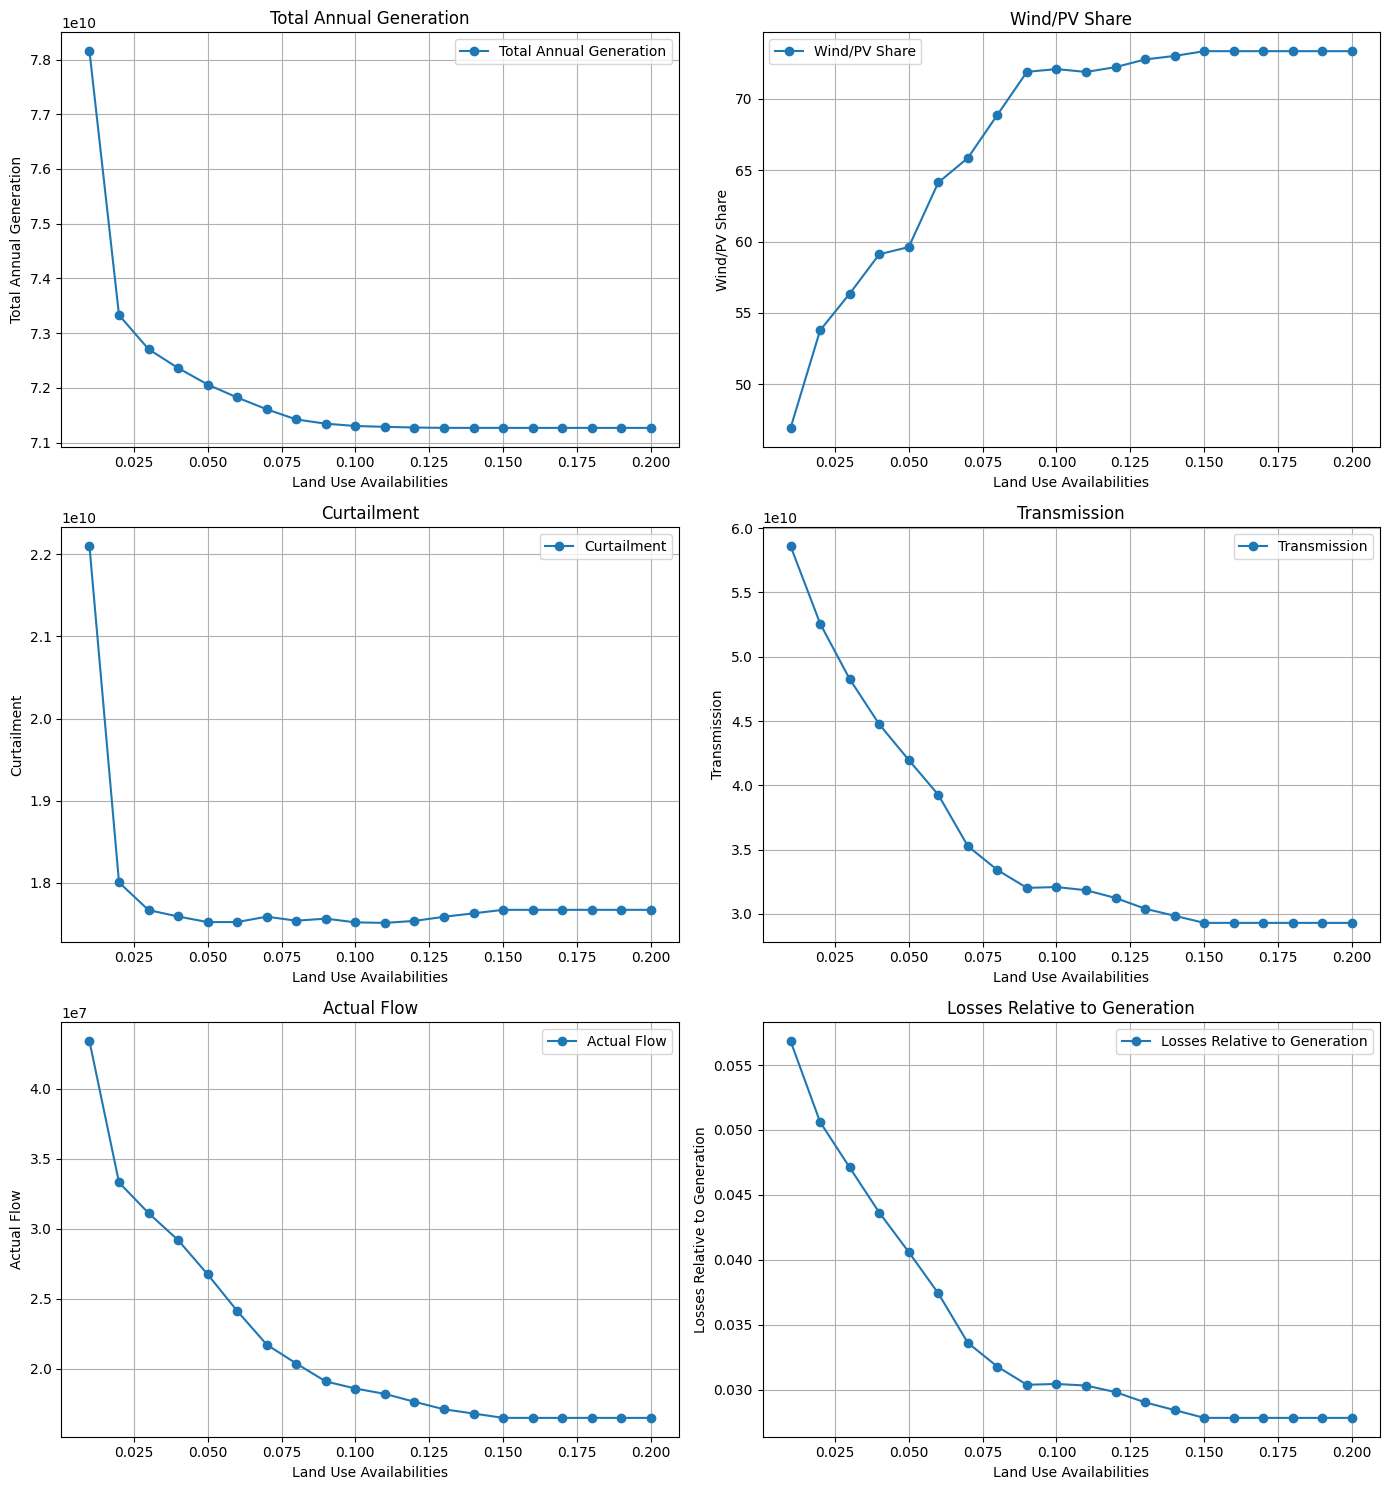

In [10]:
# Prepare data for plotting
metrics = {
    'Total Annual Generation': generation_list,
    'Wind/PV Share': [wind for wind, pv in wind_pv_share_list],  # wind share
    'Curtailment': curtailment_list,
    'Transmission': transmission_list,
    'Actual Flow': actual_flow_list,
    'Losses Relative to Generation': losses_list
}

# Number of metrics
num_metrics = len(metrics)
num_cols = 2
num_rows = (num_metrics + 1) // num_cols  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each metric
for i, (metric_name, metric_data) in enumerate(metrics.items()):
    ax = axes[i]
    ax.plot(land_use_availabilities, metric_data, marker='o', linestyle='-', label=metric_name)
    ax.set_title(metric_name)
    ax.set_xlabel('Land Use Availabilities')
    ax.set_ylabel(metric_name)
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

## Overview of grid 

In [171]:
wind_share = total_annual_wind / total_annual_gen * 100
pv_share = 100 - wind_share
print('NO TRANSMISSION COST')
print(f'Total generation: {total_annual_gen:.2e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total curtailment: {total_annual_cur:.2e}')
print(f'Total transmission: {total_annual_p_trans:.2e}')
print(f'Total net transmission: {total_actual_flow_int:.2e}')
print(f'Total transmission losses: {round(annual_losses_rel_to_gen, 3)}')

NO TRANSMISSION COST
Total generation: 7.14e+10
Wind: 68.9 PV: 31.1
Total curtailment: 1.75e+10
Total transmission: 3.34e+10
Total net transmission: 2.04e+07
Total transmission losses: 0.032


## Plotting of monthly regional data

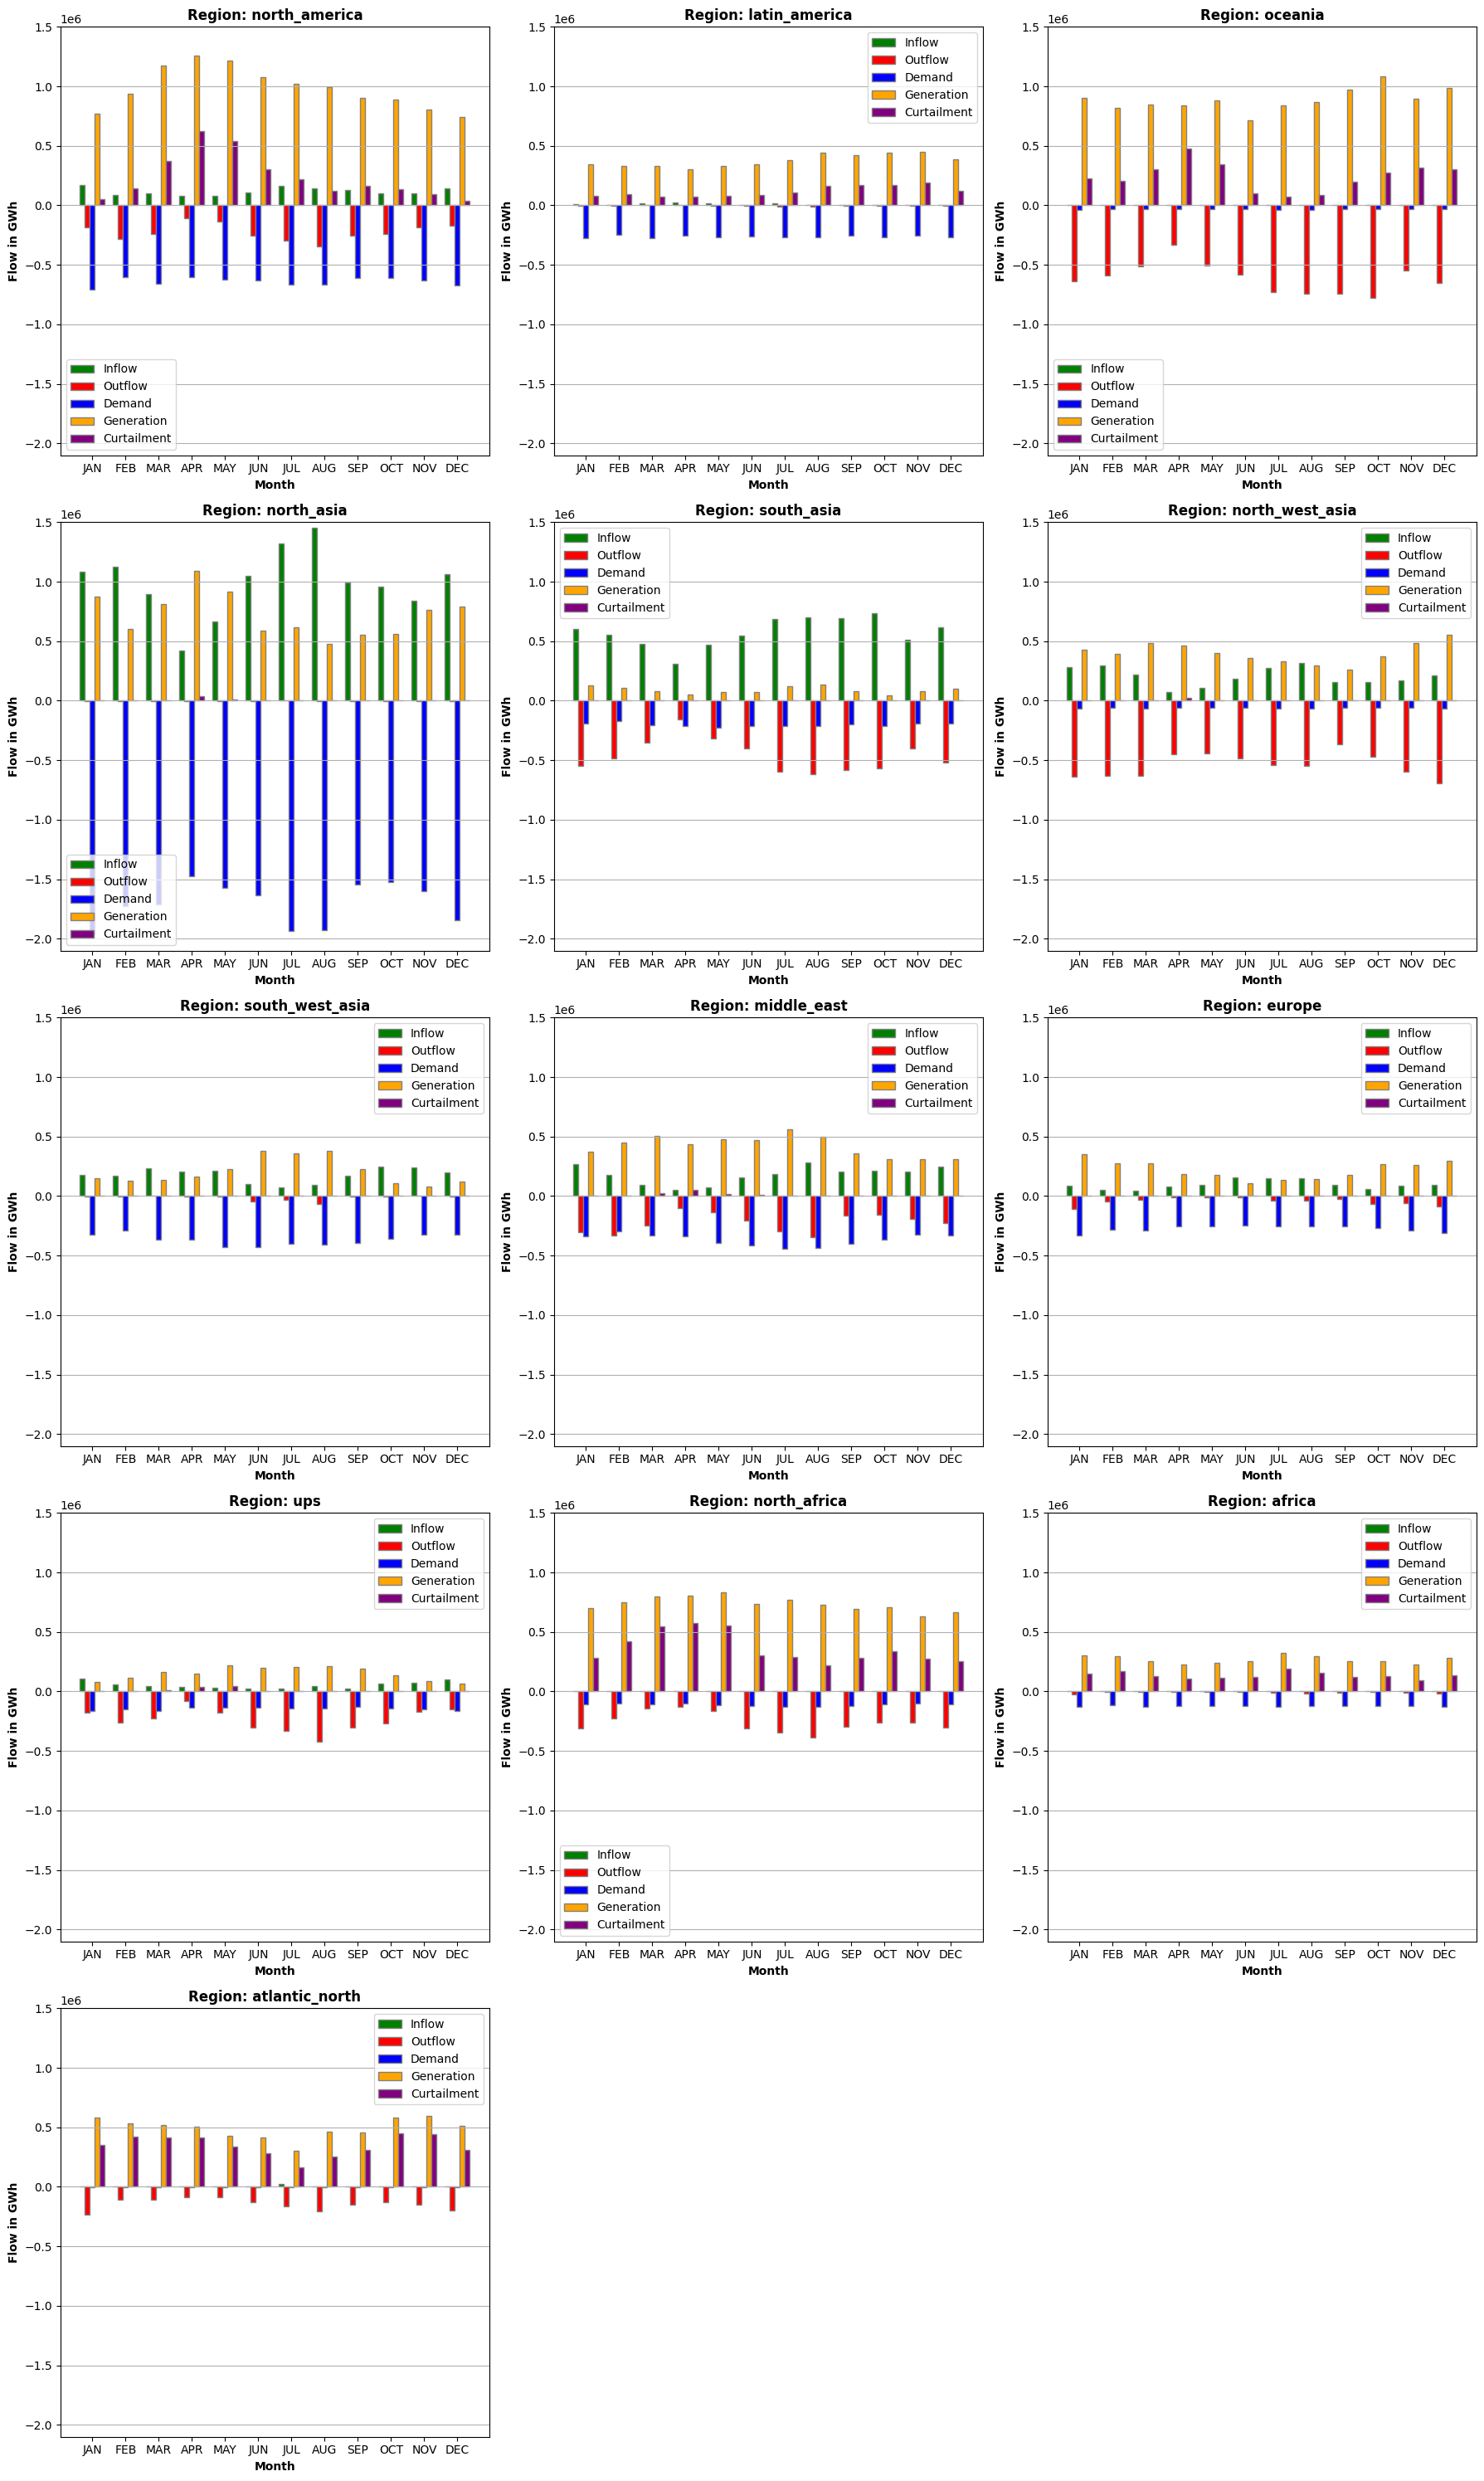

In [173]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

def plot_region_monthly_data(region_key, region_value, ax):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period] for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period]) for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    bar_width = 0.15
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    ax.grid(False)
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_ylim(-2.1e6, 1.5e6)
    ax.set_title(f'Region: {region_key}', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.grid(True, axis='y')
    ax.legend()

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_region_monthly_data(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


## Tornado plot of annual regional data in 

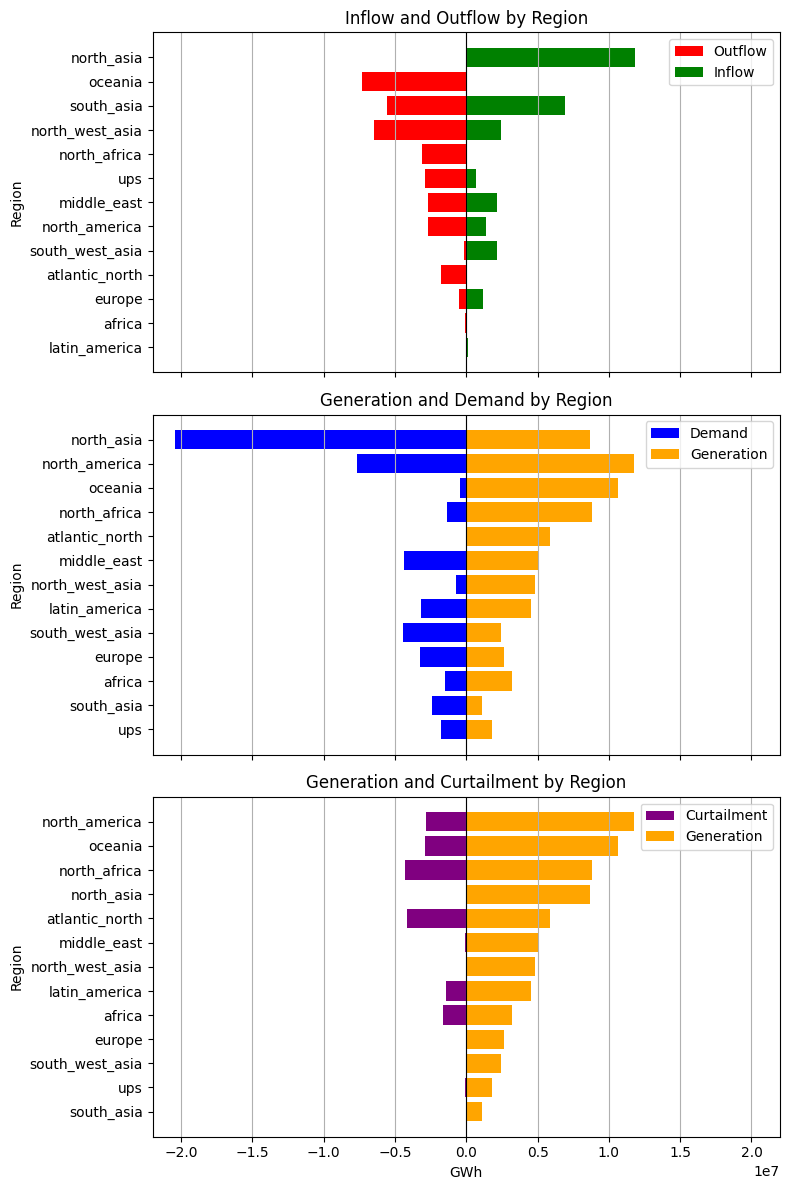

In [174]:
inflow_outflow_data = [
    (region_key, region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_demand_data = [
    (region_key, region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_load_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key, region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] for item in inflow_outflow_data]
outflows = [item[2] for item in inflow_outflow_data]

regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_inflow_outflow, [-outflow for outflow in outflows], color='red', label='Outflow')
axs[0].barh(regions_inflow_outflow, inflows, color='green', label='Inflow')
axs[0].axvline(x=0, color='black', linewidth=0.8)
axs[0].set_xlim(-2.2e7, 2.2e7)
axs[0].set_ylabel('Region')
axs[0].set_title('Inflow and Outflow by Region')
axs[0].grid(True, axis='x')
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[1].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
axs[1].set_xlim(-2.2e7, 2.2e7)
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Demand by Region')
axs[1].grid(True, axis='x')
axs[1].legend()
axs[1].invert_yaxis()

axs[2].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[2].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[2].axvline(x=0, color='black', linewidth=0.8)
axs[2].set_xlim(-2.2e7, 2.2e7)
axs[2].set_xlabel('GWh')
axs[2].set_ylabel('Region')
axs[2].set_title('Generation and Curtailment by Region')
axs[2].grid(True, axis='x')
axs[2].legend()
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()


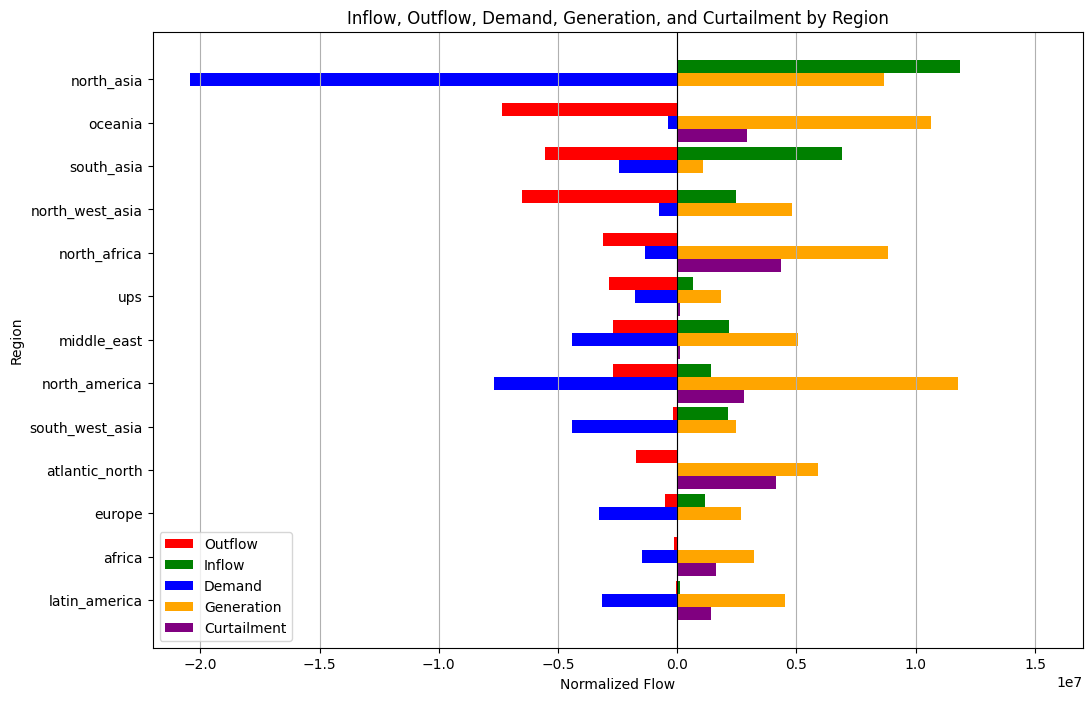

In [175]:
regions_data = [
    (
        region_key,
        region_value['inflow'],  
        region_value['outflow'],  
        region_value['total_load_yearly'],  
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  
        region_value['total_curtailment_yearly'], 
        max(
            abs(region_value['inflow']),
            abs(region_value['outflow'])
        ) 
    )
    for region_key, region_value in regions_dic.items()
]

regions_data.sort(key=lambda x: x[6], reverse=False)

regions = [item[0] for item in regions_data]
inflows = [item[1] for item in regions_data]
outflows = [item[2] for item in regions_data]
loads = [item[3] for item in regions_data]
generations = [item[4] for item in regions_data]
curtailments = [item[5] for item in regions_data]

fig, ax = plt.subplots(figsize=(12, 8))

y_positions = range(len(regions))

ax.barh([y + 0.3 for y in y_positions], [-outflow for outflow in outflows], color='red', label='Outflow', height=0.3)
ax.barh([y + 0.3 for y in y_positions], inflows, color='green', label='Inflow', height=0.3)
ax.barh([y for y in y_positions], [-load for load in loads], color='blue', label='Demand', height=0.3)
ax.barh([y for y in y_positions], generations, color='orange', label='Generation', height=0.3)
ax.barh([y - 0.3 for y in y_positions], curtailments, color='purple', label='Curtailment', height=0.3)

ax.axvline(x=0, color='black', linewidth=0.8)

ax.grid(False, axis='y')
ax.grid(True, axis='x')

ax.set_xlabel('Normalized Flow')
ax.set_xlim(-2.2e7, 1.7e7)
ax.set_ylabel('Region')
ax.set_title('Inflow, Outflow, Demand, Generation, and Curtailment by Region')
ax.set_yticks([y for y in y_positions])
ax.set_yticklabels(regions)
ax.legend()

plt.show()


## Spyder diagramms of annual regional data

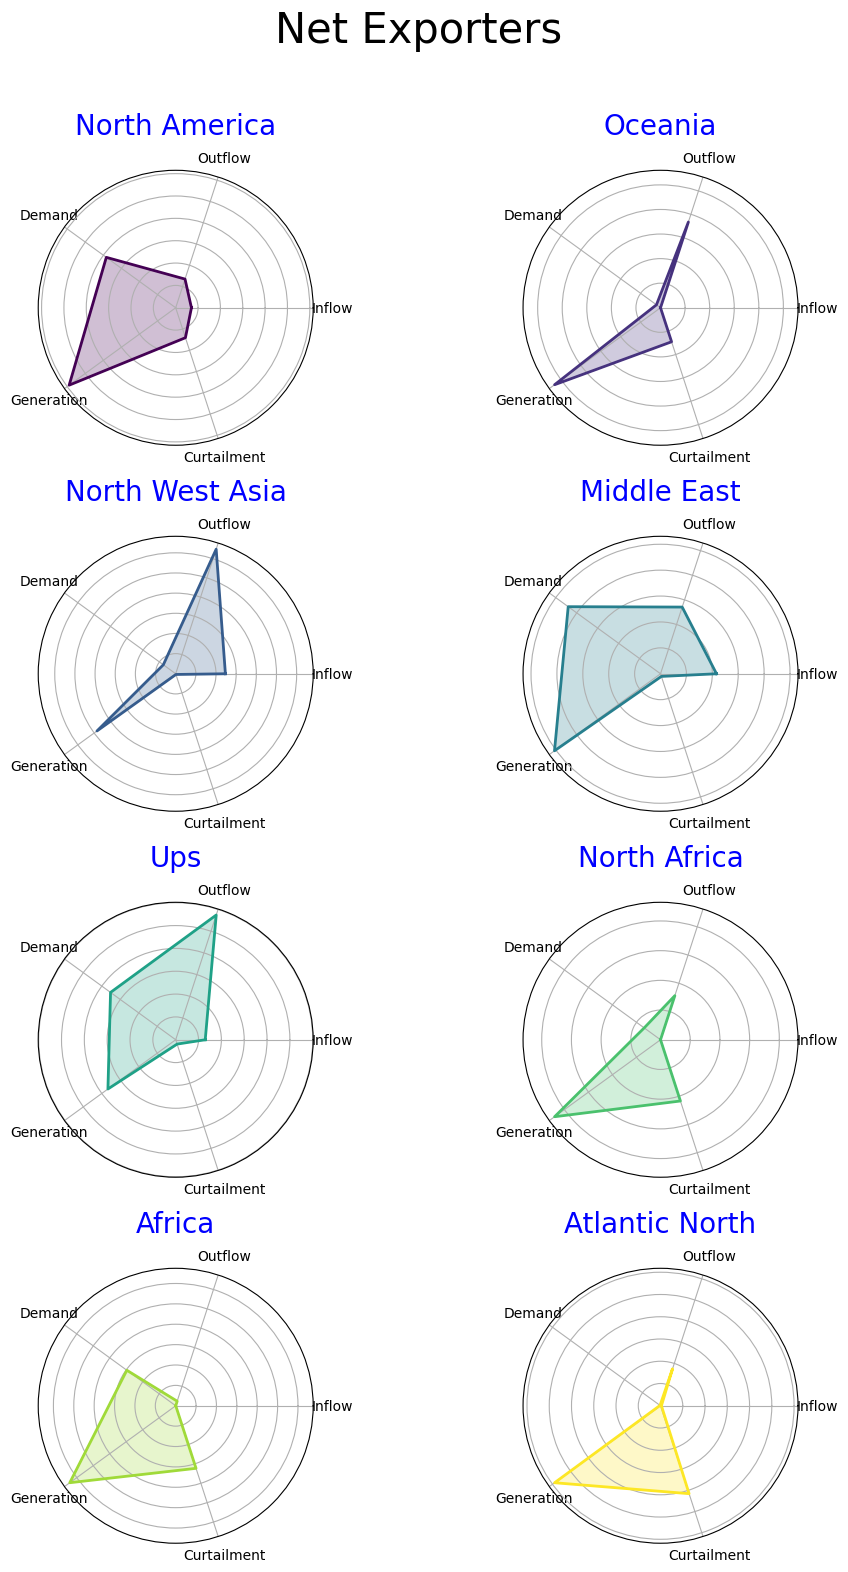

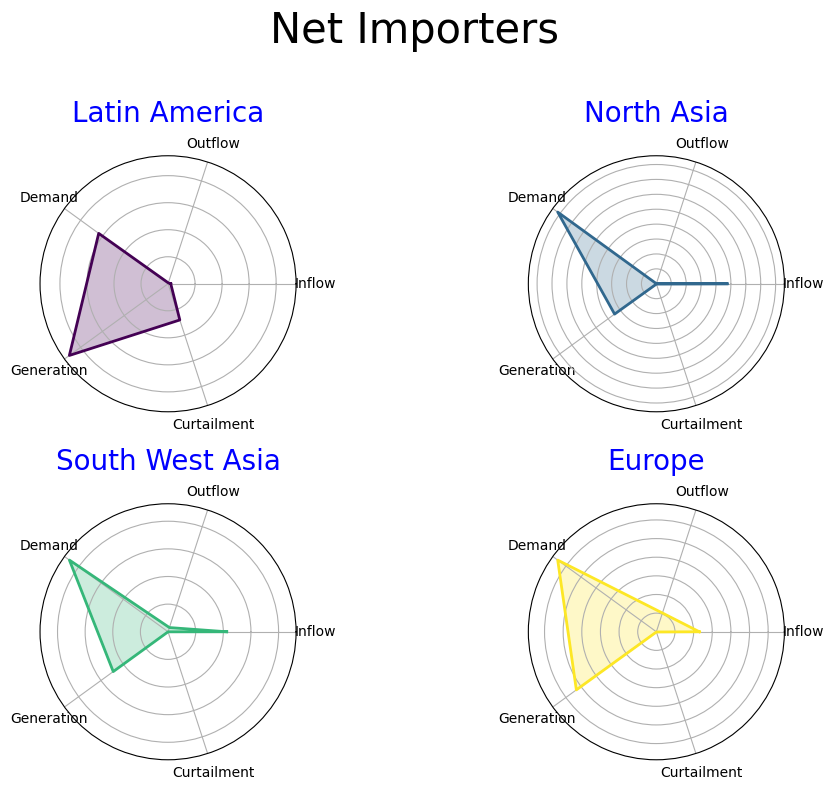

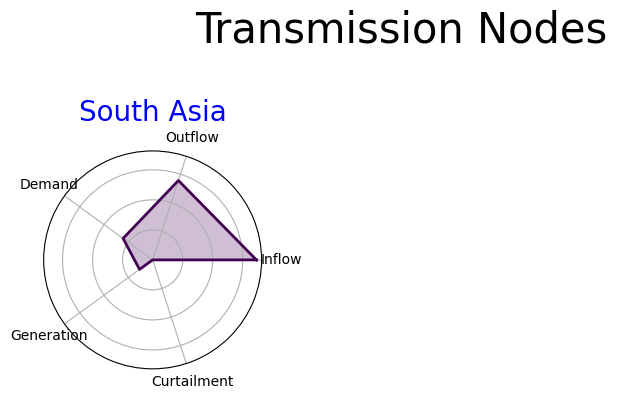

In [176]:
data = {
    region_key: [
        region_value['inflow'],  # Normalize to generation
        region_value['outflow'],  # Normalize to generation
        (region_value['total_load_yearly']),  # Normalize to generation
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  # Generation normalized to itself
        region_value['total_curtailment_yearly']  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']
df = pd.DataFrame(data, index=variables)

tolerance = 0.25
exporters = []
importers = []
transmission_nodes = []

for region in df.columns:
    inflow = df[region]['Inflow']
    outflow = df[region]['Outflow']
    if inflow > outflow * (1 + tolerance):
        importers.append(region)
    elif outflow > inflow * (1 + tolerance):
        exporters.append(region)
    elif inflow != 0 and outflow != 0 and abs(inflow - outflow) <= tolerance * max(inflow, outflow):
        transmission_nodes.append(region)

def plot_radar_charts(regions, title):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    num_regions = len(regions)
    n_cols = 2
    n_rows = (num_regions + 1) // n_cols

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4 * n_rows), subplot_kw=dict(polar=True))
    axs = axs.flatten()
    colors = plt.cm.viridis(np.linspace(0, 1, num_regions))

    for i, (region, color) in enumerate(zip(regions, colors)):
        values = df[region].tolist()
        values += values[:1]
        ax = axs[i]
        ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
        ax.fill(angles, values, color=color, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(variables)
        ax.set_yticklabels([])
        formatted_title = format_title(region)
        ax.set_title(formatted_title, size=20, color='blue', y=1.1)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.suptitle(title, size=30, color='black')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def format_title(title):
    return ' '.join(word.capitalize() for word in title.split('_'))

plot_radar_charts(exporters, 'Net Exporters')
plot_radar_charts(importers, 'Net Importers')

if transmission_nodes:
    plot_radar_charts(transmission_nodes, 'Transmission Nodes')


## Chord diagram of netflows 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
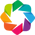

:Chord   [source,target]   (value)

In [47]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')
hv.output(size=200)
# Calculate total flow for each link and store in data frame
link_flow_data = []
for link_key, link_value in links_dic.items():
    p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
    p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
    sum_p0_0 = abs(sum(p0_0))
    sum_p0_1 = abs(sum(p0_1))
    net_flow = sum_p0_0 - sum_p0_1
    if net_flow > 0:
        bus0 = link_value["bus0"][1]
        bus1 = link_value["bus1"][1]
    else:
        bus0 = link_value["bus1"][1]
        bus1 = link_value["bus0"][1]
    link_flow_data.append((bus0, bus1, abs(net_flow)))
links = pd.DataFrame(link_flow_data, columns=['source', 'target', 'value'])

# Convert the keys of the dictionary to a list and create a DataFrame
regions_df = pd.DataFrame(list(regions_dic.keys()), columns=['index'])

# Create a Dataset for nodes
nodes = hv.Dataset(regions_df, 'index')

chord = hv.Chord((links, nodes)).select(value=(100, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='index', node_color=dim('index').str()))

## Demand and supply graphs of each regions


north_america


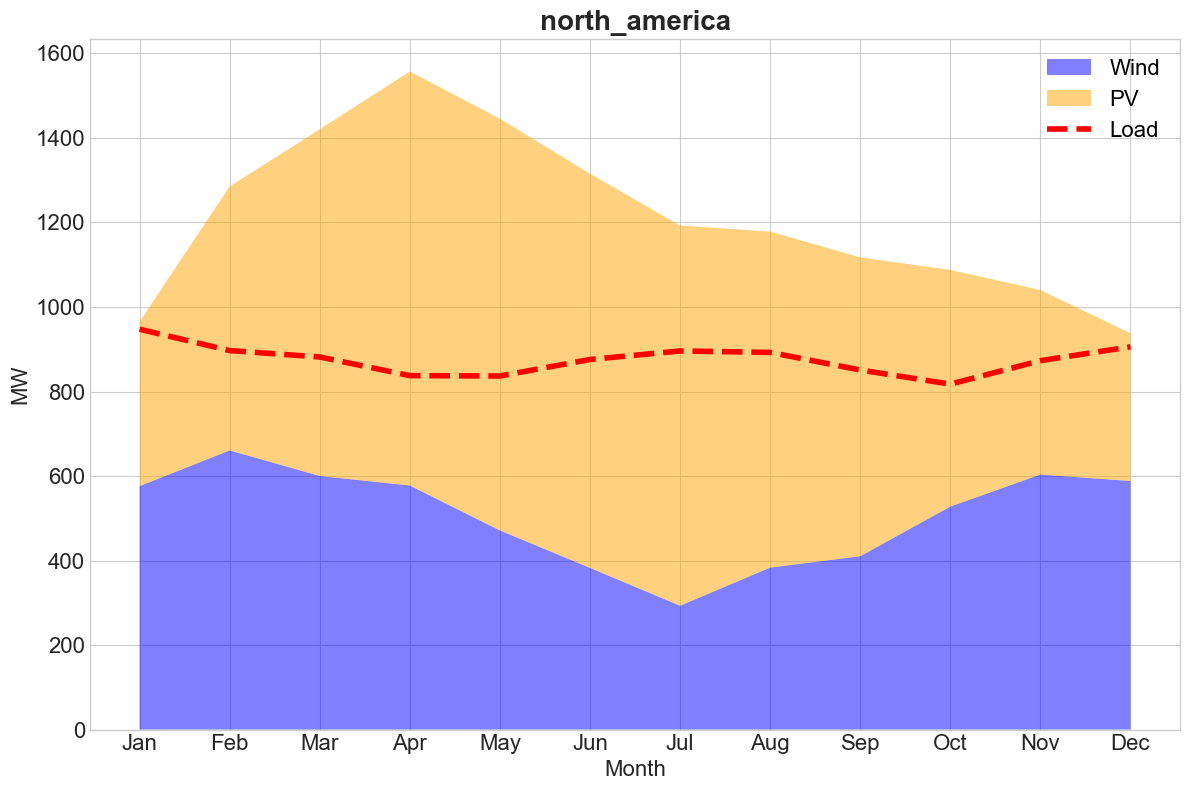

latin_america


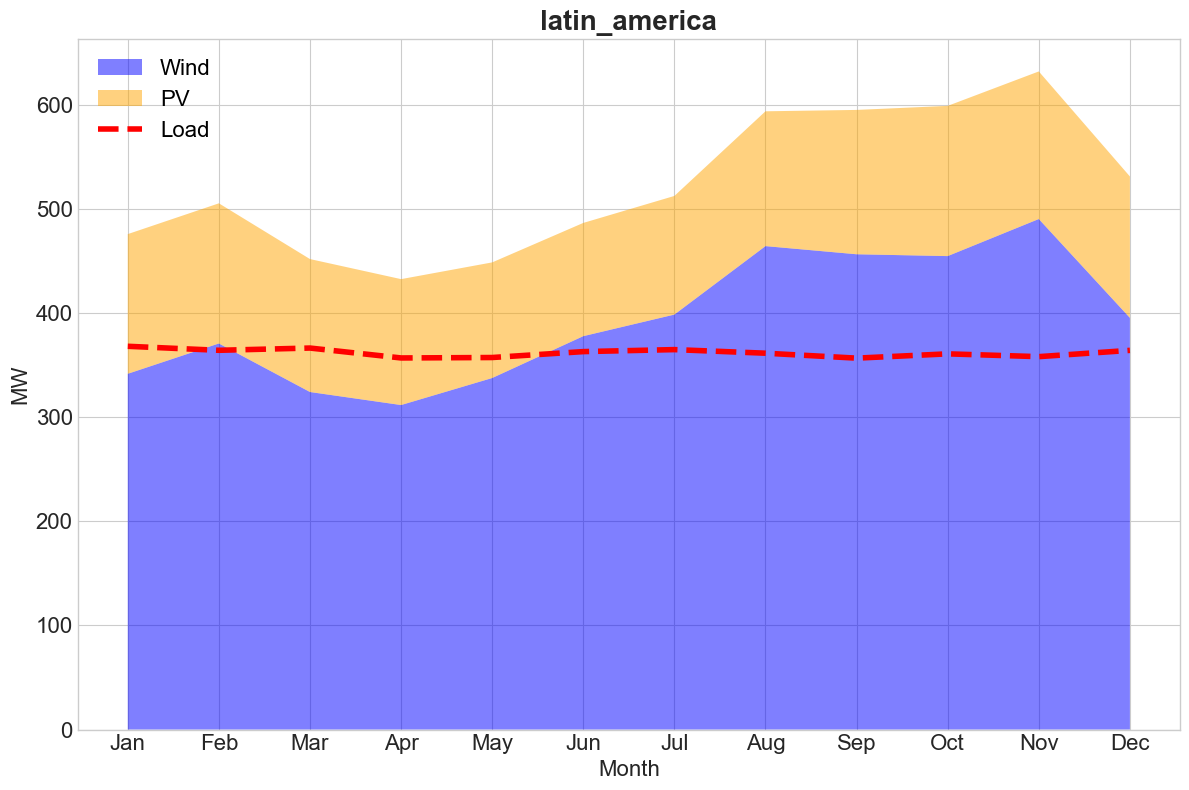

oceania


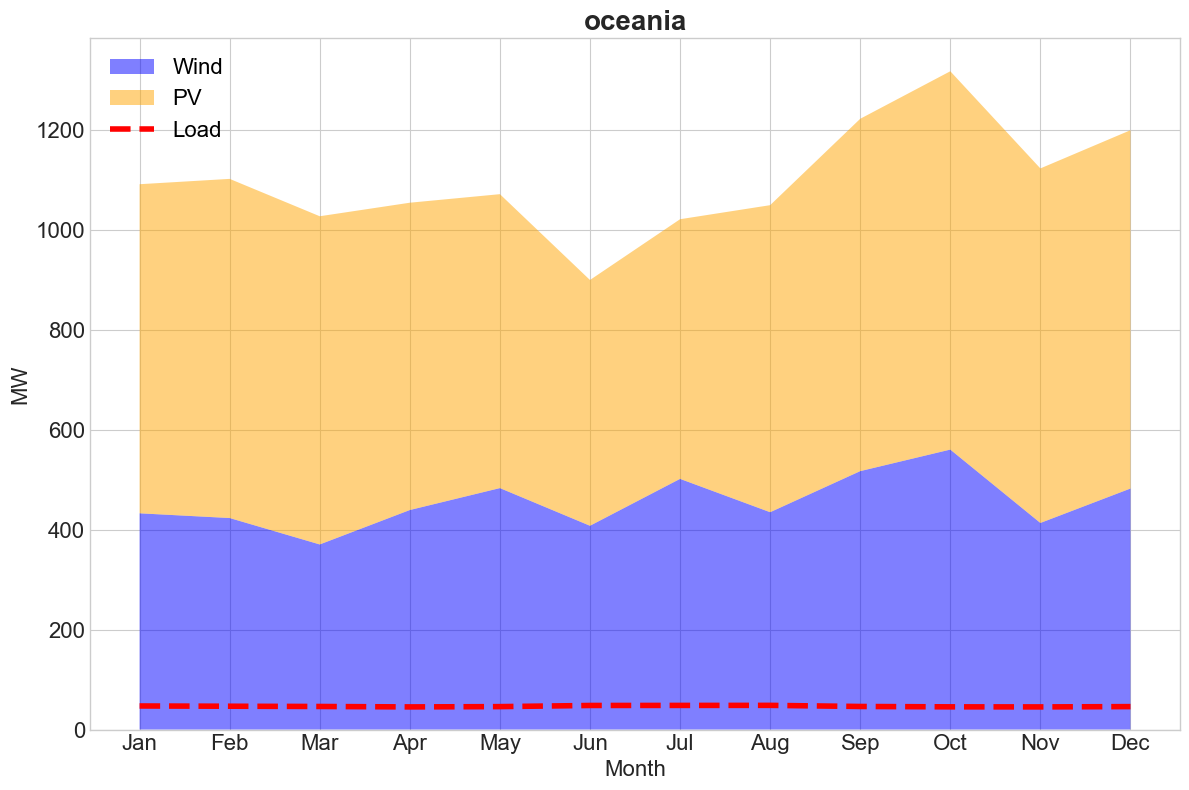

north_asia


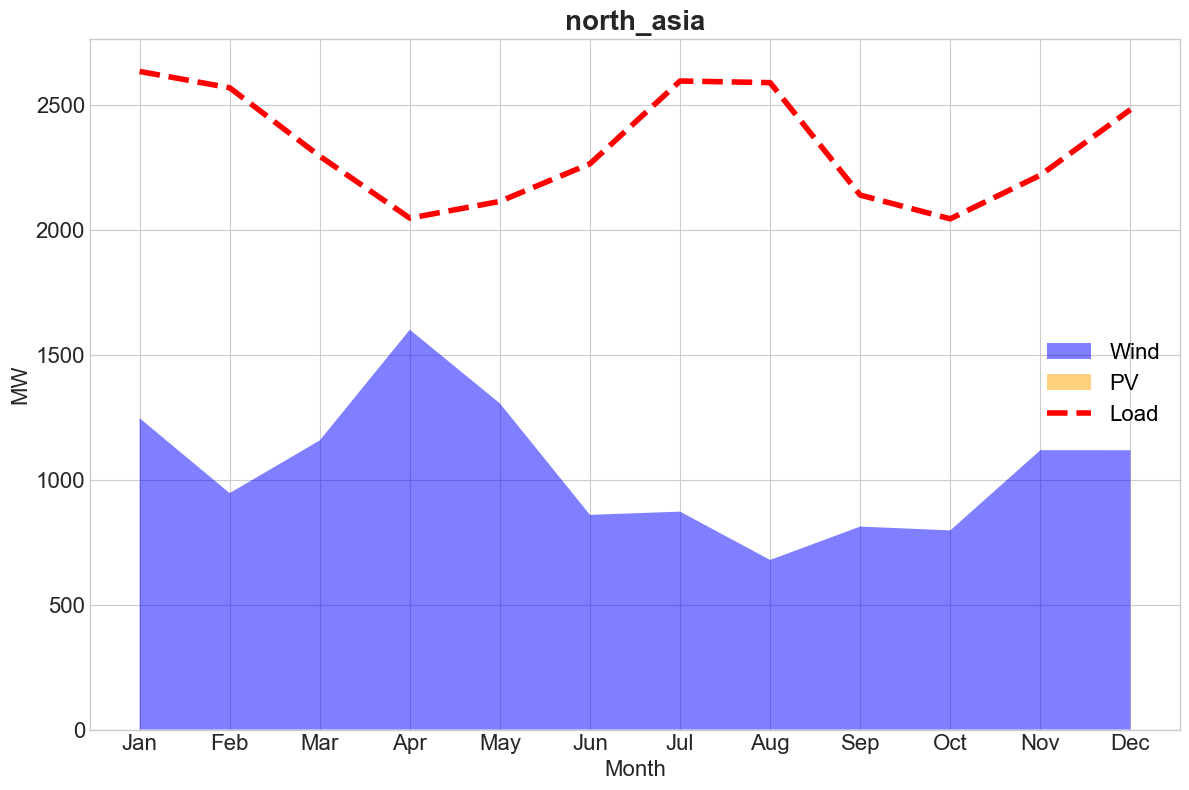

south_asia


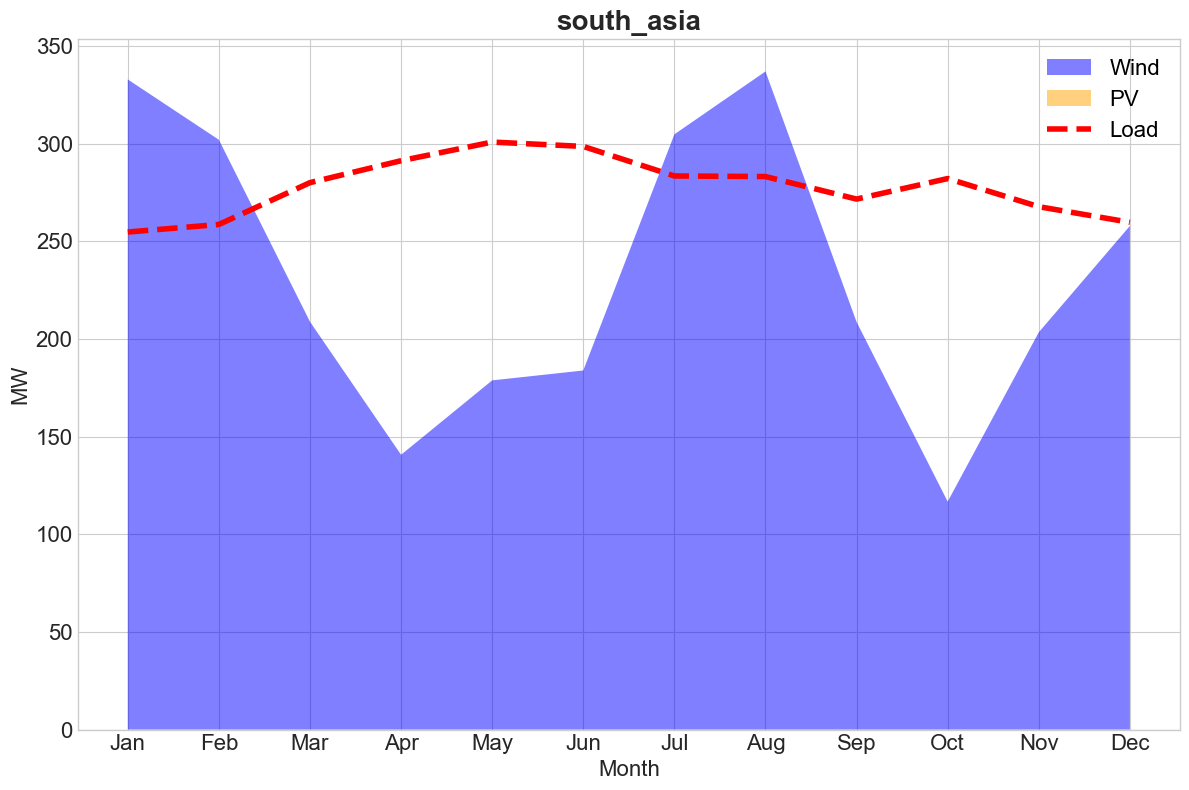

north_west_asia


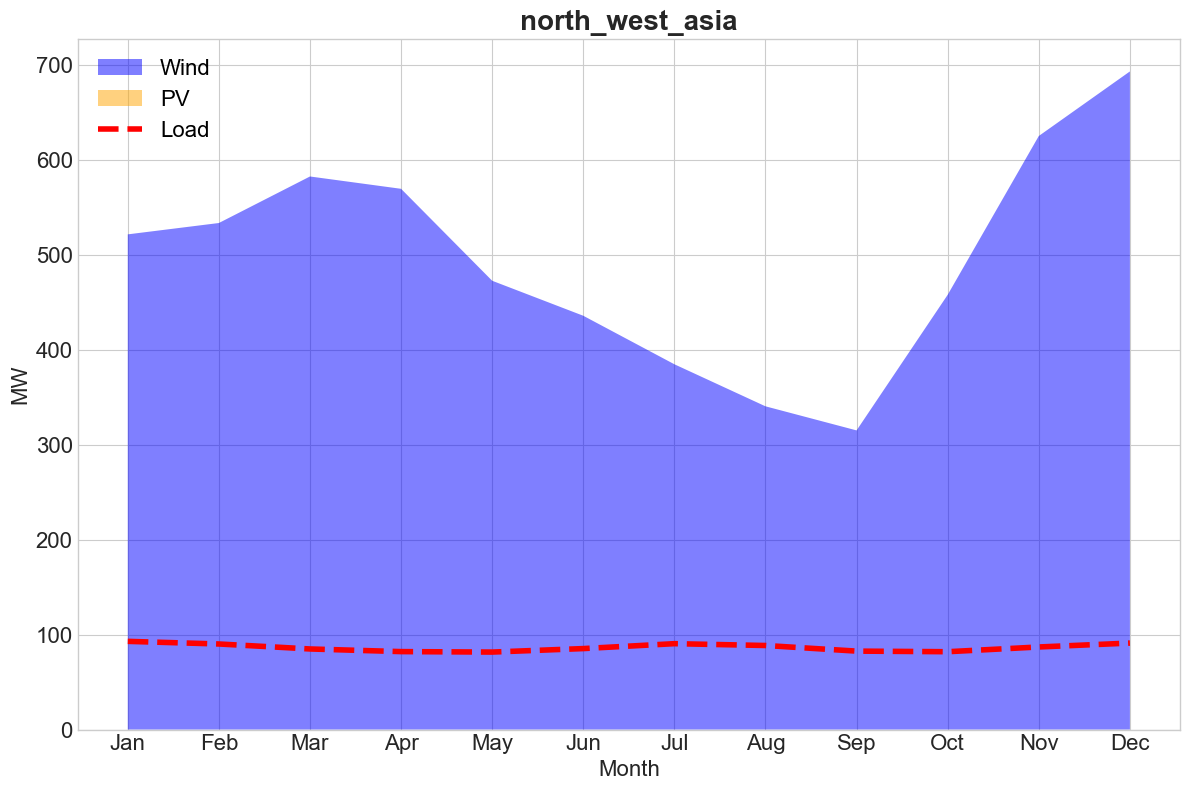

south_west_asia


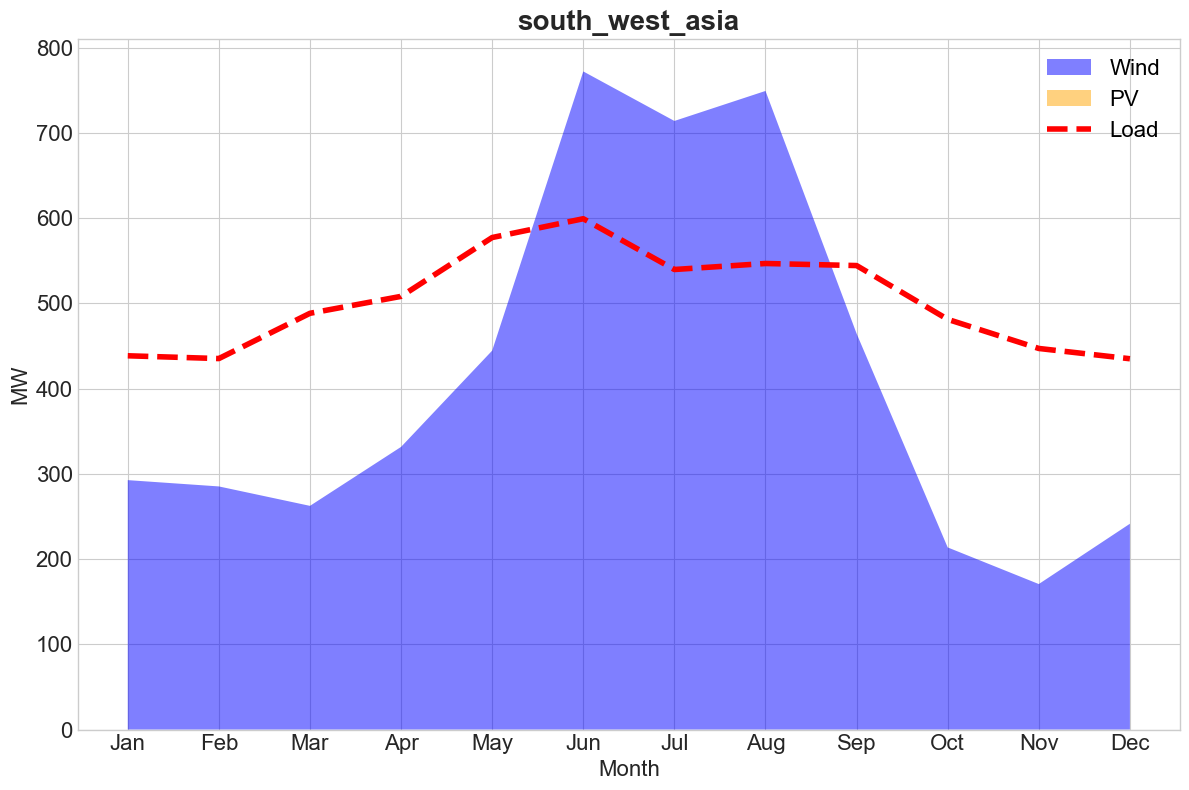

middle_east


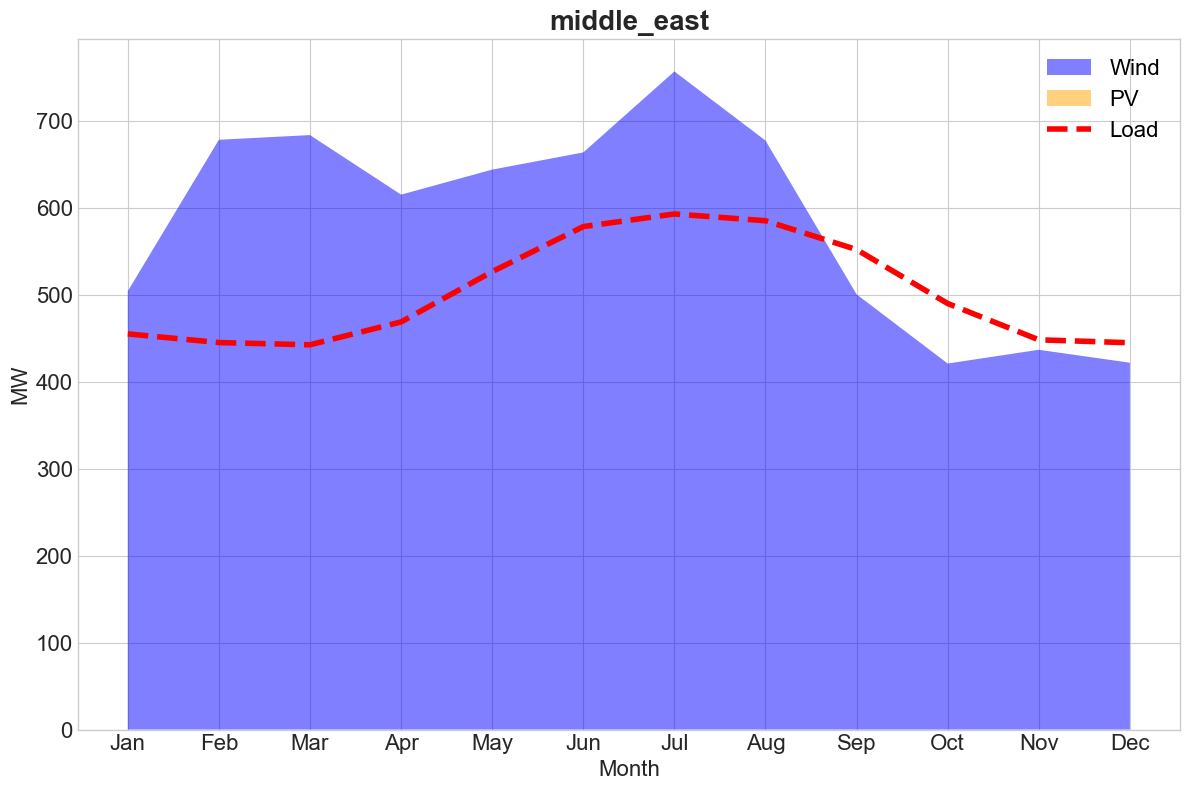

europe


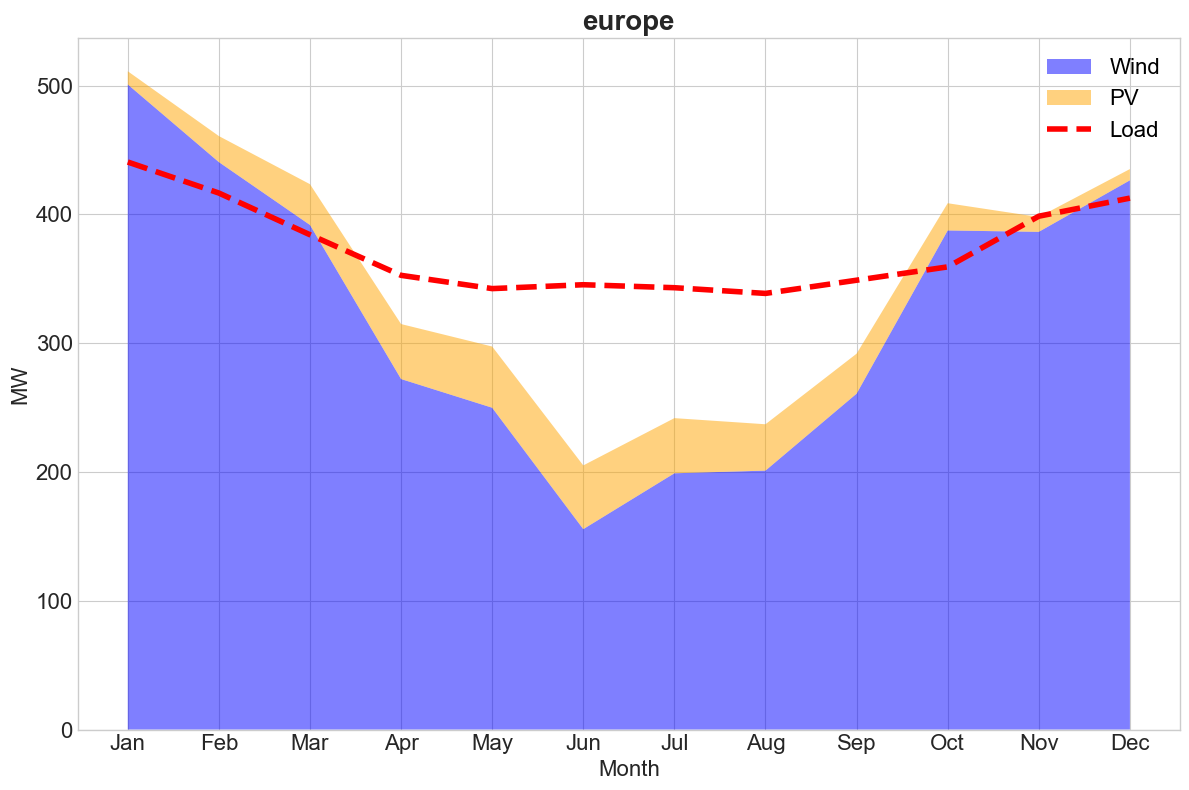

ups


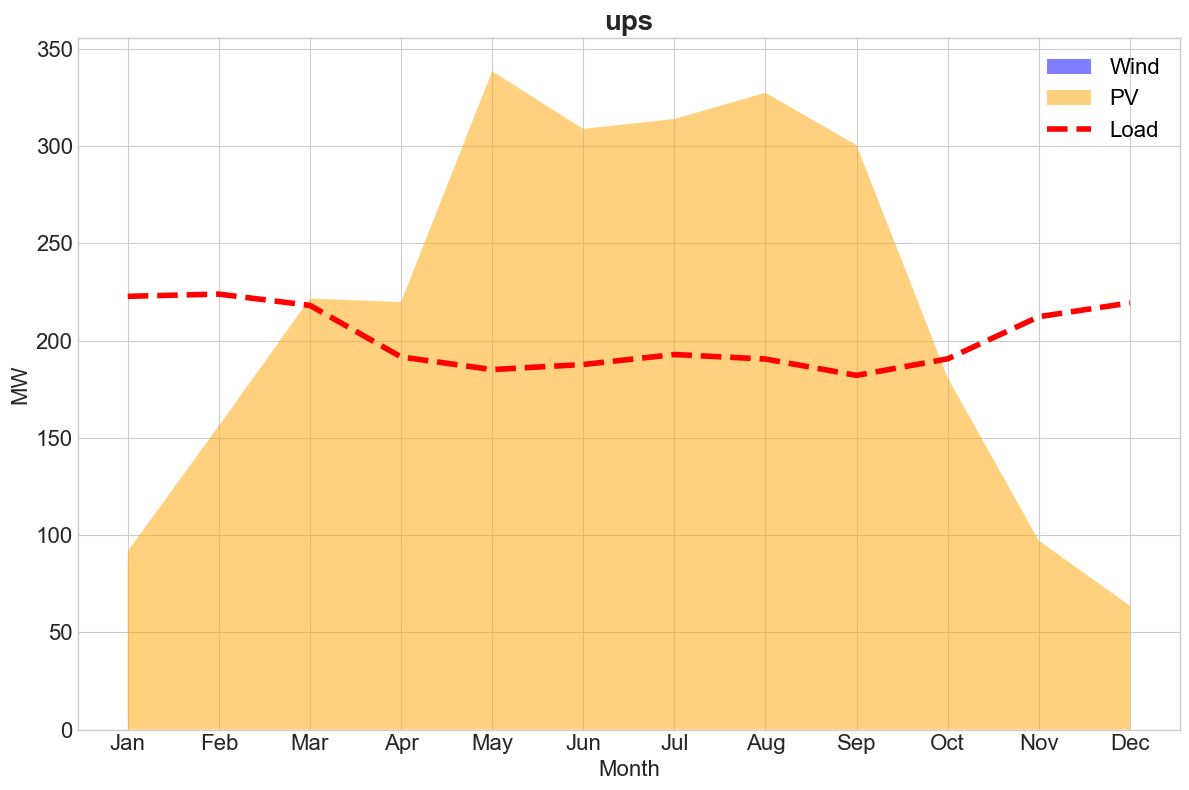

north_africa


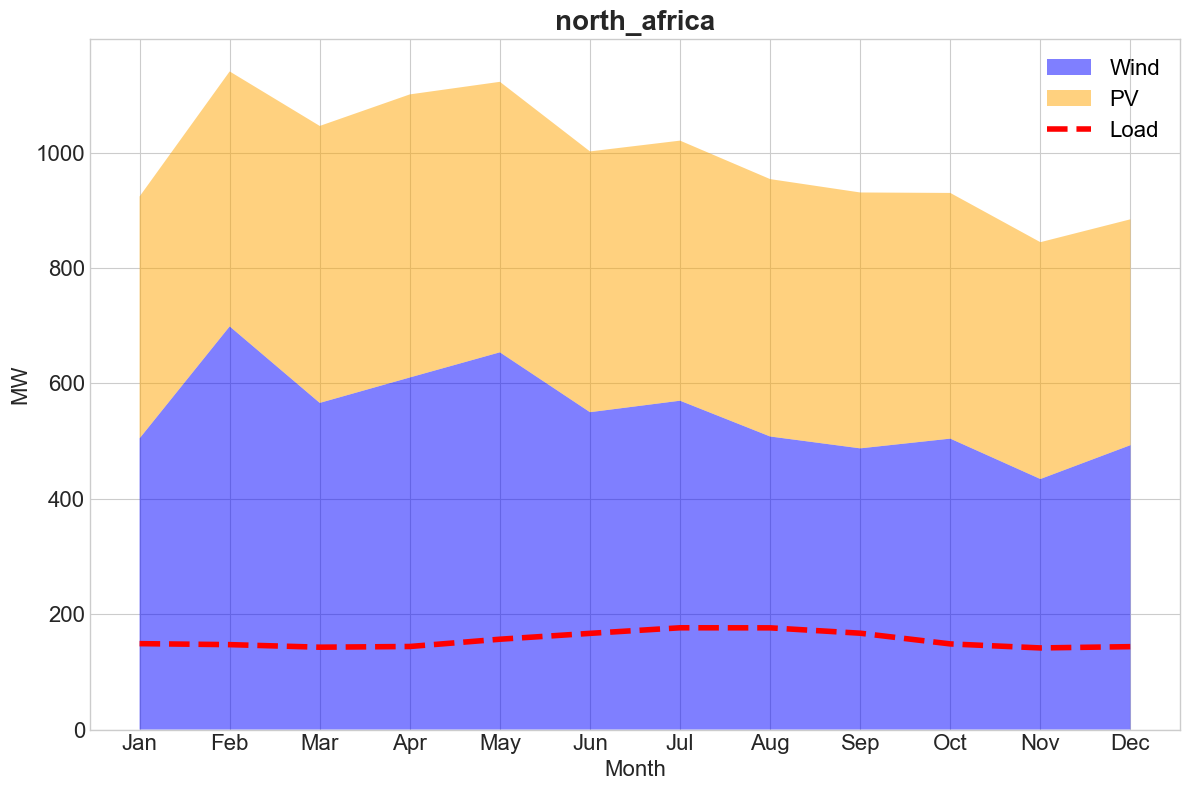

africa


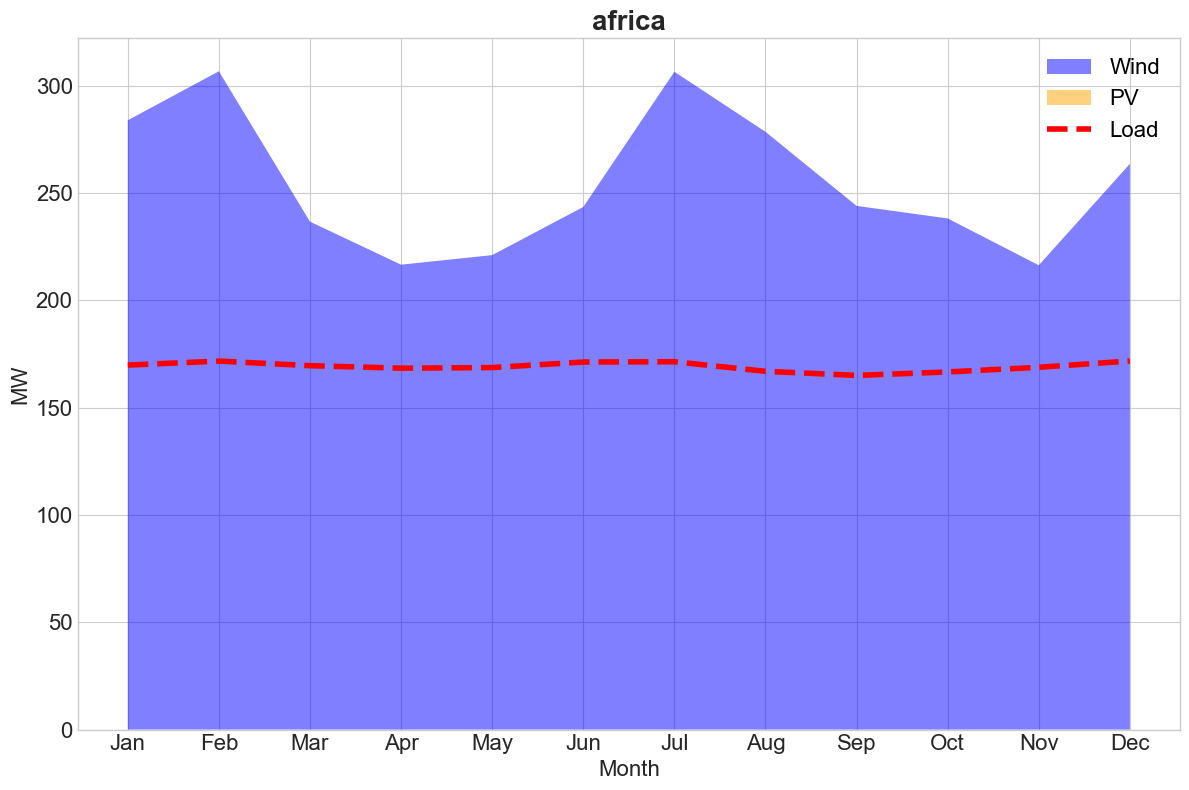

atlantic_north


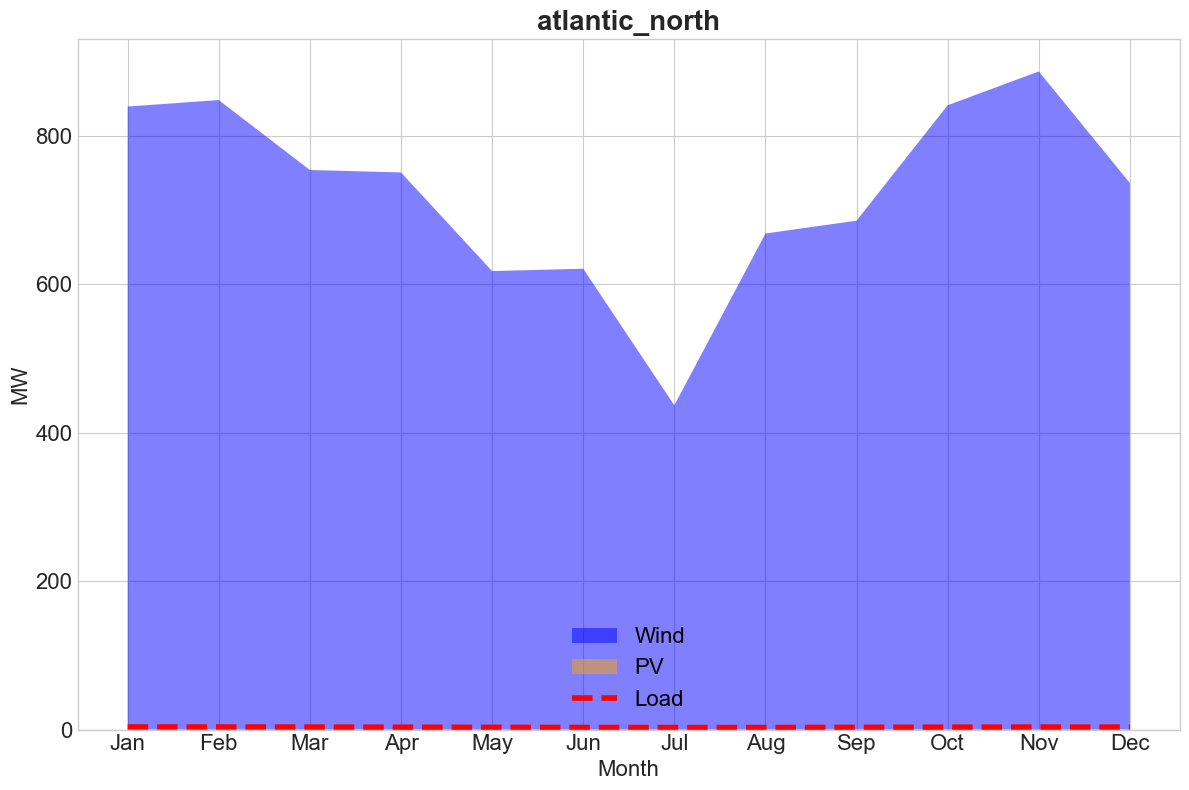

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability
# Plot line plots for Demand and Curtailment
# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-', marker='o')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Month', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('Energy Metrics', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.ylim(0, 7.1e9)
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold')  # Increase x-tick font size and labels
plt.yticks(fontsize=14, fontweight='bold')  # Increase y-tick font size

plt.tight_layout()  # Adjust layout to fit elements better
plt.show()

# Stochastic analysis

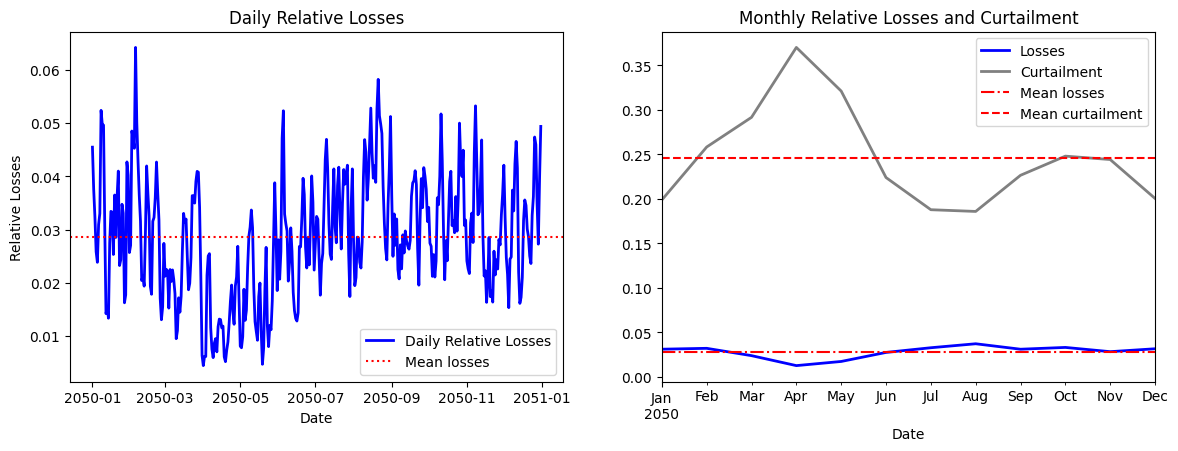

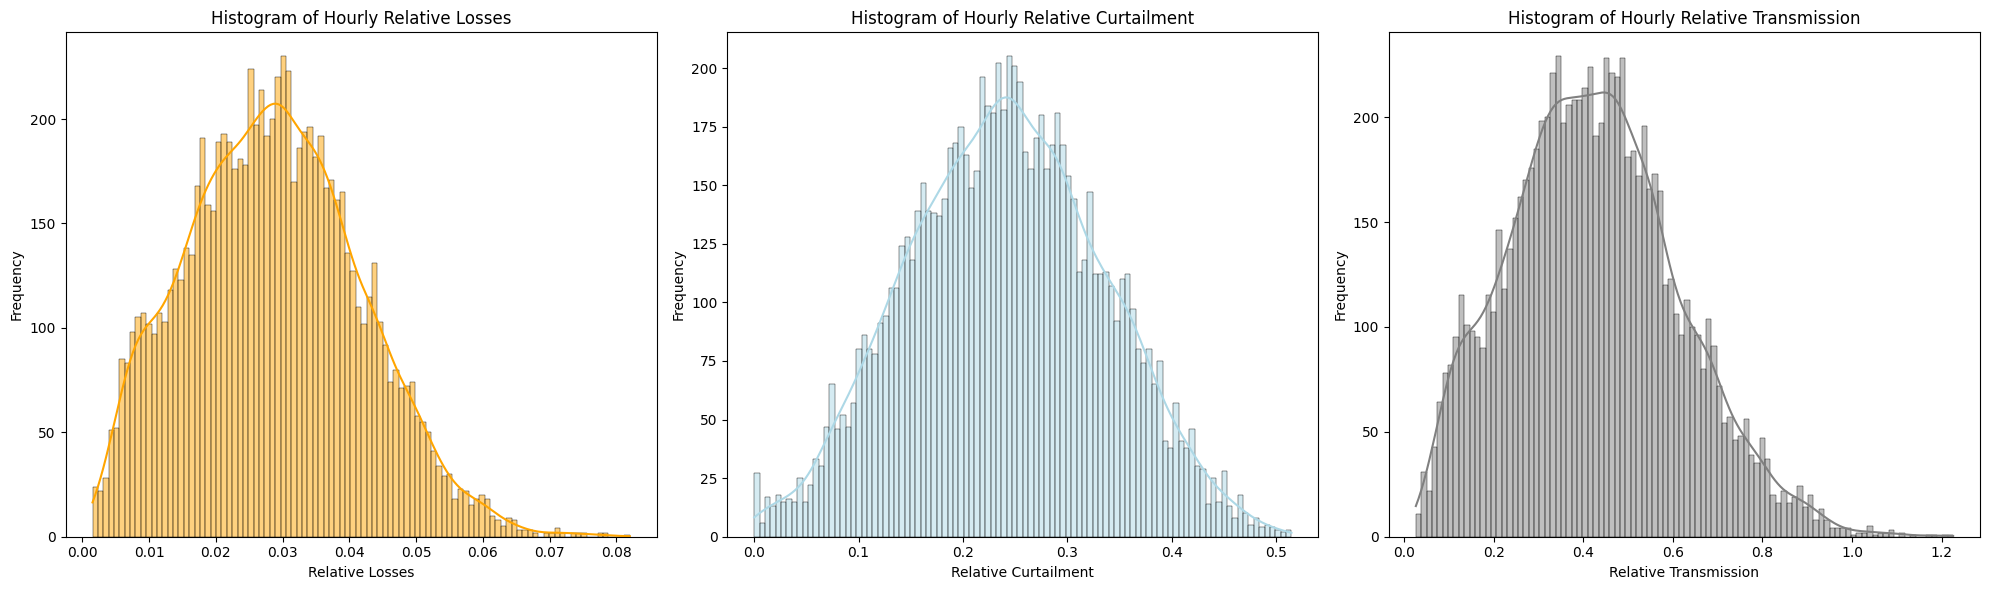

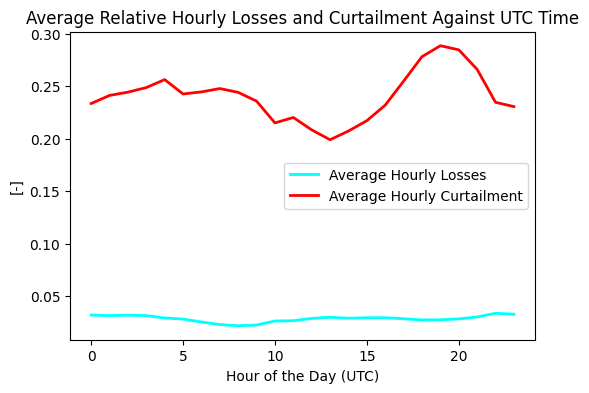

In [73]:
# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))

# Daily Relative Losses
plt.subplot(2, 2, 1)
daily_losses_rel_to_gen.plot(label='Daily Relative Losses', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=daily_losses_rel_to_gen.mean(), color='red', linestyle=':', label='Mean losses')
plt.title('Daily Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_gen.plot(label='Losses', color='blue', linewidth=2)
monthly_cur_rel_to_gen.plot(label='Curtailment', color='gray', linestyle='-', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_gen.mean(), color='red', linestyle='-.', label='Mean losses')
plt.axhline(y=monthly_cur_rel_to_gen.mean(), color='red', linestyle='--', label='Mean curtailment')
plt.title('Monthly Relative Losses and Curtailment')
plt.xlabel('Date')
plt.legend()

plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.histplot(hourly_losses_rel_to_gen, bins=100, kde=True, color='orange')
plt.title('Histogram of Hourly Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(hourly_cur_rel_to_gen, bins=100, kde=True, color='lightblue')
plt.title('Histogram of Hourly Relative Curtailment')
plt.xlabel('Relative Curtailment')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(hourly_p_trans_rel_gen, bins=100, kde=True, color='gray')
plt.title('Histogram of Hourly Relative Transmission')
plt.xlabel('Relative Transmission')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Losses against UTC time
hourly_losses = hourly_losses_rel_to_gen.groupby(hourly_losses_rel_to_gen.index.hour).mean()
hourly_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour).mean()
plt.figure(figsize=(6, 4))
hourly_losses.plot(label='Average Hourly Losses', color='cyan', linewidth=2)
hourly_cur.plot(label='Average Hourly Curtailment', color='red', linewidth=2)
plt.title('Average Relative Hourly Losses and Curtailment Against UTC Time')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('[-]')
plt.legend()
plt.show()



## Correlation matrix

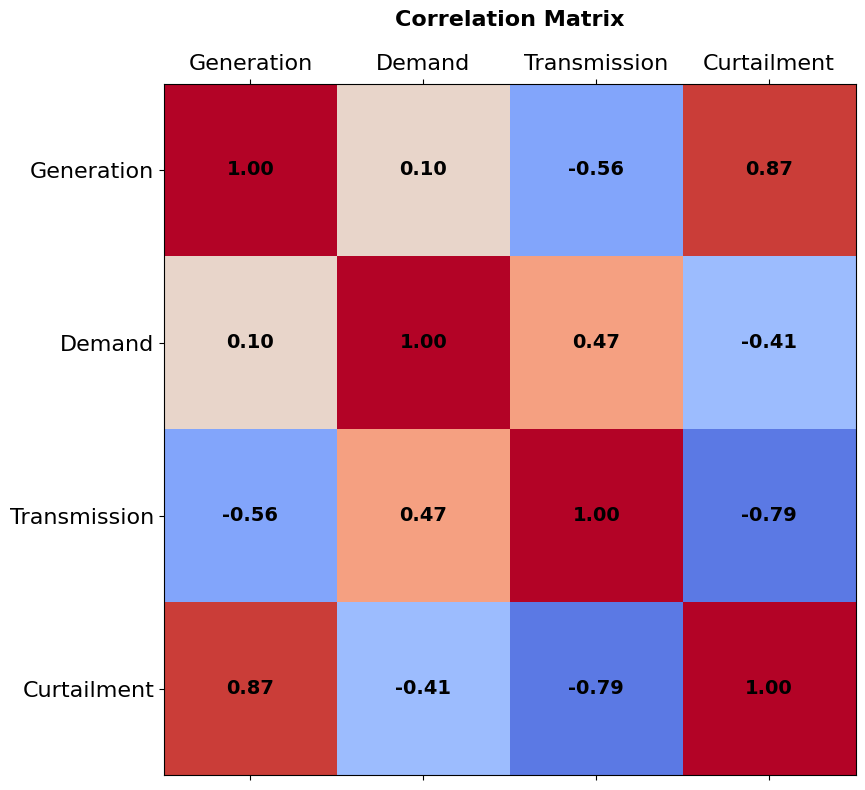

In [70]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Transmission': total_hourly_p_trans,
    'Curtailment': total_hourly_cur
    
})

# Calculate pairwise correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Display the matrix values with reversed colormap
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns, rotation=0, fontsize=16)
ax.set_yticklabels(correlation_matrix.index, fontsize=16)

# Add text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=14, fontweight='bold')

# Title and layout adjustments
plt.title('Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## Fourier Transform

### Global fourier transform

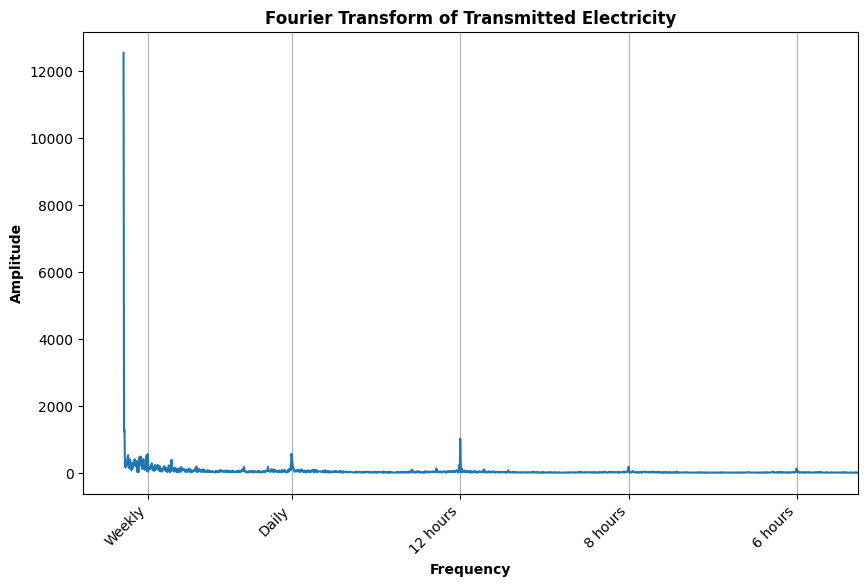

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
# Convert to numpy array
hourly_p_trans_rel_gen_array = total_actual_flow.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

### Regional fourier transform

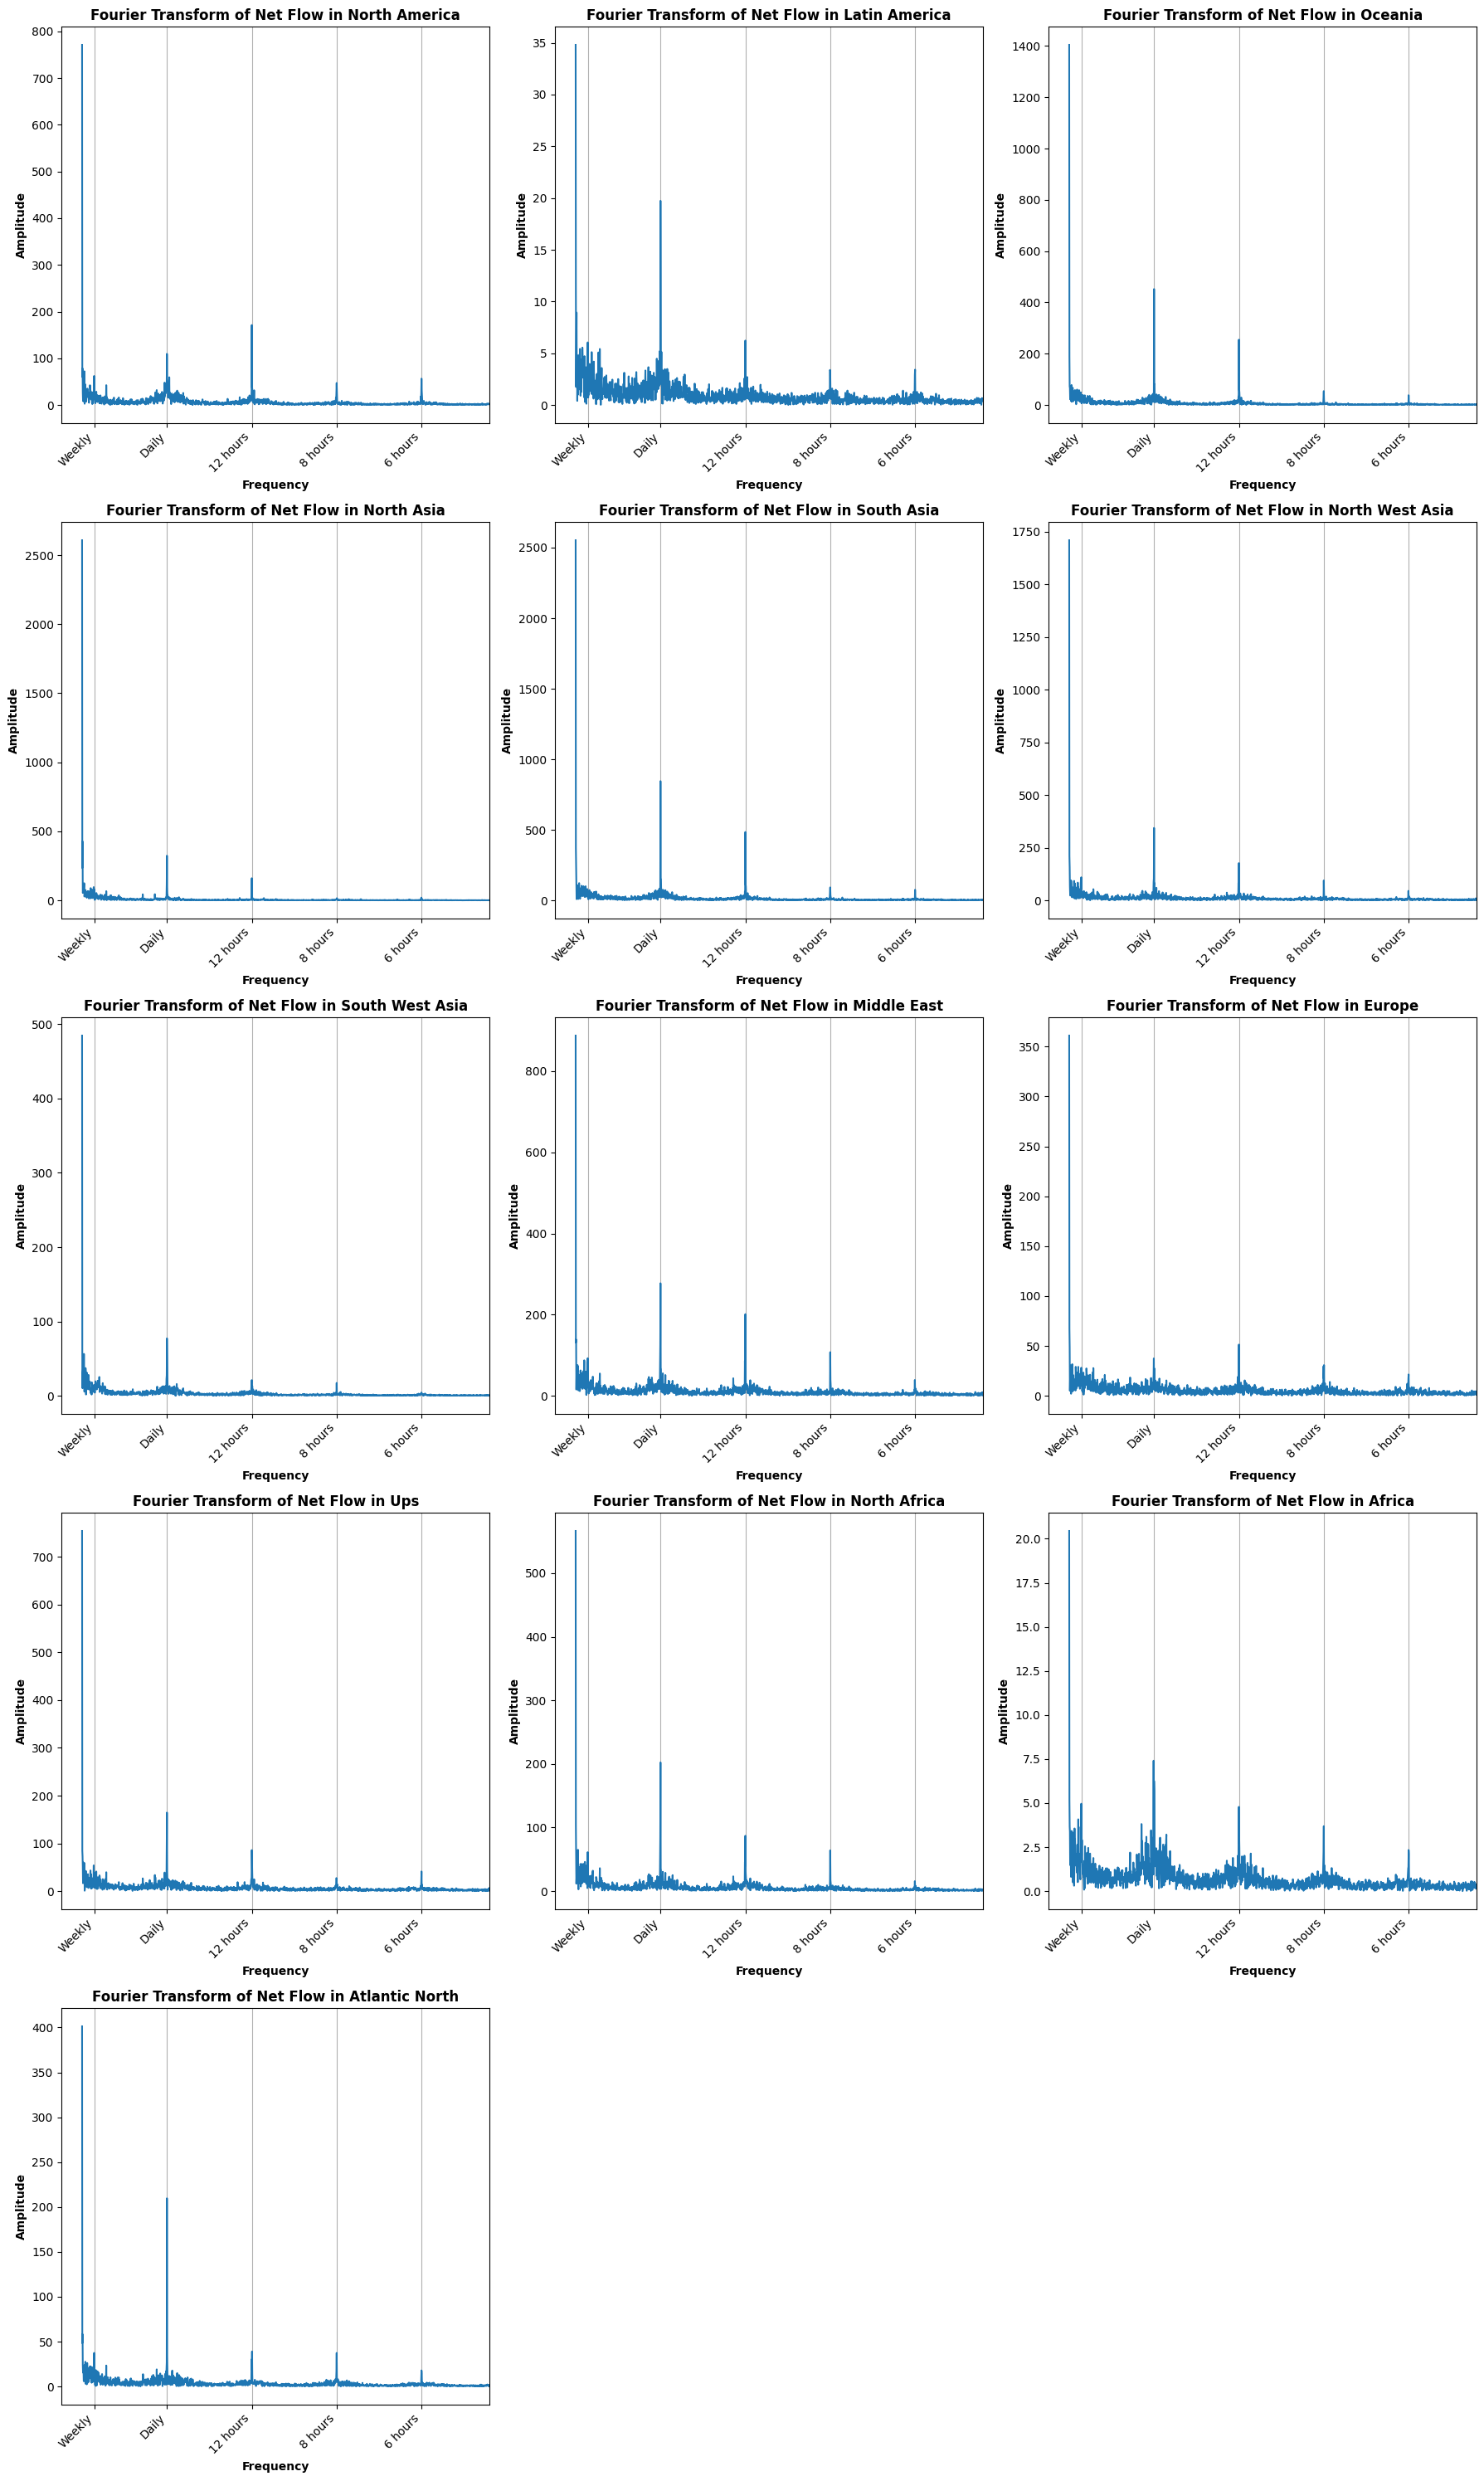

In [62]:
def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value, ax):
    series = region_value["actualflow"]
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
    ax.set_xticks(frequencies)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlim(-0.01, 1/5)
    ax.set_xlabel('Frequency', fontweight='bold')
    ax.set_ylabel('Amplitude', fontweight='bold')
    formatted_title = format_region_name(region_key)
    ax.set_title(f'Fourier Transform of Net Flow in {formatted_title}', fontweight='bold')
    ax.grid(True, axis='x')

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_fourier_transform(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()

# MAPS

## Global grid

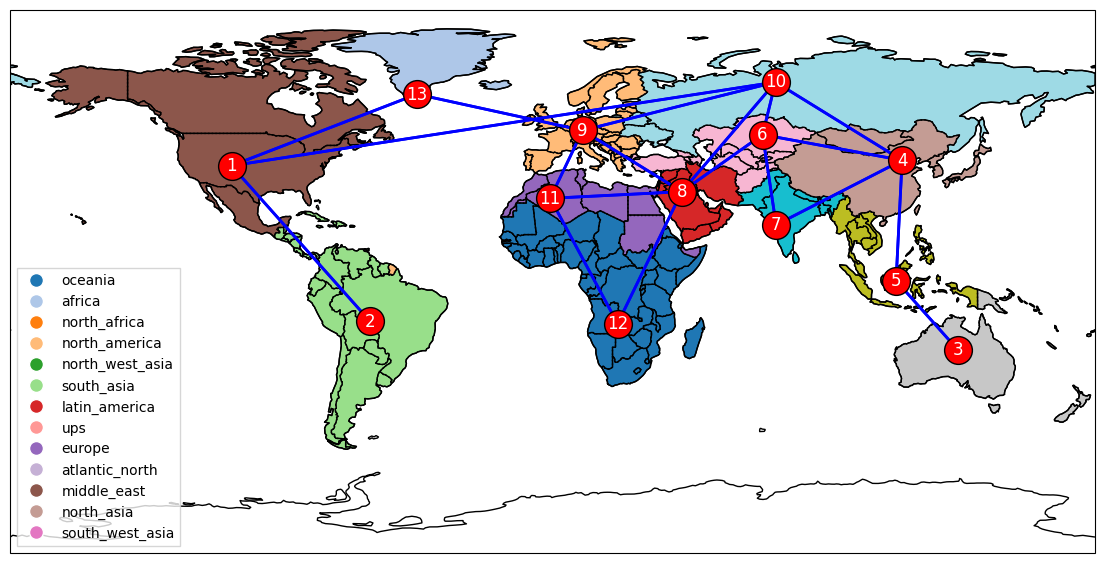

In [64]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Plot links
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


## Heat maps

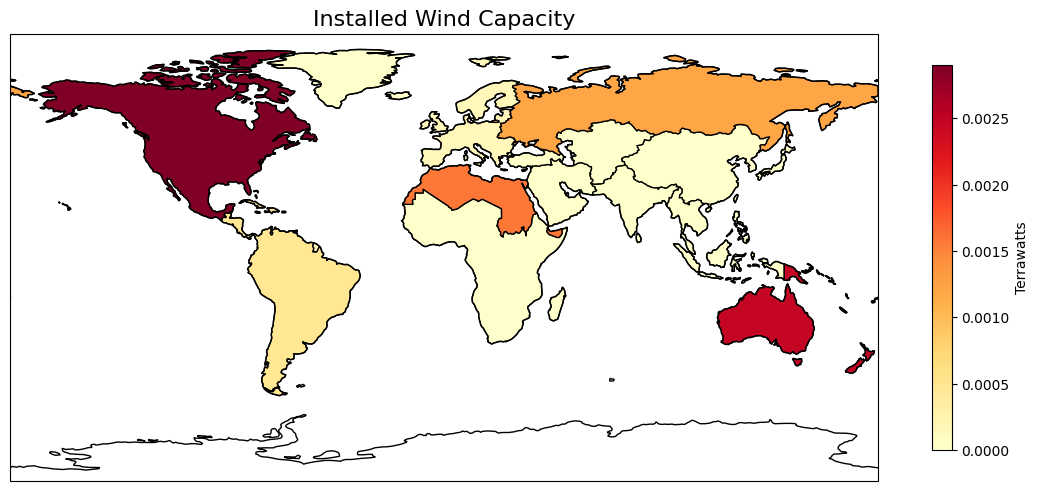

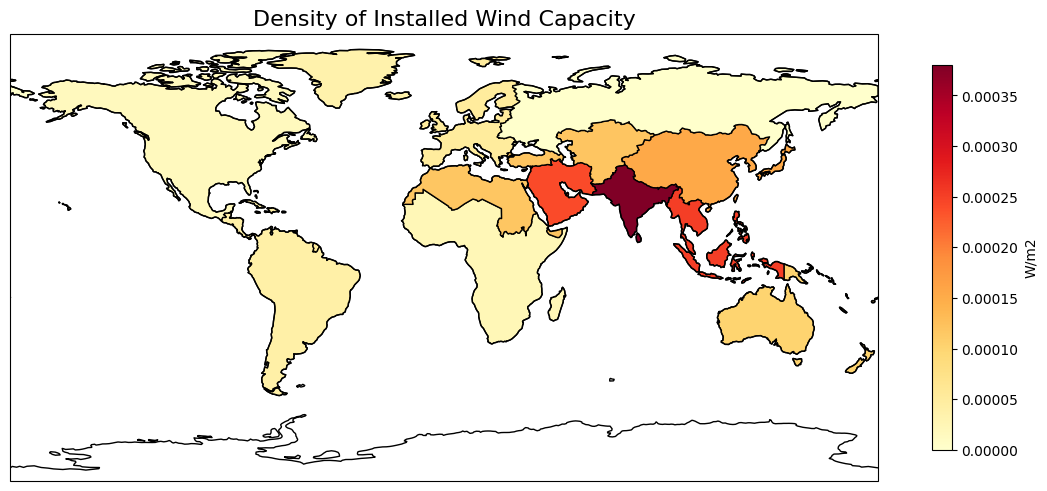

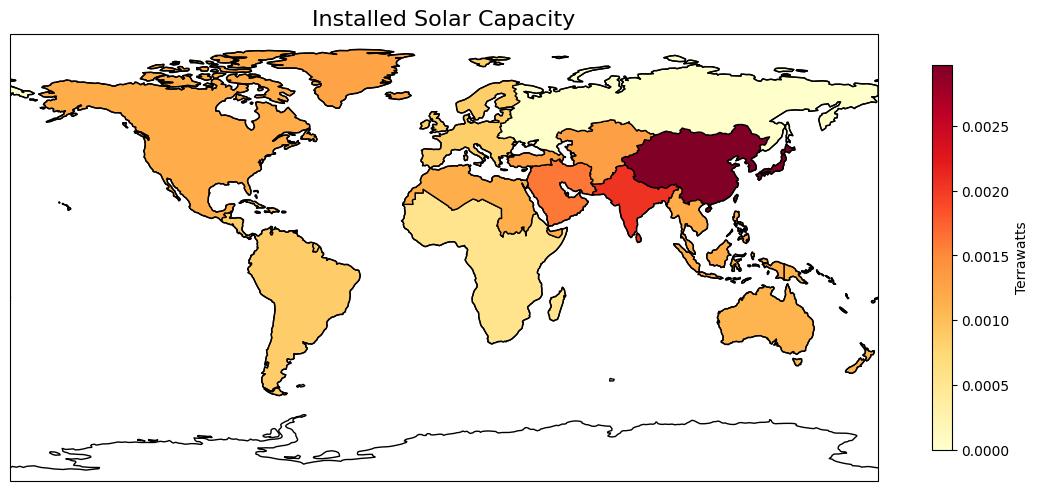

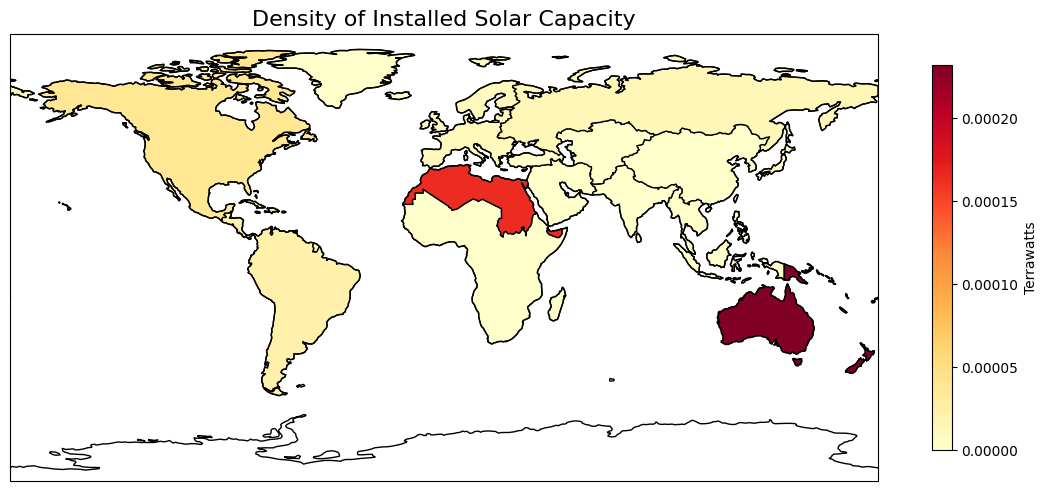

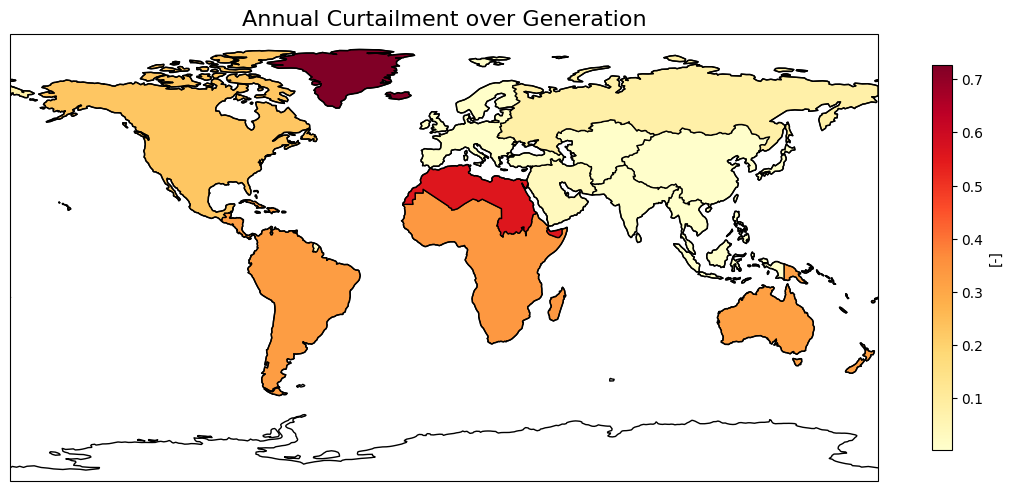

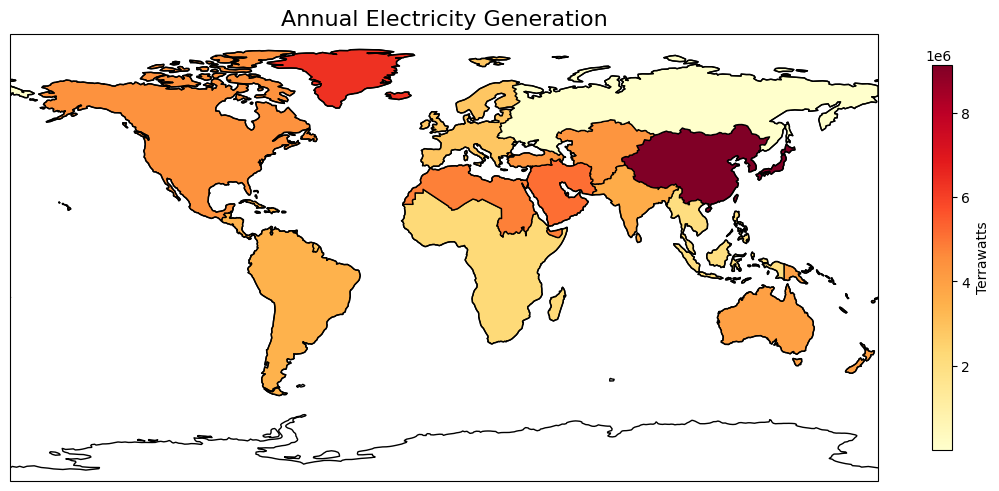

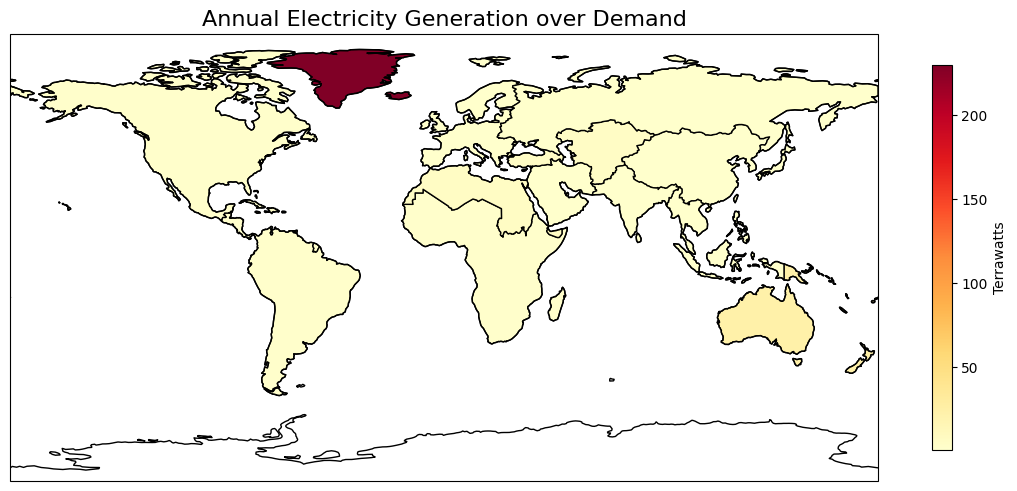

In [49]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["wind_installed"] / 1e6
    installed_capacity_pv_dic[key] = value["pv_installed"] / 1e6
    installed_cap_pv_area[key] = value["wind_installed"] / area * 1e6
    installed_cap_wind_area[key] = value["pv_installed"] / area * 1e6
    curtailment_rel_to_gen[key] = value["total_curtailment_yearly"] / (value["total_wind_yearly"] + value["total_pv_yearly"])
    loads_dic[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / value["total_load_yearly"]
    generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"] / 1e6
values_dics = [installed_capacity_pv_dic, installed_cap_pv_area,  installed_capacity_wind_dic,  installed_cap_wind_area, curtailment_rel_to_gen, generation_dic, loads_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Density of Installed Wind Capacity', fontsize=16)
    elif i == 2:
        plt.title('Installed Solar Capacity', fontsize=16)
    elif i == 3:
        plt.title('Density of Installed Solar Capacity', fontsize=16)
    elif i == 4:
        plt.title('Annual Curtailment over Generation', fontsize=16)
    elif i == 5:
        plt.title('Annual Electricity Generation', fontsize=16)
    elif i == 6:
        plt.title('Annual Electricity Generation over Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    if i == np.any([1, 3]):
        cbar.set_label('W/m2')
    elif i == np.any([5, 6]):
        cbar.set_label('TWh')
    elif i == 4:
        cbar.set_label('[-]')
    else:
        cbar.set_label('Terrawatts')


    plt.show()

## Power flow on maps

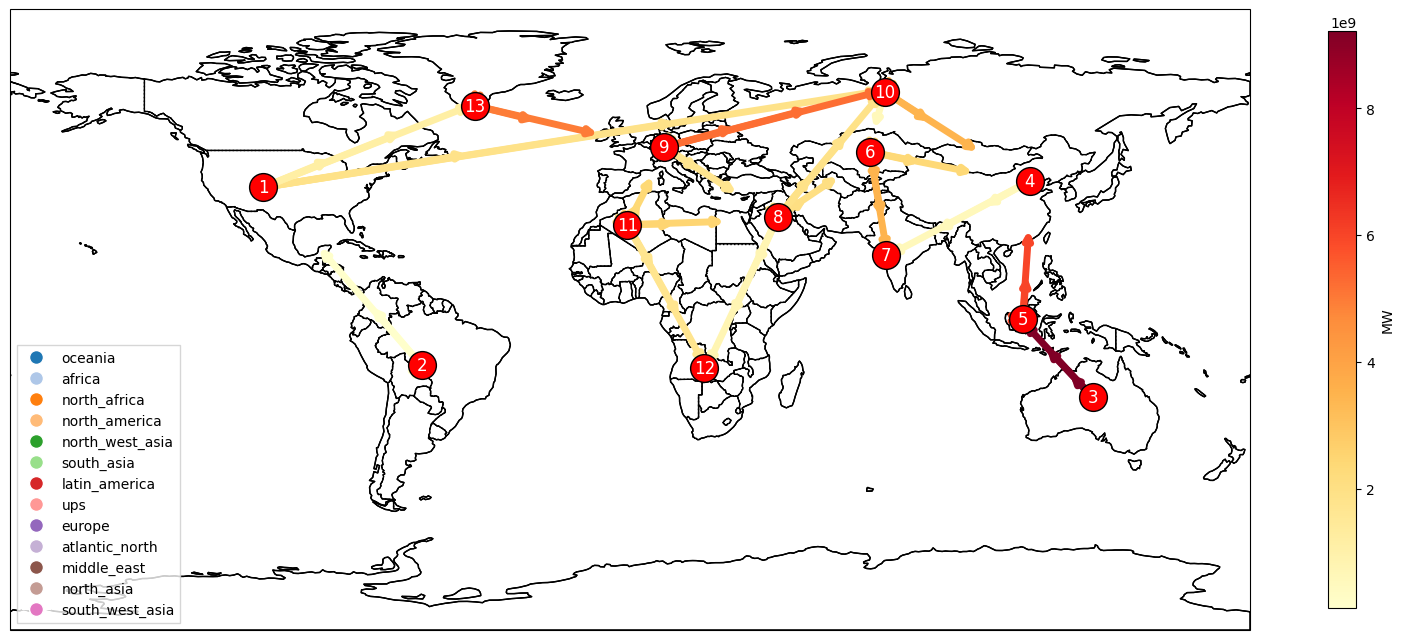

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend, setting facecolor to white
world.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())
world.plot(ax=ax, color='white', edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in n.links.index}  # Example boolean data for direction
arrow_colors = {value['name']: netflows_links[i] for i, (key, value) in enumerate(links_dic.items())}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.YlOrRd

# Function to calculate offset coordinates
def offset_coordinates(x0, y0, x1, y1, offset):
    dx, dy = x1 - x0, y1 - y0
    length = np.sqrt(dx**2 + dy**2)
    offset_x = -offset * dy / length
    offset_y = offset * dx / length
    return offset_x, offset_y

# Plot links with directional arrows and heatmap colors at 1/3, 2/3, and 3/3 points
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f'{value['name']}_0', 'bus0']
    bus1 = n.links.loc[f'{value['name']}_0', 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    
    offset_x, offset_y = offset_coordinates(x0, y0, x1, y1, 0.5)  # Adjust offset as needed
    
    # Calculate points at 1/3, 2/3, and 3/3 of the way along the line
    points = [
        (x0 + (x1 - x0) / 3 + offset_x, y0 + (y1 - y0) / 3 + offset_y),
        (x0 + 2 * (x1 - x0) / 3 + offset_x, y0 + 2 * (y1 - y0) / 3 + offset_y),
        (x1 + offset_x, y1 + offset_y)
    ]

    for point in points:
        # Determine the direction of the arrow
        if flow_statements[number]:
            start, end = (x0, y0), point # outflow
        else:
            start, end = (x1, y1), point
        
        # Determine the color of the arrow
        color = cmap(norm(arrow_colors[value['name']]))
        
        # Plot the arrow
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', color=color, linewidth=5))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()


## Power flow on flow chart

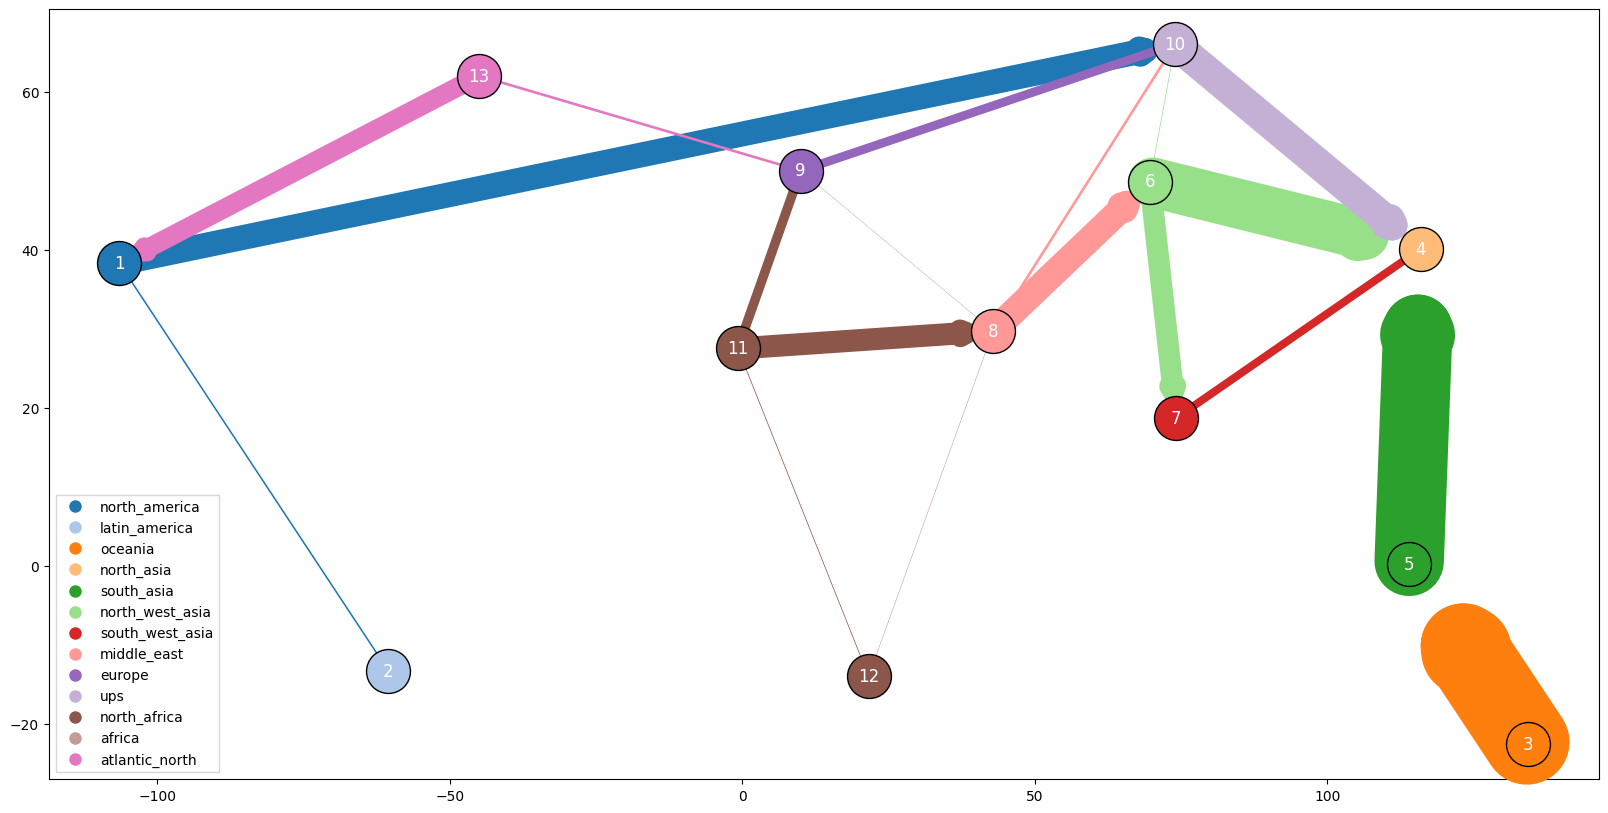

In [88]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

plt.rc("figure", figsize=(20, 10))

# Create a custom legend
unique_regions = list(regions_dic.keys())
region_colors = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=region) for region in unique_regions]

# Function to calculate offset coordinates
def offset_coordinates(x0, y0, x1, y1, offset):
    dx, dy = x1 - x0, y1 - y0
    length = np.sqrt(dx**2 + dy**2)
    offset_x = -offset * dy / length
    offset_y = offset * dx / length
    return offset_x, offset_y

# Plotting the network without background map
fig, ax = plt.subplots()

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    region_key = next((key for key, value in regions_dic.items() if bus in key), None)
    if region_key is None:
        continue  # Skip if the bus is not found in any region
    ax.scatter(x, y, s=1000, color=region_colors[region_key], edgecolor='k', zorder=5)  # Nodes with region colors
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]

    offset_x, offset_y = offset_coordinates(x0, y0, x1, y1, 0.5)
    flow = arrow_colors[value['name']]
    linewidth = np.abs(flow) / 1e8

    start, end = (x0, y0), (x1, y1)
    if flow_statements[number]:
        start, end = (x0, y0), (x1, y1)  # outflow
        color = region_colors.get(bus0, 'grey')
    else:
        start, end = (x1, y1), (x0, y0)  # inflow
        color = region_colors.get(bus1, 'grey')

    ax.annotate('', xy=end, xytext=start, arrowprops=dict(arrowstyle='-|>', color=color, linewidth=linewidth))

ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

plt.show()


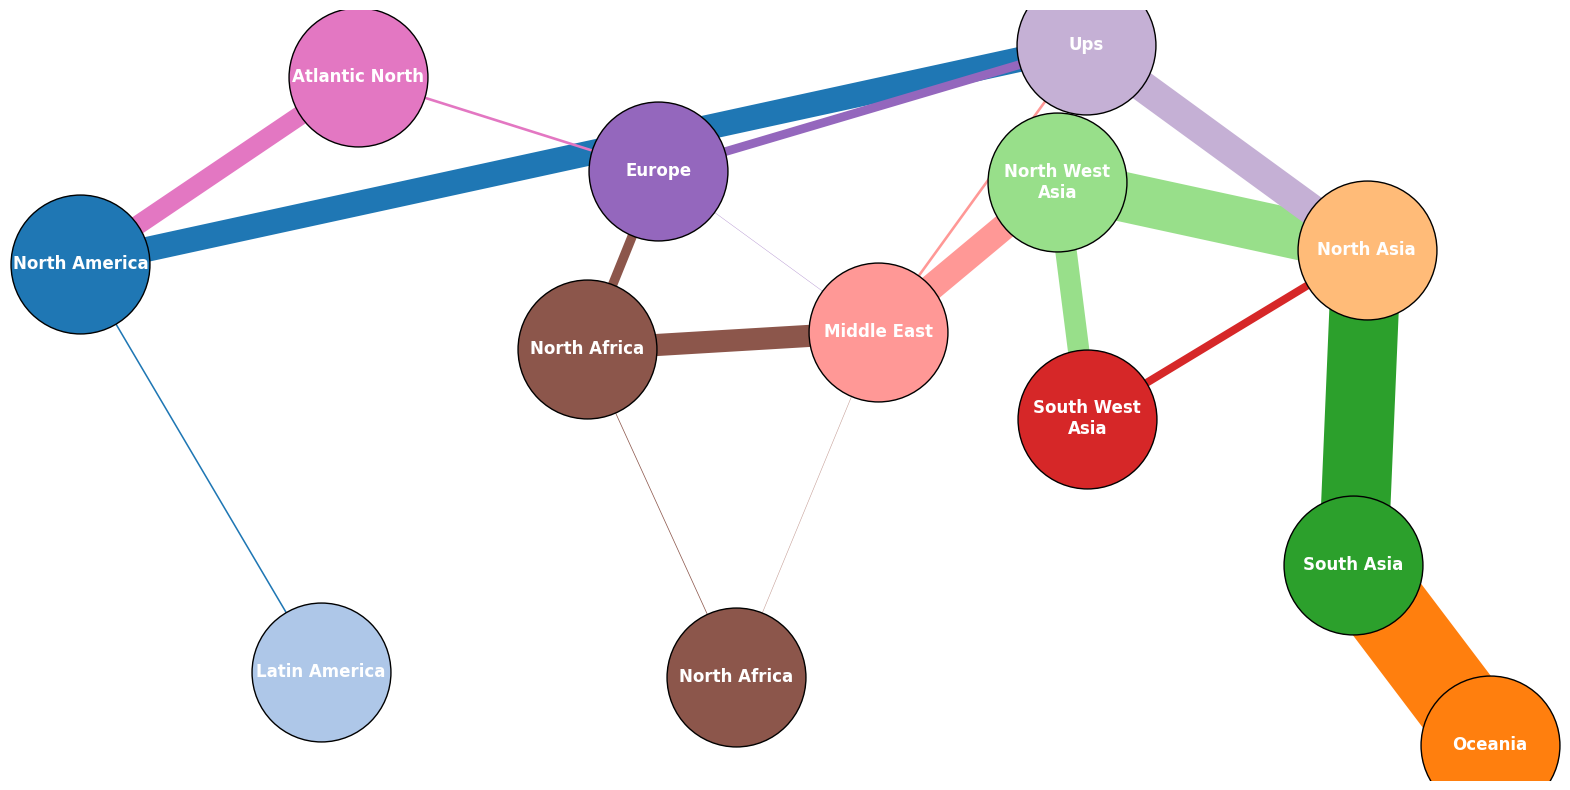

In [109]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

plt.rc("figure", figsize=(20, 10))

# Create a custom legend
unique_regions = list(regions_dic.keys())
region_colors = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}

# Adjust positions for specific nodes
node_adjustments = {
    1: (30, 0),
    2: (20, 0),
    13: (10, 0)
}

# Plotting the network without background map
fig, ax = plt.subplots()

# Adjust node positions only for plotting nodes
adjusted_positions = {}

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    
    if i in node_adjustments:
        adjustment = node_adjustments[i]
        x += adjustment[0]
        y += adjustment[1]
    
    adjusted_positions[bus] = (x, y)  # Save the adjusted positions for nodes
    
    region_key = next((key for key, value in regions_dic.items() if bus in key), None)
    if region_key is None:
        continue  # Skip if the bus is not found in any region
    
    ax.scatter(x, y, s=10000, color=region_colors[region_key], edgecolor='k', zorder=5)  # Further increased size of nodes
    
    # Format region name for display
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')  # Add region name inside the node

# Calculate node radius for adjustments
node_radius = np.sqrt(5000 / np.pi)

def adjust_for_radius(x0, y0, x1, y1, radius):
    dx, dy = x1 - x0, y1 - y0
    distance = np.sqrt(dx**2 + dy**2)
    if distance == 0:
        return x0, y0, x1, y1
    ratio = (distance - radius) / distance
    x1_new = x0 + dx * ratio
    y1_new = y0 + dy * ratio
    return x0, y0, x1_new, y1_new

# Plot lines with adjustments for node radius
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]

    start = adjusted_positions.get(bus0, (x0, y0))
    end = adjusted_positions.get(bus1, (x1, y1))

    start = adjust_for_radius(start[0], start[1], end[0], end[1], node_radius)
    end = adjust_for_radius(end[0], end[1], start[0], start[1], node_radius)

    flow = arrow_colors[value['name']]
    linewidth = np.abs(flow) / 1e8

    if flow_statements[number]:
        color = region_colors.get(bus0, 'grey')
    else:
        color = region_colors.get(bus1, 'grey')

    ax.plot([start[0], end[0]], [start[1], end[1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


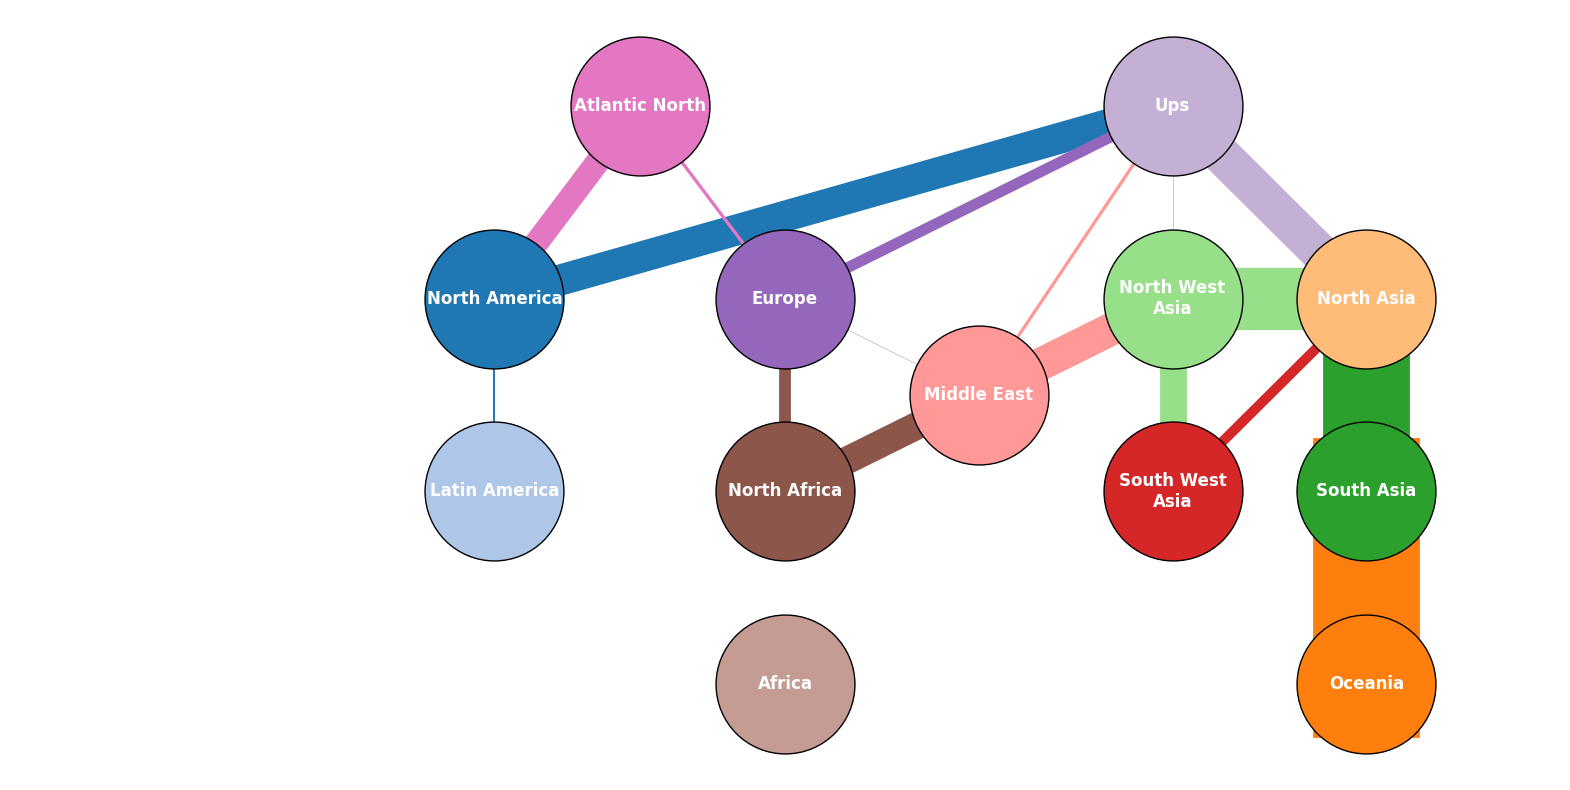

In [149]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

plt.rc("figure", figsize=(20, 10))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, -1),
    "europe": (0, 1),
    "africa": (0, -3),
    "middle_east": (1, 0),
    "north_west_asia": (2, 1),
    "south_west_asia": (2, -1),
    "south_asia": (3, -1),
    "north_asia": (3, 1),
    "oceania": (3, -3),
    "ups": (2, 3),
    "atlantic_north": (-0.75, 3),
    "north_america": (-1.5, 1),  
    "latin_america": (-1.5, -1)
}

# Scale coordinates to fit the plot
scale = 10
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}

# Create a custom legend
unique_regions = list(regions_dic.keys())
region_colors = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}

# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-4*scale, 4*scale)
ax.set_ylim(-4*scale, 4*scale)
# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue  # Skip if the region is not found in the dictionary
    ax.scatter(x, y, s=10000, color=region_colors[region_key_matched], edgecolor='k', zorder=5)  # Increased size of nodes
    
    # Format region name for display
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')  # Add region name inside the node

# Plot lines with adjustments for node radius
node_radius = np.sqrt(10000 / np.pi)

def adjust_for_radius(x0, y0, x1, y1, radius):
    dx, dy = x1 - x0, y1 - y0
    distance = np.sqrt(dx**2 + dy**2)
    if distance == 0:
        return x0, y0, x1, y1
    ratio = (distance - radius) / distance
    x1_new = x0 + dx * ratio
    y1_new = y0 + dy * ratio
    return x0, y0, x1_new, y1_new

for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    region_key0 = next((key for key, value in regions_dic.items() if bus0 in key), None)
    region_key1 = next((key for key, value in regions_dic.items() if bus1 in key), None)
    
    if region_key0 is None or region_key1 is None:
        continue  # Skip if the region is not found in the dictionary
    
    x0, y0 = scaled_coordinates[region_key0]
    x1, y1 = scaled_coordinates[region_key1]

    start = adjust_for_radius(x0, y0, x1, y1, node_radius)
    end = adjust_for_radius(x1, y1, x0, y0, node_radius)

    flow = arrow_colors[value['name']]
    linewidth = np.abs(flow) / 0.8e8

    if flow_statements[number]:
        color = region_colors.get(region_key0, 'grey')
    else:
        color = region_colors.get(region_key1, 'grey')

    ax.plot([start[0], end[0]], [start[1], end[1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


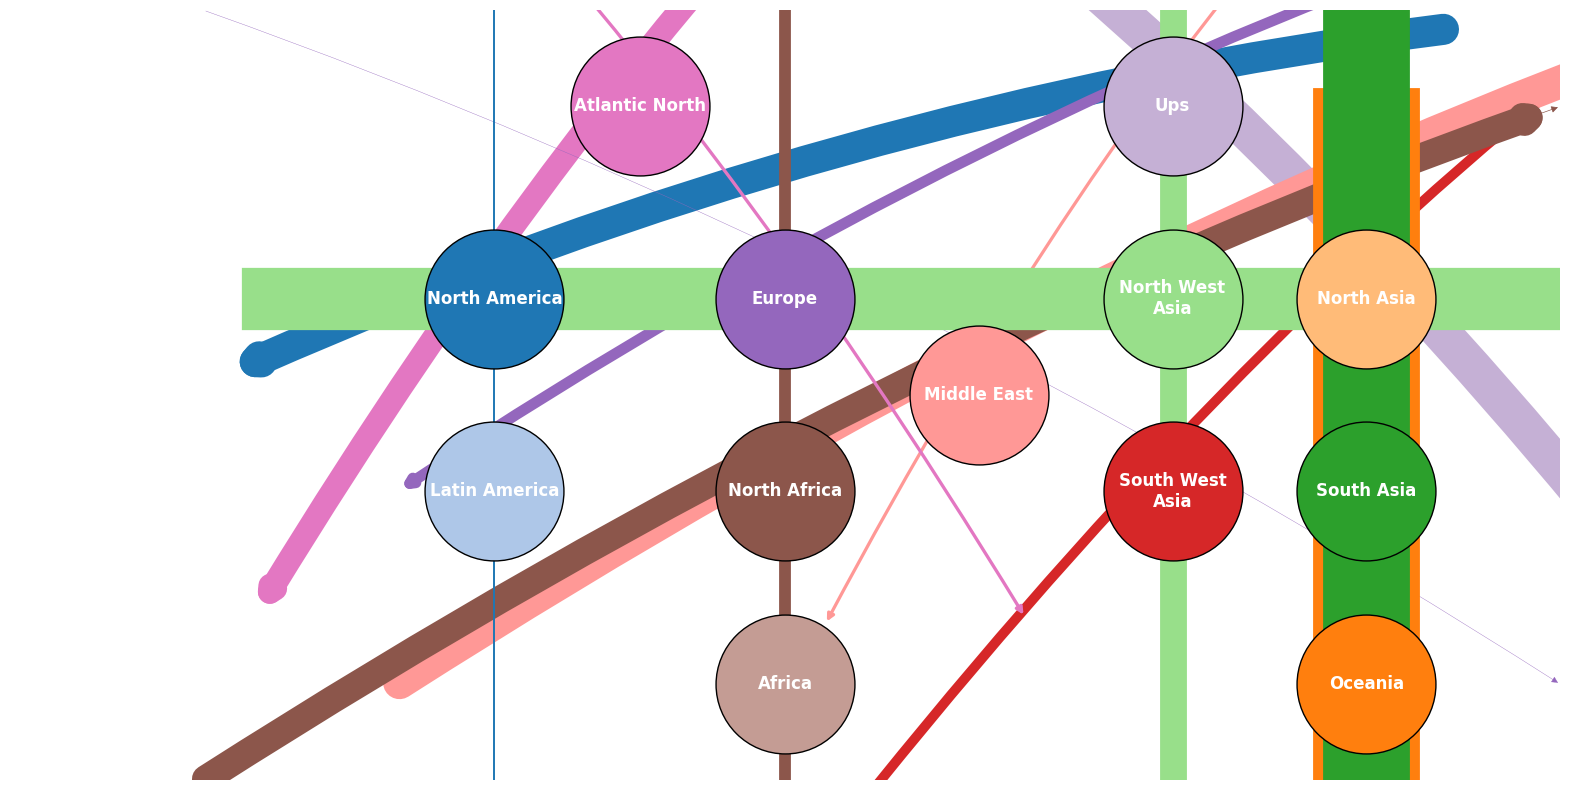

In [154]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path

plt.rc("figure", figsize=(20, 10))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, -1),
    "europe": (0, 1),
    "africa": (0, -3),
    "middle_east": (1, 0),
    "north_west_asia": (2, 1),
    "south_west_asia": (2, -1),
    "south_asia": (3, -1),
    "north_asia": (3, 1),
    "oceania": (3, -3),
    "ups": (2, 3),
    "atlantic_north": (-0.75, 3),
    "north_america": (-1.5, 1),  
    "latin_america": (-1.5, -1)
}

# Scale coordinates to fit the plot
scale = 10
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}

# Create a custom legend
unique_regions = list(regions_dic.keys())
region_colors = {region: plt.cm.tab20(i) for i, region in enumerate(unique_regions)}

# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-4*scale, 4*scale)
ax.set_ylim(-4*scale, 4*scale)
# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue  # Skip if the region is not found in the dictionary
    ax.scatter(x, y, s=10000, color=region_colors[region_key_matched], edgecolor='k', zorder=5)  # Increased size of nodes
    
    # Format region name for display
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')  # Add region name inside the node

# Plot lines with adjustments for node radius
node_radius = np.sqrt(10000 / np.pi)
min_distance_for_curve = 2 * scale  # Minimum distance to consider for curving

def adjust_for_radius(x0, y0, x1, y1, radius):
    dx, dy = x1 - x0, y1 - y0
    distance = np.sqrt(dx**2 + dy**2)
    if distance == 0:
        return (x0, y0), (x1, y1)
    ratio = (distance - radius) / distance
    x0_new = x0 + dx * radius / distance
    y0_new = y0 + dy * radius / distance
    x1_new = x1 - dx * radius / distance
    y1_new = y1 - dy * radius / distance
    return (x0_new, y0_new), (x1_new, y1_new)

def curved_arrow(ax, start, end, color, linewidth):
    verts = [start,
             ((start[0] + end[0]) / 2, (start[1] + end[1]) / 2 + scale),  # Control point for the curve
             end]

    codes = [Path.MOVETO,
             Path.CURVE3,
             Path.CURVE3]

    path = Path(verts, codes)
    patch = FancyArrowPatch(path=path, color=color, linewidth=linewidth, arrowstyle='-|>', mutation_scale=10)
    ax.add_patch(patch)

for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    region_key0 = next((key for key, value in regions_dic.items() if bus0 in key), None)
    region_key1 = next((key for key, value in regions_dic.items() if bus1 in key), None)
    
    if region_key0 is None or region_key1 is None:
        continue  # Skip if the region is not found in the dictionary
    
    x0, y0 = scaled_coordinates[region_key0]
    x1, y1 = scaled_coordinates[region_key1]

    start, end = adjust_for_radius(x0, y0, x1, y1, node_radius)

    flow = arrow_colors[value['name']]
    linewidth = np.abs(flow) / 0.8e8

    if flow_statements[number]:
        color = region_colors.get(region_key0, 'grey')
    else:
        color = region_colors.get(region_key1, 'grey')

    # Check if nodes are aligned horizontally or vertically and distance between nodes
    if (start[0] == end[0] or start[1] == end[1]) or (np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2) < min_distance_for_curve):
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color, linewidth=linewidth)
    else:
        curved_arrow(ax, start, end, color, linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()
